# Reference

In [ ]:
library(reshape2)
library(ggplot2)
library(rtracklayer)
library(BiocParallel)
library(dplyr)
setwd("/NAS/wg_looking/gRNA_ONT")



# loading gtf file
gtfFile = "/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.gtf"
gtf <- rtracklayer::import(gtfFile)
gtf <- as.data.frame(gtf)
transcript_gtf <- gtf[gtf$type == "transcript",]
coding_gene =  gtf[gtf$type=="gene" & gtf$gene_type=="protein_coding", ]

hg38.gtf <- gtf
save(hg38.gtf, file="stat/hg38.gtf.RData")


In [ ]:
# loading gff file
gffFile = "/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.gff3"
gff <- rtracklayer::import(gffFile)
gff <- as.data.frame(gff)

gff.sub <- gff[!(gff$type %in% "gene"), ]
gff.split <- split(gff.sub, factor(gff.sub$transcript_id))


# Mapping genomic coordinates to transcript-relative coordinates
map.list <- lapply(gff.split, function(df){
    df.list <- split(df, factor(df$seqnames))
    b <- lapply(df.list, function(df){
            df <- df[, c("seqnames", "start", "end", "type", "ID", "transcript_id", "gene_id", "gene_type", "gene_name")]
            t_start <- (df$start - df$start[1] + 1)
            t_end <- (df$end - df$start[1] + 1)
            re.df <- data.frame(df[, c("transcript_id", "ID")], t_start, t_end, df[, -c(5,6)]) 
    })
    c <- rbindlist(b)
})

gff.anno <- rbindlist(map.list)

save(gff.anno, file="stat/gff.anno.RData")

In [ ]:
# the transcript length
hg38_trans_length = "/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.transcript.length"
L <- read.table(hg38_trans_length, stringsAsFactors=F)
colnames(L) <- c("transcript_id", "length")

p1 <- ggplot(L, aes(x=length)) +
    geom_density(size=2,  color="#4678BA") + 
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 30, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    # scale_color_manual(values = cols) +
    scale_x_log10() +
    ggtitle("the length distribution of ref transcript") 
  
ggsave(paste0("stat/ref_trans_length_density.pdf"),
      width=6, height=5)





In [ ]:
################
#  Distance of Alu from gene endpoints
RM_file <- paste0("database/gencode.v37.chr_patch_hapl_scaff.transcript.fa.out")
RM.tb <- read_rm(RM_file)
RM.tb <- data.frame(RM.tb)
RM.tb <- RM.tb[as.numeric(RM.tb$sw_score)>=225 & as.numeric(RM.tb$perc_div)<=18, ]
RM.tb <- RM.tb[grepl("L1HS", RM.tb$repeat_id) | 
                   grepl("L1P", RM.tb$repeat_id) | 
                   RM.tb$matching_class %in% c("SINE/Alu"), ]
dim(RM.tb) 
TEs <- c("SINE/Alu", "LINE/L1")

tb <- RM.tb[RM.tb$matching_class =="SINE/Alu",]
start <- tb$qry_start
pp <- data.frame(start)

ggplot(pp, aes(x=start)) + 
  geom_density(color="#4678BA", size=2)+
  theme_classic() +
  scale_x_log10() +
  ggtitle("The start of Alu in reference transcripts")

ggsave("stat/The_start_of_Alu_in_reference_transcripts.pdf", width = 7, height = 5)


##########
# Alu
tb <- RM.tb[RM.tb$matching_class =="SINE/Alu",]
colnames(tb)[5] <- "transcript_id"
length(unique(tb$transcript_id)) # 36945
tb.merge <- merge(tb, transcript_gtf[,c("transcript_id", "gene_id", "gene_name", "gene_type")], by="transcript_id")
# length(unique(tb.merge$gene_id[tb.merge$gene_type=="protein_coding"]))
length(unique(tb.merge$gene_id)) # 16311

start <- tb$qry_start
pp <- data.frame(start)

ggplot(pp, aes(x=start)) + 
  geom_density(color="#4678BA", size=2)+
  theme_classic() +
  scale_x_log10() +
  ggtitle("The start of Alu in reference transcripts")

ggsave("stat/The_start_of_Alu_in_reference_transcripts.pdf", width = 7, height = 5)


#########
# L1
tb <- RM.tb[RM.tb$matching_class =="LINE/L1",]
colnames(tb)[5] <- "transcript_id"
length(unique(tb$transcript_id))
tb.merge <- merge(tb, transcript_gtf[,c("transcript_id", "gene_id", "gene_name", "gene_type")], by="transcript_id")
length(unique(tb.merge$gene_id[tb.merge$gene_type=="protein_coding"]))
length(unique(tb.merge$gene_id))


start <- tb$qry_start
pp <- data.frame(start)

ggplot(pp, aes(x=start)) + 
  geom_density(color="#4678BA", size=2)+
  theme_classic() +
  scale_x_log10() +
  ggtitle("The start of L1 in reference transcripts")

ggsave("stat/The_start_of_L1_in_reference_transcripts.pdf", width = 7, height = 5)




## Alu and L1 related genes/transcript
# Alu
tb <- RM.tb[RM.tb$matching_class %in% c("SINE/Alu", "LINE/L1"),]
colnames(tb)[5] <- "transcript_id"
tb.merge <- merge(tb, transcript_gtf[,c("transcript_id", "gene_id", "gene_name", "gene_type")], by="transcript_id")
write.table(tb.merge, "stat/Ref_Alu_L1_related_transcripts.txt", sep="\t", quote=F, row.names=F, col.names=T)


In [ ]:

## Alu and L1 related genes/transcript
num.list <- lapply(c("SINE/Alu", "LINE/L1"), function(TE){
    tb <- RM.tb[RM.tb$matching_class %in% TE,]
    colnames(tb)[5] <- "transcript_id"
    tb.merge <- merge(tb, transcript_gtf[,c("transcript_id", "gene_id", "gene_name", "gene_type")], by="transcript_id")
    coding_trans <- unique(tb.merge[tb.merge$gene_type %in% "protein_coding", "transcript_id"])
    noncoding_trans <- unique(tb.merge[!(tb.merge$gene_type %in% "protein_coding"), "transcript_id"])
    coding_gene <- unique(tb.merge[tb.merge$gene_type %in% "protein_coding", "gene_id"])
    noncoding_gene <- unique(tb.merge[!(tb.merge$gene_type %in% "protein_coding"), "gene_id"])

    n1_coding <- data.frame(Repeat=TE, 
                     coding_type="protein_coding",
                    type=c("gene", "transcript"),
                    num=c(length(coding_gene), length(coding_trans)))
    n1_noncoding <- data.frame(Repeat=TE, 
                     coding_type="non_coding",
                    type=c("gene", "transcript"),
                    num=c(length(noncoding_gene), length(noncoding_trans)))
    n1 <- rbind(n1_coding, n1_noncoding)


})

num <- rbindlist(num.list)


In [ ]:
library(bedtoolsr)
load("stat/gff.anno.RData")

RM_file <- paste0("database/ref_transcript_with_intron/RepeatMasker_res/gencode.v37.chr_patch_hapl_scaff.transcript.with_intron.fa.out")
RM.tb <- read_rm(RM_file)
RM.tb <- data.frame(RM.tb)
RM.tb <- RM.tb[as.numeric(RM.tb$sw_score)>=225 & as.numeric(RM.tb$perc_div)<=18, ]
tb <- RM.tb[RM.tb$matching_class %in% c("SINE/Alu", "LINE/L1"),]
RM.bed <- tb[, c("qry_id", "qry_start", "qry_end", "repeat_id")]

gff.bed <- gff.anno[, c("transcript_id", "t_start", "t_end", "type")]

res <- bt.intersect(gff.bed, RM.bed, wa=T, wb=T)
res <- res[, -5]
colnames(res) <- c("transcript_id", "start", "end", "type", "repeat_start", "repeat_end", "repeat_id")
f <- paste(res$transcript_id, res$repeat_start, res$repeat_end, res$repeat_id, sep="_")
res$split_f <- f
res.list <- split(res, factor(res$split_f))
res.list2 <- lapply(res.list, function(df){
    if(dim(df)[1]==1){
    d <- df}
    else if(dim(df)[1]==2){
        d <- df[df$type %in% "exon", ]
    }
    else{
        if("three_prime_UTR" %in% df$type){
            d <- df[df$type %in% "three_prime_UTR", ]
        }
        else if("five_prime_UTR" %in% df$type){
            d <- df[df$type %in% "five_prime_UTR", ]
        }
        else(
             d <- df[df$type %in% "exon", ]
        )
    }
    return(d)
})

res2 <- rbindlist(res.list2)
res.out <- res2[,1:7] 
res.out <- merge(res.out, transcript_gtf[,c("transcript_id", "gene_id", "gene_name", "gene_type")], by="transcript_id")
res.out$type <- as.character(res.out$type)
res.out$type[res.out$type %in% "transcript"] <- "intron"

write.table(res.out, "stat/Ref_Alu_L1_related_transcripts_with_intron.txt", 
            sep="\t", quote=F, row.names=F, col.names=T)
  

In [ ]:
library("ensembldb")
library(EnsDb.Hsapiens.v86)

tb <- RM.tb[RM.tb$matching_class ==c("SINE/Alu", "LINE/L1"),]
rng_tx <- IRanges(start=tb$qry_start, end=tb$qry_end, names=tb$qry_id)
rng_tx <- IRanges(bed)
rng_gnm <- transcriptToGenome(rng_tx, EnsDb.Hsapiens.v86)
edbx <- filter(EnsDb.Hsapiens.v86, filter = ~ seq_name == "X")


## guide RNA in transcript

In [ ]:
library(RFLPtools)
setwd("/NAS/wg_looking/gRNA_ONT")

gRNA_out <- read.blast("stat/gencode.v37.chr_patch_hapl_scaff.transcript.fa.guideRNA.out", sep="\t")





# cleavage sites (from Biopython results)

In [ ]:
library(ggplot2)
setwd("/NAS/wg_looking/gRNA_ONT")

# for Alu
# c("sgRNA_20210527", "sgRNA_20210617", "sgRNA_20210802", "DNA_20210425", "sgRNA_20210913", "sgRNA_20210916_sg14", "sgRNA_20210916_sg24")
# IDs <- c("sgRNA_HCT116_1", "sgRNA_HCT116_2", "sgRNA_HCT116_3", "sgRNA_NCM460_1", "sgRNA_NCM460_2", "sgRNA_NCM460_3")
# IDs <- c("sgRNA_K562_1", "sgRNA_MDAMB231_1", "sgRNA_MDAMB231_2", "sgRNA_MDAMB231_3")
IDs <- c("sgRNA_MCF10A_1", "sgRNA_MCF10A_2", "sgRNA_MCF10A_3")
for(ID in IDs){
  Forward = "GGCCGGGCGCGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCGAGGCGGGCGGA"
  # reverse_complete = "TCCGCCCGCCTCGGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCACCGCGCCCGGCC"
  file = paste0(ID, "/read_start_cutsite_Alu.txt")
  file2 = paste0(ID, "/read_start_cutsite_Alu_for_plot.txt")
  system(paste0("grep Alu ", file, " > ", file2))
  site.tb <- read.table(file2, blank.lines.skip=T,sep = '\t',fill=T, stringsAsFactors = F)
  site.tb <- site.tb[site.tb$V3=="Alu",]
  Forward.tb <- site.tb[grepl("Forward",site.tb$V1),]
  Reverse.tb <- site.tb[grepl("Reverse",site.tb$V1),]
  
  # Forward
  Forward.pp <- data.frame(site=1:60, number=0)
  t <- table(Forward.tb$V2)[names(table(Forward.tb$V2)) %in% 1:60]
  Forward.pp[names(t),"number"] <- t
  Forward.pp$site <- factor(Forward.pp$site)
  Forward.pp$number <- as.numeric(Forward.pp$number)
  # reverse
  Reverse.pp <- data.frame(site=1:60, number=0)
  t <- table(Reverse.tb$V2)[names(table(Reverse.tb$V2)) %in% 1:60]
  Reverse.pp[names(t),"number"] <- t
  Reverse.pp$site <- factor(Reverse.pp$site)
  Reverse.pp$number <- as.numeric(Reverse.pp$number)
  
  pp <- rbind(data.frame(Forward.pp, Orientation="Forward"),
              data.frame(Reverse.pp, Orientation="Reverse"))
  pp[pp$Orientation=="Reverse", "number"] <- -pp[pp$Orientation=="Reverse", "number"]
  
  
  ggplot(pp, aes(x=site, y=number, fill=Orientation)) +
    geom_bar(stat="identity") +
    # facet_wrap(~class, nrow = 2, scales="free") +
    scale_fill_manual(values = c("#4678BA", "#EF8354")) +
    ggtitle(ID) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black",
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    scale_x_discrete(labels=strsplit(Forward, "")[[1]])+
    ylab("the number of reads")
  
  
  ggsave(paste0("stat/", ID, ".Alu_cleavage_sites.pdf"), width=8, height=5)
  
  
}



In [ ]:
# for  L1
for(ID in IDs){
  Forward = "NNNNNNNNNNTCTGAGATCAAACTGCAAGGNGGNNNNNNNNNNNNNNCCNTTGTAGGGACATGGATGAAANNNNNNNNNN"
  # reverse_complete = ""
  file = paste0(ID, "/read_start_cutsite_L1.txt")
  file2 = paste0(ID, "/read_start_cutsite_L1_for_plot.txt")
  system(paste0("grep L1 ", file, " > ", file2))
  site.tb <- read.table(file2, blank.lines.skip=T,sep = '\t',fill=T, stringsAsFactors = F)
  site.tb <- site.tb[site.tb$V3=="L1",]
  Forward.tb <- site.tb[grepl("Forward",site.tb$V1),]
  Reverse.tb <- site.tb[grepl("Reverse",site.tb$V1),]
  
  # Forward
  Forward.pp <- data.frame(site=c(389:428, 5703:5742), number=0)
  t <- table(Forward.tb$V2)[names(table(Forward.tb$V2)) %in% c(389:428, 5703:5742)]
  Forward.pp$site <- factor(Forward.pp$site)
  Forward.pp[Forward.pp$site %in% names(t),"number"] <- t
  Forward.pp$number <- as.numeric(Forward.pp$number)
  # reverse
  Reverse.pp <- data.frame(site=c(389:428, 5703:5742), number=0)
  t <- table(Reverse.tb$V2)[names(table(Reverse.tb$V2)) %in% c(389:428, 5703:5742)]
  Reverse.pp$site <- factor(Reverse.pp$site)
  Reverse.pp[Reverse.pp$site %in% names(t),"number"] <- t
  
  Reverse.pp$number <- as.numeric(Reverse.pp$number)
  
  pp <- rbind(data.frame(Forward.pp, Orientation="Forward"),
              data.frame(Reverse.pp, Orientation="Reverse"))
  pp[pp$Orientation=="Reverse", "number"] <- -pp[pp$Orientation=="Reverse", "number"]
  
  
  ggplot(pp, aes(x=site, y=number, fill=Orientation)) +
    geom_bar(stat="identity") +
    # facet_wrap(~class, nrow = 2, scales="free") +
    scale_fill_manual(values = c("#4678BA", "#EF8354")) +
    ggtitle(ID) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black",
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    scale_x_discrete(labels=strsplit(Forward, "")[[1]])+
    ylab("the number of reads")
  
  
  ggsave(paste0("stat/", ID, ".L1_cleavage_sites.pdf"), width=8, height=5)
  
  
}



# TE and Gene anno

In [ ]:
library(biomartr)
library(data.table)
library(ggplot2)
setwd("/NAS/wg_looking/gRNA_ONT")



## function

### RM + uniquely mapping res

In [ ]:
# RM + uniquely mapping res
readAnno_func3 <- function(ID, RM_file, bamFile, div, w, sw_score=225){
  # w : the region length of head or tail
  library(rtracklayer)
  library(BiocParallel)
  library(dplyr)
  library(biomartr)
  library(data.table)
  
  
  # loading gtf file
  gtfFile = "/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.gtf"
  gtf <- rtracklayer::import(gtfFile)
  gtf <- as.data.frame(gtf)
  transcript_gtf <- gtf[gtf$type == "transcript",]
  coding_gene =  gtf[gtf$type=="gene" & gtf$gene_type=="protein_coding", ]
  
  
  
  # bam file
  library(Rsamtools)
  bamFile <- paste0(ID, "/", ID, ".transcriptom.sort.unique.bam")
  bam <- scanBam(bamFile)
  bam.tb <- data.frame(bam[[1]])
  bam.tb <- bam.tb[bam.tb$flag %in% c(0, 16), c("qname", "rname")]
  # tail(sort(table(bam.tb$qname)))
  colnames(bam.tb) <- c("qry_id", "transcript_id")
  bam.anno <- merge(bam.tb, transcript_gtf[, c("transcript_id", "gene_id", "gene_name", "gene_type")], by="transcript_id")
  rownames(bam.anno) <- bam.anno$qry_id
  
  # RepeatMasker results
  RM.tb <- read_rm(RM_file)
  RM.tb <- data.frame(RM.tb)
  RM.tb <- RM.tb[as.numeric(RM.tb$sw_score)>=sw_score & as.numeric(RM.tb$perc_div)<=div, ]
  RM.tb <- RM.tb[grepl("L1HS", RM.tb$repeat_id) | 
                   grepl("L1P", RM.tb$repeat_id) | 
                   RM.tb$matching_class %in% c("SINE/Alu"), ]

  dim(RM.tb) 
  TEs <- c("SINE/Alu", "LINE/L1")
  
  
  
  readTE.list <- lapply(setNames(TEs, TEs), function(TE){
    
    sub <- RM.tb[RM.tb$matching_class %in% TE, ]
    label <- apply(sub, 1, function(x){
      start <- as.integer(x[6])
      end <- as.integer(x[7])
      left <- x[8]
      left <- gsub("\\)", "", gsub("\\(", "", left))
      left <- as.integer(left)
      # repeat_id <- x[10]
      # repeat_class <- x[11]
      # p0 <- paste(start, end, left, sep= ",")
      # rep0 <- paste(repeat_class, repeat_id, sep=",")
      if(start <= w & left <= w){
        label0 = "cross"
      }else if(start <= w & left > w){
        label0 = "head"
      }else if(start > w & left <= w){
        label0 = "tail"
      }else{
        label0 = "middle"
      }
      return(label0)
    })
    sub$label <- label
    sub.list  <- split(sub, factor(sub$qry_id))
    
    a <- lapply(sub.list, function(df){
      read_name <- df[1,5]
      p <- paste(df$qry_start, df$qry_end, df$qry_left,sep=",")
      rep  <- paste(df$matching_class, df$repeat_id, sep=",")
      label <- df$label
      
      p <- paste(p, collapse = ":")
      rep <- paste(rep, collapse = ":")
      label <- paste(label, collapse = ":")
      
      
      #
      read_info <- data.frame(read_name, p, rep, label, dim(df)[1])
      colnames(read_info) <- c("read_name", "position", "repeat", "label", "number")
      
      return(read_info)
    })
    a <- rbindlist(a)
    a <- data.frame(a)
    rownames(a) <- a$read_name
    # a <- merge(a, talon.tb, by="row.names", all.x=TRUE)
    a <- merge(a, bam.anno, by="row.names", all.x=TRUE)
    a$gene_novelty <- a$gene_id
    a$gene_novelty[!is.na(a$gene_id)] <- "Known"
    a$protein_coding[a$gene_type =="protein_coding"] <- "YES"
    
    return(a)
  })
  
  
  
  
  # write.table(readTE.list[["SINE/Alu"]], "test_20210527.Alu.gene.txt", sep="\t", quote = F, col.names = T, row.names = F)
  # write.table(readTE.list[["LINE/L1"]], "test_20210527.Alu.gene.txt", sep="\t", quote = F, col.names = T, row.names = F)
  
  
  
  return(readTE.list)
}



### reads anno with uniquely mapping res

In [ ]:
# uniquely mapping res
bam_anno_func <- function(ID){
  # w : the region length of head or tail
  library(rtracklayer)
  library(BiocParallel)
  library(dplyr)
  library(biomartr)
  library(data.table)
  
  
  # loading gtf file
  gtfFile = "/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.gtf"
  gtf <- rtracklayer::import(gtfFile)
  gtf <- as.data.frame(gtf)
  transcript_gtf <- gtf[gtf$type == "transcript",]
  coding_gene =  gtf[gtf$type=="gene" & gtf$gene_type=="protein_coding", ]
  
  
  
  # bam file
  library(Rsamtools)
  bamFile <- paste0(ID, "/", ID, ".transcriptom.sort.unique.bam")
  bam <- scanBam(bamFile)
  bam.tb <- data.frame(bam[[1]])
  bam.tb <- bam.tb[bam.tb$flag %in% c(0, 16), c("qname", "rname")]
  # tail(sort(table(bam.tb$qname)))
  colnames(bam.tb) <- c("qry_id", "transcript_id")
  bam.anno <- merge(bam.tb, transcript_gtf[, c("transcript_id", "gene_id", "gene_name", "gene_type")], by="transcript_id")
  rownames(bam.anno) <- bam.anno$qry_id
  
  
  return(bam.anno)
  
}



### The percentage of TE on the head of reads 

In [ ]:
Reads_head_PCT_plot_func <- function(ID, Test_anno, plot=F){
    library(data.table)
    library(ggplot2)
    library(dplyr)
    library(reshape2)
    library(scales)
    library(RColorBrewer)
  
  Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
  rownames(Sample_info) <- Sample_info$Samples
  
  # total reads
  pa <- system(paste0("grep '>' QC/", ID, ".trimming.Q7.L300.fa | wc -l"), intern=T)
  pa <- as.integer(tstrsplit(pa, " ")[[1]])
  
  
  ## Alu
  tb <- Test_anno[["SINE/Alu"]]
  # Alu_target <- tb[which(grepl("head",tb$label) | grepl("tail",tb$label)), "read_name"]
  # tb <- tb[complete.cases(tb$transcript_id),]
  Alu_target <- tb[grepl("head",tb$label), "read_name"]
  
  
  ## L1
  tb <- Test_anno[["LINE/L1"]]
  # L1_target <- tb[which(grepl("head",tb$label) | grepl("tail",tb$label)), "read_name"]
  # tb <- tb[complete.cases(tb$transcript_id),]
  L1_target <- tb[grepl("head",tb$label), "read_name"]
  
  
  
  
  # pie
  Alu_tartget_reads = length(setdiff(Alu_target, L1_target))
  L1_tartget_reads = length(setdiff(L1_target, Alu_target))
  sgRNA_num <- c("Alu-target Sequence"=Alu_tartget_reads, "L1-target Sequence"=L1_tartget_reads, 
                 "Alu&L1-target Sequence"=length(intersect(Alu_target, L1_target)), 
                 "Not Found"=pa-length(union(Alu_target, L1_target)))
  
  if(plot==T){
      pp <- data.frame(sgRNA_num)
  pp <- melt(t(pp))
  colnames(pp) <- c("Method", "classify", "count")
  p <- pp %>%
    group_by(Method) %>%
    mutate(Percentage = count / sum(count)*100)
  
  
  plot <- ggplot(p, aes(x="", y=Percentage, fill=classify))+
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y", start=0) +
    scale_fill_manual(values = c("#F4B540", "#BA748A", "#87B07A", "#4678BA", "#FDA56C"))+
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.border = element_blank(),
      panel.grid=element_blank(),
      axis.ticks = element_blank(),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    theme(axis.text.x=element_blank())+
    geom_text(aes(x = 1.6, label = scales::percent(Percentage/100, accuracy = .1)), position = position_stack(vjust = .5)) +
    # facet_wrap(~Method)
    ggtitle(ID)
  
  
  # ggsave(paste0("stat/", ID, "_Alu_L1_in_head_tail_pie.pdf"), width = 5, height = 5)
  ggsave(paste0("stat/", ID, "_Alu_L1_in_head_pie.pdf"), width = 5, height = 5)

  }
    
  return(sgRNA_num)
  
}


### the position of TE in reads

In [ ]:
#
position_plot_func <- function(ID, Test_anno){
    TE.min.pos <- lapply(names(Test_anno), function(TE){
        TE.name <- strsplit(TE, "/")[[1]][2]
        tb <- Test_anno[[TE]]
        position.list <- strsplit(as.character(tb$position), ":")
        min.pos <- lapply(position.list, function(x){
            x <- x[complete.cases(x)]
            start <- as.integer(tstrsplit(x, ",")[[1]])
            min.value <- min(start)
          })
        min.pos <- unlist(min.pos)
        min.pos <- data.frame(min.pos, "Repeat"=TE)
        
    })
     
    
    p <- rbindlist(TE.min.pos)
    ggplot(p, aes(x=min.pos, color=Repeat)) +
        geom_density(size=2)+
        theme_classic() +
        scale_x_log10() +
        scale_color_manual(values=c("#4678BA", "#FDA56C")) +
        ggtitle(paste0(ID, ": the position of TE in reads"))
    
    ggsave(paste0("stat/", ID, "_the_positon_of_TE_in_reads.pdf"),
           width = 7, height = 4)
}




position_plot_func2 <- function(ID, Test_anno){
    TE.start.pos <- lapply(names(Test_anno), function(TE){
        TE.name <- strsplit(TE, "/")[[1]][2]
        tb <- Test_anno[[TE]]
        position.list <- strsplit(as.character(tb$position), ":")
        start.pos <- lapply(position.list, function(x){
            x <- x[complete.cases(x)]
            start <- as.integer(tstrsplit(x, ",")[[1]])
            return(start)
          })
        start.pos <- unlist(start.pos)
        start.pos <- data.frame(start.pos, "Repeat"=TE)
        
    })
     
    
    p <- rbindlist(TE.start.pos)
    ggplot(p, aes(x=start.pos, fill=Repeat, color=Repeat)) +
        geom_histogram(alpha=0.5)+
        theme_classic() +
        scale_x_log10() +
        theme(strip.background = element_blank()) +
        scale_color_manual(values=c("#4A89D5", "#EE9248")) +
        scale_fill_manual(values=c("#4A89D5", "#FDA56C")) +
        facet_wrap(~Repeat, nrow = 2, scales="free") + 
        ggtitle(paste0(ID, ": the position of TE in reads"))
    
    ggsave(paste0("stat/", ID, "_the_positon_of_TE_in_reads_histogram.pdf"),
           width = 7, height = 5)
}



### The percentage of TE-reads 

In [ ]:
Reads_PCT_plot_func <- function(ID, Test_anno, plot=F){
    library(ggplot2)
    library(dplyr)
    library(reshape2)
    library(scales)
    library(RColorBrewer)

    Sample_info <- read.table("stat/Sample_info.txt", header = T, stringsAsFactors = F)
    rownames(Sample_info) <- Sample_info$Samples

  # total reads
    pa <- system(paste0("grep '>' QC/", ID, ".trimming.Q7.L300.fa | wc -l"), intern=T)
    pa <- as.integer(tstrsplit(pa, " ")[[1]])


    ## Alu
    tb <- Test_anno[["SINE/Alu"]]
    Alu_target <- tb$read_name


    ## L1
    tb <- Test_anno[["LINE/L1"]]
    L1_target <- tb$read_name


  
  # pie
    Alu_tartget_reads = length(setdiff(Alu_target, L1_target))
    L1_tartget_reads = length(setdiff(L1_target, Alu_target))
    sgRNA_num <- c("Alu-target Sequence"=Alu_tartget_reads, "L1-target Sequence"=L1_tartget_reads, 
                 "Alu&L1-target Sequence"=length(intersect(Alu_target, L1_target)), 
                 "Not Found"=pa-length(union(Alu_target, L1_target)))
    
    if(plot==T){
        pp <- data.frame(sgRNA_num)
        pp <- melt(t(pp))
        colnames(pp) <- c("Method", "classify", "count")
        p <- pp %>%
        group_by(Method) %>%
        mutate(Percentage = count / sum(count)*100)


        plot <- ggplot(p, aes(x="", y=Percentage, fill=classify))+
        geom_bar(width = 1, stat = "identity") +
        coord_polar("y", start=0) +
        scale_fill_manual(values = c("#F4B540", "#BA748A", "#87B07A", "#4678BA", "#FDA56C"))+
        theme_minimal() +
        theme(
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          panel.border = element_blank(),
          panel.grid=element_blank(),
          axis.ticks = element_blank(),
          plot.title=element_text(size=14, face="bold", hjust=0.5)
        ) +
        theme(axis.text.x=element_blank())+
        geom_text(aes(x = 1.6, label = scales::percent(Percentage/100, accuracy = .1)), position = position_stack(vjust = .5)) +
        # facet_wrap(~Method)
        ggtitle(ID)


        ggsave(paste0("stat/", ID, "_Alu_L1_in_reads_pie.pdf"), width = 5, height = 5)

        
    }
  
  
    
    return(sgRNA_num)
  
}


### the PCT of Alu and L1 related genes

In [ ]:
Genes_PCT_plot_func <- function(ID, totalID, Test_anno.list){
  library(ggplot2)
  library(dplyr)
  library(reshape2)
  library(scales)
  library(RColorBrewer)
  library(VennDiagram)
  library("ggvenn")
  setwd("/NAS/wg_looking/gRNA_ONT")
  

  RNA.list <- Test_anno.list[c(ID, totalID)]
  
  for(TE in c("SINE/Alu", "LINE/L1")){
    #
    TE.name <- strsplit(TE, "/")[[1]][2]
    
    x <- lapply(RNA.list, function(sub){
      tb <- sub[[TE]]
      related_coding_gene = tb$gene_id[which(tb$gene_novelty == "Known" & tb$protein_coding == "YES")]
      related_coding_gene <- as.character(unique(related_coding_gene))
      return(related_coding_gene)
      })
    
  
    # plot
    ggvenn(x, 
           fill_color = c("#4678BA", "#EF8354"),
           stroke_color = NA,
            fill_alpha = 0.8,
           stroke_size = 0.5, 
           set_name_size = 4,
           show_outside = "always"
        ) 
    

    ggsave(paste0('stat/', ID, '_VS_', totalID, "_",TE.name, '_coding_gene_venn.pdf'),
           width=10, height=5)
    
  }
  
}


In [ ]:
Transcripts_PCT_plot_func <- function(ID, totalID, Test_anno.list, plot=F){
    library(ggplot2)
    library(dplyr)
    library(reshape2)
    library(scales)
    library(RColorBrewer)
    library(VennDiagram)
    library(venn)
    library("ggvenn")
    setwd("/NAS/wg_looking/gRNA_ONT")


    RNA.list <- Test_anno.list[c(ID, totalID)]
    
    res_trans <- lapply(setNames(c("SINE/Alu", "LINE/L1"), c("SINE/Alu", "LINE/L1")), function(TE){
        TE.name <- strsplit(TE, "/")[[1]][2]
        x <- lapply(RNA.list, function(sub){
          tb <- sub[[TE]]
          # related_coding_gene = tb$transcript_id[which(tb$gene_novelty == "Known" & tb$protein_coding == "YES")]
          related_coding_gene = tb$transcript_id[which(tb$gene_novelty == "Known")]
          related_coding_gene <- as.character(unique(related_coding_gene))
          return(related_coding_gene)
         })
        
         if(plot==T){
            plot <- venn.diagram(
              x = x,
              # category.names = c(paste0("sgRNA: ", TE.name, "-target related coding genes") , 
              #                    paste0("Total RNA: include ", TE.name, " coding genes")),
              filename = NULL,
              # filename = paste0('stat/', ID, '_', TE.name, '_coding_gene_venn_diagramm.png'),
              # imagetype = "svg",
              # output=TRUE,
              height = 1000 , 
              width = 1000 , 
              sub.cex = 0.5,
              resolution = 300,
              cat.pos = c(0, 1.05),
              fill = c("#4678BA", "#EF8354"),
              col = c("#4678BA", "#EF8354"),
            )
    
            pdf(file=paste0('stat/', ID, '_VS_', totalID, "_",TE.name, '_transcript_venn.pdf'))
            grid.draw(plot)
            dev.off()    
     }
        
        return(x)

 })
    return(res_trans)
}

        
  
    # plot
#     ggvenn(x, 
#            fill_color = c("#4678BA", "#EF8354"),
#            stroke_color = NA,
#            fill_alpha = 0.8,
#            stroke_size = 0.5, 
#            set_name_size = 4,
#            show_outside = "auto",
#            auto_scale = FALSE
#         ) 
    

#     ggsave(paste0('stat/', ID, '_VS_', totalID, "_",TE.name, '_transcript_venn.pdf'),
#            width=10, height=5)
   

In [ ]:
#
Genes_PCT_plot_func2 <- function(ID, Test_anno.list, CellLine){
  library(ggplot2)
  library(dplyr)
  library(reshape2)
  library(scales)
  library(RColorBrewer)
  library(VennDiagram)
  library(patchwork) # p <- p1 + p3 + plot_layout(ncol = 1, heights = c(1, 1))
  library("ggvenn")
  setwd("/NAS/wg_looking/gRNA_ONT")
  
  
  # load Sample info
  Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
  rownames(Sample_info) <- Sample_info$Samples
  totalRNA_IDs <- Sample_info$Samples[Sample_info$SeqType=="totalRNA" & Sample_info$CellLine==CellLine]
  RNA.list <- Test_anno.list[c(ID,totalRNA_IDs)]

  
  for(TE in c("SINE/Alu", "LINE/L1")){
    #
    TE.name <- strsplit(TE, "/")[[1]][2]
    x <- lapply(RNA.list, function(sub){
      tb <- sub[[TE]]
      related_coding_gene = tb$gene_id[which(tb$gene_novelty == "Known" & tb$protein_coding == "YES")]
      related_coding_gene <- as.character(unique(related_coding_gene))
      return(related_coding_gene)
    })
    
    
    
    # plot
    ggvenn(x, 
           fill_color = c("#4678BA", "#EF8354", "#87B07A", "#F4B540"),
           stroke_color = NA,
           fill_alpha = 0.8,
           stroke_size = 0.5, 
           set_name_size = 4,
           show_outside = "always"
    ) 
    
    
    ggsave(paste0('stat/', ID, '_', TE.name, '_coding_gene_venn.pdf'),
           width=10, height=5)
    
    
    # venn.diagram(
    #   x = list(as.character(unique(related_coding_gene)), as.character(unique(related_coding_gene_c))),
    #   category.names = c(paste0("sgRNA: ", TE.name, "-target related coding genes") , 
    #                      paste0("Total RNA: include ", TE.name, " coding genes")),
    #   # filename = paste0('stat/', ID, '_Alu_coding_gene_venn_diagramm.tiff'),
    #   filename = paste0('stat/', ID, '_', TE.name, '_coding_gene_venn_diagramm.png'),
    #   # imagetype = "svg",
    #   # output=TRUE,
    #   height = 1000 , 
    #   width = 1000 , 
    #   sub.cex = 0.5,
    #   resolution = 300,
    #   cat.pos = c(0, 1.05),
    #   fill = brewer.pal(12,"Paired")[c(1,7)],
    #   col = brewer.pal(12,"Paired")[c(1,7)]
    # )
    
  }
  
}


## Main

### loading Data: RM, annotation, gene

In [ ]:
#################
# loading Data: RM, annotation, gene
#################
setwd("/NAS/wg_looking/gRNA_ONT")
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples




### CellLine
CellLine_anno.list <- list()
CellLine_bamAnno.list <- list()
for(ID in Sample_info$Samples){
  CellLine_anno.list[[ID]] <- readAnno_func3(ID, 
                                         RM_file=paste0(ID, "/RepeatMasker_res_Q7_L300/", ID, ".trimming.Q7.L300.fa.out"), 
                                         bamFile <- paste0(ID, "/", ID, ".transcriptom.sort.unique.bam"), 
                                         div=18, w=50, sw_score=225)
  CellLine_bamAnno.list[[ID]] <- bam_anno_func(ID)
}

save(CellLine_anno.list, CellLine_bamAnno.list, file="stat/CellLine_anno2.RData")



### K562 test
# totalRNA_K562_anno.list <- list()
totalRNA_K562_bamAnno.list <- list()
for(ID in c('totalRNA_K562_20211026_BC21', 'totalRNA_K562_20211026_BC22')){
  totalRNA_K562_anno.list[[ID]] <- readAnno_func3(ID, 
                                         RM_file=paste0(ID, "/RepeatMasker_res_Q7_L300/", ID, ".trimming.Q7.L300.fa.out"), 
                                         bamFile <- paste0(ID, "/", ID, ".transcriptom.sort.unique.bam"), 
                                         div=18, w=50, sw_score=225)
    totalRNA_K562_bamAnno.list[[ID]] <- bam_anno_func(ID)
}

save(totalRNA_K562_anno.list, file="stat/totalRNA_K562_anno.RData")



###
for(ID in names(Test_anno.list)){
  for(TE in names(Test_anno.list[[ID]])){
    Test_anno <- Test_anno.list[[ID]][[TE]]
    TE <- strsplit(TE, "/")[[1]][2]
    write.table(Test_anno, paste0("stat/", ID, ".", TE, ".info.txt"), quote=F, sep="\t", col.names=T, row.names=F)
  }
}



ERROR: Error in setwd("/NAS/wg_looking/gRNA_ONT"): 无法改变工作目录


### The percentage of Alu and L1 reads 

In [ ]:
####
library(plyr)
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/CellLine_anno2.RData")


Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples
samples <- Sample_info$Samples[Sample_info$CellLine %in% c("K562", "MDAMB231", "MCF10A") & 
                              Sample_info$SeqType %in% c("sgRNA", "totalRNA")]

pp <- lapply(samples, function(ID){
    a <- Reads_head_PCT_plot_func(ID, CellLine_anno.list[[ID]], plot=F)
    aa <- data.frame(Count=c(sum(a)-a["Not Found"], a["Not Found"]),
                     Class=c("TE in head\n(<50bp)", "Not Found"),
                     Facet="TE in head (<50bp)")
    b <- Reads_PCT_plot_func(ID, CellLine_anno.list[[ID]] , plot=F)
    bb <- data.frame(Count=c(sum(b)-b["Not Found"], b["Not Found"]),
                     Class=c("with TE", "Not Found"),
                     Facet="with TE")
    
    c <- data.frame(rbind(aa, bb), ID=ID) 
})


p <- rbindlist(pp)
p$SeqType <- Sample_info[as.character(p$ID), "SeqType"]
p <- ddply(p, .(ID, Facet), mutate, Percentage = Count / sum(Count) * 100)


cols <- c("with TE"='#39C6AA', "TE in head\n(<50bp)"='#5655FE')
# cols <- c('#39C6AA', '#5655FE')
p2 <- p[!(p$Class %in% "Not Found"), ]
ggplot(p2, aes(x=SeqType, y=Percentage, fill=Class, color=Class)) +
    stat_boxplot(geom='errorbar', linetype=1, width=0.3,  position = position_dodge(width = 0.8)) +
    geom_boxplot(position = position_dodge(width = 0.8))+
    stat_summary(fun=median, geom="point", pch=18, size=3, color = "#AFAFAF", position = position_dodge(width = 0.8)) +
    theme_classic() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    # facet_wrap(~Facet, nrow = 1, scales="free") +
    scale_fill_manual(values = cols) +
    scale_color_manual(values = cols) +
    ggtitle("Targeting efficiency") +
    ylim(0,100)
  
ggsave(paste0("stat/Fig1D.v2.Targeting_efficiency.pdf"),
         width = 5, height = 4)


write.table(p2[,c(1,3,4,5,6)], "stat/Fig1D.v2.Targeting_efficiency.txt", sep="\t", quote=F, col.names=T, row.names=F)

In [ ]:

Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples
samples <- Sample_info$Samples[Sample_info$CellLine %in% c("K562", "MDAMB231", "MCF10A") & 
                              Sample_info$SeqType %in% "totalRNA"]


pp <- lapply(samples, function(ID){
    a <- Reads_head_PCT_plot_func(ID, CellLine_anno.list[[ID]], plot=F)
    aa <- data.frame(Count=c(sum(a)-a["Not Found"], a["Not Found"]),
                     Class=c("TE in head\n(<50bp)", "Not Found"),
                     Facet="TE in head (<50bp)")
    b <- Reads_PCT_plot_func(ID, CellLine_anno.list[[ID]] , plot=F)
    bb <- data.frame(Count=c(sum(b)-b["Not Found"], b["Not Found"]),
                     Class=c("with TE", "Not Found"),
                     Facet="with TE")
    
    c <- data.frame(rbind(aa, bb), ID=ID) 
})


p <- rbindlist(pp)
p <- ddply(p, .(ID, Facet), mutate, Percentage = Count / sum(Count) * 100)
p2 <- p[!(p$Class %in% "Not Found"), ]

write.table(p2, "stat/FigS2.A.txt", col.names=T, row.names=F, sep="\t", quote=F)


cols <- c("with TE"='#39C6AA', "TE in head\n(<50bp)"='#5655FE')
ggplot(p2, aes(x=Class, y=Percentage, fill=Class, color=Class)) +
    stat_boxplot(geom='errorbar', linetype=1, width=0.3) +
    geom_boxplot()+
    stat_summary(fun=median, geom="point", pch=18, size=3, color = "#AFAFAF") +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    # facet_wrap(~Facet, nrow = 1, scales="free") +
    # ylim(0,100) +
    xlab("totalRNA") +
    scale_fill_manual(values = cols) +
    scale_color_manual(values = cols) 
    # ggtitle("Targeting efficiency") +
 
  
ggsave(paste0("stat/FigS2.A.Targeting_efficiency.pdf"),
         width = 5, height = 4)



#### 只含有L1的reads中，L1亚型的占比

In [ ]:
Test_anno <- CellLine_anno.list[[ID]]

## ALU
tb <- Test_anno[["SINE/Alu"]]
Alu_target <- tb[grepl("head",tb$label), "read_name"] 
## L1
tb <- Test_anno[["LINE/L1"]]
L1_target <- tb[grepl("head",tb$label), "read_name"]
#
i <- intersect(Alu_target, L1_target)
L1_specific <- setdiff(L1_target, i)

sub.tb <- Test_anno[["LINE/L1"]][Test_anno[["LINE/L1"]]$read_name %in% L1_specific, ]
L1_repeat <- tstrsplit(sub.tb$repeat., ":")[[1]]
L1_repeat <- tstrsplit(L1_repeat, ",")[[2]]
L1_repeat <- substring(L1_repeat, 1, 4)
L1_repeat[grepl("L1M", L1_repeat)] <- "L1M"
L1_repeat[grepl("L1P", L1_repeat)] <- "L1P"

pp <- data.frame(table(L1_repeat))
pp <- pp %>% mutate(Percentage = Freq / sum(Freq)*100)



### the position of TE in reads

In [ ]:
 
# Fig2S.A-C
for(ID in names(CellLine_anno.list)){
  position_plot_func2(ID, CellLine_anno.list[[ID]])
}





### the percentage of Alu and L1 related genes

In [ ]:
load("stat/CellLine_anno2.RData") # CellLine_anno.list    CellLine_bamAnno.list



Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples

IDs <- Sample_info$Samples[Sample_info$SeqType=="sgRNA"]
for(ID in IDs){
  Genes_PCT_plot_func2(ID, CellLine_anno.list, Sample_info[ID,"CellLine"])
}



# Transcripts: Fig2A
library(RFLPtools)
setwd("/NAS/wg_looking/gRNA_ONT")
gRNA_out <- read.blast("stat/gencode.v37.chr_patch_hapl_scaff.transcript.fa.guideRNA.out", sep="\t")


for(totalID in c("totalRNA_K562_1")){
    # Genes_PCT_plot_func("sgRNA_K562_1", totalID, CellLine_anno.list)
    # trans <- Transcripts_PCT_plot_func("sgRNA_K562_1", totalID, CellLine_anno.list, plot=T) 
    trans <- Transcripts_PCT_plot_func("sgRNA_K562_1", totalID, CellLine_anno.list, plot=F) 
    
    aa <- lapply(names(trans), function(TE){
        TE_name <- strsplit(TE, "/")[[1]][2]
        sg <- trans[[TE]][["sgRNA_K562_1"]]
        total <- trans[[TE]][[totalID]]
        sg.specific <- setdiff(sg, total)
        total.specific <- setdiff(total, sg)
        common <- intersect(sg, total)
        
        sub <- gRNA_out[grepl(TE_name, gRNA_out$subject.id), ]
        t1 <- table(sg.specific %in% sub$query.id)
        t2 <- table(total.specific %in% sub$query.id)
        t3 <- table(common %in% sub$query.id)
        
        res <- rbindlist(list(data.frame(t1, name="sg.specific"),
              data.frame(t2, name="total.specific"),
              data.frame(t3, name="common")))
        res$Var1 <- as.character(res$Var1)
        res$Var1[res$Var1 %in% "FALSE"] <- "notFound_gRNA"
        res$Var1[res$Var1 %in% "TRUE"] <- "Found_gRNA"
        res <- data.frame(res, TE=TE)
        
        return(res)
    })
    
    aa <- rbindlist(aa)
    aa <- ddply(aa, .(TE, name), mutate, pct=Freq/sum(Freq)*100)
}







    
### the count of TE-reads related coding genes 
anno.list <- CellLine_anno.list
c <- lapply(c("SINE/Alu", "LINE/L1"), function(TE){
  #
  TE.name <- strsplit(TE, "/")[[1]][2]
  x <- lapply(anno.list, function(sub){
    tb <- sub[[TE]]
    related_coding_gene = tb$gene_id[which(tb$gene_novelty == "Known" & tb$protein_coding == "YES")]
    related_coding_gene <- as.character(unique(related_coding_gene))
    return(length(related_coding_gene))
  })
  
})
names(c) <- c("SINE/Alu", "LINE/L1")
c <- melt(c)
colnames(c) <- c("protein_coding_genes", "ID", "TE")


c$TE <- factor(c$TE, levels=c("SINE/Alu", "LINE/L1"))
ggplot(c, aes(x=ID, y=protein_coding_genes, fill=TE)) +
    geom_bar(stat="identity", position=position_dodge())+
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 90, color = "black", 
                                 size = 8, hjust = 1, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~class, nrow = 2, scales="free") +
    scale_fill_manual(values = c("#4678BA", "#FDA56C")) +
    ggtitle("Genes")
  
ggsave(paste0("stat/CellLine_TE_reads_related_coding_genes_bar.pdf"),
         width = 8, height = 5)



### the count of TE-reads related genes/transcripts (K562)
anno.list <- CellLine_anno.list
cc <- lapply(c("SINE/Alu", "LINE/L1"), function(TE){
    #
    modif_tb <- function(tb){
        sub.tb <- tb[grepl("L1HS", tb$repeat.) | grepl("L1P", tb$repeat.),]
    }
    #
    sg.tb <- anno.list[["sgRNA_K562_1"]][[TE]]
    total.tb <- anno.list[["totalRNA_K562_1"]][[TE]]
    if(TE == "LINE/L1"){
        sg.tb <- modif_tb(sg.tb)
        total.tb <- modif_tb(total.tb)
    }

    
    sg.tb <- sg.tb[sg.tb$gene_novelty %in% "Known", ]
    total.tb <- total.tb[total.tb$gene_novelty %in% "Known", ]
    
    # genes
    sg.coding <- unique(sg.tb$gene_id[sg.tb$gene_type %in% "protein_coding"])
    sg.non_coding <- unique(sg.tb$gene_id[!(sg.tb$gene_type %in% "protein_coding")])
    total.coding <- unique(total.tb$gene_id[total.tb$gene_type %in% "protein_coding"])
    total.non_coding <- unique(total.tb$gene_id[!(total.tb$gene_type %in% "protein_coding")])
    coding_intersect <- intersect(sg.coding, total.coding)
    non_coding_intersect <- intersect(sg.non_coding, total.non_coding)
    coding <- data.frame(sgRNA_K562_1=length(sg.coding),
               totalRNA_K562_1=length(total.coding),
               intersect = length(coding_intersect),
               coding_type="protein_coding",
               type="gene",
               Repeat=TE
              )
    non_coding <- data.frame(sgRNA_K562_1=length(sg.non_coding),
               totalRNA_K562_1=length(total.non_coding),
               intersect = length(non_coding_intersect),
               coding_type="non_coding",
               type="gene",
               Repeat=TE
              )
    c1 <- rbind(coding, non_coding)

    
    # transcripts
    sg.coding <- unique(sg.tb$transcript_id[sg.tb$gene_type %in% "protein_coding"])
    sg.non_coding <- unique(sg.tb$transcript_id[!(sg.tb$gene_type %in% "protein_coding")])
    total.coding <- unique(total.tb$transcript_id[total.tb$gene_type %in% "protein_coding"])
    total.non_coding <- unique(total.tb$transcript_id[!(total.tb$gene_type %in% "protein_coding")])
    coding_intersect <- intersect(sg.coding, total.coding)
    non_coding_intersect <- intersect(sg.non_coding, total.non_coding)
    coding <- data.frame(sgRNA_K562_1=length(sg.coding),
               totalRNA_K562_1=length(total.coding),
               intersect = length(coding_intersect),
               coding_type="protein_coding",
               type="transcript",
               Repeat=TE
              )
    non_coding <- data.frame(sgRNA_K562_1=length(sg.non_coding),
               totalRNA_K562_1=length(total.non_coding),
               intersect = length(non_coding_intersect),
               coding_type="non_coding",
               type="transcript",
               Repeat=TE
              )
    c2 <- rbind(coding, non_coding)

    
    c <- rbind(c1, c2)
    
  })
  

pp <- rbindlist(cc)



In [ ]:
### the count of TE-reads related coding transcripts 
anno.list <- CellLine_anno.list
c <- lapply(c("SINE/Alu", "LINE/L1"), function(TE){
  #
  TE.name <- strsplit(TE, "/")[[1]][2]
  x <- lapply(anno.list, function(sub){
    tb <- sub[[TE]]
    related_coding_transcript = tb$transcript_id[which(tb$gene_novelty == "Known" & tb$protein_coding == "YES")]
    related_coding_transcript <- as.character(unique(related_coding_transcript))
    return(length(related_coding_transcript))
  })
  
})
names(c) <- c("SINE/Alu", "LINE/L1")
c <- melt(c)
colnames(c) <- c("protein_coding_transcripts", "ID", "TE")


c$TE <- factor(c$TE, levels=c("SINE/Alu", "LINE/L1"))
ggplot(c, aes(x=ID, y=protein_coding_transcripts, fill=TE)) +
    geom_bar(stat="identity", position=position_dodge())+
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 90, color = "black", 
                                 size = 8, hjust = 1, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~class, nrow = 2, scales="free") +
    scale_fill_manual(values = c("#4678BA", "#FDA56C")) +
    ggtitle("Transcripts")
  
ggsave(paste0("stat/CellLine_TE_reads_related_coding_transcripts_bar.pdf"),
         width = 8, height = 5)


In [ ]:

### the count of reads related genes
anno.list <- totalRNA_K562_bamAnno.list
c <- lapply(anno.list, function(tb){
  length(unique(tb$gene_id))
})
c <- melt(c)
colnames(c) <- c("gene_count", "ID")



In [ ]:
### total reads include sgRNA
library(RFLPtools)
setwd("/NAS/wg_looking/gRNA_ONT")
gRNA_out <- read.table("/NAS/wg_looking/gRNA_ONT/stat/totalRNA_K562_1.trimming.Q7.L300.fa.guideRNA.out", sep="\t")

colnames(gRNA_out) <- c("query.id", "subject.id", "identity", "alignment.length", "mismatches", "gap.opens", "q.start", 
     "q.end",  "s.start" , "s.end", "evalue", "bit.score")


anno.list <- CellLine_anno.list
cc <- lapply(c("SINE/Alu", "LINE/L1"), function(TE){
    TE_name <- strsplit(TE, "/")[[1]][2]
    #
    modif_tb <- function(tb){
        sub.tb <- tb[grepl("L1HS", tb$repeat.) | grepl("L1P", tb$repeat.),]
    }
    #
    sg.tb <- anno.list[["sgRNA_K562_1"]][[TE]]
    total.tb <- anno.list[["totalRNA_K562_1"]][[TE]]
    if(TE == "LINE/L1"){
        sg.tb <- modif_tb(sg.tb)
        total.tb <- modif_tb(total.tb)
    }

    
    sg.tb <- sg.tb[sg.tb$gene_novelty %in% "Known", ]
    total.tb <- total.tb[total.tb$gene_novelty %in% "Known", ]
    sub <- gRNA_out[grepl(TE_name, gRNA_out$subject.id), ]
    
    # common transcripts
    common <- intersect(sg.tb$transcript_id, total.tb$transcript_id)
    total.read_name <- unique(total.tb[total.tb$transcript_id %in% common, "read_name"])
    t1 <- table(total.read_name %in% sub$query.id)
    
    # total transcripts
    total.specific <- setdiff(total.tb$transcript_id, sg.tb$transcript_id)
    total.read_name <- unique(total.tb[total.tb$transcript_id %in% total.specific, "read_name"])
    t2 <- table(total.read_name %in% sub$query.id)
    
    res <- rbindlist(list(data.frame(t1, name="common"),
              data.frame(t2, name="total.specific")))
    res$Var1 <- as.character(res$Var1)
    res$Var1[res$Var1 %in% "FALSE"] <- "notFound_gRNA"
    res$Var1[res$Var1 %in% "TRUE"] <- "Found_gRNA"
    res <- data.frame(res, TE=TE)
    
  })
  


cc <- rbindlist(cc)
cc <- ddply(cc, .(TE, name), mutate, pct=Freq/sum(Freq)*100)




### TE type

In [ ]:
#
TE_type_func <- function(ID, Test_anno){
  library(reshape2)
  
  a <- lapply(Test_anno, function(tb){
    index <- which(colnames(tb)=="repeat.")
    reps <- apply(tb, 1, function(x){
      rep <- as.character(x[index])
      rep_tmp <- strsplit(rep, ":")[[1]]
      return(rep_tmp)
    })
    reps <- unlist(reps)
    reps_num <- table(reps)
    
    return(reps_num)
  })
  a.tb <- melt(a)
  colnames(a.tb) <- c("repeat", "count", "class")
  a.tb <- data.frame(a.tb, ID=ID)
  return(a.tb)
}


In [ ]:
load("stat/CellLine_anno2.RData") # 

## absolute Percentage
pp <- lapply(names(CellLine_anno.list), function(ID){TE_type_func(ID, CellLine_anno.list[[ID]])})
pp <- rbindlist(pp)
pp$repeat_class <- tstrsplit(pp$repeat., ",")[[2]]
pp$repeat_class <- substring(pp$repeat_class, 1, 4)
# pp$repeat_class[grepl("L1M", pp$repeat_class)] <- "L1M"
pp$repeat_class[grepl("L1P", pp$repeat_class)] <- "L1P"

#
p <- pp[pp$ID %in% c("sgRNA_K562_1", "totalRNA_K562_1"),]
p <- aggregate(count ~ ID + class + repeat_class, data = p, sum)
p <- ddply(p, .(ID, class), mutate, Percentage = count / sum(count) * 100)
p <- data.frame(p)
p <- p[order(p$ID, p$Percentage, decreasing = T),]
# p <- p[!p$Repeat %in% c("Alu", "AluYi6", "FRAM", "AluYc3", "AluYi6_4d", "FAM", "FLAM_A", "FRAM", "7SLRNA", "BC200", "FRAM_short"),]
p$CellLine <- Sample_info[as.character(p$ID), "CellLine"]
# p$ID_RNAtype <- factor(p$ID_RNAtype, levels = rev(c("test_20210520_sgRNA", "test_20210527_sgRNA", "test_20210617_sgRNA", "test_20210624_sgRNA", "test_20210623_totalRNA")))
# p <- p[p$Percentage>1,] # remian: Percentage > 1%
# Repeat <- p[p$RNAtype == "totalRNA", "Repeat"]
p$repeat_class <- factor(p$repeat_class, levels = unique(p$repeat_class))


for(CellLine in c("K562")){
  sub.p <- p[p$CellLine %in% CellLine, ]
  # cols <- c("#F4B540", "#EF8354", "#BA748A", "#7D6185", "#87B07A", "#4678BA")
  cols <- c("#66C2A5", "#FB8C61")
  ggplot(sub.p, aes(x=repeat_class, y=Percentage, fill=ID)) +
    geom_bar(stat="identity", position=position_dodge())+
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~class, nrow = 1, scales="free_x") +
    facet_grid(~class, scales="free", space="free") +
    scale_fill_manual(values = cols)
  
  ggsave(paste0("stat/Fig2S.the_percentage_of_Alu_and_L1_type_", CellLine, ".pdf"),
         width = 7, height = 3)
  
}




#################
# the ratio of Alu and L1 type (sgRNA vs totalRNA)
#################
library(data.table)
library(plyr)
library(reshape2)
library(RColorBrewer)
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/test_anno.RData")

sgIDs <- c("test_20210520", "test_20210527", "test_20210617", "test_20210624")
cols <- setNames(brewer.pal(12,"Paired")[c(2,4,6,8,10)], names(Test_anno.list))
pp <- lapply(names(Test_anno.list), function(ID){TE_type_func(ID, Test_anno.list[[ID]])})
names(pp) <- names(Test_anno.list)
pp <- lapply(sgIDs, function(ID){
  test <- pp[[ID]]
  control <- pp[["test_20210623"]]
  #
  test <- ddply(test, .(class), mutate, Percentage = count / sum(count) * 100)
  control <- ddply(control, .(class), mutate, Percentage = count / sum(count) * 100)
  
  # test <- test %>%
  #   group_by(class) %>%
  #   mutate(Percentage = count / sum(count)*100)
  # control <- control %>%
  #   group_by(class) %>%
  #   mutate(Percentage = count / sum(count)*100)
  
  a <- merge(test, control, by="repeat.")
  a$Ratio <- a$Percentage.x/a$Percentage.y
  a <- a[order(a$class.x, a$Ratio, decreasing = T),]
  a <- a[, c("repeat.", "Percentage.x", "Ratio", "class.x", "ID.x")]
  colnames(a) <- c("repeat.", "Percentage", "Ratio", "class", "ID")
  
  return(a)
})
p <- rbindlist(pp)
# p <- p[p$Ratio>2,]
# p <- p[p$Percentage>0.1, ]
p$Repeat <- tstrsplit(p$repeat., ",")[[2]]
p <- p[!p$Repeat %in% c("Alu", "AluYi6", "FRAM", "AluYc3", "AluYi6_4d", "FAM", "FLAM_A", "FRAM", "7SLRNA", "BC200", "FRAM_short"),]
p$Repeat <- factor(p$Repeat, levels = Repeat) # From the previous part  
 

ggplot(p, aes(x=Repeat, y=Ratio, fill=ID)) +
  geom_bar(stat="identity", position=position_dodge())+
  theme_bw() +
  theme(
    # panel.border = element_blank(),
    panel.grid=element_blank(),
    axis.text.x = element_text(angle = 90, color = "black", 
                               size = 8, hjust = 1, vjust = 0.5),
    # axis.ticks = element_blank(),
    plot.title=element_text(size=14, face="bold")
  ) +
  facet_wrap(~class, nrow = 2, scales="free") +
  geom_hline(yintercept = 1, color="red", linetype="dashed") +
  scale_fill_manual(values = cols)
  
ggsave("stat/the_Ratio_of_Alu_and_L1_type.pdf",
         width = 18, height = 6)





## 基因组de靶向效率(L1)

In [ ]:
library(biomartr)
setwd("/NAS/wg_looking/gRNA_ONT")

# total reads
pa <- system(paste0("grep '>' QC/DNA_20210624_BC23.trimming.Q7.L300.fa | wc -l"), intern=T)
pa <- as.integer(tstrsplit(pa, " ")[[1]])


# RepeatMasker results
RM_file <- "DNA_20210624_BC23/RepeatMasker_res_Q7_L300/DNA_20210624_BC23.trimming.Q7.L300.fa.out"
RM.tb <- read_rm(RM_file)
RM.tb <- data.frame(RM.tb)
RM.tb <- RM.tb[as.numeric(RM.tb$sw_score)>=225 & as.numeric(RM.tb$perc_div)<=18, ]
dim(RM.tb) 

sub.RM.tb <- RM.tb[RM.tb$matching_class %in% "LINE/L1", ]

w <- 100 
label <- apply(sub.RM.tb, 1, function(x){
      start <- as.integer(x[6])
      end <- as.integer(x[7])
      left <- x[8]
      left <- gsub("\\)", "", gsub("\\(", "", left))
      left <- as.integer(left)

      if(start <= w & left <= w){
        label0 = "cross"
      }else if(start <= w & left > w){
        label0 = "head"
      }else if(start > w & left <= w){
        label0 = "tail"
      }else{
        label0 = "middle"
      }
      return(label0)
})

sub.RM.tb$label <- label
target_reads <- unique(sub.RM.tb[sub.RM.tb$label %in% c("head", "tail"), "qry_id"])
# target_reads <- unique(sub.RM.tb[sub.RM.tb$label %in% c("head"), "qry_id"])
PCT <- length(target_reads)/pa




# Saturation analysis

In [ ]:
library(parallel)
library(data.table)
library(dplyr)
library(plyr)
library(reshape2)
library(RColorBrewer)
library(ggplot2)
library(patchwork) # p <- p1 + p3 + plot_layout(ncol = 1, heights = c(1, 1))
options(digits = 7)         
options(scipen = 100)   
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/CellLine_anno2.RData") # CellLine_anno.list    CellLine_bamAnno.list


# speed up
random_func <- function(frac, times, type){
  library(data.table)
  setwd("/NAS/wg_looking/gRNA_ONT")
  
  
  #
  if(frac==1){
    frac = 0.9999
  }
  
  # loading length
  sample.tb <- read.table(paste0("Saturation_analysis/", type, "_subsample_frac", 
                                 frac, "_times", times, ".length.txt"), 
                          stringsAsFactors = F, fill=T)
  colnames(sample.tb) <- c("read_name", "Length")
  sample.tb$Length <- as.numeric(sample.tb$Length)
  sample.tb <- sample.tb[complete.cases(sample.tb),]
  
  #
  Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
  rownames(Sample_info) <- Sample_info$Samples

  
  if(type=="totalRNA"){
      total.list <- CellLine_anno.list[c("totalRNA_K562_1", "totalRNA_K562_2", "totalRNA_K562_3")]
      tb <- rbindlist(lapply(total.list, rbindlist))
     }
  if(type=="sgRNA"){
      tb <- rbindlist(CellLine_anno.list[["sgRNA_K562_1"]])  
  }
  sub.tb <- tb[as.character(tb$read_name) %in% sample.tb$read_name, ] 
  sub.total_genes <- as.character(unique(sub.tb$gene_id[which(sub.tb$gene_novelty == "Known")]))
  sub.coding_genes <- as.character(unique(sub.tb$gene_id[which(sub.tb$gene_novelty == "Known" &
                                                                   sub.tb$protein_coding == "YES")]))
  sub.non_coding_genes <- as.character(unique(sub.tb$gene_id[which(sub.tb$gene_novelty == "Known" &
                                                                   is.na(sub.tb$protein_coding))]))
  sub.total_transcripts <- as.character(unique(sub.tb$transcript_id[which(sub.tb$gene_novelty == "Known")]))


  stat_num <- data.frame(class=c("total_genes", "coding_genes", "non_coding_genes", "total_transcripts"),
                           num=c(length(sub.total_genes),length(sub.coding_genes),
                                 length(sub.non_coding_genes),length(sub.total_transcripts)))
  c <- list(stat=data.frame(seqBases=sum(sample.tb$Length), 
                            fraction=frac,
                            random_times=times, 
                            stat_num,
                            type=type),
            total_transcripts=sub.total_transcripts)
  
  
  return(c)
}







## totalRNA

In [ ]:
library(dplyr)
library(plyr)
library(ggpmisc)
load("stat/CellLine_anno2.RData") # CellLine_anno.list    CellLine_bamAnno.list


type = "totalRNA"
step <- seq(5,100,5)
random.list <- lapply(step, function(frac){
  a <- lapply(1:50, function(times){
    random_func(frac/100, times, type)
  })
})

save(random.list, file="stat/Saturation_analysis_totalRNA_random2.RData")


#####
load("stat/Saturation_analysis_totalRNA_random2.RData")
numDf.list <- lapply(random.list, function(x){lapply(x, function(y){y[[1]]})})
pp <- rbindlist(lapply(numDf.list, rbindlist))
pp$fraction <- factor(pp$fraction)
# p <- pp %>%
#   group_by(fraction) %>%
#   mutate(Gigabase = mean(seqBases)/10^9)
# p <- ddply(pp, .(fraction), mutate, Gigabase = mean(seqBases)/10^9)
p <- pp
p$Gigabase <- p$seqBases/10^9
table(p$Gigabase)
p$Gigabase <- round(p$Gigabase,2)
# p$Gigabase <- factor(p$Gigabase)
p <- p[p$class %in% c("total_genes", "total_transcripts"),]






### regression
# for genes
sub.p <- p[p$class %in% "total_genes", ]
lm.test <- lm(num~log(Gigabase), sub.p)
summary(lm.test) 

y <- 2917.529*log(x) + 3473.080
y <- 10000
x <- exp((y- 3473.080)/2917.529)


# for transcripts
sub.p <- p[p$class %in% "total_transcripts", ]
lm.test <- lm(num~log(Gigabase), sub.p)
summary(lm.test) 

y <- 5908.07*log(x) + 2341.46
y <- 20000
x <- exp((y-2341.46)/5908.07)



# plot
ggplot(p, aes(x=Gigabase, y=num, color=class)) +
    # geom_boxplot(position = position_dodge(width = 0)) +
    geom_point() +
    geom_smooth(method = "lm", se=F, formula = y ~ log(x)) +
    stat_poly_eq(formula = y ~ log(x), 
               aes(label = paste(..eq.label..))) +   
    # facet_wrap(~class, nrow = 2, scales="free") +
    # geom_hline(yintercept = c(0.75), color="red", linetype="dashed") +
    # scale_fill_manual(values = c("#4678BA", "#87B07A", "#EF8354", "#F4B540")) +
    scale_color_manual(values = c("#EE9248", "#4A89D5"))+
    theme_classic()+
    theme(
        panel.grid=element_blank(),
        axis.text.x = element_text(angle = 0, color = "black", 
                                   size = 8, hjust = 0.5, vjust = 0.5),
        legend.position="bottom",
        plot.title=element_text(size=14, face="bold")
    ) + 
    geom_hline(yintercept = c(10000, 20000), color="red", linetype="dashed") +
    geom_vline(xintercept = c( exp((10000- 3473.080)/2917.529), exp((20000-2341.46)/5908.07) ), 
               color="red", linetype="dashed") +
    ggtitle("totalRNA")


ggsave("stat/Saturation_analysis_totalRNA_3.pdf",
       width = 6, height = 4)









## sgRNA

In [ ]:
library(dplyr)
library(plyr)
library(ggpmisc)
load("stat/CellLine_anno2.RData") # CellLine_anno.list    CellLine_bamAnno.list


type = "sgRNA"
step <- seq(5,100,5)
random.list <- lapply(step, function(frac){
  a <- lapply(1:50, function(times){
    random_func(frac/100, times, type)
  })
})

save(random.list, file="stat/Saturation_analysis_sgRNA_random2.RData")

##
# random.list <- list()
# for(frac in 1:10){
#   random.list[[frac]] <- list()
#   for(times in 1:100){
#     random.list[[frac]][[times]] <- random_func(frac/10, times, type)
#   }
# }

load("stat/Saturation_analysis_sgRNA_random2.RData")
numDf.list <- lapply(random.list, function(x){lapply(x, function(y){y[[1]]})})
pp <- rbindlist(lapply(numDf.list, rbindlist))
pp$fraction <- factor(pp$fraction)
# p <- pp %>%
#   group_by(fraction) %>%
#   mutate(Gigabase = mean(seqBases)/10^9)
# p <- ddply(pp, .(fraction), mutate, Gigabase = mean(seqBases)/10^9)
p <- pp
p$Gigabase <- p$seqBases/10^9
table(p$Gigabase)
p$Gigabase <- round(p$Gigabase,2)
# p$Gigabase <- factor(p$Gigabase)



p <- p[p$class %in% c("total_genes", "total_transcripts"),]
### regression
# for genes
sub.p <- p[p$class %in% "total_genes", ]
lm.test <- lm(num~log(Gigabase), sub.p)
summary(lm.test) 

y <- 3128.599*log(x) + 9381.414
y <- 10000
x <- exp((y- 9381.414)/3128.599)

# for transcripts
sub.p <- p[p$class %in% "total_transcripts", ]
lm.test <- lm(num~log(Gigabase), sub.p)
summary(lm.test) 

y <- 7415.11*log(x) + 15033.22
y <- 20000
x <- exp((y-15033.22)/7415.11)



# plot
ggplot(p, aes(x=Gigabase, y=num, color=class)) +
    # geom_boxplot(position = position_dodge(width = 0)) +
    geom_point() +
    geom_smooth(method = "lm", se=F, formula = y ~ log(x)) +
    stat_poly_eq(formula = y ~ log(x), 
               aes(label = paste(..eq.label..))) +   
    # facet_wrap(~class, nrow = 2, scales="free") +
    # geom_hline(yintercept = c(0.75), color="red", linetype="dashed") +
    # scale_fill_manual(values = c("#4678BA", "#87B07A", "#EF8354", "#F4B540")) +
    scale_color_manual(values = c("#EE9248", "#4A89D5"))+
    theme_classic() +
    theme(
        panel.grid=element_blank(),
        axis.text.x = element_text(angle = 0, color = "black", 
                                   size = 8, hjust = 0.5, vjust = 0.5),
        legend.position="bottom",
        plot.title=element_text(size=14, face="bold")
    ) +  
    geom_hline(yintercept = c(10000, 20000), color="red", linetype="dashed") +
    geom_vline(xintercept = c( exp((10000- 9381.414)/3128.599), exp((20000-15033.22)/7415.11)), 
               color="red", linetype="dashed") +
    ggtitle("sgRNA")



ggsave("stat/Saturation_analysis_sgRNA_3.pdf",
       width = 6, height = 4)





## 测序量totalRNA/sgRNA

In [ ]:
pp <- lapply(seq(5000, 30000, 1000), function(y){
    g.sg <- exp((y- 9381.414)/3128.599)
    t.sg <- exp((y-15033.22)/7415.11) 

    g.total <- exp((y-3473.080)/2917.529)
    t.total <- exp((y-2341.46)/5908.07)
    
    g.ratio <- g.total/g.sg
    t.ratio <- t.total/t.sg
    
    a <- rbind(data.frame(type="genes", ratio=g.ratio, number=y),
               data.frame(type="transcripts", ratio=t.ratio, number=y))
    return(a)
})

pp <- rbindlist(pp)
ggplot(pp, aes(x=number, y=ratio, color=type)) +
    geom_point() +
    geom_line() +

    # facet_wrap(~class, nrow = 2, scales="free") +
    # geom_hline(yintercept = c(0.75), color="red", linetype="dashed") +
    # scale_fill_manual(values = c("#4678BA", "#87B07A", "#EF8354", "#F4B540")) +
    scale_color_manual(values = c("#EE9248", "#4A89D5"))+
    theme_classic() +
    theme(
        panel.grid=element_blank(),
        axis.text.x = element_text(angle = 0, color = "black", 
                                   size = 8, hjust = 0.5, vjust = 0.5),
        legend.position="bottom",
        plot.title=element_text(size=14, face="bold")
    ) + 
    ggtitle("")



ggsave("stat/Fig2B.totalRNA_vs_sgRNA_relative_data.pdf",
       width = 6, height = 4)




# Gene or transcript quantification

In [ ]:
library(DESeq2)
library(parallel)
library(RColorBrewer)
library(plyr)
library(pheatmap)
library(ggplot2)
library(DESeq2)
library(patchwork) # p <- p1 + p3 + plot_layout(ncol = 1, heights = c(1, 1))
library(rtracklayer)
library(BiocParallel)
library(dplyr)
setwd("/NAS/wg_looking/gRNA_ONT")


# loading gtf file
gtfFile = "/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.gtf"
gtf <- rtracklayer::import(gtfFile)
gtf <- as.data.frame(gtf)
gene_gtf <- gtf[gtf$type=="gene",]
rownames(gene_gtf) <- gene_gtf$gene_id
transcript_gtf <- gtf[gtf$type=="transcript",]
rownames(transcript_gtf) <- transcript_gtf$transcript_id

save(gene_gtf, transcript_gtf, file="stat/hg38.gene.transcript.gtf.RData")

# load Sample info
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples
SampleIDs <- Sample_info$Samples[Sample_info$CellLine %in% c("HCT116", "NCM460")]


## map ENSEMBL to ENTREZID

In [ ]:
setwd("/NAS/wg_looking/gRNA_ONT")

file <- paste0("database/GeneID_ENTREZID_mart_export.txt")
mart <- read.table(file, header=T, fill=T)
mart <- mart[, c(2,4,5)]
colnames(mart) <- c("gene_id", "transcript_id", "ENTREZID")

# for gene merge
mart.tmp <- mart[, c("gene_id", "ENTREZID")]
mart.tmp <- mart.tmp[order(mart.tmp$gene_id),]
mart.tmp <- mart.tmp[!duplicated(mart.tmp$gene_id), ]
write.table(mart.tmp, "database/ENSEMBL_ID_Entrez_ID_all.txt", row.names=F, col.names=T, quote=F, sep="\t")


# merge.tb <- merge(gene_res, mart.tmp, by="gene_id", all.x=T)
# dim(merge.tb)




## salmon

### Correlation

In [ ]:

# load Sample info
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples
SampleIDs <- Sample_info$Samples



# transcripts count
quant.list <- lapply(SampleIDs, function(ID){
  sf <- paste0(ID, "/", ID, ".salmon_quant/quant.sf")
  quant <- read.table(sf, header = T)
  quant <- quant[, c("Name", "NumReads")]
  colnames(quant) <- c("transcript_id", ID)
  return(quant)
})


quant <- join_all(quant.list)
rownames(quant) <- quant$transcript_id
quant <- quant[,-1]

# sgRNA count > 1 at least one sample
logic <- apply(quant, 1, function(x){any(x[Sample_info[SampleIDs, "SeqType"] %in% "sgRNA"] >1)})
sub.quant <- quant[logic,]
cor(sub.quant)


pheatmap(cor(sub.quant, method = "pearson"),
         display_numbers=T,
         main="Count correlation",
         # col=colorRampPalette(rev(brewer.pal(11,"RdYlBu")[3:10]))(21),
         col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(100),
         border=NA,
         filename="stat/CRC_count_correlation.pdf")


# sgRNA count > 10 at all sgRNA samples
logic <- apply(quant, 1, function(x){all(x[Sample_info[SampleIDs, "SeqType"] %in% "sgRNA"] >10)})
sub.quant <- quant[logic,]
colMeans(sub.quant)
apply(sub.quant, 2, median)







In [ ]:
#########  
#transcripts TPM
quant.list <- lapply(SampleIDs, function(ID){
  sf <- paste0(ID, "/", ID, ".salmon_quant/quant.sf")
  quant <- read.table(sf, header = T)
  quant <- quant[, c("Name", "TPM")]
  colnames(quant) <- c("transcript_id", ID)
  return(quant)
})


quant <- join_all(quant.list)
rownames(quant) <- quant$transcript_id
quant <- quant[,-1]

# sgRNA TPM > 1 at least one sample
logic <- apply(quant, 1, function(x){all(x[Sample_info[SampleIDs, "SeqType"] %in% "sgRNA"] >1)})
logic <- apply(quant, 1, function(x){any(x[Sample_info[SampleIDs, "SeqType"] %in% "sgRNA"] >1)})
sub.quant <- quant[logic,]
cor(sub.quant)


pheatmap(cor(sub.quant, method = "spearman"),
         display_numbers=T,
         main="Transcripts: TPM correlation",
         # col=colorRampPalette(rev(brewer.pal(11,"RdYlBu")[3:10]))(21),
         col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(100),
         border=NA,
         filename="stat/CellLine_TPM_correlation_spearman.pdf")


pheatmap(cor(sub.quant, method = "pearson"),
         display_numbers=T,
         main="Transcripts: TPM correlation",
         # col=colorRampPalette(rev(brewer.pal(11,"RdYlBu")[3:10]))(21),
         col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(100),
         border=NA,
         filename="stat/CellLine_TPM_correlation_pearson.pdf")


### HCT116 vs NCM460

#### Differential Transcripts 

In [ ]:
library(DESeq2)
library(tximport)

SampleIDs <- Sample_info$Samples[(Sample_info$CellLine %in% c("HCT116", "NCM460")) & (Sample_info$SeqType %in% "sgRNA")]


files <- file.path(SampleIDs, paste0(SampleIDs,".salmon_quant"), "quant.sf")
names(files) <- SampleIDs
txi <- tximport(files, type = "salmon", txOut = TRUE)
names(txi)
dds <- DESeqDataSetFromTximport(txi, 
                                Sample_info[SampleIDs, c("CellLine"), drop=F], 
                                ~CellLine)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
                )
norlCount <- counts(Object, normalized=T)
res <- results(Object, contrast=c("CellLine", "HCT116", "NCM460"))
res <- res[complete.cases(res),]
dif_res <- res
dif_res <- res[res$padj<0.05 & abs(res$log2FoldChange)>2 & res$baseMean>10, ]
anno_colors <- list(CellLine=c(NCM460="#4678BA", HCT116="#F4B540"))
colInfo <- Sample_info[SampleIDs, c("CellLine"), drop=F]
pheatmap(norlCount[rownames(dif_res),],
         # display_numbers=T,
         scale="row",
         annotation_col = colInfo,
         annotation_colors = anno_colors,
         main="differential transcript expression",
         col=colorRampPalette(rev(brewer.pal(11,"RdBu")))(21),
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         border=NA,
         show_rownames=F,
         show_colnames=F,
         width=6.5,
         height=6,
         filename="stat/CRC_trans_dif_heatmap.pdf")

out_res <- dif_res[, c("baseMean", "log2FoldChange", "padj")]
out_res$dif <- "HCT116_over"
out_res$dif[out_res$log2FoldChange<0] <- "NCM460_over"
out_res <- out_res[order(out_res$dif),]
out_res <- data.frame(gene_id=rownames(out_res), out_res)
out_res <- data.frame(out_res, gene_name=transcript_gtf[rownames(out_res), "gene_name"])
transcript_res <- out_res
# write.table(out_res, "stat/CRC_differential_transcripts.txt", row.names = F, col.names = T, quote = F, sep="\t")
write.table(out_res, "stat/CRC_all_transcripts.txt", row.names = F, col.names = T, quote = F, sep="\t")






#### Differential Genes

In [ ]:
library(DESeq2)
library(tximport)



# load Sample info
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples
SampleIDs <- Sample_info$Samples[(Sample_info$CellLine %in% c("HCT116", "NCM460")) & (Sample_info$SeqType %in% "sgRNA")]

#
files <- file.path(SampleIDs, paste0(SampleIDs,".salmon_quant"), "quant.genes.sf")
names(files) <- SampleIDs
txi <- tximport(files, type = "salmon", txOut = TRUE)
names(txi)
dds <- DESeqDataSetFromTximport(txi, 
                                Sample_info[SampleIDs, c("CellLine"), drop=F], 
                                ~CellLine)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
)
norlCount <- counts(Object, normalized=T)
res <- results(Object, contrast=c("CellLine", "HCT116", "NCM460"))
res <- res[complete.cases(res),]
gene_res <- res
dif_res <- res[res$padj<0.05 & abs(res$log2FoldChange)>1 & res$baseMean>10, ]


## for write out
out_res <- dif_res[, c("baseMean", "log2FoldChange", "padj")]
out_res$dif <- "HCT116_over"
out_res$dif[out_res$log2FoldChange<0] <- "NCM460_over"
out_res <- out_res[order(out_res$dif),]
out_res <- data.frame(gene_id=rownames(out_res), out_res)
out_res <- data.frame(out_res, gene_name=gene_gtf[rownames(out_res), "gene_name"])
gene_res <- out_res
# write.table(gene_res, "stat/CRC_differential_genes.txt", row.names = F, col.names = T, quote = F, sep="\t")
write.table(gene_res, "stat/CRC_all_genes.txt", row.names = F, col.names = T, quote = F, sep="\t")


# plotting 
anno_colors <- list(CellLine=c(NCM460="#4678BA", HCT116="#F4B540"))
colInfo <- Sample_info[SampleIDs, c("CellLine"), drop=F]
pheatmap(norlCount[rownames(dif_res),],
         # display_numbers=T,
         scale="row",
         annotation_col = colInfo,
         annotation_colors = anno_colors,
         main="differential gene expression",
         col=colorRampPalette(rev(brewer.pal(11,"RdBu")))(21),
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         border=NA,
         show_rownames=F,
         show_colnames=F,
         width=6.5,
         height=6,
         filename="stat/HCT116_vs_NCM460_genes_dif_heatmap.pdf")



#### Enrichment

In [ ]:
library(rtracklayer)
library(reshape2)
library(ggplot2)
library(bedtoolsr)
library(biomartr)
library(data.table)
setwd("/NAS/wg_looking/gRNA_ONT")
 


In [ ]:
library(gprofiler2)
set_base_url("https://biit.cs.ut.ee/gprofiler_archive3/e102_eg49_p15")

# for gene_res
gene_res <- res
totalGenes <- rownames(res)
totalGenes <- tstrsplit(totalGenes, "[.]")[[1]]
 
diff_genes <- lapply(setNames(c("hyper", "hypo"), c("hyper", "hypo")), function(x){
    d_res <- res[res$padj<0.05 & res$baseMean>10, ]   
    if(x=="hyper"){
        d <- d_res[d_res$log2FoldChange>1, ]   
    }
     if(x=="hypo"){
        d <- d_res[d_res$log2FoldChange< -1, ]
    }
    
    g <- tstrsplit(rownames(d), "[.]")[[1]]
    
    return(g)
})


gostres.list <- lapply(diff_genes, function(g){
    gostres <- gost(query=g,
                    custom_bg=totalGenes,
                    organism = "hsapiens",
                    user_threshold = 0.01,
                    correction_method="gSCS")
    gostres <- data.frame(gostres$result)
    return(gostres)
})


r <- gostres.list[["hyper"]]
r[r$source %in% c("GO:BP", "KEGG"), c("p_value", "term_name", "source")]


r2 <- gostres.list[["hypo"]]
r2[r2$source %in% c("GO:BP", "GO:MF"), c("term_name", "source")]




#### term plot

In [ ]:
### term plot
plot_gostres_func <- function(class, gostres, height = 7, width = 7){
    r <- gostres
    pp <- r[(r$source %in% c("GO:BP", "KEGG")) , c("p_value", "term_name", "source")]
    order = pp$term_name[order(pp$p_value, decreasing=T)]
    pp$term_name <- factor(pp$term_name, levels = order)

    ggplot(pp, aes(x=term_name, y=-log10(p_value), fill=source)) +
      geom_bar(stat="identity", width = 0.8) +
      theme_bw() +
      theme(panel.grid = element_blank(),
            plot.title = element_text(hjust = 0, size = 12),
            axis.text.x  = element_text(angle = 0, hjust=1, vjust=0.5, 
                                        colour = "black", size = 11),
            axis.text.y  = element_text(colour = "black"),
            # legend.position = c(0.8,0.8),
            strip.background = element_rect(fill="white", colour = "black", size=1) ,
            legend.title = element_text(face="bold")) +
      # geom_text(aes(label=symbol), vjust=0.5, hjust=0,size=4, colour="black") +
      # annotate("text", x=pp$NAME[2], y=-1.5,size=3,
      #          label="nominal P values: \n*P < 0.05 \n**P < 0.005 \n***P < 0.0005 \nNS: not significant") +
      # scale_x_discrete(limits=c(pp$term.name))+
      scale_fill_manual(values=c("GO:BP"="#4678BA", "KEGG"="#EF8354")) +
      coord_flip() +
      xlab("") +
      ggtitle(paste0("HCT116_VS_NCM460: ", class))
    # facet_grid(.~module, scales = "free_x", space = "free_x") 


    ggsave(paste0("stat/", "HCT116_VS_NCM460_", class, "_function_bar.pdf"),
           height = height, width = width)

}


plot_gostres_func("hyper", gostres.list[["hyper"]], height = 7, width = 6)
plot_gostres_func("hypo", gostres.list[["hypo"]], height = 2, width = 6)

### MDAMB231 vs MCF10A

#### Differential Transcripts 

In [ ]:
library(DESeq2)
library(tximport)
c # default

Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples
SampleIDs <- Sample_info$Samples[(Sample_info$CellLine %in% c("MDAMB231", "MCF10A")) & (Sample_info$SeqType %in% "sgRNA")]


files <- file.path(SampleIDs, paste0(SampleIDs,".salmon_quant"), "quant.sf")
names(files) <- SampleIDs
txi <- tximport(files, type = "salmon", txOut = TRUE)
names(txi)
dds <- DESeqDataSetFromTximport(txi, 
                                Sample_info[SampleIDs, c("CellLine"), drop=F], 
                                ~CellLine)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
                )
norlCount <- counts(Object, normalized=T)
res <- results(Object, contrast=c("CellLine", "MDAMB231", "MCF10A"))
res <- res[complete.cases(res),]
dif_res <- res
# dif_res <- res[res$padj<0.05 & abs(res$log2FoldChange)>2 & res$baseMean>10, ]


out_res <- dif_res[, c("baseMean", "log2FoldChange", "padj")]
out_res$dif <- "MDAMB231_hyper"
out_res$dif[out_res$log2FoldChange<0] <- "MCF10A_hyper"
out_res <- out_res[order(out_res$dif),]
out_res <- data.frame(gene_id=rownames(out_res), out_res)
out_res <- data.frame(out_res, gene_name=transcript_gtf[rownames(out_res), "gene_name"])
transcript_res <- out_res
out_res <- transcript_res[transcript_res$padj<0.05 & abs(transcript_res$log2FoldChange)>2 & transcript_res$baseMean>10, ]
write.table(out_res, "stat/MDAMB231_vs_MCF10A_differential_transcripts.txt", row.names = F, col.names = T, quote = F, sep="\t")
# write.table(out_res, "stat/MDAMB231_vs_MCF10A_all_transcripts.txt", row.names = F, col.names = T, quote = F, sep="\t")



anno_colors <- list(CellLine=c(NCM460="#4678BA", HCT116="#F4B540"))
colInfo <- Sample_info[SampleIDs, c("CellLine"), drop=F]
pheatmap(norlCount[rownames(dif_res),],
         # display_numbers=T,
         scale="row",
         annotation_col = colInfo,
         annotation_colors = anno_colors,
         main="differential transcript expression",
         col=colorRampPalette(rev(brewer.pal(11,"RdBu")))(21),
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         border=NA,
         show_rownames=F,
         show_colnames=F,
         width=6.5,
         height=6,
         filename="stat/CRC_trans_dif_heatmap.pdf")





#### Differential Genes

In [ ]:
library(DESeq2)
library(tximport)



# load Sample info
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples
SampleIDs <- Sample_info$Samples[(Sample_info$CellLine %in% c("MDAMB231", "MCF10A")) & (Sample_info$SeqType %in% "sgRNA")]

#
files <- file.path(SampleIDs, paste0(SampleIDs,".salmon_quant"), "quant.genes.sf")
names(files) <- SampleIDs
txi <- tximport(files, type = "salmon", txOut = TRUE)
names(txi)
dds <- DESeqDataSetFromTximport(txi, 
                                Sample_info[SampleIDs, c("CellLine"), drop=F], 
                                ~CellLine)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
)
norlCount <- counts(Object, normalized=T)
res <- results(Object, contrast=c("CellLine", "MDAMB231", "MCF10A"))
res <- res[complete.cases(res),]
# dif_res <- res
dif_res <- res[res$padj<0.05 & abs(res$log2FoldChange)>1 & res$baseMean>10, ]


## for write out
out_res <- dif_res[, c("baseMean", "log2FoldChange", "padj")]
out_res$dif <- "MDAMB231_hyper"
out_res$dif[out_res$log2FoldChange<0] <- "MCF10A_hyper"
out_res <- out_res[order(out_res$dif),]
out_res <- data.frame(gene_id=rownames(out_res), out_res)
out_res <- data.frame(out_res, gene_name=gene_gtf[rownames(out_res), "gene_name"])
gene_res <- out_res
out_res <- gene_res[gene_res$padj<0.05 & abs(gene_res$log2FoldChange)>2 & gene_res$baseMean>10, ]
write.table(out_res, "stat/MDAMB231_vs_MCF10A_differential_genes.txt", row.names = F, col.names = T, quote = F, sep="\t")
# write.table(gene_res, "stat/MDAMB231_vs_MCF10A_all_genes.txt", row.names = F, col.names = T, quote = F, sep="\t")


# plotting 
anno_colors <- list(CellLine=c(MCF10A="#4678BA", MDAMB231="#F4B540"))
colInfo <- Sample_info[SampleIDs, c("CellLine"), drop=F]
pheatmap(norlCount[rownames(dif_res),],
         # display_numbers=T,
         scale="row",
         annotation_col = colInfo,
         annotation_colors = anno_colors,
         main="differential gene expression",
         col=colorRampPalette(rev(brewer.pal(11,"RdBu")))(21),
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         border=NA,
         show_rownames=F,
         show_colnames=F,
         width=6.5,
         height=6,
         filename="stat/MDAMB231_vs_MCF10A_genes_dif_heatmap.pdf")



#### Enrichment

In [ ]:
library(rtracklayer)
library(reshape2)
library(ggplot2)
library(bedtoolsr)
library(biomartr)
library(data.table)
setwd("/NAS/wg_looking/gRNA_ONT")
 

library(gprofiler2)
set_base_url("https://biit.cs.ut.ee/gprofiler_archive3/e102_eg49_p15")

# for gene_res
gene_res <- res
totalGenes <- rownames(res)
totalGenes <- tstrsplit(totalGenes, "[.]")[[1]]
 
diff_genes <- lapply(setNames(c("hyper", "hypo"), c("hyper", "hypo")), function(x){
    d_res <- res[res$padj<0.05 & res$baseMean>10, ]   
    if(x=="hyper"){
        d <- d_res[d_res$log2FoldChange>1, ]   
    }
     if(x=="hypo"){
        d <- d_res[d_res$log2FoldChange< -1, ]
    }
    
    g <- tstrsplit(rownames(d), "[.]")[[1]]
    
    return(g)
})


gostres.list <- lapply(diff_genes, function(g){
    gostres <- gost(query=g,
                    custom_bg=totalGenes,
                    organism = "hsapiens",
                    user_threshold = 0.01,
                    correction_method="gSCS")
    gostres <- data.frame(gostres$result)
    return(gostres)
})


# r <- gostres.list[["hyper"]]
# r[r$source %in% c("GO:BP", "KEGG"), c("p_value", "term_name", "source")]


# r2 <- gostres.list[["hypo"]]
# r2[r2$source %in% c("GO:BP", "GO:MF"), c("term_name", "source")]




#### term plot

In [ ]:
### term plot
plot_gostres_func <- function(class, gostres, height = 7, width = 7){
    r <- gostres
    pp <- r[(r$source %in% c("GO:BP", "KEGG")) , c("p_value", "term_name", "source")]
    order = pp$term_name[order(pp$p_value, decreasing=T)]
    pp$term_name <- factor(pp$term_name, levels = order)

    ggplot(pp, aes(x=term_name, y=-log10(p_value), fill=source)) +
      geom_bar(stat="identity", width = 0.8) +
      theme_bw() +
      theme(panel.grid = element_blank(),
            plot.title = element_text(hjust = 0, size = 12),
            axis.text.x  = element_text(angle = 0, hjust=1, vjust=0.5, 
                                        colour = "black", size = 11),
            axis.text.y  = element_text(colour = "black"),
            # legend.position = c(0.8,0.8),
            strip.background = element_rect(fill="white", colour = "black", size=1) ,
            legend.title = element_text(face="bold")) +
      # geom_text(aes(label=symbol), vjust=0.5, hjust=0,size=4, colour="black") +
      # annotate("text", x=pp$NAME[2], y=-1.5,size=3,
      #          label="nominal P values: \n*P < 0.05 \n**P < 0.005 \n***P < 0.0005 \nNS: not significant") +
      # scale_x_discrete(limits=c(pp$term.name))+
      scale_fill_manual(values=c("GO:BP"="#4678BA", "KEGG"="#EF8354")) +
      coord_flip() +
      xlab("") +
      ggtitle(paste0("MDAMB231_VS_MCF10A: ", class))
    # facet_grid(.~module, scales = "free_x", space = "free_x") 


    ggsave(paste0("stat/", "MDAMB231_VS_MCF10A_", class, "_function_bar.pdf"),
           height = height, width = width)

}


plot_gostres_func("hyper", gostres.list[["hyper"]], height = 7, width = 6)
plot_gostres_func("hypo", gostres.list[["hypo"]], height = 2, width = 6)

#### other enrichment function

In [ ]:
library(clusterProfiler)
library(org.Hs.eg.db)


ego <- enrichGO(gene          = rownames(hyper),
                # universe      = names(geneList), # background genes.
                OrgDb         = org.Hs.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "ALL",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05,
                readable      = TRUE)
head(ego)

map <- read.table("database/ENSEMBL_ID_Entrez_ID_all.txt", header=T. drop=F)
rownames(map) <- map[,1] 
kk <- enrichKEGG(gene         = map[rownames(hyper), 2],
                 organism     = 'hsa',
                 pvalueCutoff = 0.05)
data.frame(kk)
kk <- enrichKEGG(gene         = map[rownames(hypo), 2],
                 organism     = 'hsa',
                 pvalueCutoff = 0.05)
data.frame(kk)


## Featurecount

In [ ]:
library(dplyr)
library(limma)
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/assembly_preData.RData")

  
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples

IDs <- setNames(Sample_info$Samples, Sample_info$Samples)

## for transcripts
trans.count.list <- lapply(IDs, function(ID){
    cFile = file.path(ID, paste0(ID, ".hg38.featureCounts"))
    tb <- read.table(cFile, header=T)
    colnames(tb)[7] <- ID
    
    return(tb)
})

trans.count <- join_all(trans.count.list)
colnames(trans.count)[1] <- "transcript_id"
rownames(trans.count) <- trans.count$transcript_id


## for genes
gene.count.list <- lapply(IDs, function(ID){
    cFile = file.path(ID, paste0(ID, ".hg38.gene.featureCounts"))
    tb <- read.table(cFile, header=T)
    colnames(tb)[7] <- ID
    
    return(tb)
})

gene.count <- join_all(gene.count.list)
colnames(gene.count)[1] <- "gene_id"
rownames(gene.count) <- gene.count$gene_id


save(trans.count, gene.count, file="stat/hg38.quantify.FeatureCount.RData")


load("stat/hg38.quantify.FeatureCount.RData")
v <- c("totalRNA_HCT116", "totalRNA_NCM460", "totalRNA_NCM460_2")
write.table(trans.count[, !(colnames(trans.count) %in% v)], 
            "stat/transcripts.FeatureCount.txt", col.names=T, row.names=F, sep="\t", quote=F)
write.table(gene.count[, !(colnames(gene.count) %in% v)], 
            "stat/genes.FeatureCount.txt", col.names=T, row.names=F, sep="\t", quote=F)

In [ ]:
### Read Count: sgRNA_K562_1 vs totalRNA_K562_1

sub.count.tb <- trans.count[, c("totalRNA_K562_1", "sgRNA_K562_1")]
logic <- apply(sub.count.tb, 1, function(x){all(x[2] >1)})
sub.count.tb <- sub.count.tb[logic,]



ggplot(sub.count.tb, aes(x=log2(sgRNA_K562_1 + 1), y=log2(totalRNA_K562_1+1)) ) + 
    stat_binhex() +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    scale_x_continuous(breaks=c(0,5,10,15)) +
    scale_y_continuous(breaks=c(0,5,10,15)) +
    scale_fill_gradientn(colours=c("#FEE6CE", "#C95603", "#7F2704"), name ="Frequency",na.value=NA) +
    # guides(fill=F) +
    geom_abline(slope = 1, intercept = 0, color="red") +
    ylim(0,15) +
    xlim(0,15)


ggsave("stat/sg_vs_total_counts_per_transcript.pdf", width=5, height=4)






### 乳腺癌

#### correlation using transcript

In [ ]:
# correlation using transcript
library(DESeq2)
library(pheatmap)
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/hg38.quantify.FeatureCount.RData")

  
Sample_info <- read.table("stat/Sample_info2.txt", header = TRUE, stringsAsFactors = FALSE)
rownames(Sample_info) <- Sample_info$Samples
IDs <- Sample_info$Samples[Sample_info$CellLine %in% c("MDAMB231", "MCF10A")]

# sgRNA count >= 3 at least three sample
sub.trans.count <- trans.count[, IDs]
# logic <- apply(sub.trans.count, 1, function(x){any(x >= 3)})
logic <- apply(sub.trans.count, 1, function(x){sum(x >= 3)>=3})
sub.trans.count <- sub.trans.count[logic,]
dim(sub.trans.count) # 55962
sub.trans.count <- round(sub.trans.count)


# normalization
colInfo <- Sample_info[IDs,]
dds <- DESeqDataSetFromMatrix(sub.trans.count, 
                                colInfo, 
                                ~CellLine)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
                )
norlCount <- counts(Object, normalized=TRUE) # 55962
res <- results(Object, contrast=c("CellLine", "MDAMB231", "MCF10A"))
save("")


CV <- apply(norlCount, 1, function(x){CV = sd(x, na.rm = T)/mean(x, na.rm = T) * 100})
CV <- sort(CV, decreasing=T)


## plot correlation
anno_colors <- list(CellLine=c(MDAMB231="#87B07A", MCF10A="#F4B540"))
colInfo <- Sample_info[IDs, c("CellLine"), drop=FALSE]
pheatmap(cor(log2(norlCount+1), method = "spearman"),
         display_numbers=TRUE,
         annotation_col = colInfo,
         annotation_row = colInfo,
         annotation_colors = anno_colors,
         main="Correlation of Transcript normalized Count ",
         # col=colorRampPalette(rev(brewer.pal(11,"RdYlBu")[3:10]))(21),
         col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(100),
         border="white",
         width=6.5,
         height=6,
         show_rownames=F,
         show_colnames=F,
         filename="stat/Fig5S.A.MDAMB231_MCF10A_FeatureCount_spearman_correlation.pdf")


pheatmap(cor(log2(norlCount+1), method = "pearson"),
         display_numbers=TRUE,
         annotation_col = colInfo,
         annotation_row = colInfo,
         annotation_colors = anno_colors,
         main="Correlation of Transcript normalized Count ",
         # col=colorRampPalette(rev(brewer.pal(11,"RdYlBu")[3:10]))(21),
         col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(100),
         border="white",
         width=6.5,
         height=6,
         show_rownames=F,
         show_colnames=F,
         filename="stat/Fig3A.MDAMB231_MCF10A_FeatureCount_pearson_correlation.pdf")


pheatmap(cor(norlCount[names(CV)[1:10000],], method = "spearman"),
         display_numbers=T,
         annotation_col = colInfo,
         annotation_row = colInfo,
         annotation_colors = anno_colors,
         main="Correlation of Transcript normalized Count ",
         # col=colorRampPalette(rev(brewer.pal(11,"RdYlBu")[3:10]))(21),
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(100),
         color=colorRampPalette(c("navy", "white", "firebrick3"))(100),
         border="white",
         width=6.5,
         height=6,
         show_rownames=F,
         show_colnames=F,
         filename="stat/Fig3A.MDAMB231_MCF10A_FeatureCount_spearman_correlation_top.pdf")


In [ ]:
# scatter plot
library(ggpubr)

norlCount <- data.frame(norlCount)

combs <- list("1"=c("sgRNA_MDAMB231_1", "sgRNA_MDAMB231_2"),
             "2"=c("sgRNA_MDAMB231_1", "sgRNA_MDAMB231_3"),
             "3"=c("sgRNA_MDAMB231_2", "sgRNA_MDAMB231_3"),
             "4"=c("sgRNA_MCF10A_1", "sgRNA_MCF10A_2"),
             "5"=c("sgRNA_MCF10A_1", "sgRNA_MCF10A_3"),
             "6"=c("sgRNA_MCF10A_2", "sgRNA_MCF10A_3"))


pdf("stat/Fig5S.B.repeat_scatter_plot.pdf", width = 4, height = 3.8)
for(i in 1:6){
    comb <- combs[[i]]
    p <- ggplot(norlCount, aes(x=log2(get(comb[1])+1), y=log2(get(comb[2])+1))) +
        geom_point(size=0.7, alpha=0.4, color="#4678BA")+
        stat_cor(method="pearson") +
        # scale_fill_manual(values = cols) +
        # ggtitle(paste0(comb[1], " vs ",comb[2])) +
        xlab(comb[1]) +
        ylab(comb[2]) +
        theme_bw() +
        theme(
          panel.grid=element_blank(),
          axis.text.x = element_text(angle = 0, color = "black", 
                                     size = 8, hjust = 0.5, vjust=0.5),
          plot.title=element_text(size=8, face="bold")
        ) 
     
    plot(p)
  # ggsave(paste0("stat/sgRNA_MDAMB231_1_vs_sgRNA_MDAMB231_2_scatter_plot.pdf"),
  #        width = 4, height = 4)
}
   
    
dev.off()

  


#### differential genes

In [ ]:
library(DESeq2)
load("stat/hg38.quantify.FeatureCount.RData")
load("stat/hg38.gene.transcript.gtf.RData")


Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples
IDs <- Sample_info$Samples[(Sample_info$CellLine %in% c("MDAMB231", "MCF10A")) & (Sample_info$SeqType %in% "sgRNA")]

# sgRNA count >= 3 at least three sample
sub.gene.count <- gene.count[, IDs]
# logic <- apply(sub.gene.count, 1, function(x){any(x > 3)})
logic <- apply(sub.gene.count, 1, function(x){sum(x >= 3)>=3})
sub.gene.count <- sub.gene.count[logic,]
dim(sub.gene.count) # 17208
sub.gene.count <- round(sub.gene.count)

# run DESeq2
colInfo <- Sample_info[IDs, c("CellLine"), drop=F]
dds <- DESeqDataSetFromMatrix(sub.gene.count, 
                                colInfo, 
                                ~CellLine)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
                )
gene.norlCount <- counts(Object, normalized=TRUE)
res <- results(Object, contrast=c("CellLine", "MDAMB231", "MCF10A"))
# res <- res[complete.cases(res),]
# dif_res <- res
# dif_res <- res[res$padj<0.05 & abs(res$log2FoldChange)>1 & res$baseMean>10, ]
save(Object, gene.norlCount, res, file="stat/MDAMB231_vs_MCF10A_gene_object.RData")


out_res <- data.frame(gene.norlCount, res[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
out_res$dif <- "ns"
out_res$dif[res$padj<0.05 & res$log2FoldChange>1] <- "Up"
out_res$dif[res$padj<0.05 & res$log2FoldChange < -1] <- "Down"
table(out_res$dif)
out_res <- out_res[order(out_res$dif, decreasing=TRUE),]
out_res <- data.frame(gene_id=rownames(out_res), out_res)
out_res <- data.frame(out_res, gene_name=gene_gtf[rownames(out_res), "gene_name"])
gene_res <- out_res
# out_res <- gene_res[transcript_res$padj<0.05 & abs(transcript_res$log2FoldChange)>2 & transcript_res$baseMean>10, ]
# write.table(out_res, "stat/MDAMB231_vs_MCF10A_differential_genes.txt", row.names = F, col.names = T, quote = F, sep="\t")
write.table(out_res, "stat/MDAMB231_vs_MCF10A_all_genes.txt", 
            row.names = FALSE, col.names = TRUE, quote = FALSE, sep="\t")



## plot diff genes
anno_colors <- list(CellLine=c(MDAMB231="#87B07A", MCF10A="#F4B540"))
colInfo <- Sample_info[IDs, c("CellLine"), drop=F]
pheatmap(gene.norlCount[rownames(dif_res),],
         # display_numbers=T,
         scale="row",
         annotation_col = colInfo,
         annotation_colors = anno_colors,
         main="MDAMB231_vs_MCF10A: differential gene expression",
         col=colorRampPalette(rev(brewer.pal(11,"RdBu")))(21),
         # color = colorRampPalette(c("navy", "white", "firebrick3"))(100))
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         border=NA,
         show_rownames=F,
         show_colnames=F,
         width=6.5,
         height=6,
         filename="stat/MDAMB231_vs_MCF10A_genes_dif_heatmap.pdf")





In [ ]:
load("stat/MDAMB231_vs_MCF10A_gene_object.RData")


# volcano plot
res <- res[complete.cases(res),]
res$dif <- "ns"
res$dif[res$log2FoldChange>1 & res$padj<0.05] <- "Up"
res$dif[res$log2FoldChange< -1 & res$padj<0.05] <- "Down"
res <- data.frame(res)

ggplot(res, aes(x=log2FoldChange, y=-log10(padj), color=dif)) +
    geom_point(size=0.3, alpha=0.4) +
    scale_color_manual(values = c(Down="#327FFF", Up="#FD7E29", ns="#AFAFAF")) +
    scale_y_log10() +
    theme_bw() +
    theme(
    panel.grid=element_blank(),
    axis.text.x = element_text(angle = 0, color = "black", 
                               size = 8, hjust = 0.5, vjust = 0.5),
    plot.title=element_text(size=14, face="bold")
    ) + 
    ggtitle("")


ggsave("stat/Fig5S.C.MDAMB231_VS_MCF10A_gene_volcano_plot.pdf",
       width = 5, height = 3.2)



# pie
pp <- data.frame(table(res$dif))

p <- pp %>%
    mutate(Percentage = Freq / sum(Freq)*100)
  
  
plot <- ggplot(p, aes(x="", y=Percentage, fill=Var1))+
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y", start=0) +
    scale_fill_manual(values = c(Down="#327FFF", Up="#FD7E29", ns="#AFAFAF"))+
    geom_text(aes(x = 1.6, label = paste0(Freq, "(",scales::percent(Percentage/100, accuracy = .1), ")")), 
              position = position_stack(vjust = .5)) +
    # facet_wrap(~Method)
    ggtitle("") +
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.border = element_blank(),
      panel.grid=element_blank(),
      axis.ticks = element_blank(),
      plot.title=element_text(size=14, face="bold", hjust=0.5),
      axis.text.x=element_blank()
    ) 


ggsave("stat/Fig5S.C.MDAMB231_VS_MCF10A_gene_dif_pie.pdf",
       width = 6, height = 3)




#### enrichment

In [19]:
library(gprofiler2)
res <- read.table("E:/项目/转座子/sgRNA/results/Figure/MDAMB231_vs_MCF10A_all_genes.txt", header=T, row.names=1)
head(res)

,baseMean,log2FoldChange,padj,dif,gene_name
,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000238009.6,19.558448,-0.4091211,4.851132e-01,MCF10A_hyper,AL627309.1
ENSG00000241860.7,73.922692,-0.3861753,1.559391e-01,MCF10A_hyper,AL627309.5
ENSG00000222623.1,3.029967,-1.0892758,4.599809e-01,MCF10A_hyper,RNU6-1100P
ENSG00000241599.1,4.412292,-1.8146595,1.127330e-01,MCF10A_hyper,AL627309.4
ENSG00000237094.12,114.626694,-0.9564438,6.357017e-07,MCF10A_hyper,AL732372.2
ENSG00000278757.1,2.683375,-0.8313035,6.107363e-01,MCF10A_hyper,U6


In [45]:
# library(rtracklayer)
# library(reshape2)
# library(ggplot2)
# library(bedtoolsr)
# library(biomartr)
library(data.table)
# setwd("/NAS/wg_looking/gRNA_ONT")
 

# library(gprofiler2)
# set_base_url("https://biit.cs.ut.ee/gprofiler_archive3/e103_eg50_p15/")


# # for gene_res
gene_res <- res
totalGenes <- rownames(res)
totalGenes <- tstrsplit(totalGenes, "[.]")[[1]]
 
diff_genes <- lapply(setNames(c("hyper", "hypo"), c("hyper", "hypo")), function(x){
    d_res <- res[res$padj<0.05 & res$baseMean>10, ]   
    if(x=="hyper"){
        d <- d_res[d_res$log2FoldChange>1, ]   
    }
     if(x=="hypo"){
        d <- d_res[d_res$log2FoldChange< -1, ]
    }
    
    g <- tstrsplit(rownames(d), "[.]")[[1]]
    
    return(g)
})

lengths(diff_genes)

gostres.list <- lapply(diff_genes, function(g){
    gostres <- gost(query=g,
                    custom_bg=totalGenes,
                    organism = "hsapiens",
                    user_threshold = 0.05,
                    correction_method="gSCS")
    gostres <- data.frame(gostres$result)
    return(gostres)
})


# r <- gostres.list[["hyper"]]
# r[r$source %in% c("GO:BP", "KEGG"), c("p_value", "term_name", "source")]


# r2 <- gostres.list[["hypo"]]
# r2[r2$source %in% c("GO:BP", "GO:MF"), c("term_name", "source")]




Detected custom background input, domain scope is set to 'custom'

Detected custom background input, domain scope is set to 'custom'



In [52]:

r <- gostres.list[["hyper"]]
r[r$source %in% c("KEGG"), c("p_value", "term_name", "source")]

r <- gostres.list[["hypo"]]
r[r$source %in% c("KEGG"), c("p_value", "term_name", "source")]

,p_value,term_name,source
,<dbl>,<chr>,<chr>
82,6.198851e-08,Herpes simplex virus 1 infection,KEGG
83,4.770909e-05,KEGG root term,KEGG
84,3.766876e-02,Morphine addiction,KEGG


,p_value,term_name,source
,<dbl>,<chr>,<chr>
245,1.804825e-05,KEGG root term,KEGG
246,1.282189e-03,Pathways in cancer,KEGG
247,1.300911e-03,PI3K-Akt signaling pathway,KEGG
248,1.378893e-03,ECM-receptor interaction,KEGG
249,3.275763e-03,AGE-RAGE signaling pathway in diabetic complications,KEGG
250,8.410845e-03,Focal adhesion,KEGG
251,1.080766e-02,Amoebiasis,KEGG
252,1.213418e-02,Small cell lung cancer,KEGG
253,1.760866e-02,One carbon pool by folate,KEGG


#### term plot

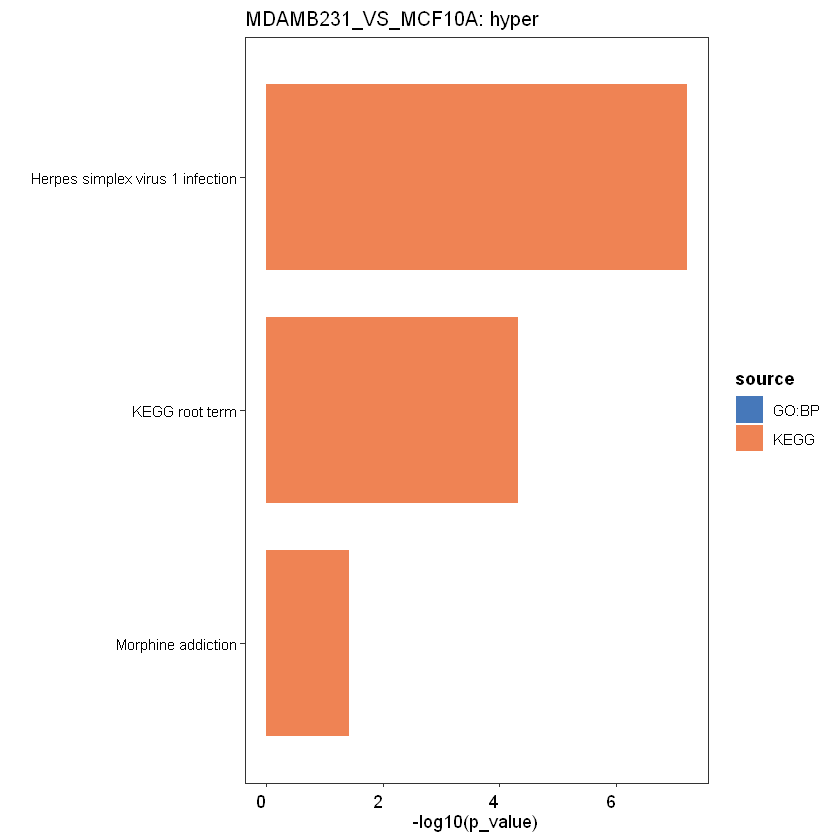

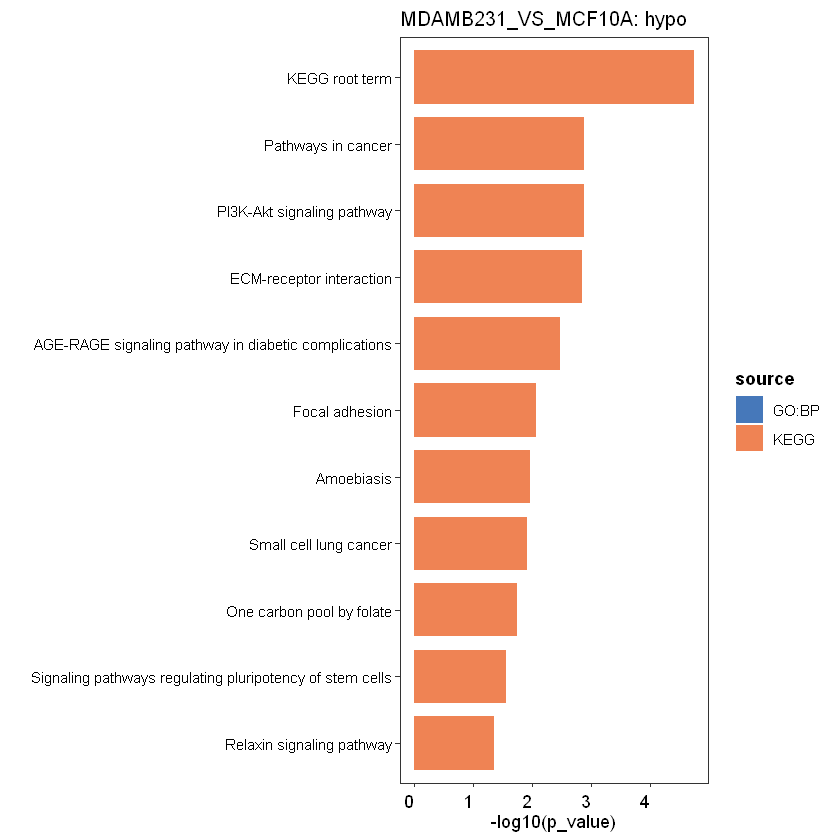

In [48]:
### term plot
library(ggplot2)

plot_gostres_func <- function(class, gostres, height = 7, width = 7){
    r <- gostres
    pp <- r[(r$source %in% c("KEGG")) , c("p_value", "term_name", "source")]
    order = pp$term_name[order(pp$p_value, decreasing=T)]
    pp$term_name <- factor(pp$term_name, levels = order)

    ggplot(pp, aes(x=term_name, y=-log10(p_value), fill=source)) +
      geom_bar(stat="identity", width = 0.8) +
      theme_bw() +
      theme(panel.grid = element_blank(),
            plot.title = element_text(hjust = 0, size = 12),
            axis.text.x  = element_text(angle = 0, hjust=1, vjust=0.5, 
                                        colour = "black", size = 11),
            axis.text.y  = element_text(colour = "black"),
            # legend.position = c(0.8,0.8),
            strip.background = element_rect(fill="white", colour = "black", size=1) ,
            legend.title = element_text(face="bold")) +
      # geom_text(aes(label=symbol), vjust=0.5, hjust=0,size=4, colour="black") +
      # annotate("text", x=pp$NAME[2], y=-1.5,size=3,
      #          label="nominal P values: \n*P < 0.05 \n**P < 0.005 \n***P < 0.0005 \nNS: not significant") +
      # scale_x_discrete(limits=c(pp$term.name))+
      scale_fill_manual(values=c("GO:BP"="#4678BA", "KEGG"="#EF8354")) +
      coord_flip() +
      xlab("") +
      ggtitle(paste0("MDAMB231_VS_MCF10A: ", class))
    # facet_grid(.~module, scales = "free_x", space = "free_x") 


#     ggsave(paste0("stat/", "MDAMB231_VS_MCF10A_", class, "_function_bar.pdf"),
#            height = height, width = width)

}


plot_gostres_func("hyper", gostres.list[["hyper"]], height = 7, width = 6)
plot_gostres_func("hypo", gostres.list[["hypo"]], height = 2, width = 6)

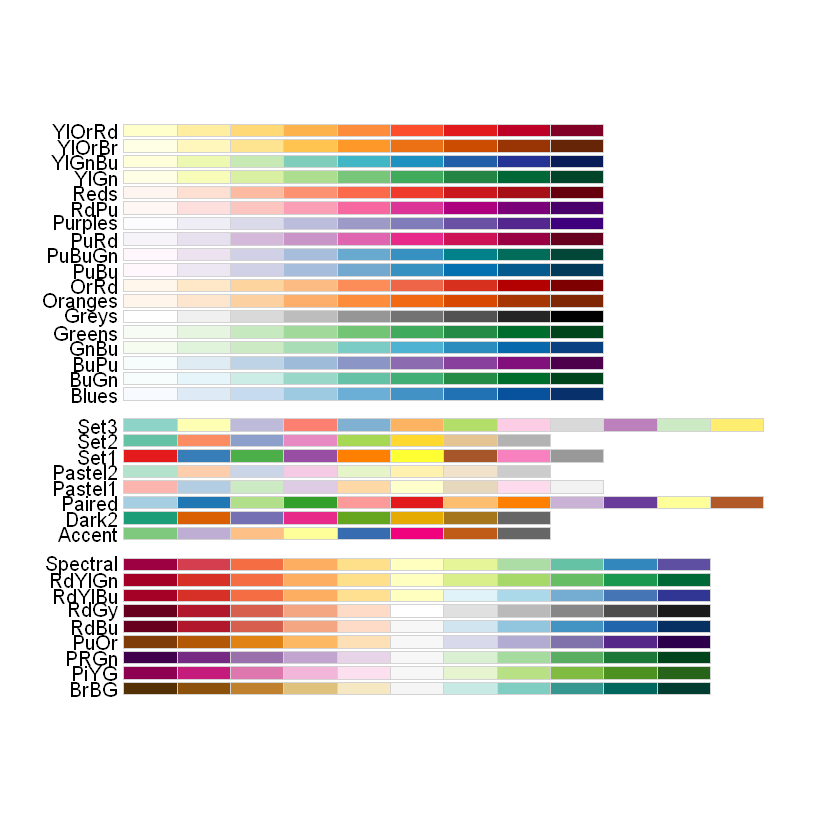

[1] "#FFF5EB" "#FEE6CE" "#FDD0A2" "#FDAE6B" "#FD8D3C" "#F16913" "#D94801"
[8] "#A63603" "#7F2704"

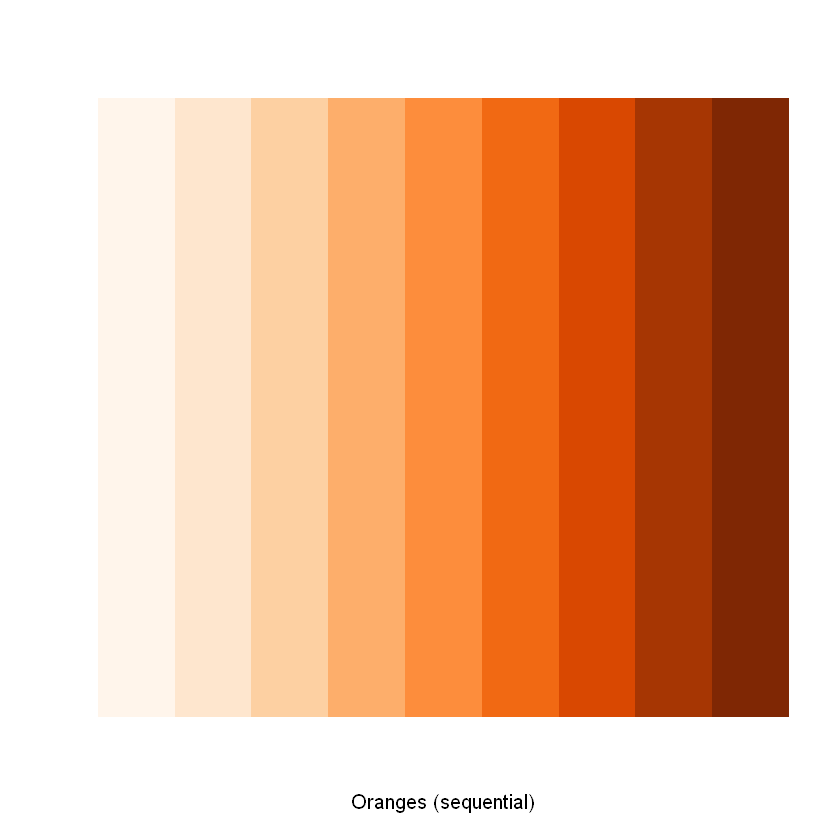

In [12]:
library(RColorBrewer)
# install.packages("RColorBrewer")

display.brewer.all()
display.brewer.pal(9, "Oranges")
brewer.pal(9, "Oranges")

### 肠癌

#### 差异分析

In [ ]:
library(DESeq2)
load("stat/hg38.quantify.FeatureCount.RData")
load("stat/hg38.gene.transcript.gtf.RData")


Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples
IDs <- Sample_info$Samples[(Sample_info$CellLine %in% c("HCT116", "NCM460")) & (Sample_info$SeqType %in% "sgRNA")]

# sgRNA count >= 3 at least three sample
sub.gene.count <- gene.count[, IDs]
logic <- apply(sub.gene.count, 1, function(x){sum(x >= 3)>=3})
sub.gene.count <- sub.gene.count[logic,]
dim(sub.gene.count) # 16558
sub.gene.count <- round(sub.gene.count)

# run DESeq2
colInfo <- Sample_info[IDs, c("CellLine"), drop=F]
dds <- DESeqDataSetFromMatrix(sub.gene.count, 
                                colInfo, 
                                ~CellLine)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
                )
gene.norlCount <- counts(Object, normalized=TRUE)
res <- results(Object, contrast=c("CellLine", "HCT116", "NCM460"))
# res <- res[complete.cases(res),]
# dif_res <- res
# dif_res <- res[res$padj<0.05 & abs(res$log2FoldChange)>1 & res$baseMean>10, ]

save(Object, gene.norlCount, res, file="stat/HCT116_vs_NCM460_gene_object.RData")



out_res <- data.frame(gene.norlCount, res[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
out_res$dif <- "ns"
out_res$dif[res$padj<0.05 & res$log2FoldChange>1] <- "Up"
out_res$dif[res$padj<0.05 & res$log2FoldChange < -1] <- "Down"
table(out_res$dif)
out_res <- out_res[order(out_res$dif, decreasing=T),]
out_res <- data.frame(gene_id=rownames(out_res), out_res)
out_res <- data.frame(out_res, gene_name=gene_gtf[rownames(out_res), "gene_name"])
gene_res <- out_res
# out_res <- gene_res[transcript_res$padj<0.05 & abs(transcript_res$log2FoldChange)>2 & transcript_res$baseMean>10, ]
# write.table(out_res, "stat/MDAMB231_vs_MCF10A_differential_genes.txt", row.names = F, col.names = T, quote = F, sep="\t")
write.table(out_res, "stat/HCT116_vs_NCM460_all_genes.txt", row.names = F, col.names = T, quote = F, sep="\t")



# Aseembly: stringTie 

## plotting assembly stat 

### sensitivity, precision and F1 score

In [1]:
setwd("/NAS/wg_looking/gRNA_ONT")

## assembly stat
IDs = c("sgRNA_HCT116", "totalRNA_HCT116", "sgRNA_NCM460", "totalRNA_NCM460", 
       "totalRNA_K562", "sgRNA_K562", "sgRNA_MDAMB231", "sgRNA_MCF10A")

# IDs = c("sgRNA_HCT116_NCM460")

# minCoverage
for(ID in IDs){
    statFile = paste0("stringtie_res5/", ID, ".gffcmp.stats_sensitivity_precision.txt")
    stat.tb <- read.table(statFile, header=T)
    Types <- c("Base_level", "Exon_level", "Transcript_level")
    pp <- stat.tb[stat.tb$Type %in% Types,]
    pp$Max <- pp$minCoverage
    for(Type in Types){
        tmp <- stat.tb[stat.tb$Type %in% Type & stat.tb$stats %in% "F1_score", ]
        cov <- tmp$minCoverage[tmp$Percent==max(tmp$Percent)]
        pp$Max[pp$Type %in% Type & !(pp$minCoverage %in% cov)] <- NA
    }

    pp$minCoverage <- factor(pp$minCoverage)
    ggplot(pp, aes(x=minCoverage, y=Percent, color=stats)) +
        geom_point()+
        scale_color_manual(values=c(F1_score="#4678BA", Sensitivity="#87B07A", Precision="#EF8354")) + 
        ggtitle(ID) +
        geom_vline(aes(xintercept = Max), linetype="dashed", color="red") +
        facet_wrap(~Type, nrow = 3) +
        # guides(color="none") +
        # ylab("F1 score") +
        theme_bw() +
        theme(
          panel.grid=element_blank(),
          axis.text.x = element_text(angle = 0, color = "black", 
                                     size = 8, hjust = 0.5),
          plot.title=element_text(size=10, face="bold", hjust=0.5)
        ) 

    ggsave(paste0("stat/", ID, ".stringtie.minCoverage.pdf"), width=6, height=6)



}


# gap length
for(ID in IDs){
    statFile = paste0("stringtie_res5/", ID, ".gap.gffcmp.stats_sensitivity_precision.txt")
    stat.tb <- read.table(statFile, header=T)
    Types <- c("Base_level", "Exon_level", "Transcript_level")
    pp <- stat.tb[stat.tb$Type %in% Types,]
    pp$Max <- pp$max_gap
    for(Type in Types){
        tmp <- stat.tb[stat.tb$Type %in% Type & stat.tb$stats %in% "F1_score", ]
        gap <- tmp$max_gap[tmp$Percent==max(tmp$Percent)]
        pp$Max[pp$Type %in% Type & !(pp$max_gap %in% gap)] <- NA
    }

    pp$max_gap <- factor(pp$max_gap)
    ggplot(pp, aes(x=max_gap, y=Percent, color=stats)) +
        geom_point()+
        scale_color_manual(values=c(F1_score="#4678BA", Sensitivity="#87B07A", Precision="#EF8354")) + 
        ggtitle(ID) +
        geom_vline(aes(xintercept = Max), linetype="dashed", color="red") +
        facet_wrap(~Type, nrow = 3) +
        # guides(color="none") +
        # ylab("F1 score") +
        theme_bw() +
        theme(
          panel.grid=element_blank(),
          axis.text.x = element_text(angle = 0, color = "black", 
                                     size = 8, hjust = 0.5),
          plot.title=element_text(size=10, face="bold", hjust=0.5)
        ) 

    ggsave(paste0("stat/", ID, ".stringtie.gap.pdf"), width=6, height=6)



}







Warning message in file(file, "rt"):
"无法打开文件'stringtie_res/totalRNA.gffcmp.stats_sensitivity_precision.txt': No such file or directory"


ERROR: Error in file(file, "rt"): 无法打开链结


### the count of assembly transcript 

#### minCoverage:1-19, gap=0

In [ ]:
library(data.table)
library(ggbreak)
setwd("/NAS/wg_looking/gRNA_ONT")


IDs = c("sgRNA_HCT116", "totalRNA_HCT116", 
        "sgRNA_NCM460", "totalRNA_NCM460", 
        "sgRNA_K562", "totalRNA_K562", 
        "sgRNA_MDAMB231", "sgRNA_MCF10A")

# IDs = c("sgRNA_HCT116_NCM460")

# minCoverage
count.list <- lapply(IDs, function(ID){
    c <- lapply(1:19, function(minCoverage){
        cellLine <- strsplit(ID, "_")[[1]][2]
        # tmap
        tmap <- paste0(ID, ".minCoverage_", minCoverage, ".", ID, ".minCoverage_", minCoverage, ".gtf.tmap")  
        tmap <- file.path("stringtie_res5", cellLine, tmap)
        tb <- read.table(tmap, header = T, stringsAsFactors = F)
        # new transcript with new junction
        bed <- paste0(ID, ".minCoverage_", minCoverage, ".annotated.intron.new.bed") 
        bed <- file.path("stringtie_res5", cellLine, bed)
        bed.tb <- read.table(bed, stringsAsFactors = F)
        splice_junction_id <- tstrsplit(bed.tb$V4, "[|]")[[3]]
        splice_junction_id <- unique(splice_junction_id)
        #
        tb$classification <- "other_exonic_overlap"
        tb$classification[tb$qry_id %in% splice_junction_id] <- "new_splice_junction"
        tb$classification[tb$class_code %in% "u"] <- "intergenic"
        tb$classification[tb$class_code %in% "i"] <- "intragenic"
        tb$classification[tb$class_code %in% c("c", "=")] <- "match_reference"
        code.tb <- data.frame(table(tb$classification))
        colnames(code.tb) <- c("classification", "Freq")
        code.tb <- data.frame(code.tb, minCoverage=minCoverage, ID=ID)
    })
    c <- rbindlist(c)  
})


pp <- rbindlist(count.list)


# cols <- c("#7DCE82", "#87B07A","#028090",  "#5AA9E6", "#4678BA", "#B3A394", 
#           "#FFE66D", "#F4B540", "#EF8354", "#ED6A5E", "#C95603", "#BA748A",  
#           "#AA4465", "#7D6185"
#           )


cols <- c("#F4B540", "#EF8354", "#4678BA", "#87B07A", "#BA748A")
names(cols) <- levels(pp$classification)

ggplot(pp, aes(x=minCoverage, y=Freq, color=classification)) +
    geom_line(size=1.5)+
    scale_color_manual(values=cols) + 
    ggtitle("") +
    # guides(color="none") +
    # ylab("F1 score") +
    # scale_y_break(c(20000, 80000), scales="0.5") +
    facet_wrap(~ID, nrow = 4, scales="free") +
    theme_classic() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5),
      # legend.position = "top",
      plot.title=element_text(size=10, face="bold", hjust=0.5)
    ) 

ggsave(paste0("stat/Assembly_classification_line.pdf"), width=12, height=12)


ggplot(pp, aes(x=minCoverage, y=Freq, color=classification)) +
    geom_line(size=1.5)+
    scale_color_manual(values=cols) + 
    ggtitle("") +
    # guides(color="none") +
    # ylab("F1 score") +
    # scale_y_break(c(20000, 80000), scales="0.5") +
    facet_wrap(~ID, nrow = 4, scales="free") +
    scale_y_log10() +
    theme_classic() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5),
      # legend.position = "top",
      plot.title=element_text(size=10, face="bold", hjust=0.5)
    ) 

ggsave(paste0("stat/Assembly_classification_line_log10.pdf"), width=12, height=12)


In [ ]:
tmp <- tb[,c(3, 4, 5, 6,9)]
tmp[tmp$qry_id %in% "STRG.171396.1",]
tmp[tmp$cov>3 & tmp$cov<5, ][100:110, ]


#### Max gap:0-50, coverage=5

In [ ]:
library(data.table)
library(ggbreak)
setwd("/NAS/wg_looking/gRNA_ONT")


IDs = c("sgRNA_HCT116", "totalRNA_HCT116", 
        "sgRNA_NCM460", "totalRNA_NCM460", 
        "sgRNA_K562", "totalRNA_K562", 
        "sgRNA_MDAMB231", "sgRNA_MCF10A")

# IDs = c("sgRNA_HCT116_NCM460")

# max gap
count.list <- lapply(IDs, function(ID){
    c <- lapply(seq(0,50,5), function(gap){
        cellLine <- strsplit(ID, "_")[[1]][2]
        # tmap
        tmap <- paste0(ID, ".minCoverage_5.gap_", gap, ".", ID, ".minCoverage_5.gap_", gap, ".gtf.tmap")  
        tmap <- file.path("stringtie_res5", cellLine, tmap)
        tb <- read.table(tmap, header = T, stringsAsFactors = F)
        # new transcript with new junction
        bed <- paste0(ID, ".minCoverage_5.gap_", gap, ".annotated.intron.new.bed") 
        bed <- file.path("stringtie_res5", cellLine, bed)
        bed.tb <- read.table(bed, stringsAsFactors = F)
        splice_junction_id <- tstrsplit(bed.tb$V4, "[|]")[[3]]
        splice_junction_id <- unique(splice_junction_id)
        #
        tb$classification <- "other_exonic_overlap"
        tb$classification[tb$qry_id %in% splice_junction_id] <- "new_splice_junction"
        tb$classification[tb$class_code %in% "u"] <- "intergenic"
        tb$classification[tb$class_code %in% "i"] <- "intragenic"
        tb$classification[tb$class_code %in% c("c", "=")] <- "match_reference"
        code.tb <- data.frame(table(tb$classification))
        colnames(code.tb) <- c("classification", "Freq")
        code.tb <- data.frame(code.tb, max_gap=gap, ID=ID)

    })
    c <- rbindlist(c)  
})


pp <- rbindlist(count.list)


cols <- c("#F4B540", "#EF8354", "#4678BA", "#87B07A", "#BA748A")
names(cols) <- levels(pp$classification)


ggplot(pp, aes(x=max_gap, y=Freq, color=classification)) +
    geom_line(size=1.5)+
    scale_color_manual(values=cols) + 
    ggtitle("") +
    # guides(color="none") +
    # ylab("F1 score") +
    # scale_y_break(c(20000, 80000), scales="0.5") +
    facet_wrap(~ID, nrow = 4, scales="free") +
    theme_classic() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5),
      # legend.position = "top",
      plot.title=element_text(size=10, face="bold", hjust=0.5)
    ) 

ggsave(paste0("stat/Assembly_max_gap_classification_line.pdf"), width=12, height=12)


ggplot(pp, aes(x=max_gap, y=Freq, color=classification)) +
    geom_line(size=1.5)+
    scale_color_manual(values=cols) + 
    ggtitle("") +
    # guides(color="none") +
    # ylab("F1 score") +
    # scale_y_break(c(20000, 80000), scales="0.5") +
    facet_wrap(~ID, nrow = 4, scales="free") +
    scale_y_log10() +
    theme_classic() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5),
      # legend.position = "top",
      plot.title=element_text(size=10, face="bold", hjust=0.5)
    ) 

ggsave(paste0("stat/Assembly_max_gap_classification_line_log10.pdf"), width=12, height=12)


#### minCoverage, gap=20

In [ ]:
library(data.table)
library(ggbreak)
setwd("/NAS/wg_looking/gRNA_ONT")


IDs = c("sgRNA_HCT116", "totalRNA_HCT116", 
        "sgRNA_NCM460", "totalRNA_NCM460", 
        "sgRNA_K562", "totalRNA_K562", 
        "sgRNA_MDAMB231", "sgRNA_MCF10A")

# IDs = c("sgRNA_HCT116_NCM460")

# max gap
count.list <- lapply(IDs, function(ID){
    c <- lapply(1:19, function(minCoverage){
        cellLine <- strsplit(ID, "_")[[1]][2]
        # tmap
        tmap <- paste0(ID, ".minCoverage_", minCoverage,".gap_20.", ID, ".minCoverage_", minCoverage,".gap_20.gtf.tmap")  
        tmap <- file.path("stringtie_res5", cellLine, tmap)
        tb <- read.table(tmap, header = T, stringsAsFactors = F)
        # new transcript with new junction
        bed <- paste0(ID, ".minCoverage_", minCoverage, ".gap_20.annotated.intron.new.bed") 
        bed <- file.path("stringtie_res5", cellLine, bed)
        bed.tb <- read.table(bed, stringsAsFactors = F)
        splice_junction_id <- tstrsplit(bed.tb$V4, "[|]")[[3]]
        splice_junction_id <- unique(splice_junction_id)
        #
        tb$classification <- "other_exonic_overlap"
        tb$classification[tb$qry_id %in% splice_junction_id] <- "new_splice_junction"
        tb$classification[tb$class_code %in% "u"] <- "intergenic"
        tb$classification[tb$class_code %in% "i"] <- "intragenic"
        tb$classification[tb$class_code %in% c("c", "=")] <- "match_reference"
        code.tb <- data.frame(table(tb$classification))
        colnames(code.tb) <- c("classification", "Freq")
        code.tb <- data.frame(code.tb, minCoverage=minCoverage, ID=ID)

    })
    c <- rbindlist(c)  
})


pp <- rbindlist(count.list)


cols <- c("#F4B540", "#EF8354", "#4678BA", "#87B07A", "#BA748A")
names(cols) <- levels(pp$classification)


ggplot(pp, aes(x=minCoverage, y=Freq, color=classification)) +
    geom_line(size=1.5)+
    scale_color_manual(values=cols) + 
    ggtitle("") +
    # guides(color="none") +
    # ylab("F1 score") +
    # scale_y_break(c(20000, 80000), scales="0.5") +
    facet_wrap(~ID, nrow = 4, scales="free") +
    theme_classic() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5),
      # legend.position = "top",
      plot.title=element_text(size=10, face="bold", hjust=0.5)
    ) 

ggsave(paste0("stat/Assembly_minCoverage_gap20_classification_line.pdf"), width=12, height=12)


ggplot(pp, aes(x=minCoverage, y=Freq, color=classification)) +
    geom_line(size=1.5)+
    scale_color_manual(values=cols) + 
    ggtitle("") +
    # guides(color="none") +
    # ylab("F1 score") +
    # scale_y_break(c(20000, 80000), scales="0.5") +
    facet_wrap(~ID, nrow = 4, scales="free") +
    scale_y_log10() +
    theme_classic() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5),
      # legend.position = "top",
      plot.title=element_text(size=10, face="bold", hjust=0.5)
    ) 

ggsave(paste0("stat/Assembly_minCoverage_gap20_classification_line_log10.pdf"), width=12, height=12)


## Assembly transcripts

### Function

#### Run RepeatMasker with assemly fa and loading RepeatMasker results

In [ ]:
RM_run_for_assemly_fa <- function(ID, gtfFile, outFa){
    gffread = "/NAS/wg_looking/Tools/gffread-0.12.7.Linux_x86_64/gffread"
    hg38_fasta = "/NAS/wg_looking/human_ref/GRCh38.p13.genome.fa"
    RepeatMasker = "/NAS/wg_looking/Tools/RepeatMasker/RepeatMasker"

    ## extract transcript fa 
    cmd = paste0(gffread, " -w ", outFa, " -g ", hg38_fasta, " ", gtfFile)
    system(cmd)


    ## run RepeatMasker
    cmd = paste0(RepeatMasker, " -pa 150 -a -species human ", outFa, " stat")
    system(cmd)
  
}

RM_results <- function(RM_file){
    library(biomartr)
    RM.tb <- read_rm(RM_file)
    RM.tb <- data.frame(RM.tb)
    RM.tb <- RM.tb[as.numeric(RM.tb$sw_score)>=225 & as.numeric(RM.tb$perc_div)<=18, ]
    # RM.tb <- RM.tb[RM.tb$matching_class %in% c("SINE/Alu", "LINE/L1"),]
    RM.tb <- RM.tb[grepl("L1HS", RM.tb$repeat_id) | 
                   grepl("L1P", RM.tb$repeat_id) | 
                   RM.tb$matching_class %in% c("SINE/Alu"), ]
    
}

####  plot TE driver

In [ ]:
### plot TE driver
trans_TE_func <- function(tb, totalTrans, ID, filename){
  library(ggplot2)
  library(dplyr)
  library(reshape2)
  library(scales)
  library(RColorBrewer)
  
  
  ###
  paste_fun <- function(x){
    # p <- paste0(x, collapse = ",")
    p <- paste0(unique(x), collapse = ",")
    return(p)}
  #
  
  tb <- tb[order(tb$qry_id, tb$matching_class), ]
  test <- aggregate(matching_class~qry_id,data=tb,FUN=paste_fun) 
  pp <- table(test$matching_class)
  p <- data.frame(pp)
  colnames(p)[1] <- "Type"
  p <- rbind(p, data.frame(Type="without", Freq=length(totalTrans)-dim(test)[1]))
  p$Percentage <- p$Freq/sum(p$Freq)*100
  
  
  ggplot(p, aes(x="", y=Percentage, fill=Type))+
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y", start=0) +
    scale_fill_manual(values = c("LINE/L1"="#EE9248", "without"="#EDC26D", 
                                 "SINE/Alu"="#5CB1DD", "LINE/L1,SINE/Alu"="#4A89D5"))+
    ggtitle(ID) + 
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.border = element_blank(),
      panel.grid=element_blank(),
      axis.ticks = element_blank(),
      plot.title=element_text(size=14, face="bold", hjust = 0.5)
    ) +
    theme(axis.text.x=element_blank())+
    geom_text(aes(x = 1.6, label = scales::percent(Percentage/100, accuracy = .1)), position = position_stack(vjust = .5))
  
  
  ggsave(filename, width = 6, height = 4)
  # ggsave("stat/sgRNA_TE_induced_new_trans.pdf", width = 6, height = 4)
  
 



 
  
}


### Main

#### loading data

In [ ]:
## loading gtf
gtf.list <- list(
    sgK562 = "stringtie_res5/K562/sgRNA_K562.minCoverage_5.gap_20.gtf",
    totalK562_1 = "stringtie_res5/K562/totalRNA_K562_1.minCoverage_5.gap_20.gtf",
    totalK562 = "stringtie_res5/K562/totalRNA_K562.minCoverage_5.gap_20.gtf",
    sgHCT116 = "stringtie_res5/HCT116/sgRNA_HCT116.minCoverage_5.gap_20.gtf",
    totalHCT116 = "stringtie_res5/HCT116/totalRNA_HCT116.minCoverage_5.gap_20.gtf",
    sgNCM460 = "stringtie_res5/NCM460/sgRNA_NCM460.minCoverage_5.gap_20.gtf",
    totalNCM460 = "stringtie_res5/NCM460/totalRNA_NCM460.minCoverage_5.gap_20.gtf",
    sgMDAMB231 = "stringtie_res5/MDAMB231/sgRNA_MDAMB231.minCoverage_5.gap_20.gtf",
    sgMCF10A = "stringtie_res5/MCF10A/sgRNA_MCF10A.minCoverage_5.gap_20.gtf"
)



gtf.tb.list <- lapply(gtf.list, function(gtfFile){
    sg.gtf <- rtracklayer::import(gtfFile)
    sg.gtf <- as.data.frame(sg.gtf)
    return(sg.gtf)
})



## loading RepeatMasker results
RM.tb.list <- lapply(setNames(names(gtf.list), names(gtf.list)), function(ID){
    # run RepeatMasker
    gtfFile = gtf.list[[ID]]
    outFa <- paste0("stat/", ID, "_assembly_transcripts.fa")
    RM_file <- paste0(outFa, ".out")
    if(!file.exists(RM_file)){ 
        print(RM_file)
        RM_run_for_assemly_fa(ID, gtfFile, outFa) 
    }
    # RM_run_for_assemly_fa(ID, gtfFile, outFa)
    
    # loading results
    if(file.exists(RM_file)){ 
        RM.tb <- RM_results(RM_file) 
    }
    
})



## loading TE annotation from hg38 genome 
library(bedtoolsr)
RM.tb <- RM_results("/NAS/wg_looking/human_ref/GRCh38.p13.genome.fa.out")
RM.bed <- RM.tb[, c("qry_id", "qry_start", "qry_end", "repeat_id", "matching_class")]

write.table(RM.bed, "stat/hg38.LINE.SINE.bed", quote=F, sep="\t", row.names=F, col.names=F)
write.table(RM.bed, "/NAS/wg_looking/human_ref/GRCh38.p13.genome.fa.TE.bed", quote=F, sep="\t", row.names=F, col.names=F)
save(RM.bed, file="stat/hg38.LINE.SINE.RData")


RM.tb.list2 <- lapply(setNames(names(gtf.tb.list), names(gtf.tb.list)), function(ID){
    # run RepeatMasker
    gtf_info = gtf.tb.list[[ID]]
    gtf_exon <- gtf_info[gtf_info$type %in% "exon", c("seqnames", "start", "end", "transcript_id", "type")]
    gtf_trans <- gtf_info[gtf_info$type %in% "transcript", ]
    gtf_TSS_TES <- lapply(1:dim(gtf_trans)[1], function(i){
        x <- gtf_trans[i, ]
        cname <- c("seqnames", "start", "end", "transcript_id", "type")
        if(x[5]=="*" | x[5]=="+"){
            TSS <- data.frame(seqnames=x["seqnames"], start=x["start"], end=x[2], 
                              transcript_id=x["transcript_id"], type="TSS")
            TES <- data.frame(seqnames=x["seqnames"], start=x["end"], end=x["end"],
                              transcript_id=x["transcript_id"], type="TES")  
        }else{
            TSS <- data.frame(seqnames=x["seqnames"], start=x["end"], end=x["end"],
                              transcript_id=x["transcript_id"], type="TSS")
            TES <- data.frame(seqnames=x["seqnames"], start=x["start"], end=x["start"], 
                              transcript_id=x["transcript_id"], type="TES")  
        }
        colnames(TSS) <- cname
        colnames(TES) <- cname
        
        return(list(TSS, TES))

    })
    
    gtf_TSS_TES <- rbindlist(lapply(gtf_TSS_TES, rbindlist))
    rownames(gtf_TSS_TES) <- NULL
    gtf_bed <- rbind(gtf_exon, gtf_TSS_TES)
  
    res <- bt.intersect(gtf_bed, RM.bed, wa=T, wb=T)
    
    return(res)
})





## loading compare
tmap_file.list <- list(
    K562=list(sg_vs_ref="stringtie_res5/K562/sgRNA_K562.minCoverage_5.gap_20.sgRNA_K562.minCoverage_5.gap_20.gtf.tmap",
              sg_vs_total="stringtie_res5/K562/sg_vs_total_K562.sgRNA_K562.minCoverage_5.gap_20.gtf.tmap",
              total_vs_ref="stringtie_res5/K562/totalRNA_K562_1.minCoverage_5.gap_20.totalRNA_K562_1.minCoverage_5.gap_20.gtf.tmap"),
    HCT116=list(sg_vs_ref="stringtie_res5/HCT116/sgRNA_HCT116.minCoverage_5.gap_20.sgRNA_HCT116.minCoverage_5.gap_20.gtf.tmap",
              sg_vs_total="stringtie_res5/HCT116/sg_vs_total_HCT116.sgRNA_HCT116.minCoverage_5.gap_20.gtf.tmap",
              total_vs_ref="stringtie_res5/HCT116/totalRNA_HCT116.minCoverage_5.gap_20.totalRNA_HCT116.minCoverage_5.gap_20.gtf.tmap"),
    NCM460=list(sg_vs_ref="stringtie_res5/NCM460/sgRNA_NCM460.minCoverage_5.gap_20.sgRNA_NCM460.minCoverage_5.gap_20.gtf.tmap",
              sg_vs_total="stringtie_res5/NCM460/sg_vs_total_NCM460.sgRNA_NCM460.minCoverage_5.gap_20.gtf.tmap",
              total_vs_ref="stringtie_res5/NCM460/totalRNA_NCM460.minCoverage_5.gap_20.totalRNA_NCM460.minCoverage_5.gap_20.gtf.tmap"),
    MDAMB231=list(sg_vs_ref="stringtie_res5/MDAMB231/sgRNA_MDAMB231.minCoverage_5.gap_20.sgRNA_MDAMB231.minCoverage_5.gap_20.gtf.tmap"),
    MCF10A=list(sg_vs_ref="stringtie_res5/MCF10A/sgRNA_MCF10A.minCoverage_5.gap_20.sgRNA_MCF10A.minCoverage_5.gap_20.gtf.tmap")
)

tmap.tb.list <- lapply(tmap_file.list, function(cellLine_list){
    tb.list <- lapply(cellLine_list, function(file){
        print(file)
        tb <- read.table(file, header = T, stringsAsFactors = F)
        tb <- tb[, -which(colnames(tb)%in%c("FPKM", "TPM", "cov"))]
    })
})



save(gtf.tb.list, RM.tb.list2, tmap.tb.list, 
     file="stat/assembly_preData.RData")


# # loading new splicing bed 
# bed.list <- list(
#     sgK562 = "stringtie_res5/K562/sgRNA_K562.minCoverage_5.gap_20.annotated.intron.new.bed",
#     totalK562 = "stringtie_res5/K562/totalRNA_K562.minCoverage_5.gap_20.annotated.intron.new.bed",
#     totalK562_1 = "stringtie_res5/K562/totalRNA_K562_1.minCoverage_5.gap_20.annotated.intron.new.bed",
#     sgHCT116 = "stringtie_res5/HCT116/sgRNA_HCT116.minCoverage_5.gap_20.annotated.intron.new.bed",
#     totalHCT116 = "stringtie_res5/HCT116/totalRNA_HCT116.minCoverage_5.gap_20.annotated.intron.new.bed",
#     sgNCM460 = "stringtie_res5/NCM460/sgRNA_NCM460.minCoverage_5.gap_20.annotated.intron.new.bed",
#     totalNCM460 = "stringtie_res5/NCM460/totalRNA_NCM460.minCoverage_5.gap_20.annotated.intron.new.bed",
#     sgMDAMB231 = "stringtie_res5/MDAMB231/sgRNA_MDAMB231.minCoverage_5.gap_20.annotated.intron.new.bed",
#     sgMCF10A = "stringtie_res5/MCF10A/sgRNA_MCF10A.minCoverage_5.gap_20.annotated.intron.new.bed"
# )

# new.splice.list <- lapply(bed.list, function(bed){
#     # bed <- paste0(ID, ".minCoverage_", minCoverage, ".gap_20.annotated.intron.new.bed") 
#     # bed <- file.path("stringtie_res5", cellLine, bed)
#     bed.tb <- read.table(bed, stringsAsFactors = F)
# })


# # loading intron retained bed
# bed.list2 <- list(
#     sgK562 = "stringtie_res5/K562/sgRNA_K562.minCoverage_5.gap_20.annotated.intron_retained.bed",
#     totalK562 = "stringtie_res5/K562/totalRNA_K562.minCoverage_5.gap_20.annotated.intron_retained.bed",
#     totalK562_1 = "stringtie_res5/K562/totalRNA_K562_1.minCoverage_5.gap_20.annotated.intron_retained.bed",
#     sgHCT116 = "stringtie_res5/HCT116/sgRNA_HCT116.minCoverage_5.gap_20.annotated.intron_retained.bed",
#     totalHCT116 = "stringtie_res5/HCT116/totalRNA_HCT116.minCoverage_5.gap_20.annotated.intron_retained.bed",
#     sgNCM460 = "stringtie_res5/NCM460/sgRNA_NCM460.minCoverage_5.gap_20.annotated.intron_retained.bed",
#     totalNCM460 = "stringtie_res5/NCM460/totalRNA_NCM460.minCoverage_5.gap_20.annotated.intron_retained.bed",
#     sgMDAMB231 = "stringtie_res5/MDAMB231/sgRNA_MDAMB231.minCoverage_5.gap_20.annotated.intron_retained.bed",
#     sgMCF10A = "stringtie_res5/MCF10A/sgRNA_MCF10A.minCoverage_5.gap_20.annotated.intron_retained.bed"
# )

# intron.retained.list <- lapply(bed.list2, function(bed){
#     # bed <- paste0(ID, ".minCoverage_", minCoverage, ".gap_20.annotated.intron.new.bed") 
#     # bed <- file.path("stringtie_res5", cellLine, bed)
#     bed.tb <- read.table(bed, stringsAsFactors = F)
# })




#### K562: sg VS total

In [1]:

## new transcripts from totalRNA
totalDiff_func <- function(cellLine, tmap.tb.list, RM.tb.list){
    #
    total_ref.tb <- tmap.tb.list[[cellLine]][["total_vs_ref"]]
    total_ref.tb <- total_ref.tb[!(total_ref.tb$class_code %in% c("=", "c")),]
    # excluding possible false positives
    total_ref.tb <- total_ref.tb[!(total_ref.tb$class_code %in% c("e", "s", "x", "p")),]

    #
    total_ref.tb$classification <- "other"
    total_ref.tb$classification[total_ref.tb$class_code %in% "j"] <- "new_splicing"
    total_ref.tb$classification[total_ref.tb$class_code %in% c("m", "n")] <- "intron_retained"
    total_ref.tb$classification[total_ref.tb$class_code %in% c("o", "y", "k")] <- "span_intergenic_and_genic"
    total_ref.tb$classification[total_ref.tb$class_code %in% "u"] <- "intergenic"
    total_ref.tb$classification[total_ref.tb$class_code %in% "i"] <- "intronic"
    # total_ref.tb$classification[total_ref.tb$class_code %in% c("c", "=")] <- "match_reference"

    #
    if(cellLine=="K562"){
        RM.totalRNA <- RM.tb.list[[paste0("total", cellLine, "_1")]]
    }else{
        RM.totalRNA <- RM.tb.list[[paste0("total", cellLine)]]}
    RM.totalRNA <- RM.totalRNA[, 4:10]
    colnames(RM.totalRNA) <- c("qry_id", "type", "TE_chr", "TE_start", "TE_end", "repeat_id", "matching_class")
    
    total_ref.tb.merge <- merge(total_ref.tb, RM.totalRNA, by="qry_id")
    # total_ref.tb.merge <- total_ref.tb.merge[, c("qry_id", "qry_start", "qry_end", "qry_left", 
    #                                            "repeat_id", "matching_class", "classification")]
    return(list(total_ref.tb, total_ref.tb.merge))
}



## new transcripts from sgRNA
sgDiff_func <- function(cellLine, tmap.tb.list, RM.tb.list, hg38.gtf){
    ref.tb <- tmap.tb.list[[cellLine]][["sg_vs_ref"]]
    # if("TRUE" %in% grepl("total",names(tmap.tb.list[[cellLine]]))){
    #     total.tb <- tmap.tb.list[[cellLine]][["sg_vs_total"]]
    #     merge.tb <- merge(ref.tb, total.tb, by=c("qry_gene_id", "qry_id", "num_exons", "len", "major_iso_id"), 
    #                       suffixes=c(".ref", ".total"))
    #     diff.tb <- merge.tb[!(merge.tb$class_code.ref %in%  c("=", "c")),]
    # }else{
    #     diff.tb <- ref.tb[!(ref.tb$class_code %in%  c("=", "c")),]
    #     diff.tb$class_code.ref <- diff.tb$class_code
    #     diff.tb$class_code.total <- NA
    # }
    diff.tb <- ref.tb[!(ref.tb$class_code %in%  c("=", "c")),]
    #
    # excluding possible false positives
    diff.tb <- diff.tb[!(diff.tb$class_code %in% c("e", "s", "x", "p")),]
    #
    diff.tb$classification <- "other"
    diff.tb$classification[diff.tb$class_code %in% "j"] <- "new_splicing"
    diff.tb$classification[diff.tb$class_code %in% c("m", "n")] <- "intron_retained"
    diff.tb$classification[diff.tb$class_code %in% c("o", "y", "k")] <- "span_intergenic_and_genic"
    diff.tb$classification[diff.tb$class_code %in% "u"] <- "intergenic"
    diff.tb$classification[diff.tb$class_code %in% "i"] <- "intronic"
    
    
    ## gene_name anno
    trans_gtf <- hg38.gtf[hg38.gtf$type %in% "transcript", ]
    rownames(trans_gtf) <- trans_gtf$transcript_id
    diff.tb$gene_name <- trans_gtf[diff.tb$ref_id, "gene_name"]
    # diff.tb1 <- diff.tb[diff.tb$num_exons>1,]
    # table(diff.tb$class_code.ref, diff.tb$class_code.total)
    # table(diff.tb1$class_code.ref, diff.tb1$class_code.total)
    #
    
    RM.sgRNA <- RM.tb.list[[paste0("sg", cellLine)]]
    RM.sgRNA <- RM.sgRNA[, 4:10]
    colnames(RM.sgRNA) <- c("qry_id", "type", "TE_chr", "TE_start", "TE_end", "repeat_id", "matching_class")
    RM.sgRNA$TE_name <- paste0(paste(RM.sgRNA$TE_chr, RM.sgRNA$TE_start, RM.sgRNA$TE_end, sep="_"), ":", RM.sgRNA$repeat_id)
    diff.tb.merge1 <- merge(diff.tb, RM.sgRNA, by="qry_id")
    diff.tb.merge2 <- merge(diff.tb, RM.sgRNA, by="qry_id", all.x=T)
    # diff.tb.merge <- diff.tb.merge[, c("qry_id", "qry_start", "qry_end", "qry_left","repeat_id", 
    #                                    "matching_class", "classification", "class_code.total")]
    return(list(diff.tb, diff.tb.merge1, diff.tb.merge2))
}




ERROR: Error in library(bedtoolsr): 不存在叫'bedtoolsr'这个名字的程辑包


In [ ]:
library(bedtoolsr)
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/assembly_preData.RData")
load("stat/TE_location.RData")
load("stat/hg38.gtf.RData")


# run
cellLine <- "K562"
totalDiff <- totalDiff_func(cellLine, tmap.tb.list, RM.tb.list2)
sgDiff <- sgDiff_func(cellLine, tmap.tb.list, RM.tb.list2, hg38.gtf)
save(sgDiff, totalDiff, file="stat/K562_Diff.RData")


load("stat/K562_Diff.RData")
trans_TE_func(totalDiff[[2]], totalDiff[[1]]$qry_id, "totalRNA_K562_1", 
              paste0("stat/", cellLine, "_totalRNA_TE_induced_new_trans2.pdf")) # plot
trans_TE_func(sgDiff[[2]], sgDiff[[1]]$qry_id, "sgRNA_K562_1", 
              paste0("stat/", cellLine, "_sgRNA_TE_induced_new_trans2.pdf")) # plot


## Supplementary Table 2
out <- sgDiff[[1]]
out <- out[, c("qry_id", "classification", "class_code", "ref_gene_id", "gene_name")]
out$ref_gene_id[out$ref_gene_id =="-"] <- NA
gtf.tb <- gtf.tb.list[["sgK562"]]
gtf.tb <- gtf.tb[gtf.tb$type %in% "transcript", c("seqnames", "start", "end", "strand", "transcript_id")]
colnames(gtf.tb)[c(1, 5)] <- c("chrom", "qry_id")
out <- merge(gtf.tb, out, by="qry_id")
length(unique(out$qry_id)) # 18298

diff.tb.merge <- sgDiff[[2]]
qry_ids_terminal_TE <- unique(diff.tb.merge$qry_id[(diff.tb.merge$type %in% c("TES", "TSS"))])
qry_ids_internal_TE <- setdiff(diff.tb.merge$qry_id, qry_ids_terminal_TE)
qry_ids_ALU <- unique(diff.tb.merge$qry_id[(diff.tb.merge$matching_class %in% c("SINE/Alu"))])
qry_ids_L1 <-  unique(diff.tb.merge$qry_id[(diff.tb.merge$matching_class %in% c("LINE/L1"))])

out$TE_location <- "Without"
out$TE_location[out$qry_id %in% qry_ids_terminal_TE] <- "Terminal"
out$TE_location[out$qry_id %in% qry_ids_internal_TE] <- "Internal"
out$TE_type <- "None"
out$TE_type[out$qry_id %in% qry_ids_ALU] <- "Alu"
out$TE_type[out$qry_id %in% qry_ids_L1] <- "L1"
out$TE_type[(out$qry_id %in% qry_ids_ALU) & (out$qry_id %in% qry_ids_L1)] <- "Alu&L1"


colnames(out) <- c("New Transcript ID", "Chrom", "Start", "End", "Strand", 
                   "Classification", "Class Code", "Reference Gene ID", "Reference Gene Name",
                  "TE Location", "TE Type")
out <- out[order(out[, "New Transcript ID"]), ]

write.table(out, "stat/Supplementary.Table.2.the_information_of_new_transcripts_of_K562_by_capTEs.txt",
           row.names=F, col.names=T, sep="\t", quote=F)





## Supplementary Table 3
out <- totalDiff[[1]]
trans_gtf <- hg38.gtf[hg38.gtf$type %in% "transcript", ]
rownames(trans_gtf) <- trans_gtf$transcript_id
out$gene_name <- trans_gtf[out$ref_id, "gene_name"]

out <- out[, c("qry_id", "classification", "class_code", "ref_gene_id", "gene_name")]
out$ref_gene_id[out$ref_gene_id =="-"] <- NA
gtf.tb <- gtf.tb.list[["totalK562_1"]]
gtf.tb <- gtf.tb[gtf.tb$type %in% "transcript", c("seqnames", "start", "end", "strand", "transcript_id")]
colnames(gtf.tb)[c(1, 5)] <- c("chrom", "qry_id")
out <- merge(gtf.tb, out, by="qry_id")
length(unique(out$qry_id)) # 18298


diff.tb.merge <- totalDiff[[2]]
qry_ids_terminal_TE <- unique(diff.tb.merge$qry_id[(diff.tb.merge$type %in% c("TES", "TSS"))])
qry_ids_internal_TE <- setdiff(diff.tb.merge$qry_id, qry_ids_terminal_TE)
qry_ids_ALU <- unique(diff.tb.merge$qry_id[(diff.tb.merge$matching_class %in% c("SINE/Alu"))])
qry_ids_L1 <-  unique(diff.tb.merge$qry_id[(diff.tb.merge$matching_class %in% c("LINE/L1"))])

out$TE_location <- "Without"
out$TE_location[out$qry_id %in% qry_ids_terminal_TE] <- "Terminal"
out$TE_location[out$qry_id %in% qry_ids_internal_TE] <- "Internal"
out$TE_type <- "None"
out$TE_type[out$qry_id %in% qry_ids_ALU] <- "Alu"
out$TE_type[out$qry_id %in% qry_ids_L1] <- "L1"
out$TE_type[(out$qry_id %in% qry_ids_ALU) & (out$qry_id %in% qry_ids_L1)] <- "Alu&L1"


colnames(out) <- c("New Transcript ID", "Chrom", "Start", "End", "Strand", 
                   "Classification", "Class Code", "Reference Gene ID", "Reference Gene Name",
                  "TE Location", "TE Type")
out <- out[order(out[, "New Transcript ID"]), ]

write.table(out, "stat/Supplementary.Table.3.the_information_of_new_transcripts_of_K562_by_totalRNA.txt",
           row.names=F, col.names=T, sep="\t", quote=F)



In [ ]:
load("stat/hg38.gtf.RData")
hg38.gtf.gene <- hg38.gtf[hg38.gtf$type %in% "gene", ]
rownames(hg38.gtf.gene) <- hg38.gtf.gene$gene_id

tb <- sgDiff[[2]]
tb$gene_name <- hg38.gtf.gene[tb$ref_gene_id.ref, "gene_name"]
tb <- tb[order(tb$classification, tb$type),]

write.table(tb, "stat/k562_new_trans_with_TE.txt", quote=F, sep="\t", row.names=F, col.names=T)


In [ ]:
# the percentage of newTrans classification

t1 <- data.frame(table(sgDiff[[1]]$classification), type="sgRNA")
t2 <- data.frame(table(totalDiff[[1]]$classification), type="totalRNA")
pp <- rbind(t1,t2)
colnames(pp)[1] <- "classification"
# p <- pp %>%
#   group_by(type) %>%
#   mutate(Percentage = Freq / sum(Freq)*100)
p <- ddply(pp, .(type), mutate, Percentage = Freq / sum(Freq) * 100)

cols <- c("#F4B540", "#EF8354", "#BA748A", "#7BB274", "#5AA9E6", "#4678BA")
names(cols) <- levels(pp$classification)


ggplot(p, aes(x=type, y=Percentage, fill=classification)) +
    geom_bar(stat="identity")+
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~class, nrow = 2, scales="free") +
    scale_fill_manual(values = cols) +
    ggtitle(cellLine)
  
ggsave(paste0("stat/", cellLine, "_newTrans_classification_pct.pdf"),
         width = 4, height = 5)
  



In [54]:
# the percentage/Freq of TE-newTrans classification
load("stat/K562_Diff.RData")

classification_stat <- function(Diff, SeqType){
    alu_id <- unique(Diff[[2]]$qry_id[Diff[[2]]$matching_class %in% "SINE/Alu"])
    L1_id <- unique(Diff[[2]]$qry_id[Diff[[2]]$matching_class %in% "LINE/L1"])
    # only Alu
    t1 <- Diff[[1]][Diff[[1]]$qry_id %in% setdiff(alu_id, L1_id),]
    t1 <- data.frame(table(t1$classification), repeat_class="Alu")
    # only L1
    t2 <- Diff[[1]][Diff[[1]]$qry_id %in% setdiff(L1_id, alu_id),]
    t2 <- data.frame(table(t2$classification), repeat_class="L1")
    # Alu&L1
    t3 <- Diff[[1]][Diff[[1]]$qry_id %in% intersect(L1_id, alu_id),]
    t3 <- data.frame(table(t3$classification), repeat_class="Alu&L1")
    #
    t <- rbindlist(list(t1,t2,t3))
    t <- data.frame(t, SeqType=SeqType)
    return(t)

}


pp <- rbind(classification_stat(sgDiff, "sgRNA"),
            classification_stat(totalDiff, "totalRNA"))

colnames(pp)[1] <- "classification"
p <- aggregate(Freq~SeqType+classification, data=pp, sum)
# p <- ddply(pp, .(SeqType, repeat_class), mutate, Percentage = Freq / sum(Freq) * 100)

cols <- c("#EE9248", "#EDC26D", "#8C9FCA", "#5CB1DD", "#4A89D5")
names(cols) <- c("intronic", "intron_retained", "new_splicing", 
                 "span_intergenic_and_genic", "intergenic")


# freq plot
p <- p[order(p$SeqType, p$repeat_class, p$Freq, decreasing=F), ]
p$SeqType <- factor(p$SeqType, levels=c("totalRNA", "sgRNA"))
p$classification <- factor(p$classification, levels=rev(c("intronic", "intron_retained", "new_splicing", 
                                                      "span_intergenic_and_genic", 
                                                      "intergenic")))
ggplot(p, aes(x=SeqType, y=Freq, fill=classification)) +
    geom_bar(stat="identity",  position=position_dodge())+
    theme_classic() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    coord_flip() +
    # facet_wrap(~repeat_class, nrow = 1, scales="free") +
    scale_fill_manual(values = cols) +
    ggtitle(paste0(cellLine, ": TE-transcripts"))
  
ggsave(paste0("stat/Fig2D.", cellLine, "_newTrans_with_TE_classification_Freq.pdf"),
         width = 10, height = 5)
  



# ggplot(p, aes(x=SeqType, y=Percentage, fill=classification)) +
#     geom_bar(stat="identity")+
#     theme_bw() +
#     theme(
#       panel.grid=element_blank(),
#       axis.text.x = element_text(angle = 0, color = "black", 
#                                  size = 8, hjust = 0.5, vjust=0.5),
#       plot.title=element_text(size=14, face="bold")
#     ) +
#     # facet_wrap(~repeat_class, nrow = 1, scales="free") +
#     scale_fill_manual(values = cols) +
#     ggtitle(paste0(cellLine, ": TE-transcripts"))
  
# ggsave(paste0("stat/", cellLine, "_newTrans_with_TE_classification_pct.pdf"),
#          width = 7, height = 5)
 
# pie
p2 <- aggregate(Freq~SeqType+classification, data=p, sum)
p2 <- ddply(p2, .(SeqType), mutate, Percentage = Freq / sum(Freq) * 100)
p2$SeqType <- factor(p2$SeqType, levels=rev(c("totalRNA", "sgRNA")))
p$classification <- factor(p$classification, levels=rev(c("intronic", "intron_retained", "new_splicing", 
                                                      "span_intergenic_and_genic", 
                                                      "intergenic")))

ggplot(p2, aes(x="", y=Percentage, fill=classification))+
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y", start=0) +
    scale_fill_manual(values = cols)+
    # ggtitle(ID) + 
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.border = element_blank(),
      panel.grid=element_blank(),
      axis.ticks = element_blank(),
      axis.text.x=element_blank(),
      plot.title=element_text(size=14, face="bold", hjust = 0.5)
    ) +
    facet_wrap(~SeqType, nrow=2) + 
    geom_text(aes(x = 1.6, label = scales::percent(Percentage/100, accuracy = .1)), position = position_stack(vjust = .5))

ggsave(paste0("stat/", cellLine, "_newTrans_with_TE_classification_pct.pdf"),
         width = 4.5, height = 6)
 



ERROR: Error in unique(Diff[[2]]$qry_id[Diff[[2]]$matching_class %in% "SINE/Alu"]): 找不到对象'sgDiff'


In [ ]:
# The percentage of new transcripts classied by TE location

load("stat/K562_Diff.RData") # sgDiff, totalDiff
cellLine <- "K562"
class_codes <- c("intronic", "intron_retained", "new_splicing", 
                 "span_intergenic_and_genic", "intergenic")


p <- lapply(class_codes, function(code){
    # sgRNA
    diff.tb <- sgDiff[[1]]
    diff.tb.merge <- sgDiff[[2]]
    qry_ids <- diff.tb$qry_id[diff.tb$classification %in% code]
    qry_ids <- unique(qry_ids)
    #
    qry_ids_TE <- diff.tb.merge$qry_id[diff.tb.merge$classification %in% code]
    qry_ids_TE <- unique(qry_ids_TE)
    #
#     left <- diff.tb.merge$qry_left
#     left <- gsub("\\)", "", gsub("\\(", "", left))
#     diff.tb.merge$left <- as.integer(left)

#     qry_ids_terminal_TE <- unique(diff.tb.merge$qry_id[diff.tb.merge$classification %in% code & 
#                                                        (diff.tb.merge$qry_start<=5 | diff.tb.merge$left<=5)])
    
    qry_ids_terminal_TE <- unique(diff.tb.merge$qry_id[diff.tb.merge$classification %in% code & 
                                                       (diff.tb.merge$type %in% c("TES", "TSS"))])
    d1 <- c(without_TE=length(qry_ids)-length(qry_ids_TE),
           terminal_TE=length(qry_ids_terminal_TE),
           internal_TE=length(qry_ids_TE)-length(qry_ids_terminal_TE))
    
    # totalRNA
    total_ref.tb <-  totalDiff[[1]]
    total_ref.tb.merge <- totalDiff[[2]]
    qry_ids <- unique(total_ref.tb$qry_id[total_ref.tb$classification %in% code])
    qry_ids_TE <- unique(total_ref.tb.merge$qry_id[total_ref.tb.merge$classification %in% code])
    # left <- total_ref.tb.merge$qry_left
    # left <- gsub("\\)", "", gsub("\\(", "", left))
    # total_ref.tb.merge$left <- as.integer(left)
    # qry_ids_terminal_TE <- unique(total_ref.tb.merge$qry_id[total_ref.tb.merge$classification %in% code & 
    #                                          (total_ref.tb.merge$qry_start<=5 | total_ref.tb.merge$left<=5)])
    qry_ids_terminal_TE <- unique(total_ref.tb.merge$qry_id[total_ref.tb.merge$classification %in% code & 
                                             (total_ref.tb.merge$type %in% c("TES", "TSS"))])
    d2 <- c(without_TE=length(qry_ids)-length(qry_ids_TE),
            terminal_TE=length(qry_ids_terminal_TE),
            internal_TE=length(qry_ids_TE)-length(qry_ids_terminal_TE))
    
    #
    d <- data.frame(rbind(d1,d2), 
                    type=c("sgRNA", "totalRNA"),
                    class_code=code)

    return(d)
})


pp <- rbindlist(p)
pp <- melt(pp)
pp <- ddply(pp, .(type, class_code), mutate, Percentage = value / sum(value)*100)


cols <- c("#4678BA", "#FFE66D", "#EF8354")
ggplot(pp, aes(x=type, y=Percentage, fill=variable)) +
    geom_bar(stat="identity")+
    theme_bw() +
    theme(
        legend.position="bottom",
        panel.grid=element_blank(),
        axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
        plot.title=element_text(size=14, face="bold")
    ) +
    facet_wrap(~class_code, nrow = 1, scales="free") +
    scale_fill_manual(values = cols) +
    ggtitle(cellLine)

ggsave(paste0("stat/Fig4S.A.", cellLine, "_newTrans_classification_TE_location_in_trans_pct.pdf"),
         width = 10, height = 5)




In [1]:
# The percentage of new transcripts classied by TE location

load("stat/K562_Diff.RData") # sgDiff, totalDiff
cellLine <- "K562"
class_codes <- c("intergenic", "intronic","new_splicing",
                 "intron_retained", "new_splicing_&_intron_retained", "other")


p <- lapply(class_codes, function(code){
    # sgRNA
    diff.tb <- sgDiff[[1]]
    diff.tb.merge <- sgDiff[[2]]
    qry_ids <- diff.tb$qry_id[diff.tb$classification %in% code]
    qry_ids <- unique(qry_ids)
    #
    qry_ids_TE <- diff.tb.merge$qry_id[diff.tb.merge$classification %in% code]
    qry_ids_TE <- unique(qry_ids_TE)
    #
#     left <- diff.tb.merge$qry_left
#     left <- gsub("\\)", "", gsub("\\(", "", left))
#     diff.tb.merge$left <- as.integer(left)

#     qry_ids_terminal_TE <- unique(diff.tb.merge$qry_id[diff.tb.merge$classification %in% code & 
#                                                        (diff.tb.merge$qry_start<=5 | diff.tb.merge$left<=5)])
    
    qry_ids_terminal_TE <- unique(diff.tb.merge$qry_id[diff.tb.merge$classification %in% code & 
                                                       (diff.tb.merge$type %in% c("TES", "TSS"))])
    d1 <- c(without_TE=length(qry_ids)-length(qry_ids_TE),
           terminal_TE=length(qry_ids_terminal_TE),
           internal_TE=length(qry_ids_TE)-length(qry_ids_terminal_TE))
    
    # totalRNA
    total_ref.tb <-  totalDiff[[1]]
    total_ref.tb.merge <- totalDiff[[2]]
    qry_ids <- unique(total_ref.tb$qry_id[total_ref.tb$classification %in% code])
    qry_ids_TE <- unique(total_ref.tb.merge$qry_id[total_ref.tb.merge$classification %in% code])
    # left <- total_ref.tb.merge$qry_left
    # left <- gsub("\\)", "", gsub("\\(", "", left))
    # total_ref.tb.merge$left <- as.integer(left)
    # qry_ids_terminal_TE <- unique(total_ref.tb.merge$qry_id[total_ref.tb.merge$classification %in% code & 
    #                                          (total_ref.tb.merge$qry_start<=5 | total_ref.tb.merge$left<=5)])
    qry_ids_terminal_TE <- unique(total_ref.tb.merge$qry_id[total_ref.tb.merge$classification %in% code & 
                                             (total_ref.tb.merge$type %in% c("TES", "TSS"))])
    d2 <- c(without_TE=length(qry_ids)-length(qry_ids_TE),
            terminal_TE=length(qry_ids_terminal_TE),
            internal_TE=length(qry_ids_TE)-length(qry_ids_terminal_TE))
    
    #
    d <- data.frame(rbind(d1,d2), 
                    type=c("sgRNA", "totalRNA"),
                    class_code=code)

    return(d)
})


pp <- rbindlist(p)
pp <- melt(pp)
pp <- ddply(pp, .(type, class_code), mutate, Percentage = value / sum(value)*100)


cols <- c("#4678BA", "#FFE66D", "#EF8354")
ggplot(pp, aes(x=type, y=Percentage, fill=variable)) +
    geom_bar(stat="identity")+
    theme_bw() +
    theme(
        legend.position="bottom",
        panel.grid=element_blank(),
        axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
        plot.title=element_text(size=14, face="bold")
    ) +
    facet_wrap(~class_code, nrow = 1, scales="free") +
    scale_fill_manual(values = cols) +
    ggtitle(cellLine)

ggsave(paste0("stat/", cellLine, "_newTrans_classification_TE_pct.pdf"),
         width = 10, height = 5)




Warning message in readChar(con, 5L, useBytes = TRUE):
"无法打开压缩文件'stat/K562_Diff.RData'，可能是因为'No such file or directory'"


ERROR: Error in readChar(con, 5L, useBytes = TRUE): 无法打开链结


In [ ]:
# The percentage of new transcripts classied by TE type

load("stat/K562_Diff.RData") # sgDiff, totalDiff
cellLine <- "K562"
class_codes <- c("intronic", "intron_retained", "new_splicing", "span_intergenic_and_genic",  "intergenic")


p <- lapply(class_codes, function(code){
    # sgRNA
    diff.tb <- sgDiff[[1]]
    diff.tb.merge <- sgDiff[[2]]
    qry_ids <- diff.tb$qry_id[diff.tb$classification %in% code]
    qry_ids <- unique(qry_ids)
    #
    qry_ids_TE <- unique(diff.tb.merge$qry_id[diff.tb.merge$classification %in% code])
    qry_Alu_id <- diff.tb.merge$qry_id[diff.tb.merge$classification %in% code &
                                      diff.tb.merge$matching_class %in% "SINE/Alu"]
    qry_Alu_id <- unique(qry_Alu_id)
    qry_L1_id <- diff.tb.merge$qry_id[diff.tb.merge$classification %in% code &
                                      diff.tb.merge$matching_class %in% "LINE/L1"]
    qry_L1_id <- unique(qry_L1_id)
    Alu_L1 <- intersect(qry_Alu_id, qry_L1_id)
    
    d1 <- c(without_TE=length(qry_ids)-length(qry_ids_TE),
            Alu=length(setdiff(qry_Alu_id,Alu_L1)),
            L1=length(setdiff(qry_L1_id,Alu_L1)), 
            "Alu&L1"=length(Alu_L1))
    
    # totalRNA
    total_ref.tb <-  totalDiff[[1]]
    total_ref.tb.merge <- totalDiff[[2]]
    qry_ids <- unique(total_ref.tb$qry_id[total_ref.tb$classification %in% code])
    qry_ids_TE <- unique(total_ref.tb.merge$qry_id[total_ref.tb.merge$classification %in% code])
    qry_Alu_id <- total_ref.tb.merge$qry_id[total_ref.tb.merge$classification %in% code &
                                      total_ref.tb.merge$matching_class %in% "SINE/Alu"]
    qry_Alu_id <- unique(qry_Alu_id)
    qry_L1_id <- total_ref.tb.merge$qry_id[total_ref.tb.merge$classification %in% code &
                                      total_ref.tb.merge$matching_class %in% "LINE/L1"]
    qry_L1_id <- unique(qry_L1_id)
    Alu_L1 <- intersect(qry_Alu_id, qry_L1_id)
    
    d2 <- c(without_TE=length(qry_ids)-length(qry_ids_TE),
            Alu=length(setdiff(qry_Alu_id,Alu_L1)),
            L1=length(setdiff(qry_L1_id,Alu_L1)), 
            "Alu&L1"=length(Alu_L1))
    
    #
    d <- data.frame(rbind(d1,d2), 
                    type=c("sgRNA", "totalRNA"),
                    class_code=code)

    return(d)
})


pp <- rbindlist(p)
pp <- melt(pp)
pp <- ddply(pp, .(type, class_code), mutate, Percentage = value / sum(value)*100)


cols <- c("#4678BA", "#FFE66D", "#BA748A", "#EF8354")
cols <- c("L1"="#EE9248", "without_TE"="#EDC26D", 
 "Alu"="#5CB1DD", "Alu.L1"="#4A89D5")

ggplot(pp, aes(x=class_code, y=Percentage, fill=variable)) +
    geom_bar(stat="identity")+
    theme_bw() +
    theme(
        legend.position="bottom",
        panel.grid=element_blank(),
        axis.text.x = element_text(angle = 30, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
        plot.title=element_text(size=14, face="bold")
    ) +
    facet_wrap(~type, nrow = 1, scales="free") +
    scale_fill_manual(values = cols) +
    ggtitle(cellLine)

ggsave(paste0("stat/Fig2E.", cellLine, "_newTrans_classification_Alu_L1_pct.pdf"),
         width = 8, height = 5)




##### the distribution of new transcript length

In [ ]:
library(patchwork)
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/assembly_preData.RData")
load("stat/K562_Diff.RData")


names <- c("sgK562", "totalK562_1")
transcript_length <- lapply(setNames(names, names), function(ID){
    assemblyFa <- paste0("stat/", ID, "_assembly_transcripts.fa")
    length_txt <- paste0(assemblyFa, ".length")
    cmd <- paste0("/NAS/wg_looking/Tools/seqkit fx2tab ", assemblyFa, " -l -H -i -n > ", length_txt)
    system(cmd)
    L <- read.table(length_txt, stringsAsFactors=F)
    colnames(L) <- c("qry_id", "length")
    rownames(L) <- L$qry_id
    
    return(L)
})


## sgRNA
tb <- sgDiff[[1]][sgDiff[[1]]$qry_id %in% sgDiff[[2]]$qry_id, ]
tb.length <- merge(tb, transcript_length[["sgK562"]], by="qry_id")

cols <- c("#F4B540", "#EF8354", "#BA748A", "#7BB274", "#5AA9E6", "#4678BA")
names(cols) <- unique(tb.length$classification)
p1 <- ggplot(tb.length, aes(x=length,  color=classification)) +
    geom_density(size=2) + 
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 30, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    scale_color_manual(values = cols) +
    scale_x_log10() +
    ggtitle("K562: sgRNA") 
  
# ggsave(paste0("stat/sgK562_new_trans_length_density.pdf"),
#       width=9, height=5)



## totalRNA
tb <- totalDiff[[1]][totalDiff[[1]]$qry_id %in% totalDiff[[2]]$qry_id, ]
tb.length <- merge(tb, transcript_length[["sgK562"]], by="qry_id")

p2 <- ggplot(tb.length, aes(x=length,  color=classification)) +
    geom_density(size=2) + 
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 30, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    scale_color_manual(values = cols) +
    scale_x_log10() +
    ggtitle("K562: totalRNA") 
  
# ggsave(paste0("stat/totalK562_new_trans_length_density.pdf"),
#       width=9, height=5)



p <- p1 + p2 + plot_layout(ncol = 1, heights = c(1, 1))


ggsave(paste0("stat/K562_new_trans_length_density.pdf"),
      width=9, height=8)

##### new transcripts: intersect between sgRNA and totalRNA

In [ ]:
# new transcripts: intersect between sgRNA and totalRNA
library(bedtoolsr)
load("stat/assembly_preData.RData")
load("stat/K562_Diff.RData") # sgDiff, totalDiff

cellLine <- "K562"

tmap.tb <- tmap.tb.list[["K562"]][["sg_vs_total"]]
tmap.tb <- tmap.tb[!(tmap.tb$class_code %in% c("u", "i", "p")), ]


class_codes <- c("intergenic","new_splicing","intragenic",
                 "intron_retained", "new_splicing_&_intron_retained", "other")

num.list <- lapply(class_codes, function(code){
    sg.diff.merge <- sgDiff[[2]]
    total.diff.merge <- totalDiff[[2]]
    sg.diff.merge <- sg.diff.merge[sg.diff.merge$classification %in% code,]
    total.diff.merge <- total.diff.merge[total.diff.merge$classification %in% code, ]
    # overlap
    sg.overlap <- unique(sg.diff.merge$qry_id[sg.diff.merge$qry_id %in% tmap.tb$qry_id])
    total.overlap <- unique(total.diff.merge$qry_id[total.diff.merge$qry_id %in% tmap.tb$ref_id])

    # sg.overlap <- unique(sg.diff.merge$qry_id[!(sg.diff.merge$class_code.total %in% c("u", "i", "p"))])
    # total.overlap <- unique(sgDiff[[1]]$ref_id.total[!(sgDiff[[1]]$class_code.total %in% c("u", "i", "p")) &
    #                     sgDiff[[1]]$ref_id.total %in% total.diff.merge$qry_id])
    # sg specific
    sg.specific <- unique(sg.diff.merge$qry_id[!(sg.diff.merge$qry_id %in% sg.overlap)])
    # total specific
    total.specific <- unique(total.diff.merge$qry_id[!(total.diff.merge$qry_id %in% total.overlap)])
    #
    data.frame(sg.overlap=length(sg.overlap),
              total.overlap=length(total.overlap),
              sg.specific=length(sg.specific),
              total.specific=length(total.specific),
              CellLine=cellLine,
              Classfication=code)

})


pp.num <- rbindlist(num.list)
pp <- melt(pp.num)
pp <- pp[order(pp$value, pp$Classfication, decreasing=T),]
pp$Classfication <- factor(pp$Classfication, levels=as.character(unique(pp$Classfication)))


ggplot(pp, aes(x=Classfication, y=value,  fill=variable)) +
    geom_bar(stat="identity", position=position_dodge()) + 
    geom_text(aes(label=value), position=position_dodge(width=0.9), vjust=-0.25) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 30, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_fill_manual(values = c("#4678BA", "#FFE66D", "#EF8354", "#7BB274")) +
    ggtitle("") 
  
ggsave(paste0("stat/", cellLine, "_new_trans_sgRNA_vs_totalRNA.pdf"),
      width=10, height=5)





for(code in class_codes){
    
    # plot venn
#     library(VennDiagram)
#     require(gridExtra)
    
    # pdf(paste0("stat/", cellLine, "_", code, "_new_trans_sgRNA_vs_totalRNA.pdf"))
#     g <- draw.pairwise.venn(area1=length(sg.specific), 
#                        area2=length(sg.overlap), 
#                        cross.area=length(common.id), 
#                        category = c("sgRNA","totalRNA"),
#                        col = c("#4678BA", "#FDA56C"), 
#                        fill = c("#4678BA", "#FDA56C"),
#                        main = cellLine,
#                        lwd = c(3,3),
#                        cex=c(3,3,3),
#                        cat.cex =c(3,3),
#                        cat.pos=c(-10,10),
#                        alpha = rep(0.8, 2))
    
#     pdf(paste0("stat/", cellLine, "_", code, "_new_trans_sgRNA_vs_totalRNA.pdf"))
#     grid.arrange(gTree(children=g), 
#                  top=textGrob(cellLine, gp=gpar(fontsize=30)), 
#                  bottom=textGrob(code, gp=gpar(fontsize=30)))
#     dev.off()  

}





In [ ]:
###
# library(pheatmap)
# pp <- table(diff.tb$class_code.ref, diff.tb$class_code.total)
# pp <- as.matrix(pp)
# pheatmap(pp,
#          display_numbers=T,
#          number_format="%i",
#          main="New transcripts type",
#          # col=colorRampPalette(rev(brewer.pal(11,"RdBu")[1:5]))(1000),
#          col=c("#F7F7F7", colorRampPalette(c("#F4B540", "#FDA56C","#EF8354"))(1000)),
#          fontsize=12,
#          border="white",
#          # show_rownames=F,
#          # show_colnames=F,
#          cluster_rows=F,
#          cluster_cols=F,
#          width=6.5,
#          height=6,
#          filename="stat/K562_new_trans_type_heatmap.pdf")




##### polyIII: Alu elements

In [ ]:
library(bedtoolsr)
load("stat/K562_Diff.RData") # sgDiff, totalDiff

cellLine <- "K562"


ploy3.bed <- read.table("/NAS/wg_looking/gRNA_ONT/database/expressed_Alu_elements_ZhangXiaoOu.sorted.bed")

# sgRNA
sg.gtf <- gtf.tb[[paste0("sg", cellLine)]]
sg.gtf.bed <- sg.gtf[sg.gtf$type=="transcript", c("seqnames", "start", "end", "transcript_id")]
sg.gtf.bed <- sg.gtf.bed[sg.gtf.bed$transcript_id %in% sgDiff[[2]]$qry_id, ]
tb <- sgDiff[[1]][, c("qry_id", "classification.ref")]
rownames(tb) <- tb$qry_id
sg.gtf.bed <- data.frame(sg.gtf.bed, tb[sg.gtf.bed$transcript_id, "classification.ref"])
sg.res <- bt.intersect(sg.gtf.bed, ploy3.bed, wa=T)
table(sg.res$V5)

# total
total.gtf <- gtf.tb[[paste0("total", cellLine)]]
total.gtf.bed <- total.gtf[total.gtf$type=="transcript", c("seqnames", "start", "end", "transcript_id")]
total.gtf.bed <- total.gtf.bed[total.gtf.bed$transcript_id %in% totalDiff[[2]]$qry_id, ]
tb <- totalDiff[[1]][, c("qry_id", "classification")]
rownames(tb) <- tb$qry_id
total.gtf.bed <- data.frame(total.gtf.bed, tb[total.gtf.bed$transcript_id, "classification"])
total.res <- bt.intersect(total.gtf.bed, ploy3.bed, wa=T)
table(total.res$V5)





#### HCT116 vs NCM460

In [ ]:
load("stat/hg38.gtf.RData")
load("stat/assembly_preData.RData") # gtf.tb, RM.tb.list, tmap.tb.list, new.splice.list, intron.retained.list
HCT116_Diff <- sgDiff_func("HCT116", tmap.tb.list, RM.tb.list2, hg38.gtf)
NCM460_Diff <- sgDiff_func("NCM460", tmap.tb.list, RM.tb.list2, hg38.gtf)
save(HCT116_Diff, NCM460_Diff, file="stat/HCT116_NCM460_diff.Data")
write.table(HCT116_Diff[[3]], "stat/HCT116_new_transcript_annotation.txt", sep="\t", quote=F, col.names=T, row.names=F)
write.table(NCM460_Diff[[3]], "stat/NCM460_new_transcript_annotation.txt", sep="\t", quote=F, col.names=T, row.names=F)




# plot
trans_TE_func(HCT116_Diff[[2]], HCT116_Diff[[1]]$qry_id, "HCT116", paste0("stat/HCT116_sgRNA_TE_induced_new_trans.pdf")) # plot
trans_TE_func(NCM460_Diff[[2]], NCM460_Diff[[1]]$qry_id, "NCM460", paste0("stat/NCM460_sgRNA_TE_induced_new_trans.pdf")) # plot



t1 <- data.frame(table(HCT116_Diff[[1]]$classification.ref), type="HCT116")
t2 <- data.frame(table(NCM460_Diff[[1]]$classification.ref), type="NCM460")
pp <- rbind(t1,t2)
colnames(pp)[1] <- "classification"
p <- ddply(pp, .(type), mutate, Percentage = Freq / sum(Freq) * 100)


cols <- c("#F4B540", "#EF8354", "#4678BA", "#87B07A")
names(cols) <- levels(p$classification)


ggplot(p, aes(x=type, y=Percentage, fill=classification)) +
    geom_bar(stat="identity")+
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~class, nrow = 2, scales="free") +
    scale_fill_manual(values = cols) +
    ggtitle("HCT116 vs NCM460")
  
ggsave(paste0("stat/HCT116_vs_NCM460_newTrans_classification_pct.pdf"),
         width = 4, height = 5)
  

p <- p[order(p$type, p$Freq, decreasing=T), ]
p$classification <- factor(p$classification, levels=p$classification[1:4])
ggplot(p, aes(x=classification, y=Freq, fill=type)) +
    geom_bar(stat="identity", position=position_dodge())+
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 30, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~class, nrow = 2, scales="free") +
    scale_fill_manual(values = c("#4678BA", "#FDA56C")) +
    ggtitle("HCT116 vs NCM460")
  
ggsave(paste0("stat/HCT116_vs_NCM460_newTrans_classification_pct_bar.pdf"),
         width = 6, height = 5)





##### new transcripts: intersect 

In [ ]:
# new transcripts: intersect between sgRNA and totalRNA
library(bedtoolsr)
load("stat/HCT116_NCM460_diff.Data") # HCT116_Diff, NCM460_Diff


tmap <- "stringtie_res5/HCT116/sgHCT116_vs_sgNCM460.sgRNA_HCT116.minCoverage_5.gap_20.gtf.tmap"
tmap.tb <- read.table(tmap, header = T, stringsAsFactors = F)
tmap.tb <- tmap.tb[, -which(colnames(tmap.tb)%in%c("FPKM", "TPM", "cov"))]
tmap.tb <- tmap.tb[!(tmap.tb$class_code %in% c("u", "i", "p")), ]


class_codes <- c("intergenic","new_splicing","intragenic",
                 "intron_retained", "new_splicing_&_intron_retained", "other")

num.list <- lapply(class_codes, function(code){
    HCT116.diff.merge <- HCT116_Diff[[2]]
    NCM460.diff.merge <- NCM460_Diff[[2]]
    HCT116.diff.merge <- HCT116.diff.merge[HCT116.diff.merge$classification %in% code,]
    NCM460.diff.merge <- NCM460.diff.merge[NCM460.diff.merge$classification %in% code, ]
    # overlap
    HCT116.overlap <- unique(HCT116.diff.merge$qry_id[HCT116.diff.merge$qry_id %in% tmap.tb$qry_id])
    NCM460.overlap <- unique(NCM460.diff.merge$qry_id[NCM460.diff.merge$qry_id %in% tmap.tb$ref_id])
    # HCT116 specific
    HCT116.specific <- unique(HCT116.diff.merge$qry_id[!(HCT116.diff.merge$qry_id %in% HCT116.overlap)])
    # NCM460 specific
    NCM460.specific <- unique(NCM460.diff.merge$qry_id[!(NCM460.diff.merge$qry_id %in% NCM460.overlap)])
    #
    data.frame(HCT116.overlap=length(HCT116.overlap),
              NCM460.overlap=length(NCM460.overlap),
              HCT116.specific=length(HCT116.specific),
              NCM460.specific=length(NCM460.specific),
              Classfication=code)

})


pp.num <- rbindlist(num.list)
pp <- melt(pp.num)
pp <- pp[order(pp$value, pp$Classfication, decreasing=T),]
pp$Classfication <- factor(pp$Classfication, levels=as.character(unique(pp$Classfication)))


ggplot(pp, aes(x=Classfication, y=value,  fill=variable)) +
    geom_bar(stat="identity", position=position_dodge()) + 
    geom_text(aes(label=value), position=position_dodge(width=0.9), vjust=-0.25) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 30, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    # facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_fill_manual(values = c("#4678BA", "#FFE66D", "#EF8354", "#7BB274")) +
    ggtitle("HCT116 vs NCM460") 
  
ggsave(paste0("stat/HCT116_vs_NCM460_new_trans_intersect.pdf"),
      width=10, height=5)








#### MDA-MB-231 vs MCF-10A

In [ ]:
load("stat/hg38.gtf.RData")
load("stat/assembly_preData.RData") # gtf.tb, RM.tb.list, tmap.tb.list, new.splice.list, intron.retained.list
MDAMB231_Diff <- sgDiff_func("MDAMB231", tmap.tb.list , RM.tb.list2, hg38.gtf)
MCF10A_Diff <- sgDiff_func("MCF10A", tmap.tb.list , RM.tb.list2, hg38.gtf)

save(MDAMB231_Diff, MCF10A_Diff, file="stat/MDAMB231_MCF10A_diff.Data")


write.table(MDAMB231_Diff[[3]], "stat/MDAMB231_new_transcript_annotation.txt", sep="\t", quote=F, col.names=T, row.names=F)
write.table(MCF10A_Diff[[3]], "stat/MCF10A_new_transcript_annotation.txt", sep="\t", quote=F, col.names=T, row.names=F)




In [ ]:
# the percentage/Freq of TE-newTrans classification

classification_stat <- function(Diff, SeqType){
    alu_id <- unique(Diff[[2]]$qry_id[Diff[[2]]$matching_class %in% "SINE/Alu"])
    L1_id <- unique(Diff[[2]]$qry_id[Diff[[2]]$matching_class %in% "LINE/L1"])
    # only Alu
    t1 <- Diff[[1]][Diff[[1]]$qry_id %in% setdiff(alu_id, L1_id),]
    t1 <- data.frame(table(t1$classification), repeat_class="Alu")
    # only L1
    t2 <- Diff[[1]][Diff[[1]]$qry_id %in% setdiff(L1_id, alu_id),]
    t2 <- data.frame(table(t2$classification), repeat_class="L1")
    # Alu&L1
    t3 <- Diff[[1]][Diff[[1]]$qry_id %in% intersect(L1_id, alu_id),]
    t3 <- data.frame(table(t3$classification), repeat_class="Alu&L1")
    #
    t <- rbindlist(list(t1,t2,t3))
    t <- data.frame(t, SeqType=SeqType)
    return(t)

}


pp <- rbind(classification_stat(MDAMB231_Diff, "MDAMB231"),
            classification_stat(MCF10A_Diff, "MCF10A"))
colnames(pp)[1] <- "classification"
p <- aggregate(Freq~SeqType+classification, data=pp, sum)
# p <- ddply(pp, .(SeqType, classification), mutate, Count = sum(Freq) * 100)

cols <- c("#F4B540", "#EF8354", "#BA748A", "#7BB274", "#5AA9E6")
names(cols) <- c("intronic", "intron_retained", "new_splicing", 
                 "span_intergenic_and_genic", "intergenic")



# freq plot
p <- p[order(p$SeqType, p$Freq, decreasing=F), ]
p$SeqType <- factor(p$SeqType, levels=c("MCF10A", "MDAMB231"))
p$classification <- factor(p$classification, levels=rev(c("intronic", "intron_retained", "new_splicing", 
                                                      "span_intergenic_and_genic", 
                                                      "intergenic")))
ggplot(p, aes(x=SeqType, y=Freq, fill=classification)) +
    geom_bar(stat="identity",  position=position_dodge())+
    theme_classic() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    coord_flip() +
    # facet_wrap(~repeat_class, nrow = 1, scales="free") +
    scale_fill_manual(values = cols) +
    ggtitle(paste0(cellLine, ": TE-transcripts"))
  
ggsave(paste0("stat/MDAMB231_vs_MCF10A_newTrans_with_TE_classification_Freq.pdf"),
         width = 10, height = 5)
  


# pie
p2 <- aggregate(Freq~SeqType+classification, data=p, sum)
p2 <- ddply(p2, .(SeqType), mutate, Percentage = Freq / sum(Freq) * 100)
p2$SeqType <- factor(p2$SeqType, levels=rev(c("totalRNA", "sgRNA")))
p2$classification <- factor(p2$classification, levels=rev(c("intronic", "intron_retained", "new_splicing", 
                                                      "span_intergenic_and_genic", 
                                                      "intergenic")))

ggplot(p2, aes(x="", y=Percentage, fill=classification))+
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y", start=0) +
    scale_fill_manual(values = cols)+
    # ggtitle(ID) + 
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.border = element_blank(),
      panel.grid=element_blank(),
      axis.ticks = element_blank(),
      axis.text.x=element_blank(),
      plot.title=element_text(size=14, face="bold", hjust = 0.5)
    ) +
    facet_wrap(~SeqType, nrow=2) + 
    geom_text(aes(x = 1.6, label = scales::percent(Percentage/100, accuracy = .1)), position = position_stack(vjust = .5))

ggsave(paste0("stat/", cellLine, "_newTrans_with_TE_classification_pct.pdf"),
         width = 4.5, height = 6)
 



In [ ]:
library(bedtoolsr)
load("stat/MDAMB231_MCF10A_diff.Data") # MDAMB231_Diff, MCF10A_Diff


tmap <- "stringtie_res5/MDAMB231/sgMDAMB231_vs_sgMCF10A.sgRNA_MDAMB231.minCoverage_5.gap_20.gtf.tmap"
tmap.tb <- read.table(tmap, header = T, stringsAsFactors = F)
tmap.tb <- tmap.tb[, -which(colnames(tmap.tb)%in%c("FPKM", "TPM", "cov"))]
tmap.tb <- tmap.tb[!(tmap.tb$class_code %in% c("u", "i", "p")), ]


class_codes <- c("intergenic","new_splicing","intragenic",
                 "intron_retained", "new_splicing_&_intron_retained", "other")

num.list <- lapply(class_codes, function(code){
    MDAMB231.diff.merge <- MDAMB231_Diff[[2]]
    MCF10A.diff.merge <- MCF10A_Diff[[2]]
    MDAMB231.diff.merge <- MDAMB231.diff.merge[MDAMB231.diff.merge$classification %in% code,]
    MCF10A.diff.merge <- MCF10A.diff.merge[MCF10A.diff.merge$classification %in% code, ]
    # overlap
    MDAMB231.overlap <- unique(MDAMB231.diff.merge$qry_id[MDAMB231.diff.merge$qry_id %in% tmap.tb$qry_id])
    MCF10A.overlap <- unique(MCF10A.diff.merge$qry_id[MCF10A.diff.merge$qry_id %in% tmap.tb$ref_id])
    # MDAMB231 specific
    MDAMB231.specific <- unique(MDAMB231.diff.merge$qry_id[!(MDAMB231.diff.merge$qry_id %in% MDAMB231.overlap)])
    # MCF10A specific
    MCF10A.specific <- unique(MCF10A.diff.merge$qry_id[!(MCF10A.diff.merge$qry_id %in% MCF10A.overlap)])
    #
    data.frame(MDAMB231.overlap=length(MDAMB231.overlap),
              MCF10A.overlap=length(MCF10A.overlap),
              MDAMB231.specific=length(MDAMB231.specific),
              MCF10A.specific=length(MCF10A.specific),
              Classfication=code)

})


pp.num <- rbindlist(num.list)
pp <- melt(pp.num)
pp <- pp[order(pp$value, pp$Classfication, decreasing=T),]
pp$Classfication <- factor(pp$Classfication, levels=as.character(unique(pp$Classfication)))


ggplot(pp, aes(x=Classfication, y=value,  fill=variable)) +
    geom_bar(stat="identity", position=position_dodge()) + 
    geom_text(aes(label=value), position=position_dodge(width=0.9), vjust=-0.25) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 30, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    # facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_fill_manual(values = c("#4678BA", "#FFE66D", "#EF8354", "#7BB274")) +
    ggtitle("MDAMB231 vs MCF10A") 
  
ggsave(paste0("stat/MDAMB231_vs_MCF10A_new_trans_intersect.pdf"),
      width=10, height=5)








#### 细胞系之间的共性和差异性

In [ ]:
library(ggplot2)
library(ggvenn)
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/MDAMB231_MCF10A_diff.Data") # MDAMB231_Diff, MCF10A_Diff
load("stat/HCT116_NCM460_diff.Data") # HCT116_Diff, NCM460_Diff


class_codes <- c("new_splicing","intronic", "intron_retained", "new_splicing_&_intron_retained", "other")
Diff_list <- list(HCT116=HCT116_Diff, NCM460=NCM460_Diff,
                  MDAMB231=MDAMB231_Diff, MCF10A=MCF10A_Diff)
for(code in class_codes){
    overlap.genes <- lapply(Diff_list, function(Diff){
        tb <- Diff[[1]]
        tb.TE <- Diff[[2]]
        sub.tb <- tb[tb$classification %in% code &
                    tb$qry_id %in% tb.TE$qry_id, ]
        if("ref_gene_id" %in% colnames(sub.tb)){
            gene_ids <- unique(sub.tb$ref_gene_id)
        }else{
            gene_ids <- unique(sub.tb$ref_gene_id.ref)
        }
        
        return(gene_ids)
    })
    
    
     # plot
    ggvenn(overlap.genes, 
           fill_color = c("#4678BA", "#EF8354", "#87B07A", "#F4B540"),
           stroke_color = NA,
           fill_alpha = 0.8,
           stroke_size = 0.5, 
           set_name_size = 4,
           show_outside = "always"
    ) + 
    ggtitle(code) +
    theme(
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) 
    
    
#     ggsave(paste0('stat/', code, '_', TE, '_coding_gene_venn.pdf'),
#            width=10, height=5)
       ggsave(paste0('stat/', code, '_TE_newTrans_overlapped_genes_venn.pdf'),
           width=10, height=5)

    
}












In [ ]:
load("stat/MDAMB231_MCF10A_diff.Data") # MDAMB231_Diff, MCF10A_Diff
load("stat/HCT116_NCM460_diff.Data") # HCT116_Diff, NCM460_Diff


## Supplementary Table 7
Diff_list <- list()
Diff_list[["MDAMB231"]] <- MDAMB231_Diff
Diff_list[["MCF10A"]] <- MCF10A_Diff
Diff_list[["HCT116"]] <- HCT116_Diff
Diff_list[["NCM460"]] <- NCM460_Diff

f <- lapply(names(Diff_list), function(CellLine){
    out <- Diff_list[[CellLine]][[1]]
    out <- out[, c("qry_id", "classification", "class_code", "ref_gene_id", "gene_name")]
    out$ref_gene_id[out$ref_gene_id =="-"] <- NA
    gtf.tb <- gtf.tb.list[["sgK562"]]
    gtf.tb <- gtf.tb[gtf.tb$type %in% "transcript", c("seqnames", "start", "end", "strand", "transcript_id")]
    colnames(gtf.tb)[c(1, 5)] <- c("chrom", "qry_id")
    out <- merge(gtf.tb, out, by="qry_id")
    length(unique(out$qry_id)) # 18298

    diff.tb.merge <- Diff_list[[CellLine]][[2]]
    qry_ids_terminal_TE <- unique(diff.tb.merge$qry_id[(diff.tb.merge$type %in% c("TES", "TSS"))])
    qry_ids_internal_TE <- setdiff(diff.tb.merge$qry_id, qry_ids_terminal_TE)
    qry_ids_ALU <- unique(diff.tb.merge$qry_id[(diff.tb.merge$matching_class %in% c("SINE/Alu"))])
    qry_ids_L1 <-  unique(diff.tb.merge$qry_id[(diff.tb.merge$matching_class %in% c("LINE/L1"))])

    out$TE_location <- "Without"
    out$TE_location[out$qry_id %in% qry_ids_terminal_TE] <- "Terminal"
    out$TE_location[out$qry_id %in% qry_ids_internal_TE] <- "Internal"
    out$TE_type <- "None"
    out$TE_type[out$qry_id %in% qry_ids_ALU] <- "Alu"
    out$TE_type[out$qry_id %in% qry_ids_L1] <- "L1"
    out$TE_type[(out$qry_id %in% qry_ids_ALU) & (out$qry_id %in% qry_ids_L1)] <- "Alu&L1"


    colnames(out) <- c("New Transcript ID", "Chrom", "Start", "End", "Strand", 
                       "Classification", "Class Code", "Reference Gene ID", "Reference Gene Name",
                      "TE Location", "TE Type")
    out <- out[order(out[, "New Transcript ID"]), ]
    out <- data.frame(CellLine=CellLine, out)

})

out <- rbindlist(f)
write.table(out, "stat/Supplementary.Table.7.the_information_of_new_transcripts_of_CRC_BC_by_capTEs.txt",
           row.names=F, col.names=T, sep="\t", quote=F)




# non-ref TE insertion 

## K562

In [1]:
IDs <- c("sgRNA_K562_1", "totalRNA_K562_1")
TE_insertion_info <- lapply(IDs, function(ID){
    a <- lapply(c("ALU", "LINE"), function(TE){
        file <- file.path(ID, "PALMER_res", TE, paste0(ID, ".PALMER.", TE, "_calls.txt"))
        tb <- read.table(file, header=T, stringsAsFactors = F)
        bed1 <- tb[, c("chr", "start1", "end1", "cluster_id", "Potential_supporting_reads")]
        colnames(bed1)[1:3] <- c("chrom", "start", "end")
        bed2 <- tb[, c("chr", "start2", "end2", "cluster_id", "Potential_supporting_reads")]
        colnames(bed2)[1:3] <- c("chrom", "start", "end")
        bed <- data.frame(rbind(bed1, bed2), ID=ID, TE=TE)
        bed <- bed[order(bed$Potential_supporting_reads, decreasing=T),]
        bed <- bed[order(bed$chr, bed$start),]
        bed$insertion_site <- paste(bed$chrom, bed$start, bed$end, sep="_")
        bed <- bed[!duplicated(bed$insertion_site),]

        
        b <- lapply(3:10, function(SR){
            s <- sum(bed$Potential_supporting_reads>=SR)
            s <- data.frame(supporting_reads=SR, count=s)
            return(s)
        })
        
        b <- rbindlist(b)
        b <- data.frame(b, TE=TE, ID=ID)
        
        return(b) 
    })
    
    a <- rbindlist(a)
})


pp <- rbindlist(TE_insertion_info)


ggplot(pp, aes(x=factor(supporting_reads), y=count, fill=ID)) +
    geom_bar(stat="identity", position=position_dodge())+
    scale_fill_manual(values=c("#4A89D5", "#EE9248")) + 
    # ggtitle(ID) +
    facet_wrap(~TE, nrow = 1, scales="free") +
    # guides(color="none") +
    ylab("the count of non-ref TE insertion") +
    theme_bw() +
    theme(
        panel.grid=element_blank(),
        axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5),
        plot.title=element_text(size=10, face="bold", hjust=0.5),
        legend.position = "bottom"
    ) +
    xlab("supporting reads (>=)")

ggsave(paste0("stat/Fig3S.E.sg_vs_total_TE_insertion_number.bar.pdf"), width=6, height=3)






ERROR: Error in parse(text = x, srcfile = src): <text>:3:45: 意外的')'
2: TE_insertion <- lapply(IDs, function(ID){
3:     a <- lapply(c("ALU", "L1"), function(TE))
                                               ^


### insertion anno

In [ ]:

TE_insertion_func <-  function(TE, IDs, SupportReads){
    a <- lapply(IDs, function(ID){
        # file <- file.path("merge_PALMER", ID, TE, paste0(ID, ".PALMER.", TE, "_calls.txt"))
        file <- file.path(ID, "PALMER_res", TE, paste0(ID, ".PALMER.", TE, "_calls.txt"))
        # print(file)
        tb <- read.table(file, header=T, stringsAsFactors = F)
        sub.tb <- tb[tb$Potential_supporting_reads >= SupportReads, ] 
        bed1 <- sub.tb[, c("chr", "start1", "end1", "cluster_id", "Potential_supporting_reads")]
        colnames(bed1)[1:3] <- c("chrom", "start", "end")
        bed2 <- sub.tb[, c("chr", "start2", "end2", "cluster_id", "Potential_supporting_reads")]
        colnames(bed2)[1:3] <- c("chrom", "start", "end")
        bed <- data.frame(rbind(bed1, bed2), ID=ID, TE=TE)
        bed <- bed[order(bed$Potential_supporting_reads, decreasing=T),]
        bed <- bed[order(bed$chr, bed$start),]
        bed$insertion_site <- paste(bed$chrom, bed$start, bed$end, sep="_")
        bed <- bed[!duplicated(bed$insertion_site),]
                
        return(bed) 
    })
    
    
    #
    b <- rbindlist(a)
    b <- b[order(b$chrom, b$start),]
    # b$insertion_site <- paste(b$chrom, b$start, b$end, sep="_")
        
    # anno
    b.anno <- bt.intersect(a=b, b=gene_gtf, wao=T)
    colnames(b.anno) <- c(colnames(b), colnames(gene_gtf))
    b.anno <- b.anno[, c(colnames(b), "gene_id","gene_name")]
    
    
    # intron
    intron_bed <- read.table("/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.intron.bed", 
                             stringsAsFactors = F)
    intron_res <- bt.intersect(a=b.anno, intron_bed, wa=T)

    # exon
    exon_bed <- hg38.gtf[hg38.gtf$type=="exon", c("seqnames","start","end")]
    exon_res <- bt.intersect(a=b.anno, exon_bed, wa=T)

    # intergenic
    intergenic_bed <- read.table("/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.intergenic.bed", 
                             stringsAsFactors = F)
    intergenic_res <- bt.intersect(a=b.anno, intergenic_bed, wa=T)
    
    # loading gff file
    gffFile = "/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.gff3"
    gff <- rtracklayer::import(gffFile)
    gff <- as.data.frame(gff)
    
    # 5UTR
    UTR5_bed <- gff[gff$type %in% "five_prime_UTR", c("seqnames", "start", "end")]
    UTR5_res <- bt.intersect(a=b.anno, UTR5_bed, wa=T)
    
    # 3UTR
    UTR3_bed <- gff[gff$type %in% "three_prime_UTR", c("seqnames", "start", "end")]
    UTR3_res <- bt.intersect(a=b.anno, UTR3_bed, wa=T)
    
    # CDS
    CDS_bed <- gff[gff$type %in% "CDS", c("seqnames", "start", "end")]
    CDS_res <- bt.intersect(a=b.anno, CDS_bed, wa=T)
    
    # TSS+-500bp
    TSS_bed <- gff[gff$type %in% "transcript", c("seqnames", "start", "end", "strand")]
    TSS_bed$end[TSS_bed$strand %in% "+"] <- TSS_bed$start[TSS_bed$strand %in% "+"] + 500
    TSS_bed$start[TSS_bed$strand %in% "+"] <- TSS_bed$start[TSS_bed$strand %in% "+"] - 500
    TSS_bed$start[TSS_bed$strand %in% "-"] <- TSS_bed$end[TSS_bed$strand %in% "-"] - 500
    TSS_bed$end[TSS_bed$strand %in% "-"] <- TSS_bed$end[TSS_bed$strand %in% "-"] + 500
    TSS_bed$start[TSS_bed$start<0] <- 0
    TSS_res <- bt.intersect(a=b.anno, TSS_bed, wa=T)
    
    
    
    # TES+-500bp
    TES_bed <- gff[gff$type %in% "transcript", c("seqnames", "start", "end")]
    TES_bed$start[TES_bed$strand %in% "+"] <- TES_bed$end[TES_bed$strand %in% "+"] - 500
    TES_bed$end[TES_bed$strand %in% "+"] <- TES_bed$end[TES_bed$strand %in% "+"] + 500
    TES_bed$end[TES_bed$strand %in% "-"] <- TES_bed$start[TES_bed$strand %in% "-"] + 500
    TES_bed$start[TES_bed$strand %in% "-"] <- TES_bed$start[TES_bed$strand %in% "-"] - 500
    TES_bed$start[TES_bed$start<0] <- 0
    TES_res <- bt.intersect(a=b.anno, TES_bed, wa=T)
    

    #
    b.anno <- data.frame(b.anno, exon=0, intron=0, intergenic=0)
    # b.anno <- data.frame(b.anno, exon=0, intron=0, intergenic=0, UTR5=0, UTR3=0, CDS=0, TSS500=0, TES500=0)
    b.anno$exon[b.anno$insertion_site %in% exon_res$V8] <- 1
    b.anno$intron[b.anno$insertion_site %in% intron_res$V8] <- 1
    b.anno$intergenic[b.anno$insertion_site %in% intergenic_res$V8 ] <- 1
    
    return(b.anno)
    
    # b.anno$UTR5[b.anno$insertion_site %in% UTR5_res$V7] <- 1
    # b.anno$UTR3[b.anno$insertion_site %in% UTR3_res$V7] <- 1
    # l <- b.anno$insertion_site %in% CDS_res$V7
    # b.anno$CDS[l] <- 1
    # l <- b.anno$insertion_site %in% TSS_res$V7
    # b.anno$TSS500[l] <- 1
    # l <- b.anno$insertion_site %in% TES_res$V7
    # b.anno$TES500[l] <- 1


}




In [ ]:
##  insertion anno
library(bedtoolsr)
library(VennDiagram)
load("stat/hg38.gene.transcript.gtf.RData")
load("stat/hg38.gtf.RData")


IDs <- c("sgRNA_K562_1", "totalRNA_K562_1")


TE_insertion.list <- list()
TE_insertion.list[["ALU"]] <- TE_insertion_func("ALU", IDs, SupportReads=6, plot=F)
TE_insertion.list[["LINE"]] <- TE_insertion_func("LINE", IDs, SupportReads=5, plot=F)

save(TE_insertion.list, file="stat/K562_TE_insertion.anno.RData")


# Supplementary Table 4
load("stat/K562_TE_insertion.anno.RData")
support <- read.table("stat/K562_inerstion_info_spaning_reads2.txt", 
                      header=T, sep="\t", fileEncoding="UTF16", stringsAsFactors=F)
support <- support[order(support$insertion_site), ]
support <- support[!duplicated(support$insertion_site),]
rownames(support) <- support[,1]
inerstion_info <- rbindlist(TE_insertion.list)
inerstion_info$Total_spanning_reads <- support[as.character(inerstion_info$insertion_site), "Total_spanning_reads"]
write.table(inerstion_info, "stat/K562_inerstion_info.txt", quote=FALSE, sep="\t", col.names=TRUE, row.names=FALSE)




In [ ]:
library(ggvenn)


IDs <- c("sgRNA_K562_1", "totalRNA_K562_1")

insertion_genes.list <- lapply(setNames(IDs, IDs), function(ID){
    i <- lapply(names(TE_insertion.list), function(TE){
        b.anno <- TE_insertion.list[[TE]]
        gene_id <- unique(b.anno[b.anno$ID %in% ID, "gene_id"])
        if("." %in% gene_id){ gene_id <- gene_id[-which(gene_id %in% ".")] }
        return(gene_id)
    })
    
    gene_id <- unique(unlist(i))

})


plot <- venn.diagram(
    x = insertion_genes.list,
    # category.names = c(paste0("sgRNA: ", TE.name, "-target related coding genes") , 
    #                    paste0("Total RNA: include ", TE.name, " coding genes")),
    filename = NULL,
    # filename = paste0('stat/', ID, '_', TE.name, '_coding_gene_venn_diagramm.png'),
    # imagetype = "svg",
    # output=TRUE,
    height = 1000 , 
    width = 1000 , 
    sub.cex = 0.5,
    resolution = 300,
    cat.pos = c(0, 1.05),
    fill = c("#4A89D5", "#EE9248"),
    col = c("#4A89D5", "#EE9248"),
    )

pdf(file=paste0('stat/Fig2G.K562_insertion_genes_venn.pdf'))
grid.draw(plot)
dev.off()



common <- inerstion_info[inerstion_info$gene_id %in% intersect(insertion_genes.list[[1]], insertion_genes.list[[2]]),]



In [ ]:
load("stat/K562_TE_insertion.anno.RData") # TE_insertion.list
IDs <- c("sgRNA_K562_1", "totalRNA_K562_1")

ins.anno <- rbindlist(TE_insertion.list)
ins.anno <- data.frame(ins.anno)
pp <- lapply(IDs, function(ID){
    sub.ins.anno <- ins.anno[which(ins.anno$ID %in% ID), ]
    ins_genic <- unique(sub.ins.anno$insertion_site[sub.ins.anno$gene_id != "."])
    ins_intergenic <- setdiff(sub.ins.anno$insertion_site, ins_genic)
    
    a <- data.frame(genic=length(ins_genic), intergenic=length(ins_intergenic), ID=ID)
    
})


pp <- melt(pp)
colnames(pp) <- c("ID", "Feature", "Insertion_Site_Count")

ggplot(pp, aes(x=ID, y=Insertion_Site_Count, fill=Feature)) +
    # geom_bar(stat="identity", position=position_dodge())+
    geom_bar(stat="identity")+
    scale_fill_manual(values=c("#4A89D5", "#EE9248")) + 
    # ggtitle(ID) +
    # facet_wrap(~TE, nrow = 1, scales="free") +
    # guides(color="none") +
    ylab("the count of non-ref TE insertion") +
    theme_bw() +
    theme(
        panel.grid=element_blank(),
        axis.text.x = element_text(angle = 30, color = "black", 
                                 size = 8, hjust = 0.5),
        plot.title=element_text(size=10, face="bold", hjust=0.5),
        legend.position = "bottom"
    ) 

ggsave(paste0("stat/K562_TE_insertion_sites_number_bar.pdf"), width=2.5, height=4)


### compare with published ALU insertion

In [ ]:
library(bedtoolsr)
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/K562_TE_insertion.anno.RData")
load("stat/hg38.gene.transcript.gtf.RData")
file = "database/ALU_L1_insertion_in_K562_GR2019.txt"


########
known <- read.table(file, stringsAsFactors = F, header=T, fileEncoding="UTF16")
known$site <- paste(known$Chromosome, known$Left_boundary, known$Right_boundary, sep="_")
known.anno <- bt.intersect(a=known, b=gene_gtf, wao=T)
colnames(known.anno) <- c(colnames(known), colnames(gene_gtf))
known.anno <- known.anno[, c(colnames(known), "gene_id","gene_name")]

table(known$Type)
known.list <- list(ALU=known.anno[known.anno$Type %in% "Alu",],
                  LINE=known.anno[known.anno$Type %in% "L1",])


##########
lapply(names(TE_insertion.list), function(TE){
    tb <- TE_insertion.list[[TE]]
    known.sub <- known.list[[TE]]
    bed=bt.intersect(a=tb, known.sub, wa=T, wb=T) 
    pct=length(unique(bed$V8))/length(unique(tb$insertion_site))
    cat("Total", TE, "insertion:", length(unique(tb$insertion_site)), "\n")
    cat("known", TE, "insertion: number", length(unique(bed$V8)), "Percentage", pct, "\n")
})




In [ ]:
# located at the same genes
gene_bed <- hg38.gtf[hg38.gtf$type=="gene", ]
exon_bed <- hg38.gtf[hg38.gtf$type=="exon", c("seqnames","start","end")]


lapply(names(TE_insertion.list), function(TE){
    tb <- TE_insertion.list[[TE]]
    known.sub <- known.list[[TE]]
    intersect_genes <- intersect(unique(tb$gene_id), unique(known.sub$gene_id))
    num <- length(unique(tb$insertion_site[tb$gene_id %in% intersect_genes]))
    pct=num/length(unique(tb$insertion_site))
    cat("Total", TE, "insertion:", length(unique(tb$insertion_site)), "\n")
    cat(TE, "located at the same genes as known", TE ,": number", num, ", Percentage", pct, "\n")
})



lapply(names(TE_insertion.list), function(TE){
    tb <- TE_insertion.list[[TE]]
    tb.sub <- tb[tb$exon %in% 1, ]
    known.sub <- known.list[[TE]]
    bed=bt.intersect(a=known.sub, exon_bed, wa=T)
    names(bed) <- names(known.sub)
    
    intersect_genes <- intersect(unique(tb.sub$gene_id), unique(bed$gene_id))
    num <- length(unique(tb.sub$insertion_site[tb.sub$gene_id %in% intersect_genes]))
    pct=num/length(unique(tb.sub$insertion_site))
    cat(TE, "insertion located at the exon:", length(unique(tb.sub$insertion_site)), "\n")
    cat(TE, "located at the same genes as known", TE ,": number", num, ", Percentage", pct, "\n")

})






In [ ]:
load("stat/hg38.gtf.RData")

gene_bed <- hg38.gtf[hg38.gtf$type=="gene", ]
exon_bed <- hg38.gtf[hg38.gtf$type=="exon", c("seqnames","start","end")]

lapply(names(known.list), function(TE){
    known.sub <- known.list[[TE]]
    bed=bt.intersect(a=known.sub, gene_bed, wa=T)
    bed2=bt.intersect(a=known.sub, exon_bed, wa=T)
    pct=length(unique(bed$V8))/dim(known.sub)[1]
    pct2=length(unique(bed2$V8))/dim(known.sub)[1]
    cat("Total known", TE, "insertion:", dim(known.sub)[1], "\n")
    cat("located in gene: number", length(unique(bed$V8)), "Percentage", pct, "\n")
    cat("located in exon: number", length(unique(bed2$V8)), "Percentage", pct2, "\n")
})




## 乳腺癌和肠癌

### insertion with support reads

In [ ]:
##  insertion with support reads
IDs <- c("sgRNA_HCT116", "sgRNA_NCM460", "sgRNA_MDAMB231", "sgRNA_MCF10A")

TE_insertion_info <- lapply(IDs, function(ID){
    a <- lapply(c("ALU", "LINE"), function(TE){
        file <- file.path("merge_PALMER", ID, TE, paste0(ID, ".PALMER.", TE, "_calls.txt"))
        tb <- read.table(file, header=T, stringsAsFactors = F)
        tb <- read.table(file, header=T, stringsAsFactors = F)
        bed1 <- tb[, c("chr", "start1", "end1", "cluster_id", "Potential_supporting_reads")]
        colnames(bed1)[1:3] <- c("chrom", "start", "end")
        bed2 <- tb[, c("chr", "start2", "end2", "cluster_id", "Potential_supporting_reads")]
        colnames(bed2)[1:3] <- c("chrom", "start", "end")
        bed <- data.frame(rbind(bed1, bed2), ID=ID, TE=TE)
        bed <- bed[order(bed$Potential_supporting_reads, decreasing=T),]
        bed <- bed[order(bed$chr, bed$start),]
        bed$insertion_site <- paste(bed$chrom, bed$start, bed$end, sep="_")
        bed <- bed[!duplicated(bed$insertion_site),]


    
        b <- lapply(3:10, function(SR){
            s <- sum(bed$Potential_supporting_reads>=SR)
            s <- data.frame(supporting_reads=SR, count=s)
            return(s)
        })
        
        b <- rbindlist(b)
        b <- data.frame(b, TE=TE, ID=ID)
        
        return(b) 
    })
    
    a <- rbindlist(a)
})


pp <- rbindlist(TE_insertion_info)
write.table(pp, "stat/TE_insertion_count_with_different_supporting_reads.txt", sep="\t", quote=F, row.names=F, col.names=T)

ggplot(pp, aes(x=factor(supporting_reads), y=count, fill=ID)) +
    geom_bar(stat="identity", position=position_dodge())+
    scale_fill_manual(values=c("#8683B9", "#5655FE", "#39C6AA", "#70E000")) + 
    # ggtitle(ID) +
    facet_wrap(~TE, nrow = 1, scales="free") +
    # guides(color="none") +
    ylab("the count of non-ref TE insertion") +
    theme_bw() +
    theme(
        panel.grid=element_blank(),
        axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5),
        plot.title=element_text(size=10, face="bold", hjust=0.5),
        legend.position = "bottom"
    ) +
    xlab("supporting reads (>=)")

ggsave(paste0("stat/sg_CRC_BC_TE_insertion_number.bar.pdf"), width=7, height=3)






### insertion anno

In [ ]:
##  insertion anno
library(bedtoolsr)
library(VennDiagram)
load("stat/hg38.gene.transcript.gtf.RData")
load("stat/hg38.gtf.RData")


IDs <- c("sgRNA_HCT116", "sgRNA_MDAMB231", "sgRNA_NCM460", "sgRNA_MCF10A")
# IDs <- c("sgRNA_MDAMB231", "sgRNA_MCF10A")

TE_insertion_func <-  function(TE, IDs, SupportReads, plot=T){
    a <- lapply(IDs, function(ID){
        file <- file.path("merge_PALMER", ID, TE, paste0(ID, ".PALMER.", TE, "_calls.txt"))
        # print(file)
        tb <- read.table(file, header=T, stringsAsFactors = F)
        sub.tb <- tb[tb$Potential_supporting_reads >= SupportReads, ] 
        bed <- apply(sub.tb[, c('start1', 'start2', 'end1', 'end2')], 1, function(x){c(min(x), max(x))})
        bed <- data.frame(sub.tb$chr, t(bed), sub.tb$cluster_id, ID=ID, TE=TE)
                
        return(bed) 
    })
    
    # b <- bt.window(a=a[[1]], b=a[[2]], w=50)
    
    i <- rbindlist(a)
    i <- i[order(i$sub.tb.chr, i$X1),]
    b <- bt.merge(i=i, d=50, c="4,5", o="collapse", , delim=",")
    colnames(b) <- c("chrom", "start", "end", "insert_sites", "IDs")
    b$insertion_region <- paste(b$chrom, b$start, b$end, sep="_")
    
    #
    if(plot==T){
        ## 
    insertion.list <- lapply(setNames(IDs, IDs), function(ID){b$insertion_region[grepl(ID, b$IDs)]})
     # lengths(insertion.list)
    ggvenn(data=insertion.list, 
           fill_color = c("#4678BA", "#EF8354", "#87B07A", "#F4B540"),
           stroke_color = NA,
           fill_alpha = 0.6,
           stroke_size = 0.5, 
           set_name_size = 4,
           show_outside = "auto",
           # auto_scale = FALSE
        ) +
        ggtitle(TE)
    

    ggsave(paste0('stat/CRC_BC_', TE, '_insertion_region_venn.pdf'),
           width=5, height=5)
    
    
    # plot <- venn.diagram(
    #     x = insertion.list,
    #     # category.names = c(paste0("sgRNA: ", TE.name, "-target related coding genes") , 
    #     #                    paste0("Total RNA: include ", TE.name, " coding genes")),
    #     filename = NULL,
    #     # filename = paste0('stat/', ID, '_', TE.name, '_coding_gene_venn_diagramm.png'),
    #     # imagetype = "svg",
    #     # output=TRUE,
    #     height = 1000 , 
    #     width = 1000 , 
    #     sub.cex = 0.5,
    #     resolution = 300,
    #     # cat.pos = c(0, 1.05),
    #     # fill = c("#4678BA", "#EF8354"),
    #     # col = c("#4678BA", "#EF8354"),
    #     )

    # pdf(file=paste0('stat/', IDs[1], '_VS_', IDs[2], "_",TE, '_insertion_region_venn.pdf'))
    # grid.draw(plot)
    # dev.off()

    }

        
    # anno
    b.anno <- bt.intersect(a=b, b=gene_gtf, wao=T)
    colnames(b.anno) <- c(colnames(b), colnames(gene_gtf))
    b.anno <- b.anno[, c(colnames(b), "gene_id","gene_name")]
    
    # intron
    intron_bed <- read.table("/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.intron.bed", 
                             stringsAsFactors = F)
    intron_res <- bt.intersect(a=b.anno, intron_bed, wa=T)

    # exon
    exon_bed <- hg38.gtf[hg38.gtf$type=="exon", c("seqnames","start","end")]
    exon_res <- bt.intersect(a=b.anno, exon_bed, wa=T)

    # intergenic
    intergenic_bed <- read.table("/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.intergenic.bed", 
                             stringsAsFactors = F)
    intergenic_res <- bt.intersect(a=b.anno, intergenic_bed, wa=T)
    
    #
    b.anno$exon <- 0
    b.anno$intron <- 0
    b.anno$intergenic <- 0
    b.anno$exon[b.anno$insertion_region %in% exon_res$V6] <- 1
    b.anno$intron[b.anno$insertion_region %in% intron_res$V6] <- 1
    b.anno$intergenic[b.anno$insertion_region %in% intergenic_res$V6 ] <- 1
      
    return(b.anno)
}


TE_insertion.list <- list()
TE_insertion.list[["ALU"]] <- TE_insertion_func("ALU", IDs, SupportReads=6, plot=T)
TE_insertion.list[["LINE"]] <- TE_insertion_func("LINE", IDs, SupportReads=4, plot=T)

save(TE_insertion.list, file="stat/TE_insertion.anno.RData")


In [ ]:
TE_info <- rbindlist(lapply(names(TE_insertion.list), function(TE){data.frame(TE_insertion.list[[TE]], TE=TE)}))
write.table(TE_info, "stat/TE_insertion_annotation.txt", sep="\t", quote=F, row.names=F, col.names=T)

### insertion anno version2

In [67]:
##  insertion anno
library(bedtoolsr)
library(VennDiagram)
load("stat/hg38.gene.transcript.gtf.RData")
load("stat/hg38.gtf.RData")


IDs <- c("sgRNA_HCT116", "sgRNA_MDAMB231", "sgRNA_NCM460", "sgRNA_MCF10A")


TE_insertion_func <-  function(TE, IDs, SupportReads, plot=T){
    a <- lapply(IDs, function(ID){
        file <- file.path("merge_PALMER", ID, TE, paste0(ID, ".PALMER.", TE, "_calls.txt"))
        # print(file)
        tb <- read.table(file, header=T, stringsAsFactors = F)
        sub.tb <- tb[tb$Potential_supporting_reads >= SupportReads, ] 
        bed1 <- sub.tb[, c("chr", "start1", "end1", "cluster_id", "Potential_supporting_reads")]
        colnames(bed1)[1:3] <- c("chrom", "start", "end")
        bed2 <- sub.tb[, c("chr", "start2", "end2", "cluster_id", "Potential_supporting_reads")]
        colnames(bed2)[1:3] <- c("chrom", "start", "end")
        bed <- data.frame(rbind(bed1, bed2), ID=ID, TE=TE)
        bed <- bed[order(bed$Potential_supporting_reads, decreasing=T),]
        bed <- bed[order(bed$chr, bed$start),]
        bed$insertion_site <- paste(bed$chrom, bed$start, bed$end, sep="_")
        bed <- bed[!duplicated(bed$insertion_site),]
                
                
        return(bed) 
    })
    
    
    #
    b <- rbindlist(a)
    b <- b[order(b$chrom, b$start),]

        
    # anno
    b.anno <- bt.intersect(a=b, b=gene_gtf, wao=T)
    colnames(b.anno) <- c(colnames(b), colnames(gene_gtf))
    b.anno <- b.anno[, c(colnames(b), "gene_id","gene_name")]
    
    
    # intron
    intron_bed <- read.table("/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.intron.bed", 
                             stringsAsFactors = F)
    intron_res <- bt.intersect(a=b.anno, intron_bed, wa=T)

    # exon
    exon_bed <- hg38.gtf[hg38.gtf$type=="exon", c("seqnames","start","end")]
    exon_res <- bt.intersect(a=b.anno, exon_bed, wa=T)

    # intergenic
    intergenic_bed <- read.table("/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.intergenic.bed", 
                             stringsAsFactors = F)
    intergenic_res <- bt.intersect(a=b.anno, intergenic_bed, wa=T)
    
    # loading gff file
    gffFile = "/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.gff3"
    gff <- rtracklayer::import(gffFile)
    gff <- as.data.frame(gff)
    
    # 5UTR
    UTR5_bed <- gff[gff$type %in% "five_prime_UTR", c("seqnames", "start", "end")]
    UTR5_res <- bt.intersect(a=b.anno, UTR5_bed, wa=T)
    
    # 3UTR
    UTR3_bed <- gff[gff$type %in% "three_prime_UTR", c("seqnames", "start", "end")]
    UTR3_res <- bt.intersect(a=b.anno, UTR3_bed, wa=T)
    
    # CDS
    CDS_bed <- gff[gff$type %in% "CDS", c("seqnames", "start", "end")]
    CDS_res <- bt.intersect(a=b.anno, CDS_bed, wa=T)
    
    # TSS+-500bp
    TSS_bed <- gff[gff$type %in% "transcript", c("seqnames", "start", "end", "strand")]
    TSS_bed$end[TSS_bed$strand %in% "+"] <- TSS_bed$start[TSS_bed$strand %in% "+"] + 500
    TSS_bed$start[TSS_bed$strand %in% "+"] <- TSS_bed$start[TSS_bed$strand %in% "+"] - 500
    TSS_bed$start[TSS_bed$strand %in% "-"] <- TSS_bed$end[TSS_bed$strand %in% "-"] - 500
    TSS_bed$end[TSS_bed$strand %in% "-"] <- TSS_bed$end[TSS_bed$strand %in% "-"] + 500
    TSS_bed$start[TSS_bed$start<0] <- 0
    TSS_res <- bt.intersect(a=b.anno, TSS_bed, wa=T)
    
    
    
    # TES+-500bp
    TES_bed <- gff[gff$type %in% "transcript", c("seqnames", "start", "end")]
    TES_bed$start[TES_bed$strand %in% "+"] <- TES_bed$end[TES_bed$strand %in% "+"] - 500
    TES_bed$end[TES_bed$strand %in% "+"] <- TES_bed$end[TES_bed$strand %in% "+"] + 500
    TES_bed$end[TES_bed$strand %in% "-"] <- TES_bed$start[TES_bed$strand %in% "-"] + 500
    TES_bed$start[TES_bed$strand %in% "-"] <- TES_bed$start[TES_bed$strand %in% "-"] - 500
    TES_bed$start[TES_bed$start<0] <- 0
    TES_res <- bt.intersect(a=b.anno, TES_bed, wa=T)
    



    #
    b.anno$exon <- 0
    b.anno$intron <- 0
    b.anno$intergenic <- 0
    b.anno$UTR5 <- 0
    b.anno$UTR3 <- 0
    b.anno$CDS <- 0
    b.anno$TSS500 <- 0
    b.anno$TES500 <- 0
    b.anno$exon[b.anno$insertion_site %in% exon_res$V8] <- 1
    b.anno$intron[b.anno$insertion_site %in% intron_res$V8] <- 1
    b.anno$intergenic[b.anno$insertion_site %in% intergenic_res$V8 ] <- 1
    b.anno$UTR5[b.anno$insertion_site %in% UTR5_res$V8] <- 1
    b.anno$UTR3[b.anno$insertion_site %in% UTR3_res$V8] <- 1
    b.anno$CDS[b.anno$insertion_site %in% CDS_res$V8 ] <- 1
    b.anno$TSS500[b.anno$insertion_site %in% TSS_res$V8] <- 1
    b.anno$TES500[b.anno$insertion_site %in% TES_res$V8] <- 1
   
      
    
#     #############
#     if(plot==T){
#         ## 
#     insertion_genes.list <- lapply(setNames(IDs, IDs), function(ID){
#         gene_id <- unique(b.anno[b.anno$ID %in% ID, "gene_id"])
#     })
#      # lengths(insertion.list)
#     ggvenn(data=insertion_genes.list, 
#            fill_color = c("#4678BA", "#EF8354", "#87B07A", "#F4B540"),
#            stroke_color = NA,
#            fill_alpha = 0.6,
#            stroke_size = 0.5, 
#            set_name_size = 4,
#            show_outside = "auto"
#            # auto_scale = FALSE
#         ) +
#         ggtitle(TE)
    

#     ggsave(paste0('stat/CRC_BC_', TE, '_insertion_genes_venn.pdf'),
#            width=5, height=5)
    

#     }
    
    
    ##### return
    return(b.anno)

}


TE_insertion.list <- list()
TE_insertion.list[["ALU"]] <- TE_insertion_func("ALU", IDs, SupportReads=6, plot=F)
TE_insertion.list[["LINE"]] <- TE_insertion_func("LINE", IDs, SupportReads=4, plot=F)

save(TE_insertion.list, file="stat/TE_insertion.anno.RData")



# Supplementary Table 9
load("stat/TE_insertion.anno.RData")
ins.anno <- rbindlist(TE_insertion.list)
ins.anno <- data.frame(ins.anno)

write.table(ins.anno, "stat/CRC_BC_insertion_info.txt", quote=F, sep="\t", col.names=T, row.names=F)


ERROR: Error in library(bedtoolsr): 不存在叫'bedtoolsr'这个名字的程辑包


In [ ]:
library(data.table)
load("stat/TE_insertion.anno.RData") # TE_insertion.list
IDs <- c("sgRNA_HCT116", "sgRNA_MDAMB231", "sgRNA_NCM460", "sgRNA_MCF10A")

ins.anno <- rbindlist(TE_insertion.list)
ins.anno <- data.frame(ins.anno)
pp <- lapply(IDs, function(ID){
    sub.ins.anno <- ins.anno[which(ins.anno$ID %in% ID), ]
    ins_genic <- unique(sub.ins.anno$insertion_site[sub.ins.anno$gene_id != "."])
    ins_intergenic <- setdiff(sub.ins.anno$insertion_site, ins_genic)
    
    a <- data.frame(genic=length(ins_genic), intergenic=length(ins_intergenic), ID=ID)
    
})


pp <- melt(pp)
colnames(pp) <- c("ID", "Feature", "Insertion_Site_Count")

ggplot(pp, aes(x=ID, y=Insertion_Site_Count, fill=Feature)) +
    # geom_bar(stat="identity", position=position_dodge())+
    geom_bar(stat="identity")+
    scale_fill_manual(values=c("#4A89D5", "#EE9248")) + 
    # ggtitle(ID) +
    # facet_wrap(~TE, nrow = 1, scales="free") +
    # guides(color="none") +
    ylab("the count of non-ref TE insertion") +
    theme_bw() +
    theme(
        panel.grid=element_blank(),
        axis.text.x = element_text(angle = 30, color = "black", 
                                 size = 8, hjust = 0.5),
        plot.title=element_text(size=10, face="bold", hjust=0.5),
        legend.position = "bottom"
    ) 

ggsave(paste0("stat/Fig7S.sg_CRC_BC_TE_insertion_sites_number_bar.pdf"), width=4, height=4)


In [ ]:
# the genomic distribution reference TE
load("stat/TE_insertion.anno.RData") # TE_insertion.list

ins.anno <- rbindlist(TE_insertion.list)
ins.anno <- data.frame(ins.anno)
gf <- ins.anno[, c("CDS", "intron", "intergenic", "UTR5", "UTR3")]
rs <- rowSums(gf)
gf <- gf/rs
cs <- colSums(gf, na.rm = TRUE)
cs <- data.frame(Feature=names(cs), Freq=cs)
cs$Percentage <- cs$Freq/sum(cs$Freq)*100


cols <- c(UTR3="#EE9248", UTR5="#EDC26D", intergenic="#8C9FCA", CDS="#5CB1DD", intron="#4A89D5")  
plot <- ggplot(cs, aes(x="", y=Percentage, fill=Feature))+
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y", start=0) +
    scale_fill_manual(values = cols)+
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.border = element_blank(),
      panel.grid=element_blank(),
      axis.ticks = element_blank(),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    theme(axis.text.x=element_blank())+
    geom_text(aes(x = 1.6, label = scales::percent(Percentage/100, accuracy = .1)), position = position_stack(vjust = .5)) 


# ggsave(paste0("stat/", ID, "_Alu_L1_in_head_tail_pie.pdf"), width = 5, height = 5)
ggsave(paste0("stat/Fig4f.TE_insertion_in_genomic_feature_pct.pdf"), width = 5, height = 5)





>> binning method is used...2022-01-05 19:46:53
>> preparing body regions by transcript... 2022-01-05 19:46:53
>> preparing tag matrix by binning...  2022-01-05 19:46:53 
>> preparing matrix with extension from (TSS-10%)~(TTS+10%)... 2022-01-05 19:46:53
>> 5 peaks(0.05481254%), having lengths smaller than 800bp, are filtered... 2022-01-05 19:46:56
>> Running bootstrapping for tag matrix...		 2022-01-05 19:48:54 


ERROR: Error in grDevices::pdf(file = filename, ..., version = version): 无法打开'E:/项目/转座子/sgRNA/results/insertion_density_around_genebody.pdf'文件


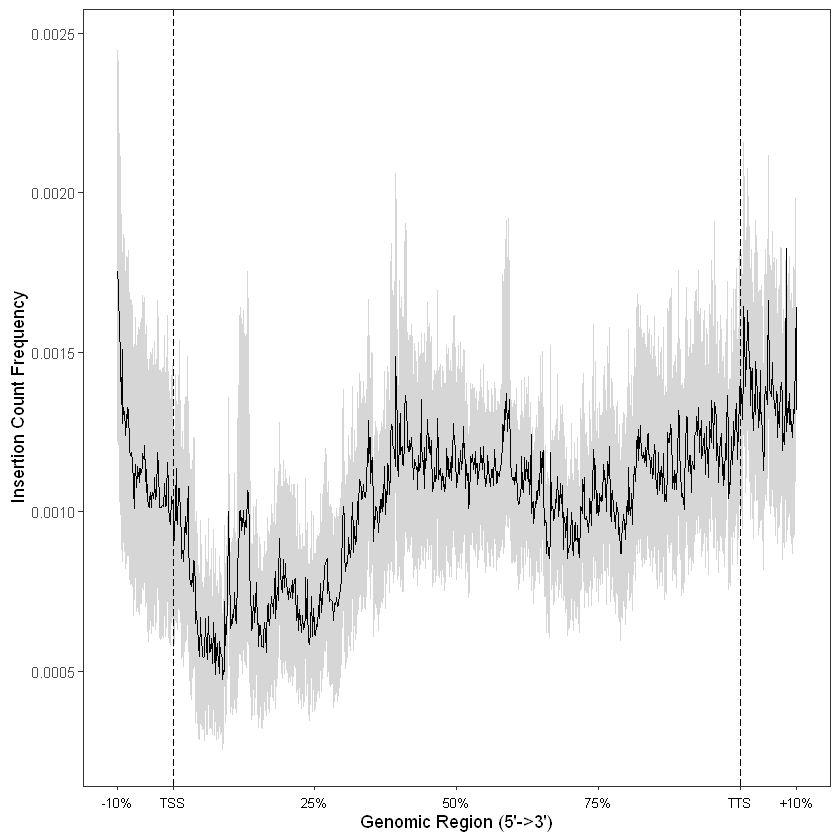

In [133]:
# run in local PC
library(GenomicRanges)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene
load("E:/项目/转座子/sgRNA/results/TE_insertion.anno.RData") # TE_insertion.list
anno <- as.data.frame(rbindlist(TE_insertion.list))
anno.bed <- anno[, c("chrom", "start", "end", "insertion_site")]
anno.bed <- anno.bed[order(anno.bed$chrom, anno.bed$start, anno.bed$end, anno.bed$insertion_site), ]
anno.bed <- anno.bed[!duplicated(anno.bed$insertion_site),]
write.table(anno.bed, "stat/insertion.bed", sep="\t", quote=F, col.names=F, row.names=F)
insertion.GR <- GRanges(seqnames = anno.bed$chrom,
                        ranges = IRanges(start = anno.bed$start-1,
                                         end = anno.bed$end,
                                         names = anno.bed$insertion_site))

ChIPseeker::plotPeakProf2(
    insertion.GR,
    # upstream=1000,
    # downstream=1000,
    upstream = rel(0.1), 
    downstream = rel(0.1),
    conf=0.95,
    by="transcript",
    type="body",
    weightCol = NULL,
    TxDb = txdb,
    xlab = "Genomic Region (5'->3')",
    ylab = "Insertion Count Frequency",
    facet = "none",
    free_y = TRUE,
    verbose = TRUE,
    nbin = 800,
    ignore_strand = FALSE
    ) + 
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) 


# ggsave("E:/项目/转座子/sgRNA/results/insertion_density_around_genebody.pdf",
#         width=7, height=4)


In [116]:
table((anno.bed$end - anno.bed$start)>=800)
table((anno.bed$end - anno.bed$start))


FALSE  TRUE 
 4544    18 

In [ ]:
library(ChIPseeker)
library(GenomicRanges)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene
load("E:/项目/转座子/sgRNA/results/TE_insertion.anno.RData") # TE_insertion.list

anno <- as.data.frame(rbindlist(TE_insertion.list))
anno.bed <- anno[, c("chrom", "start", "end", "insertion_site")]
anno.bed <- anno.bed[order(anno.bed$insertion_site), ]
anno.bed <- anno.bed[!duplicated(anno.bed$insertion_site),]
# length(unique(anno[!(anno$gene_id %in% "."), "insertion_site"]))/length(unique(anno[, "insertion_site"]))
# anno <- anno[, c("insertion_site", "intron", "intergenic", "UTR5", "UTR3", "CDS", "TSS500", "TES500")]
# anno <- anno[order(anno$insertion_site), ]
# anno <- anno[!duplicated(anno$insertion_site),]


# convert bed to GRanges object



insertion.GR <- GRanges(seqnames = anno.bed$chrom,
                        ranges = IRanges(start = anno.bed$start,
                                         end = anno.bed$end,
                                         names = anno.bed$insertion_site))

ChIPseeker::plotPeakProf2(
    insertion.GR,
    upstream=1000,
    downstream=1000,
    conf=0.95,
    # by="transcript",
    # type="body",
    weightCol = NULL,
    TxDb = txdb,
    xlab = "Genomic Region (5'->3')",
    ylab = "Insertion Count Frequency",
    facet = "none",
    free_y = FALSE,
    verbose = TRUE,
    # nbin = NULL,
    # ignore_strand = TRUE
    )


ggsave("stat/insertion_density_around_genebody.pdf",
        width=5, height=4)




#### insertion in genebody 

In [ ]:
# /NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.gtf

nwin=100
######### strand: +
awk '$3=="gene" && $7=="+" {print $1"\t"$4"\t"$5}' \
/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.gtf \
> /NAS/wg_looking/gRNA_ONT/stat/gencode.v37.chr_patch_hapl_scaff.annotation.gene.positive.bed
#
bedtools makewindows -b gencode.v37.chr_patch_hapl_scaff.annotation.gene.positive.bed \
-n $nwin -i winnum > gencode.v37.chr_patch_hapl_scaff.annotation.positive.gene.bed
#
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.positive.gene.bed \
-b insertion.bed -counts > hg38.gene.positive.insertion.count.bed
# upstream  
bedtools flank -i gencode.v37.chr_patch_hapl_scaff.annotation.gene.positive.bed \
-g /NAS/wg_looking/human_ref/GRCh38.p13.genome.fa.fai -l 1000 -r 0 \
> gencode.v37.chr_patch_hapl_scaff.annotation.gene.positive.upstream.bed
#
bedtools makewindows -b gencode.v37.chr_patch_hapl_scaff.annotation.gene.positive.upstream.bed \
-n 10 -i winnum > gencode.v37.chr_patch_hapl_scaff.annotation.positive.upstream.bed
#
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.positive.upstream.bed \
-b insertion.bed -counts > hg38.gene.positive.upstream.insertion.count.bed
# downstream
bedtools flank -i gencode.v37.chr_patch_hapl_scaff.annotation.gene.positive.bed \
-g /NAS/wg_looking/human_ref/GRCh38.p13.genome.fa.fai -l 0 -r 1000 \
> gencode.v37.chr_patch_hapl_scaff.annotation.gene.positive.downstream.bed
#
bedtools makewindows -b gencode.v37.chr_patch_hapl_scaff.annotation.gene.positive.downstream.bed \
-n 10 -i winnum > gencode.v37.chr_patch_hapl_scaff.annotation.positive.downstream.bed
#
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.positive.downstream.bed \
-b insertion.bed -counts > hg38.gene.positive.downstream.insertion.count.bed


######### strand: -
awk '$3=="gene" && $7=="-" {print $1"\t"$4"\t"$5}' \
/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.gtf \
> /NAS/wg_looking/gRNA_ONT/stat/gencode.v37.chr_patch_hapl_scaff.annotation.gene.negative.bed
#
bedtools makewindows -b gencode.v37.chr_patch_hapl_scaff.annotation.gene.negative.bed \
-n $nwin -i winnum -reverse > gencode.v37.chr_patch_hapl_scaff.annotation.negative.gene.bed
#
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.negative.gene.bed \
-b insertion.bed -counts > hg38.gene.negative.insertion.count.bed
# upstream  
bedtools flank -i gencode.v37.chr_patch_hapl_scaff.annotation.gene.negative.bed \
-g /NAS/wg_looking/human_ref/GRCh38.p13.genome.fa.fai -l 0 -r 1000 \
> gencode.v37.chr_patch_hapl_scaff.annotation.gene.negative.upstream.bed
#
bedtools makewindows -b gencode.v37.chr_patch_hapl_scaff.annotation.gene.negative.upstream.bed \
-n 10 -i winnum -reverse > gencode.v37.chr_patch_hapl_scaff.annotation.negative.upstream.bed
#
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.negative.upstream.bed \
-b insertion.bed -counts > hg38.gene.negative.upstream.insertion.count.bed
# downstream
bedtools flank -i gencode.v37.chr_patch_hapl_scaff.annotation.gene.negative.bed \
-g /NAS/wg_looking/human_ref/GRCh38.p13.genome.fa.fai -l 1000 -r 0 \
> gencode.v37.chr_patch_hapl_scaff.annotation.gene.negative.downstream.bed
#
bedtools makewindows -b gencode.v37.chr_patch_hapl_scaff.annotation.gene.negative.downstream.bed \
-n 10 -i winnum -reverse > gencode.v37.chr_patch_hapl_scaff.annotation.negative.downstream.bed
#
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.negative.downstream.bed \
-b insertion.bed -counts > hg38.gene.negative.downstream.insertion.count.bed


#### background using all TEs
### strand: +
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.positive.gene.bed \
-b hg38.LINE.SINE.bed -counts > hg38.gene.positive.TE.count.bed
# upstream  
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.positive.upstream.bed \
-b hg38.LINE.SINE.bed -counts > hg38.gene.positive.upstream.TE.count.bed
# downstream
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.positive.downstream.bed \
-b hg38.LINE.SINE.bed -counts > hg38.gene.positive.downstream.TE.count.bed


### strand: -
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.negative.gene.bed \
-b hg38.LINE.SINE.bed -counts > hg38.gene.negative.TE.count.bed
# upstream  
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.negative.upstream.bed \
-b hg38.LINE.SINE.bed -counts > hg38.gene.negative.upstream.TE.count.bed
# downstream
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.negative.downstream.bed \
-b hg38.LINE.SINE.bed -counts > hg38.gene.negative.downstream.TE.count.bed



#### background using expressed TEs
# load("stat/TE_location.RData")
# load("stat/MDAMB231_vs_MCF10A_TE_res.RData") # TE.norlCount
# expressedTEs <- rownames(res)
# load("stat/HCT116_vs_NCM460_TE_res.RData")
# expressedTEs <- c(expressedTEs, rownames(res))
# expressedTEs <- unique(expressedTEs)
# expT <- TE_location[expressedTEs, c("Chr", "Start", "End")]
# write.table(expT, "stat/BC_CRC_expressed_TEs.txt", row.names=F, col.names=F, sep="\t", quote=F)

### strand: +
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.positive.gene.bed \
-b BC_CRC_expressed_TEs.txt -counts > hg38.gene.positive.expressedTE.count.bed
# upstream  
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.positive.upstream.bed \
-b BC_CRC_expressed_TEs.txt -counts > hg38.gene.positive.upstream.expressedTE.count.bed
# downstream
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.positive.downstream.bed \
-b BC_CRC_expressed_TEs.txt -counts > hg38.gene.positive.downstream.expressedTE.count.bed


### strand: -
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.negative.gene.bed \
-b BC_CRC_expressed_TEs.txt -counts > hg38.gene.negative.expressedTE.count.bed
# upstream  
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.negative.upstream.bed \
-b BC_CRC_expressed_TEs.txt -counts > hg38.gene.negative.upstream.expressedTE.count.bed
# downstream
bedtools coverage -a gencode.v37.chr_patch_hapl_scaff.annotation.negative.downstream.bed \
-b BC_CRC_expressed_TEs.txt -counts > hg38.gene.negative.downstream.expressedTE.count.bed




##### insertion

In [ ]:
body.Files <- list("stat/hg38.gene.positive.insertion.count.bed",  
                  "stat/hg38.gene.negative.insertion.count.bed"
                  )
upstream.Files <- list("stat/hg38.gene.positive.upstream.insertion.count.bed", 
                      "stat/hg38.gene.negative.upstream.insertion.count.bed")
downstream.Files <- list("stat/hg38.gene.positive.downstream.insertion.count.bed",
                        "stat/hg38.gene.negative.downstream.insertion.count.bed")


nwin = 100
body <- lapply(body.Files, function(file){
    tb <- read.table(file)
    w.count <- sapply(1:nwin, function(n){sum(tb[tb$V4 %in% n, "V5"])})
    names(w.count) <- 1:nwin
    return(w.count)
})
body <-  body[[1]]+body[[2]]


upstream <- lapply(upstream.Files, function(file){
    tb <- read.table(file)
    w.count <- sapply(1:10, function(n){sum(tb[tb$V4 %in% n, "V5"])})
    names(w.count) <- 1:10
    return(w.count)
})
upstream <-  upstream[[1]]+upstream[[2]]



downstream <- lapply(downstream.Files, function(file){
    tb <- read.table(file)
    w.count <- sapply(1:10, function(n){sum(tb[tb$V4 %in% n, "V5"])})
    names(w.count) <- 1:10
    return(w.count)
})
downstream <-  downstream[[1]]+downstream[[2]]


pp <- data.frame(count=c(upstream, body, downstream))
pp$wnum <- 1:(nwin+20)


ggplot(pp, aes(x=wnum, y=count)) +
 geom_smooth(size=1.5, color="#8DA0CB",se = FALSE,span = 0.1) +
 theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    geom_vline(aes(xintercept = 11), linetype="dashed", color="red") +
   geom_vline(aes(xintercept = 10+nwin), linetype="dashed", color="red") +
    ylab("insertion count") +
    xlab("Genomic Region (5'->3')") +
   scale_x_continuous(breaks=seq(0,120,10), labels=c("Upstream", seq(0,100,10), "Downstream")) +
   ggtitle("insertion")




ggsave("stat/insertion_genebody_count.pdf", width=5.5, height=3.5)



##### TE

In [ ]:
body.Files <- list("stat/hg38.gene.positive.TE.count.bed",  
                  "stat/hg38.gene.negative.TE.count.bed"
                  )
upstream.Files <- list("stat/hg38.gene.positive.upstream.TE.count.bed", 
                      "stat/hg38.gene.negative.upstream.TE.count.bed")
downstream.Files <- list("stat/hg38.gene.positive.downstream.TE.count.bed",
                        "stat/hg38.gene.negative.downstream.TE.count.bed")


nwin = 100
body <- lapply(body.Files, function(file){
    tb <- read.table(file)
    w.count <- sapply(1:nwin, function(n){sum(tb[tb$V4 %in% n, "V5"])})
    names(w.count) <- 1:nwin
    return(w.count)
})
body <-  body[[1]]+body[[2]]


upstream <- lapply(upstream.Files, function(file){
    tb <- read.table(file)
    w.count <- sapply(1:10, function(n){sum(tb[tb$V4 %in% n, "V5"])})
    names(w.count) <- 1:10
    return(w.count)
})
upstream <-  upstream[[1]]+upstream[[2]]



downstream <- lapply(downstream.Files, function(file){
    tb <- read.table(file)
    w.count <- sapply(1:10, function(n){sum(tb[tb$V4 %in% n, "V5"])})
    names(w.count) <- 1:10
    return(w.count)
})
downstream <-  downstream[[1]]+downstream[[2]]


pp <- data.frame(count=c(upstream, body, downstream))
pp$wnum <- 1:(nwin+20)


ggplot(pp, aes(x=wnum, y=count)) +
 geom_smooth(size=1.5, color="#8DA0CB",se = FALSE,span = 0.1) +
 theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    geom_vline(aes(xintercept = 11), linetype="dashed", color="red") +
   geom_vline(aes(xintercept = 10+nwin), linetype="dashed", color="red") +
    ylab("TE count") +
    xlab("Genomic Region (5'->3')") +
   scale_x_continuous(breaks=seq(0,120,10), labels=c("Upstream", seq(0,100,10), "Downstream")) +
   ggtitle("TE")




ggsave("stat/TE_genebody_count.pdf", width=5.5, height=3.5)



##### expressed TEs

In [ ]:
body.Files <- list("stat/hg38.gene.positive.expressedTE.count.bed",  
                  "stat/hg38.gene.negative.expressedTE.count.bed"
                  )
upstream.Files <- list("stat/hg38.gene.positive.upstream.expressedTE.count.bed", 
                      "stat/hg38.gene.negative.upstream.expressedTE.count.bed")
downstream.Files <- list("stat/hg38.gene.positive.downstream.expressedTE.count.bed",
                        "stat/hg38.gene.negative.downstream.expressedTE.count.bed")


nwin = 100
body <- lapply(body.Files, function(file){
    tb <- read.table(file)
    w.count <- sapply(1:nwin, function(n){sum(tb[tb$V4 %in% n, "V5"])})
    names(w.count) <- 1:nwin
    return(w.count)
})
body <-  body[[1]]+body[[2]]


upstream <- lapply(upstream.Files, function(file){
    tb <- read.table(file)
    w.count <- sapply(1:10, function(n){sum(tb[tb$V4 %in% n, "V5"])})
    names(w.count) <- 1:10
    return(w.count)
})
upstream <-  upstream[[1]]+upstream[[2]]



downstream <- lapply(downstream.Files, function(file){
    tb <- read.table(file)
    w.count <- sapply(1:10, function(n){sum(tb[tb$V4 %in% n, "V5"])})
    names(w.count) <- 1:10
    return(w.count)
})
downstream <-  downstream[[1]]+downstream[[2]]


pp <- data.frame(count=c(upstream, body, downstream))
pp$wnum <- 1:(nwin+20)


ggplot(pp, aes(x=wnum, y=count)) +
 geom_smooth(size=1.5, color="#8DA0CB",se = FALSE,span = 0.1) +
 theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    geom_vline(aes(xintercept = 11), linetype="dashed", color="red") +
   geom_vline(aes(xintercept = 10+nwin), linetype="dashed", color="red") +
    ylab("TE count") +
    xlab("Genomic Region (5'->3')") +
   scale_x_continuous(breaks=seq(0,120,10), labels=c("Upstream", seq(0,100,10), "Downstream")) +
   ggtitle("expressed TE")




ggsave("stat/expressed_TE_genebody_count.pdf", width=5.5, height=3.5)



### binary table of insertion 

#### insertion region as row

In [ ]:
## binary table of insertion 
load("stat/TE_insertion.anno.RData")
tumor_genes <- read.table("database/NG_tumor_related_genes.txt")

TE <- "ALU"
anno <- TE_insertion.list[[TE]]
anno <- anno[order(anno$insertion_region), ]
ins.region <- anno[!duplicated(anno$insertion_region), ]
IDs <- c("sgRNA_HCT116", "sgRNA_MDAMB231", "sgRNA_NCM460", "sgRNA_MCF10A")
binary.tb <- lapply(setNames(IDs, IDs), function(ID){as.integer(grepl(ID, ins.region$IDs))})
binary.tb <- data.frame(binary.tb)
rownames(binary.tb) <- ins.region$insertion_region
dim(binary.tb) # 1652


rowInfo <- data.frame(insertion=rownames(binary.tb))
rownames(rowInfo) <- rowInfo$insertion
# tumor_genes$V1[tumor_genes$V1 %in% anno[anno$insertion_region %in% rowInfo$insertion, "gene_name" ]]
rowInfo$locate_known_genes <- 0
rowInfo$locate_known_genes[rowInfo$insertion %in% anno[!(anno$gene_id %in% "."), "insertion_region"]] <- 1
rowInfo$locate_tumor_genes <- 0
rowInfo$locate_tumor_genes[rowInfo$insertion %in% anno[anno$gene_name %in% tumor_genes$V1, "insertion_region"]] <- 1
rowInfo <- rowInfo[,-1]

pheatmap(binary.tb,
         # display_numbers=T,
         # annotation_col = colInfo,
         annotation_row = rowInfo,
         # annotation_colors = anno_colors,
         main="insertion",
         col=c("#D9DADE", "#E05D4B"),
         # color=colorRampPalette(c("navy", "white", "firebrick3"))(100),
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         border="white",
         show_rownames=F,
         # show_colnames=F,
         # cluster_rows=F,
         # cluster_cols=F,
         width=5,
         height=5,
         filename="stat/CRC_BC_insertion_heatmap.pdf")



# length(unique(anno[!(anno$gene_id %in% "."), "insertion_region"]))
# length(unique(anno[, "insertion_region"]))





#### gene_id as row

In [ ]:
load("stat/hg38.gene.transcript.gtf.RData")
load("stat/TE_insertion.anno.RData")
tumor_genes <- read.table("database/NG_tumor_related_genes.txt")


anno <- rbindlist(TE_insertion.list)
tb <- table(anno$gene_id, anno$ID)
dim(tb) # 1420    4
tb <- as.data.frame.matrix(tb)
tb <- tb[!(rownames(tb) %in% "."), ]
tb.all <- tb
dim(tb.all) # 1419    4 
# tb <- tb[tb$sgRNA_MDAMB231>0 & tb$sgRNA_MCF10A==0 |
#         tb$sgRNA_HCT116>0 & tb$sgRNA_NCM460==0, ]


# row order
tb <- tb[order(rowSums(tb)),]
cluster_rows <- hclust(dist(tb, method="binary"), method = "complete")
labels_row <- gene_gtf[rownames(tb), "gene_name"]
# labels_row_check <- labels_row[cluster_rows$order]


rowInfo <- data.frame(gene_id=rownames(tb))
rownames(rowInfo) <- rowInfo$gene_id
rowInfo$gene_name <- gene_gtf[rownames(rowInfo) , "gene_name"]
rowInfo$locate_tumor_genes <- 0
rowInfo$locate_tumor_genes[rowInfo$gene_name %in% tumor_genes$V1] <- 1
rowInfo$ALU <- 0
rowInfo$ALU[rowInfo$gene_id %in% anno$gene_id[anno$TE %in% "ALU"]] <- 1
rowInfo$LINE <- 0
rowInfo$LINE[rowInfo$gene_id %in% anno$gene_id[anno$TE %in% "LINE"]] <- 1
rowInfo <- rowInfo[,-c(1, 2), drop=F]



pheatmap(tb,
         # display_numbers=T,
         # annotation_col = colInfo,
         annotation_row = rowInfo,
         # clustering_distance_rows = "binary",
         cluster_rows = cluster_rows,
         labels_row=labels_row, 
         # annotation_colors = anno_colors,
         main="insertion genes",
         # col=c("#D9DADE", "#E05D4B"),
         col=c("#F1F3F5", colorRampPalette(c("#F6A496","#CF2920"))(25)),
         # color=colorRampPalette(c("navy", "white", "firebrick3"))(8)[2:7],
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         # border="white",
         # show_rownames=F,
         # show_colnames=F,
         # cluster_rows=F,
         # cluster_cols=F,
         fontsize_row=0.5,
         width=5,
         height=5,
         filename="stat/CRC_BC_insertion_heatmap_genes_as_row_all.pdf")




In [ ]:
tb.tmp <- as.data.frame.matrix(tb[cluster_rows$order, ])
tb.tmp <- data.frame(gene_id=rownames(tb.tmp), 
                     gene_name=labels_row[cluster_rows$order],
                     tb.tmp)

write.table(tb.tmp, "stat/CRC_BC_insertion_genes.txt", sep="\t", quote=F, col.names=T, row.names=F)

In [ ]:
################################################
## MDAMB231 specific or HCT116 specifc insertion
################################################

tb <- tb[tb$sgRNA_MDAMB231>0 & tb$sgRNA_MCF10A==0 |
        tb$sgRNA_HCT116>0 & tb$sgRNA_NCM460==0, ]


# row order
tb <- tb[order(rowSums(tb)),]
dim(tb) # 672   4
cluster_rows <- hclust(dist(tb, method="binary"), method = "complete")
labels_row <- gene_gtf[rownames(tb), "gene_name"]
# labels_row_check <- labels_row[cluster_rows$order]


rowInfo <- data.frame(gene_id=rownames(tb))
rownames(rowInfo) <- rowInfo$gene_id
rowInfo$gene_name <- gene_gtf[rownames(rowInfo) , "gene_name"]
rowInfo$locate_tumor_genes <- 0
rowInfo$locate_tumor_genes[rowInfo$gene_name %in% tumor_genes$V1] <- 1
rowInfo$ALU <- 0
rowInfo$ALU[rowInfo$gene_id %in% anno$gene_id[anno$TE %in% "ALU"]] <- 1
rowInfo$LINE <- 0
rowInfo$LINE[rowInfo$gene_id %in% anno$gene_id[anno$TE %in% "LINE"]] <- 1
rowInfo <- rowInfo[,-c(1, 2), drop=F]



pheatmap(tb,
         # display_numbers=T,
         # annotation_col = colInfo,
         annotation_row = rowInfo,
         # clustering_distance_rows = "binary",
         cluster_rows = cluster_rows,
         labels_row=labels_row, 
         # annotation_colors = anno_colors,
         main="insertion genes",
         # col=c("#D9DADE", "#E05D4B"),
         col=c("#F1F3F5", colorRampPalette(c("#F6A496","#CF2920"))(25)),
         # color=colorRampPalette(c("navy", "white", "firebrick3"))(8)[2:7],
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         # border="white",
         # show_rownames=F,
         # show_colnames=F,
         # cluster_rows=F,
         # cluster_cols=F,
         fontsize_row=0.5,
         width=5,
         height=5,
         filename="stat/CRC_BC_insertion_heatmap_genes_as_row.pdf")




In [ ]:
#
gene.Files <- list(BC="stat/MDAMB231_vs_MCF10A_all_genes.txt",
                   CRC="stat/HCT116_vs_NCM460_all_genes.txt")
tumor_genes <- read.table("database/NG_tumor_related_genes.txt")
tb.all


# BC
gtb <- read.table(gene.Files[["BC"]], header=T, stringsAsFactors = F)
g <- gtb[gtb$dif %in% c("Up", "Down"), c("gene_id", "log2FoldChange")]
g2 <- data.frame(g, tb.all[g$gene_id,])
g2[is.na(g2)] <- 0  
g2$insertion_dif <- g2$sgRNA_MDAMB231 - g2$sgRNA_MCF10A    
p1 <- g2[, c("insertion_dif", "log2FoldChange")]
p1 <- data.frame(p1, Tissue="BC")

# CRC
gtb <- read.table(gene.Files[["CRC"]], header=T, stringsAsFactors = F)
g <- gtb[gtb$dif %in% c("Up", "Down"), c("gene_id", "log2FoldChange")]
g2 <- data.frame(g, tb.all[g$gene_id,])
g2[is.na(g2)] <- 0  
g2$insertion_dif <- g2$sgRNA_HCT116 - g2$sgRNA_NCM460    
p2 <- g2[, c("insertion_dif", "log2FoldChange")]
p2 <- data.frame(p2, Tissue="CRC")

p <- rbind(p1, p2)
# cor(p$insertion_dif, p$log2FoldChange, method="spearman") # 0.1527926
# pearson 0.1348492

ggplot(p, aes(x=log2FoldChange, y=insertion_dif, color=Tissue)) +
      geom_point(alpha=0.5) +
      theme_bw() +
      theme(panel.grid = element_blank(),
            plot.title = element_text(hjust = 0, size = 12),
            axis.text.x  = element_text(angle = 0, hjust=1, vjust=0.5, 
                                        colour = "black", size = 11),
            axis.text.y  = element_text(colour = "black"),
            # legend.position = c(0.8,0.8),
            strip.background = element_rect(fill="white", colour = "black", size=1) ,
            legend.title = element_text(face="bold")) +
      # geom_text(aes(label=symbol), vjust=0.5, hjust=0,size=4, colour="black") +
      # annotate("text", x=pp$NAME[2], y=-1.5,size=3,
      #          label="nominal P values: \n*P < 0.05 \n**P < 0.005 \n***P < 0.0005 \nNS: not significant") +
      # scale_x_discrete(limits=c(pp$term.name))+
      scale_color_manual(values=c("#4678BA", "#EF8354")) +
      ggtitle("")
    # facet_grid(.~module, scales = "free_x", space = "free_x") 


ggsave(paste0("stat/Fig7S.Insertion_dif_along_gene_log2FoldChange_point.pdf"),
       height = 5, width = 5.5)






##### chisq test: insertion in oncogenes

In [ ]:
tumor_genes <- read.table("database/NG_tumor_related_genes.txt")
ID.list <- list(BC=c("sgRNA_MDAMB231", "sgRNA_MCF10A"),
                CRC=c("sgRNA_HCT116", "sgRNA_NCM460"))
gene.Files <- list(BC="stat/MDAMB231_vs_MCF10A_all_genes.txt",
                   CRC="stat/HCT116_vs_NCM460_all_genes.txt")


test_res <- lapply(names(ID.list), function(T){
    file <- gene.Files[[T]]
    gene.tb <- read.table(file, header = TRUE)
    bg <- unique(gene.tb$gene_name)
    bg_tt <- table(bg %in% tumor_genes$V1)
    IDs <- ID.list[[T]]
    a <- lapply(IDs, function(ID){
        tmp <- rownames(tb)[tb[, ID]>0 & tb[, setdiff(IDs, ID)]==0 ]
        tt <- table(rowInfo[tmp, "locate_tumor_genes"])
        x <- c(tt["1"], tt["0"], bg_tt["TRUE"], bg_tt["FALSE"])
        x <- matrix(x, ncol = 2)
        pvalue <- chisq.test(x)$p.value # 0.01910379
        ratio= (tt["1"]/sum(tt)) / (bg_tt["TRUE"]/sum(bg_tt))
        log2FC <-  log2(ratio) # 0.822162

        res <- data.frame(ID=ID,
                         pvalue=pvalue,
                         log2FC=log2FC)
    })
    
})

pp <- rbindlist(lapply(test_res, rbindlist))
pp$padj <- p.adjust(pp$pvalue, method = "fdr", n = length(pp$pvalue))
pp <- pp[order(pp$padj, decreasing=TRUE),]
pp$ID <- factor(pp$ID, levels=pp$ID)

ggplot(pp, aes(x=ID, y=log2FC, fill=pvalue)) +
      geom_bar(stat="identity", width = 0.8) +
      theme_bw() +
      theme(panel.grid = element_blank(),
            plot.title = element_text(hjust = 0, size = 12),
            axis.text.x  = element_text(angle = 0, hjust=1, vjust=0.5, 
                                        colour = "black", size = 11),
            axis.text.y  = element_text(colour = "black"),
            # legend.position = c(0.8,0.8),
            strip.background = element_rect(fill="white", colour = "black", size=1) ,
            legend.title = element_text(face="bold")) +
      # geom_text(aes(label=symbol), vjust=0.5, hjust=0,size=4, colour="black") +
      # annotate("text", x=pp$NAME[2], y=-1.5,size=3,
      #          label="nominal P values: \n*P < 0.05 \n**P < 0.005 \n***P < 0.0005 \nNS: not significant") +
      # scale_x_discrete(limits=c(pp$term.name))+
      # scale_fill_manual(values=c("GO:BP"="#4678BA", "KEGG"="#EF8354")) +
      coord_flip() +
      xlab("") +
      ggtitle("insertion related oncogenes")
    # facet_grid(.~module, scales = "free_x", space = "free_x") 


ggsave(paste0("stat/Insertion_oncogenes_chisq_test_bar.pdf"),
       height = 3, width = 6)





In [ ]:
load("stat/hg38.quantify.FeatureCount.RData") # trans.count, gene.count
BC <- read.table("stat/MDAMB231_vs_MCF10A_all_genes.txt", header=T)
CRC <- read.table("stat/HCT116_vs_NCM460_all_genes.txt", header=T)


# load Sample info
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples

SampleIDs <- Sample_info$Samples[Sample_info$CellLine %in% c("MDAMB231", "MCF10A", "HCT116", "NCM460") &
                                Sample_info$SeqType %in% c("sgRNA")]


# run DESeq2
sub.gene.count <- gene.count[, SampleIDs]
# sub.gene.count <- sub.gene.count[apply(sub.gene.count, 1, function(x){ (sum(x>=1))>=1 }),]
sub.gene.count <- round(sub.gene.count)


colInfo <- Sample_info[SampleIDs, c("CellLine", "TissueType")]
dds <- DESeqDataSetFromMatrix(sub.gene.count, 
                                colInfo, 
                                ~CellLine)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
                )
gene.norlCount <- counts(Object, normalized=T)
CRC_res <- results(Object, contrast=c("CellLine", "HCT116", "NCM460"))
BC_res <- results(Object, contrast=c("CellLine", "MDAMB231", "MCF10A"))



sub <- gene.norlCount[rownames(gene.norlCount) %in% rownames(tb), ]
sub <- sub[rownames(tb)[cluster_rows$order], ]

rowInfo <- data.frame(gene_id=rownames(sub))
rownames(rowInfo) <- rowInfo$gene_id
rowInfo$BC_dif <- 0
rowInfo$BC_dif[rowInfo$gene_id %in% BC$gene_id[BC$dif %in% c("Up", "Down")]] <- 1
rowInfo$CRC_dif <- 0
rowInfo$CRC_dif[rowInfo$gene_id %in% CRC$gene_id[CRC$dif %in% c("Up", "Down")]] <- 1
rowInfo <- rowInfo[,-1, drop=F]



pheatmap(sub,
         scale="row",
         # display_numbers=T,
         # annotation_col = colInfo,
         annotation_row = rowInfo,
         # clustering_distance_rows = "binary",
         # cluster_rows = cluster_rows,
         # labels_row=labels_row, 
         # annotation_colors = anno_colors,
         main="insertion genes expression",
         # col=c("#D9DADE", "#E05D4B"),
         # col=c("#F1F3F5", colorRampPalette(c("#F6A496","#CF2920"))(25)),
         # color=colorRampPalette(c("navy", "white", "firebrick3"))(8)[2:7],
         col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         # border="white",
         show_rownames=F,
         # show_colnames=F,
         cluster_rows=F,
         # cluster_cols=F,
         fontsize_row=0.5,
         width=3,
         height=5,
         filename="stat/CRC_BC_insertion_genes_expression_heatmap.pdf")



# lg2FC <- data.frame(CRC=CRC_res[rownames(sub), "log2FoldChange"], BC=BC_res[rownames(sub), "log2FoldChange"])
# rownames(lg2FC) <- rownames(sub)
BC <- read.table("stat/MDAMB231_vs_MCF10A_all_genes.txt", header=T)
rownames(BC) <- BC$gene_id
CRC <- read.table("stat/HCT116_vs_NCM460_all_genes.txt", header=T)
rownames(CRC) <- CRC$gene_id
lg2FC <- data.frame(CRC=CRC[rownames(tb), "log2FoldChange"], BC=BC[rownames(tb), "log2FoldChange"])
rownames(lg2FC) <- rownames(tb)



pheatmap(lg2FC[, c("BC", "CRC")],
         scale="row",
         # display_numbers=T,
         # annotation_col = colInfo,
         annotation_row = rowInfo,
         # clustering_distance_rows = "binary",
         # cluster_rows = cluster_rows,
         # labels_row=labels_row, 
         # annotation_colors = anno_colors,
         main="insertion genes logFC",
         # col=c("#D9DADE", "#E05D4B"),
         # col=c("#F1F3F5", colorRampPalette(c("#F6A496","#CF2920"))(25)),
         color=colorRampPalette(c("navy", "white", "firebrick3"))(9)[4:8],
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         # border="white",
         show_rownames=F,
         # show_colnames=F,
         cluster_rows=F,
         cluster_cols=F,
         fontsize_row=0.5,
         width=3,
         height=5,
         filename="stat/CRC_BC_insertion_genes_log2FC_heatmap.pdf")



##### correlation between insertion and logFC

In [ ]:
## corrlation
tb <- tb.all
BC <- read.table("stat/MDAMB231_vs_MCF10A_all_genes.txt", header=T)
rownames(BC) <- BC$gene_id
CRC <- read.table("stat/HCT116_vs_NCM460_all_genes.txt", header=T)
rownames(CRC) <- CRC$gene_id
lg2FC <- data.frame(CRC=CRC[rownames(tb), "log2FoldChange"], BC=BC[rownames(tb), "log2FoldChange"])
rownames(lg2FC) <- rownames(tb)



# MDAMB231 vs MCF10A
BC_tb <- tb[, c("sgRNA_MDAMB231", "sgRNA_MCF10A")]
BC_tb <- BC_tb[!rowSums(BC_tb)==0, ]
BC_tmp <- BC_tb$sgRNA_MDAMB231 - BC_tb$sgRNA_MCF10A
BC_lg2FC <- lg2FC[rownames(BC_tb), ]
cor(BC_lg2FC$BC[complete.cases(BC_lg2FC$BC)], BC_tmp[complete.cases(BC_lg2FC$BC)], method="spearman")


# HCT116 vs NCM460
CRC_tb <- tb[, c("sgRNA_HCT116", "sgRNA_NCM460")]
CRC_tb <- CRC_tb[!rowSums(CRC_tb)==0, ]
CRC_tmp <- CRC_tb$sgRNA_HCT116 - CRC_tb$sgRNA_NCM460
CRC_lg2FC <- lg2FC[rownames(CRC_tb), ]
cor(CRC_lg2FC$CRC[complete.cases(CRC_lg2FC$CRC)], CRC_tmp[complete.cases(CRC_lg2FC$CRC)], method="spearman")


cor(c(BC_lg2FC$BC[complete.cases(BC_lg2FC$BC)], CRC_lg2FC$CRC[complete.cases(CRC_lg2FC$CRC)]),
  c(BC_tmp[complete.cases(BC_lg2FC$BC)], CRC_tmp[complete.cases(CRC_lg2FC$CRC)]),
                                                                           method="spearman")

In [ ]:
# ## corrlation
# tb <- tb.all
# lg2FC

# # MDAMB231 vs MCF10A
# BC_tb <- tb[, c("sgRNA_MDAMB231", "sgRNA_MCF10A")]
# BC_tb[BC_tb>0] <- 1
# BC_tb <- BC_tb[rowSums(BC_tb)>0, ]
# BC_tb[BC_tb==0] <- -1
# BC_tmp <- BC_tb$sgRNA_MDAMB231
# BC_tmp[BC_tmp==1 & BC_tb$sgRNA_MCF10A==1] <- 0
# BC_lg2FC <- lg2FC[rownames(BC_tb), ]
# cor(BC_lg2FC$BC[complete.cases(BC_lg2FC$BC)], BC_tmp[complete.cases(BC_lg2FC$BC)], method="spearman")


# # HCT116 vs NCM460
# CRC_tb <- tb[, c("sgRNA_HCT116", "sgRNA_NCM460")]
# CRC_tb[CRC_tb>0] <- 1
# CRC_tb <- CRC_tb[rowSums(CRC_tb)>0, ]
# CRC_tb[CRC_tb==0] <- -1
# CRC_tmp <- CRC_tb$sgRNA_HCT116
# CRC_tmp[CRC_tmp==1 & CRC_tb$sgRNA_NCM460==1] <- 0
# CRC_lg2FC <- lg2FC[rownames(CRC_tb), ]
# cor(CRC_lg2FC$CRC[complete.cases(CRC_lg2FC$CRC)], CRC_tmp[complete.cases(CRC_lg2FC$CRC)], method="spearman")


# cor(c(BC_lg2FC$BC[complete.cases(BC_lg2FC$BC)], CRC_lg2FC$CRC[complete.cases(CRC_lg2FC$CRC)]),
#   c(BC_tmp[complete.cases(BC_lg2FC$BC)], CRC_tmp[complete.cases(CRC_lg2FC$CRC)]),
#                                                                            method="spearman")

### 插入位置相关基因的功能

In [ ]:
Sys.which("python")
Sys.setenv(RETICULATE_PYTHON = "/home/wg_looking/anaconda3/bin/python")
library(reticulate)
source_python("/NAS/wg_looking/gRNA_ONT/code/NCBI_gene_summary.py")
load("stat/TE_insertion.anno.RData") # TE_insertion.list

gene_id <- unique(unlist(lapply(TE_insertion.list, function(x){unique(x$gene_id)})))
genes <- setNames(as.character(sub$gene_id), as.character(sub$gene_id))
# gene_function.list <- list()
for(i in 2804:length(genes)){
    gene_id <- genes[i]
    Entrez_ID = ENSEMBL_ID_Entrez_ID_all[gene_id, "ENTREZID"]
    gf = NCBI_gene_summary(as.character(Entrez_ID)) 
    gene_function.list[gene_id] <- gf
}



# Quantification : assembly gtf

## K562

In [ ]:
library(DESeq2)
library(tximport)
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/K562_Diff.RData") # sgDiff, totalDiff


# load Sample info
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples

SampleIDs <- c("sgRNA_K562_1", "totalRNA_K562_1")


# loading quantification
files <- file.path(SampleIDs, paste0(SampleIDs,".salmon_quant_with_assembly_gtf"), "quant.sf")
names(files) <- SampleIDs

quant.list <- lapply(files, function(x){
    quant <- read.table(x, header=T, stringsAsFactors=F)
    colnames(quant)[1] <- "qry_id"
    return(quant)
})



In [ ]:

# sgRNA: TE-derived
quant.merge <- merge(quant.list[["sgRNA_K562_1"]], sgDiff[[2]], by="qry_id")
left <- quant.merge$qry_left
left <- gsub("\\)", "", gsub("\\(", "", left))
quant.merge$left <- as.integer(left)
sub.quant.merge <- quant.merge[quant.merge$qry_start<=5 | quant.merge$left<=5,]
sub.quant.merge$sub_repeat <- substring(sub.quant.merge$repeat_id, 1, 4)
L1_index <- which(sub.quant.merge$matching_class %in% "LINE/L1")
sub.quant.merge$sub_repeat[L1_index] <- substring(sub.quant.merge$sub_repeat[L1_index] , 1, 3)  
sub.quant.merge$sub_repeat[sub.quant.merge$sub_repeat %in% "L1H"] <- "L1HS"
sub.quant.merge <- sub.quant.merge[order(sub.quant.merge$qry_id, sub.quant.merge$sub_repeat),]
sub.quant.merge <- sub.quant.merge[!duplicated(sub.quant.merge[,c("qry_id", "sub_repeat")]), ]


ggplot(sub.quant.merge, aes(x=sub_repeat, y=log(TPM), color=matching_class)) +
    geom_point(alpha=0.5) +
    geom_jitter(width = 0.25) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~class, nrow = 2, scales="free") +
    scale_color_manual(values = c("#EF8354", "#4678BA")) +
    ggtitle("sgRNA")
  
ggsave(paste0("stat/sgRNA_TE_derived_transcripts_repeat_family_TPM.pdf"),
         width = 6, height = 5)
  

In [ ]:
# sgRNA: TE-derived
quant.merge <- merge(quant.list[["totalRNA_K562_1"]], totalDiff[[2]], by="qry_id")
left <- quant.merge$qry_left
left <- gsub("\\)", "", gsub("\\(", "", left))
quant.merge$left <- as.integer(left)
sub.quant.merge <- quant.merge[quant.merge$qry_start<=5 | quant.merge$left<=5,]
sub.quant.merge$sub_repeat <- substring(sub.quant.merge$repeat_id, 1, 4)
L1_index <- which(sub.quant.merge$matching_class %in% "LINE/L1")
sub.quant.merge$sub_repeat[L1_index] <- substring(sub.quant.merge$sub_repeat[L1_index] , 1, 3)  
sub.quant.merge$sub_repeat[sub.quant.merge$sub_repeat %in% "L1H"] <- "L1HS"
sub.quant.merge <- sub.quant.merge[order(sub.quant.merge$qry_id, sub.quant.merge$sub_repeat),]
sub.quant.merge <- sub.quant.merge[!duplicated(sub.quant.merge[,c("qry_id", "sub_repeat")]), ]


ggplot(sub.quant.merge, aes(x=sub_repeat, y=log(TPM), color=matching_class)) +
    geom_point(alpha=0.5) +
    geom_jitter(width = 0.25) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~class, nrow = 2, scales="free") +
    scale_color_manual(values = c("#EF8354", "#4678BA")) +
    ggtitle("totalRNA")
  
ggsave(paste0("stat/totalRNA_TE_derived_transcripts_repeat_family_TPM.pdf"),
         width = 6, height = 5)


## sgRNA: HCT116 vs NCM460

In [ ]:
library(DESeq2)
library(tximport)
library(patchwork) # p <- p1 + p3 + plot_layout(ncol = 1, heights = c(1, 1))
load("stat/HCT116_NCM460_diff.Data") # HCT116_Diff, NCM460_Diff


# load Sample info
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples
SampleIDs <- Sample_info$Samples[(Sample_info$CellLine %in% c("HCT116", "NCM460")) & (Sample_info$SeqType %in% "sgRNA")]


# loading new junction information
tmap = "stringtie_res5/HCT116_NCM460/sgRNA_HCT116_NCM460.minCoverage_5.gap_20.sgRNA_HCT116_NCM460.minCoverage_5.gap_20.gtf.tmap"
tb <- read.table(tmap, header = T, stringsAsFactors = F)
# new transcript with new junction
bed <- "stringtie_res5/HCT116_NCM460/sgRNA_HCT116_NCM460.minCoverage_5.gap_20.intron.new.bed" 
bed.tb <- read.table(bed, stringsAsFactors = F)
splice_junction_id <- tstrsplit(bed.tb$V4, "[|]")[[3]]
splice_junction_id <- unique(splice_junction_id)
#
tb$classification <- "other_exonic_overlap"
tb$classification[tb$qry_id %in% splice_junction_id] <- "new_splice_junction"
tb$classification[tb$class_code %in% "u"] <- "intergenic"
tb$classification[tb$class_code %in% "i"] <- "intragenic"
tb$classification[tb$class_code %in% c("c", "=")] <- "match_reference"
tb <- tb[, c("qry_id", "classification", "class_code")]
colnames(tb) <- c("merge_transcript_id", "classification", "class_code")


## loading tmap: HCT116, NCM460 
NCM460_tmap <- read.table(file.path("stringtie_res5", 
                                    "NCM460", 
                "sg_HCT116_NCM460_vs_sgNCM460.sgRNA_NCM460.minCoverage_5.gap_20.gtf.tmap"),
                         header=T, stringsAsFactors=F)
NCM460_tmap <- NCM460_tmap[, c("ref_id", "qry_id", "class_code")]
colnames(NCM460_tmap) <- c("merge_transcript_id", "NCM460_transcript_id", "NCM460_class_code")
NCM460_tmap <- NCM460_tmap[NCM460_tmap$merge_transcript_id != "-", ]
NCM460_tmap <- NCM460_tmap[NCM460_tmap$NCM460_transcript_id %in% NCM460_Diff[[1]]$qry_id, ]
#
HCT116_tmap <- read.table(file.path("stringtie_res5", 
                                    "HCT116", 
                "sg_HCT116_NCM460_vs_sgHCT116.sgRNA_HCT116.minCoverage_5.gap_20.gtf.tmap"),
                         header=T, stringsAsFactors=F)
HCT116_tmap <- HCT116_tmap[, c("ref_id", "qry_id", "class_code")]
colnames(HCT116_tmap) <- c("merge_transcript_id", "HCT116_transcript_id", "HCT116_class_code")
HCT116_tmap <- HCT116_tmap[HCT116_tmap$merge_transcript_id != "-", ]
HCT116_tmap <- HCT116_tmap[HCT116_tmap$HCT116_transcript_id %in% HCT116_Diff[[1]]$qry_id, ]
#
tracking <- merge(HCT116_tmap, NCM460_tmap, by="merge_transcript_id")
dim(tracking)
tracking <- merge(tb, tracking, by="merge_transcript_id")
sub.tracking <- tracking[tracking$HCT116_class_code %in% c("=", "c") |
                         tracking$NCM460_class_code %in% c("=", "c"), ]


# loading quantification
files <- file.path(SampleIDs, paste0(SampleIDs,".salmon_quant_with_HCT116_NCM460_gtf"), "quant.sf")
names(files) <- SampleIDs
txi <- tximport(files, type = "salmon", txOut = TRUE)
names(txi)
dds <- DESeqDataSetFromTximport(txi, 
                                Sample_info[SampleIDs, c("CellLine"), drop=F], 
                                ~CellLine)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
                )
norlCount <- counts(Object, normalized=T)
res <- results(Object, contrast=c("CellLine", "HCT116", "NCM460"))
res <- res[complete.cases(res),]
dif_res <- res[res$padj<0.05 & abs(res$log2FoldChange)>1 & res$baseMean>10, ]


## new differential transcripts
new.dif_res <- dif_res[rownames(dif_res) %in% sub.tracking$merge_transcript_id, ]
new.dif_res$merge_transcript_id <- rownames(new.dif_res)
new.dif_res.merge <- merge(data.frame(new.dif_res), sub.tracking, by="merge_transcript_id")
new.dif_res.merge$type <- ""
new.dif_res.merge$type[new.dif_res.merge$HCT116_class_code %in% c("=", "c") &
                       !(new.dif_res.merge$NCM460_class_code %in% c("=", "c"))] <- "HCT116_specific"
new.dif_res.merge$type[new.dif_res.merge$NCM460_class_code %in% c("=", "c") &
                       !(new.dif_res.merge$HCT116_class_code %in% c("=", "c"))] <- "NCM460_specific"
new.dif_res.merge$type[new.dif_res.merge$NCM460_class_code %in% c("=", "c") &
                       (new.dif_res.merge$HCT116_class_code %in% c("=", "c"))] <- "Common"
table(new.dif_res.merge$type)

new.dif_res.merge <- new.dif_res.merge[order(new.dif_res.merge$merge_transcript_id, new.dif_res.merge$type), ]
new.dif_res.duplicated <- new.dif_res.merge[!duplicated(new.dif_res.merge$merge_transcript_id), ]

new.dif_res.duplicated <- new.dif_res.duplicated[order(new.dif_res.duplicated$type, 
                                                       new.dif_res.duplicated$classification, 
                                                       new.dif_res.duplicated$log2FoldChange), ]




In [ ]:
library(pheatmap)

cols <- c("#F4B540", "#EF8354", "#4678BA", "#87B07A", "#BA748A")
names(cols) <- unique(new.dif_res.duplicated$classification)

colInfo <- Sample_info[SampleIDs, c("CellLine"), drop=F]
rowInfo <- new.dif_res.duplicated[, c("type", "classification")]
rownames(rowInfo) <- new.dif_res.duplicated$merge_transcript_id
anno_colors <- list(CellLine=c(NCM460="#4678BA", HCT116="#F4B540"),
                   type=c(Common="#76A45B", HCT116_specific="#F4B540", NCM460_specific="#4678BA"),
                   classification=cols)



pheatmap(norlCount[new.dif_res.duplicated$merge_transcript_id,],
         # display_numbers=T,
         scale="row",
         annotation_col = colInfo,
         annotation_row = rowInfo,
         annotation_colors = anno_colors,
         main="differential assembly transcript expression",
         col=colorRampPalette(rev(brewer.pal(11,"RdBu")))(21),
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         border=NA,
         show_rownames=F,
         show_colnames=F,
         cluster_rows=F,
         cluster_cols=F,
         width=6.5,
         height=6,
         filename="stat/HCT116_NCM460_assembly_trans_dif_heatmap.pdf")


# out_res <- dif_res[, c("baseMean", "log2FoldChange", "padj")]
# out_res$dif <- "HCT116_over"
# out_res$dif[out_res$log2FoldChange<0] <- "NCM460_over"
# out_res <- out_res[order(out_res$dif),]
# out_res <- data.frame(gene_id=rownames(out_res), out_res)
# out_res <- data.frame(out_res, gene_name=transcript_gtf[rownames(out_res), "gene_name"])
# transcript_res <- out_res
# # write.table(out_res, "stat/CRC_differential_transcripts.txt", row.names = F, col.names = T, quote = F, sep="\t")
# write.table(out_res, "stat/CRC_all_transcripts.txt", row.names = F, col.names = T, quote = F, sep="\t")



### TE-derived

In [ ]:
library(plyr)
library(data.table)
library(patchwork)
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/HCT116_NCM460_diff.Data") # HCT116_Diff, NCM460_Diff


# load Sample info
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples

SampleIDs <- Sample_info$Samples[Sample_info$CellLine %in% c("HCT116", "NCM460") &
                                Sample_info$SeqType %in% c("sgRNA")]


# loading quantification
files <- file.path(SampleIDs, paste0(SampleIDs,".salmon_quant_with_assembly_gtf"), "quant.sf")
names(files) <- SampleIDs

quant.list <- lapply(files, function(x){
    quant <- read.table(x, header=T, stringsAsFactors=F)
    colnames(quant)[1] <- "qry_id"
    quant$RPM <- (quant$NumReads)/sum(quant$NumReads)*10^6
    
    return(quant)
})



# files <- file.path(SampleIDs, "prepDE_assembly_gtf_transcript_count.csv")
# names(files) <- SampleIDs

# quant.list <- lapply(files, function(x){
#     quant <- read.csv(x, header=T, stringsAsFactors=F)
#     colnames(quant) <- c("qry_id", "NumReads")
#     quant$RPM <- (quant$NumReads)/sum(quant$NumReads)*10^6
#     return(quant)
# })



In [ ]:



TE_RPM <- lapply(c("HCT116", "NCM460"), function(CellLine){
    IDs <- Sample_info$Samples[Sample_info$CellLine %in% CellLine &
                                Sample_info$SeqType %in% c("sgRNA")]
    #
    sub.quant.list <- lapply(IDs, function(ID){
        q <- quant.list[[ID]][, c("qry_id", "RPM")]
        colnames(q) <- c("qry_id", ID)
        return(q)
    })
    #
    quant <- join_all(sub.quant.list)
    quant$RPM <- rowMeans(quant[, c(2:4)])
    # 
    if(CellLine=="HCT116"){
        quant.merge <- merge(quant, HCT116_Diff[[2]], by="qry_id")
    }
    if(CellLine=="NCM460"){
        quant.merge <- merge(quant, NCM460_Diff[[2]], by="qry_id")
    }
    #
    left <- quant.merge$qry_left
    left <- gsub("\\)", "", gsub("\\(", "", left))
    quant.merge$left <- as.integer(left)
    sub.quant.merge <- quant.merge[quant.merge$qry_start<=5 | quant.merge$left<=5,]
    sub.quant.merge$sub_repeat <- substring(sub.quant.merge$repeat_id, 1, 4)
    L1_index <- which(sub.quant.merge$matching_class %in% "LINE/L1")
    sub.quant.merge$sub_repeat[L1_index] <- substring(sub.quant.merge$sub_repeat[L1_index] , 1, 3)  
    sub.quant.merge$sub_repeat[sub.quant.merge$sub_repeat %in% "L1H"] <- "L1HS"
    sub.quant.merge <- sub.quant.merge[order(sub.quant.merge$qry_id, sub.quant.merge$sub_repeat),]
    sub.quant.merge <- sub.quant.merge[!duplicated(sub.quant.merge[,c("qry_id", "sub_repeat")]), ]
    sub.quant.merge <- data.frame(sub.quant.merge[, !(colnames(sub.quant.merge) %in% IDs)], 
                                  CellLine=CellLine)
    
    return(sub.quant.merge)
})

pp <- rbindlist(TE_RPM)




In [ ]:
p1 <- ggplot(pp, aes(x=sub_repeat, y=log2(RPM+1), color=matching_class, fill=matching_class)) +
    geom_violin(alpha=0.4) + 
    stat_summary(fun= median, geom = "point",
               shape = 23, size = 2, color = "red") +
    # geom_point(alpha=0.1) +
    # geom_jitter(width = 0.25, alpha=0.1) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_color_manual(values = c("#EF8354", "#4678BA")) +
    scale_fill_manual(values = c("#EF8354", "#4678BA")) +
    ggtitle("TE-derived")

pp2 <- data.frame(table(pp$CellLine, pp$matching_class, pp$sub_repeat))
colnames(pp2) <- c("CellLine", "matching_class", "sub_repeat", "Freq")
pp2 <- pp2[pp2$Freq>0,] 

p2 <- ggplot(pp2, aes(x=sub_repeat, y=Freq,  fill=matching_class)) +
    geom_bar(stat="identity") + 
    geom_text(aes(label=Freq), 
              =position_dodge(width=0.9), vjust=-0.25) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_fill_manual(values = c("#EF8354", "#4678BA")) +
    ggtitle("") +
    ylim(0,8500)
  

p <- p1 + p2 + plot_layout(ncol = 1, heights = c(1, 1))

ggsave(paste0("stat/HCT116_vs_NCM460_TE_derived_transcripts_repeat_family_RPM.pdf"),
         width = 10, height = 6)
    

In [ ]:
# for common transcripts

In [ ]:
# HCT116_Diff: TE-derived
tmap <- "stringtie_res5/HCT116/sgHCT116_vs_sgNCM460.sgRNA_HCT116.minCoverage_5.gap_20.gtf.tmap"
tmap.tb <- read.table(tmap, header = T, stringsAsFactors = F)
tmap.tb <- tmap.tb[, -which(colnames(tmap.tb)%in%c("FPKM", "TPM", "cov"))]

index <- HCT116_Diff[[2]]$qry_id %in% tmap.tb[tmap.tb$class_code %in% "=", "qry_id"]
length(unique(HCT116_Diff[[2]]$qry_id[index]))
index <- HCT116_Diff[[2]]$qry_id %in% tmap.tb[tmap.tb$class_code %in% "c", "qry_id"]
length(unique(HCT116_Diff[[2]]$qry_id[index]))

In [ ]:
## loading tmap: HCT116, NCM460 
NCM460_tmap <- read.table(file.path("stringtie_res5", 
                                    "NCM460", 
                "sg_HCT116_NCM460_vs_sgNCM460.sgRNA_NCM460.minCoverage_5.gap_20.gtf.tmap"),
                         header=T, stringsAsFactors=F)
NCM460_tmap <- NCM460_tmap[, c("ref_id", "qry_id", "class_code")]
colnames(NCM460_tmap) <- c("merge_transcript_id", "NCM460_transcript_id", "NCM460_class_code")
NCM460_tmap <- NCM460_tmap[NCM460_tmap$merge_transcript_id != "-", ]
NCM460_tmap <- NCM460_tmap[NCM460_tmap$NCM460_transcript_id %in% NCM460_Diff[[2]]$qry_id, ]
#
HCT116_tmap <- read.table(file.path("stringtie_res5", 
                                    "HCT116", 
                "sg_HCT116_NCM460_vs_sgHCT116.sgRNA_HCT116.minCoverage_5.gap_20.gtf.tmap"),
                         header=T, stringsAsFactors=F)
HCT116_tmap <- HCT116_tmap[, c("ref_id", "qry_id", "class_code")]
colnames(HCT116_tmap) <- c("merge_transcript_id", "HCT116_transcript_id", "HCT116_class_code")
HCT116_tmap <- HCT116_tmap[HCT116_tmap$merge_transcript_id != "-", ]
HCT116_tmap <- HCT116_tmap[HCT116_tmap$HCT116_transcript_id %in% HCT116_Diff[[2]]$qry_id, ]


### TE autonomous

In [ ]:
pp <- rbindlist(TE_TPM)
pp <- pp[pp$classification %in% c("intragenic", "intergenic"),]

p1 <- ggplot(pp, aes(x=sub_repeat, y=log2(TPM+1), color=matching_class, fill=matching_class)) +
    geom_violin(alpha=0.4) + 
    stat_summary(fun= median, geom = "point",
               shape = 23, size = 2, color = "red") +
    # geom_point(alpha=0.1) +
    # geom_jitter(width = 0.25, alpha=0.1) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_color_manual(values = c("#EF8354", "#4678BA")) +
    scale_fill_manual(values = c("#EF8354", "#4678BA")) +
    ggtitle("TE autonomous")

pp2 <- data.frame(table(pp$CellLine, pp$matching_class, pp$sub_repeat))
colnames(pp2) <- c("CellLine", "matching_class", "sub_repeat", "Freq")
pp2 <- pp2[pp2$Freq>0,] 

p2 <- ggplot(pp2, aes(x=sub_repeat, y=Freq,  fill=matching_class)) +
    geom_bar(stat="identity") + 
    geom_text(aes(label=Freq), position=position_dodge(width=0.9), vjust=-0.25) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_fill_manual(values = c("#EF8354", "#4678BA")) +
    ggtitle("") +
    ylim(0,4500)
  


p <- p1 + p2 + plot_layout(ncol = 1, heights = c(1, 1))

ggsave(paste0("stat/HCT116_vs_NCM460_TE_autonomous_transcripts_repeat_family_TPM.pdf"),
         width = 10, height = 6)
    

## sgRNA: MDAMB231 vs MCF10A

### TE-derived

In [ ]:
library(plyr)
library(patchwork) # p <- p1 + p3 + plot_layout(ncol = 1, heights = c(1, 1))
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/MDAMB231_MCF10A_diff.Data") # HCT116_Diff, NCM460_Diff


# load Sample info
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples

SampleIDs <- Sample_info$Samples[Sample_info$CellLine %in% c("MDAMB231", "MCF10A") &
                                Sample_info$SeqType %in% c("sgRNA")]


# # loading quantification
# files <- file.path(SampleIDs, paste0(SampleIDs,".salmon_quant_with_assembly_gtf"), "quant.sf")
# names(files) <- SampleIDs

# quant.list <- lapply(files, function(x){
#     quant <- read.table(x, header=T, stringsAsFactors=F)
#     colnames(quant)[1] <- "qry_id"
#     return(quant)
# })


files <- file.path(SampleIDs, "prepDE_assembly_gtf_transcript_count.csv")
names(files) <- SampleIDs

quant.list <- lapply(files, function(x){
    quant <- read.csv(x, header=T, stringsAsFactors=F)
    colnames(quant) <- c("qry_id", "NumReads")
    quant$RPM <- (quant$NumReads)/sum(quant$NumReads)*10^6
    return(quant)
})



In [ ]:
# HCT116_Diff: TE-derived
TE_RPM <- lapply(c("MDAMB231", "MCF10A"), function(CellLine){
    IDs <- Sample_info$Samples[Sample_info$CellLine %in% CellLine &
                                Sample_info$SeqType %in% c("sgRNA")]
    #
    sub.quant.list <- lapply(IDs, function(ID){
        q <- quant.list[[ID]][, c("qry_id", "RPM")]
        colnames(q) <- c("qry_id", ID)
        return(q)
    })
    #
    quant <- join_all(sub.quant.list)
    quant$RPM <- rowMeans(quant[, c(2:4)])
    # 
    if(CellLine=="MDAMB231"){
        quant.merge <- merge(quant, MDAMB231_Diff[[2]], by="qry_id")
    }
    if(CellLine=="MCF10A"){
        quant.merge <- merge(quant, MCF10A_Diff[[2]], by="qry_id")
    }
    #
    left <- quant.merge$qry_left
    left <- gsub("\\)", "", gsub("\\(", "", left))
    quant.merge$left <- as.integer(left)
    sub.quant.merge <- quant.merge[quant.merge$qry_start<=5 | quant.merge$left<=5,]
    sub.quant.merge$sub_repeat <- substring(sub.quant.merge$repeat_id, 1, 4)
    L1_index <- which(sub.quant.merge$matching_class %in% "LINE/L1")
    sub.quant.merge$sub_repeat[L1_index] <- substring(sub.quant.merge$sub_repeat[L1_index] , 1, 3)  
    sub.quant.merge$sub_repeat[sub.quant.merge$sub_repeat %in% "L1H"] <- "L1HS"
    sub.quant.merge <- sub.quant.merge[order(sub.quant.merge$qry_id, sub.quant.merge$sub_repeat),]
    sub.quant.merge <- sub.quant.merge[!duplicated(sub.quant.merge[,c("qry_id", "sub_repeat")]), ]
    sub.quant.merge <- data.frame(sub.quant.merge[, !(colnames(sub.quant.merge) %in% IDs)], 
                                  CellLine=CellLine)
    
    return(sub.quant.merge)
})

pp <- rbindlist(TE_RPM)


  

In [ ]:
p1 <- ggplot(pp, aes(x=sub_repeat, y=log2(RPM+1), color=matching_class, fill=matching_class)) +
    geom_violin(alpha=0.4) + 
    stat_summary(fun= median, geom = "point",
               shape = 23, size = 2, color = "red") +
    # geom_point(alpha=0.1) +
    # geom_jitter(width = 0.25, alpha=0.1) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_color_manual(values = c("#EF8354", "#4678BA")) +
    scale_fill_manual(values = c("#EF8354", "#4678BA")) +
    ggtitle("TE-derived")

pp2 <- data.frame(table(pp$CellLine, pp$matching_class, pp$sub_repeat))
colnames(pp2) <- c("CellLine", "matching_class", "sub_repeat", "Freq")
pp2 <- pp2[pp2$Freq>0,] 

p2 <- ggplot(pp2, aes(x=sub_repeat, y=Freq,  fill=matching_class)) +
    geom_bar(stat="identity") + 
    geom_text(aes(label=Freq), position=position_dodge(width=0.9), vjust=-0.25) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_fill_manual(values = c("#EF8354", "#4678BA")) +
    ggtitle("") +
    ylim(0,6500)
  


p <- p1 + p2 + plot_layout(ncol = 1, heights = c(1, 1))

  
ggsave(paste0("stat/MDAMB231_vs_MCF10A_TE_derived_transcripts_repeat_family_RPM.pdf"),
         width = 10, height = 6)

### TE autonomous

In [ ]:
pp <- data.frame(rbindlist(TE_TPM))
pp <- pp[pp$classification %in% c("intragenic", "intergenic"),]

p1 <- ggplot(pp, aes(x=sub_repeat, y=log2(TPM+1), color=matching_class, fill=matching_class)) +
    geom_violin(alpha=0.4) + 
    stat_summary(fun= median, geom = "point",
               shape = 23, size = 2, color = "red") +
    # geom_point(alpha=0.1) +
    # geom_jitter(width = 0.25, alpha=0.1) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_color_manual(values = c("#EF8354", "#4678BA")) +
    scale_fill_manual(values = c("#EF8354", "#4678BA")) +
    ggtitle("TE autonomous")

pp2 <- data.frame(table(pp$CellLine, pp$matching_class, pp$sub_repeat))
colnames(pp2) <- c("CellLine", "matching_class", "sub_repeat", "Freq")
pp2 <- pp2[pp2$Freq>0,] 

p2 <- ggplot(pp2, aes(x=sub_repeat, y=Freq,  fill=matching_class)) +
    geom_bar(stat="identity") + 
    geom_text(aes(label=Freq), position=position_dodge(width=0.9), vjust=-0.25) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_fill_manual(values = c("#EF8354", "#4678BA")) +
    ggtitle("") +
    ylim(0,3500)
  


p <- p1 + p2 + plot_layout(ncol = 1, heights = c(1, 1))

ggsave(paste0("stat/MDAMB231_vs_MCF10A_TE_autonomous_transcripts_repeat_family_TPM.pdf"),
         width = 10, height = 6)
    

# TE expression

In [ ]:
library("Rsubread")
library(dplyr)
library(limma)
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/assembly_preData.RData")
load("stat/hg38.LINE.SINE.RData") # RM.bed
  
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples

IDs <- setNames(Sample_info$Samples, Sample_info$Samples)

RM.bed$TE_name <- paste0(paste(RM.bed$qry_id, RM.bed$qry_start, RM.bed$qry_end, sep="_"), ":", RM.bed$repeat_id)

In [ ]:
count.list <- lapply(IDs, function(ID){
    cFile = file.path(ID, paste0(ID, ".TE.featureCounts"))
    tb <- read.table(cFile, header=T)
    colnames(tb)[7] <- ID
    
    return(tb)
})

count.tb <- join_all(count.list)
rownames(count.tb) <- count.tb$Geneid
count.tb <- count.tb[count.tb$Geneid %in% RM.bed$TE_name, ]
dim(count.tb) # 1234813

save(count.tb, file="stat/TE.quantify.count.RData")

#
load("stat/TE.quantify.count.RData")
v <- c("totalRNA_HCT116", "totalRNA_NCM460", "totalRNA_NCM460_2")
write.table(count.tb[, !(colnames(count.tb) %in% v)], 
                         "stat/TE.quantify.count.txt", row.names = F, col.names = T, sep="\t", quote=F)



## TE location

In [ ]:
library(bedtoolsr)
load("stat/TE.quantify.count.RData")
load("stat/hg38.gtf.RData")
# loading gff file
gffFile = "/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.gff3"
gff <- rtracklayer::import(gffFile)
gff <- as.data.frame(gff)
# intergenic
# bedtools sort -i gencode.v37.chr_patch_hapl_scaff.transcript.bed \
# | bedtools merge -i - \
# | bedtools subtract -a GRCh38.p13.genome.fa.bed -b - > gencode.v37.chr_patch_hapl_scaff.annotation.intergenic.bed



###### intron exon intergenic 5UTR 3UTR
TE_location <- count.tb[, c("Chr", "Start", "End", "Geneid")]

# intron
intron_bed <- read.table("/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.intron.bed", 
                         stringsAsFactors = F)
intron_res <- bt.intersect(a=TE_location, intron_bed, wa=T)

# exon
exon_bed <- hg38.gtf[hg38.gtf$type=="exon", c("seqnames","start","end")]
exon_res <- bt.intersect(a=TE_location, exon_bed, wa=T)


# intergenic
intergenic_bed <- read.table("/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.intergenic.bed", 
                         stringsAsFactors = F)
intergenic_res <- bt.intersect(a=TE_location, intergenic_bed, wa=T)



# 5UTR
UTR5_bed <- gff[gff$type %in% "five_prime_UTR", c("seqnames", "start", "end")]
UTR5_res <- bt.intersect(a=TE_location, UTR5_bed, wa=T)

# 3UTR
UTR3_bed <- gff[gff$type %in% "three_prime_UTR", c("seqnames", "start", "end")]
UTR3_res <- bt.intersect(a=TE_location, UTR3_bed, wa=T)

# CDS
CDS_bed <- gff[gff$type %in% "CDS", c("seqnames", "start", "end")]
CDS_res <- bt.intersect(a=b.anno, CDS_bed, wa=T)

#
TE_location$exon <- 0
TE_location$intron <- 0
TE_location$intergenic <- 0
TE_location$UTR5 <- 0
TE_location$UTR3 <- 0
TE_location$CDS <- 0
TE_location$exon[rownames(TE_location) %in% exon_res$V4] <- 1
TE_location$intron[rownames(TE_location) %in% intron_res$V4] <- 1
TE_location$intergenic[rownames(TE_location) %in% intergenic_res$V4 ] <- 1
TE_location$UTR5[rownames(TE_location) %in% UTR5_res$V4] <- 1
TE_location$UTR3[rownames(TE_location) %in% UTR3_res$V4 ] <- 1
TE_location$CDS[rownames(TE_location) %in% CDS_res$V4 ] <- 1
colnames(TE_location)[4] <- "TE_name"


# gene annotation
gene_bed <- hg38.gtf[hg38.gtf$type=="gene", c("seqnames", "start","end", "gene_id", "gene_name")]
TE_location_gene <- bt.intersect(a=TE_location, gene_bed, wa=T, wb=T)
colnames(TE_location_gene) <- c(colnames(TE_location), colnames(gene_bed))
colnames(TE_location_gene)[4] <- "TE_name"

paste_func <- function(x){paste(x, collapse=",")}
test1 <- aggregate(gene_id~TE_name, data=TE_location_gene, paste_func)
test2 <- aggregate(gene_name~TE_name, data=TE_location_gene, paste_func)
test1$gene_id <- unlist(test1$gene_id)
test2$gene_name <- unlist(test2$gene_name)


TE_location.anno <- join_all(list(TE_location, test1, test2))
TE_location <- TE_location.anno
TE_location$sub_repeat <- tstrsplit(TE_location$TE_name, ":")[[2]]
TE_location$sub_repeat <- substring(TE_location$sub_repeat, 1, 4)
TE_location$sub_repeat[grepl("L1P",TE_location$sub_repeat)] <- "L1P"

rownames(TE_location) <- TE_location$TE_name

save(TE_location, file="stat/TE_location.RData")


table(rowSums(TE_location[, c("exon", "intron", "intergenic")]))
which(rowSums(TE_location[, c("exon", "intron", "intergenic")])==0)[1:5]

In [ ]:
# the genomic distribution reference TE
load("stat/TE_location.RData")

gf <- TE_location[, c("CDS", "intron", "intergenic", "UTR5", "UTR3")]
rs <- rowSums(gf)
gf <- gf/rs
cs <- colSums(gf, na.rm = TRUE)
cs <- data.frame(Feature=names(cs), Freq=cs)
cs$Percentage <- cs$Freq/sum(cs$Freq)*100



cols <- c(UTR3="#EE9248", UTR5="#EDC26D", intergenic="#8C9FCA", CDS="#5CB1DD", intron="#4A89D5")
plot <- ggplot(cs, aes(x="", y=Percentage, fill=Feature))+
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y", start=0) +
    scale_fill_manual(values = cols)+
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.border = element_blank(),
      panel.grid=element_blank(),
      axis.ticks = element_blank(),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    theme(axis.text.x=element_blank())+
    geom_text(aes(x = 1.6, label = scales::percent(Percentage/100, accuracy = .1)), position = position_stack(vjust = .5)) 


# ggsave(paste0("stat/", ID, "_Alu_L1_in_head_tail_pie.pdf"), width = 5, height = 5)
ggsave(paste0("stat/Fig4f.ref_Alu_L1_in_genomic_feature_pct.pdf"), width = 5, height = 5)





In [ ]:
# the genomic distribution expressed TEs
load("stat/TE_location.RData")
load("stat/MDAMB231_vs_MCF10A_TE_res.RData") # TE.norlCount
expressedTEs <- rownames(res)
load("stat/HCT116_vs_NCM460_TE_res.RData")
expressedTEs <- c(expressedTEs, rownames(res))
expressedTEs <- unique(expressedTEs)


gf <- TE_location[expressedTEs, c("CDS", "intron", "intergenic", "UTR5", "UTR3")]
rs <- rowSums(gf)
gf <- gf/rs
cs <- colSums(gf, na.rm = TRUE)
cs <- data.frame(Feature=names(cs), Freq=cs)
cs$Percentage <- cs$Freq/sum(cs$Freq)*100



cols <- c(UTR3="#EE9248", UTR5="#EDC26D", intergenic="#8C9FCA", CDS="#5CB1DD", intron="#4A89D5")
plot <- ggplot(cs, aes(x="", y=Percentage, fill=Feature))+
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y", start=0) +
    scale_fill_manual(values = cols)+
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.border = element_blank(),
      panel.grid=element_blank(),
      axis.ticks = element_blank(),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    theme(axis.text.x=element_blank())+
    geom_text(aes(x = 1.6, label = scales::percent(Percentage/100, accuracy = .1)), position = position_stack(vjust = .5)) 


# ggsave(paste0("stat/", ID, "_Alu_L1_in_head_tail_pie.pdf"), width = 5, height = 5)
ggsave(paste0("stat/Fig4g.sup.expressed_Alu_L1_in_genomic_feature_pct.pdf"), width = 5, height = 5)



In [ ]:
# sgRNA count > 3 at least 3 samples
load("stat/TE.quantify.count.RData")

IDs <- Sample_info$Samples[Sample_info$SeqType %in% c("sgRNA")]
sub.count.tb <- count.tb[, IDs]
sub.count.tb <- sub.count.tb[apply(sub.count.tb, 1, function(x){ (sum(x>=3))>=3 }),]
dim(sub.count.tb) # 121092
sub.count.tb <- round(sub.count.tb)

# run DESeq2
colInfo <- Sample_info[IDs, c("CellLine"), drop=F]
dds <- DESeqDataSetFromMatrix(sub.count.tb, 
                                colInfo, 
                                ~CellLine)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
                )
TE.norlCount <- counts(Object, normalized=T)

save(Object, file="stat/TE.count.DESeq2.Object.RData")

In [ ]:
# sgRNA count > 1 at least one sample


pheatmap(cor(TE.norlCount, method = "pearson"),
         display_numbers=T,
         main="Count correlation",
         # col=colorRampPalette(rev(brewer.pal(11,"RdYlBu")[3:10]))(21),
         col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(100),
         border=NA,
         filename="stat/TE_count_correlation.pdf")


pheatmap(cor(TE.norlCount, method = "spearman"),
         display_numbers=T,
         main="Count correlation",
         # col=colorRampPalette(rev(brewer.pal(11,"RdYlBu")[3:10]))(21),
         col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(100),
         border=NA,
         filename="stat/TE_count_correlation_spearman.pdf")



pheatmap(cor(norlCount, method = "spearman"),
         display_numbers=T,
         annotation_col = colInfo,
         annotation_row = colInfo,
         annotation_colors = anno_colors,
         main="Correlation of Transcript normalized Count ",
         # col=colorRampPalette(rev(brewer.pal(11,"RdYlBu")[3:10]))(21),
         col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(100),
         border="white",
         width=6.5,
         height=6,
         show_rownames=F,
         show_colnames=F,
         filename="stat/Fig3A.MDAMB231_MCF10A_FeatureCount_spearman_correlation.pdf")


## MDAMB231 vs MCF10A

In [ ]:
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/HCT116_NCM460_diff.Data")
load("stat/MDAMB231_MCF10A_diff.Data")
load("stat/assembly_preData.RData")
load("stat/TE.quantify.count.RData")


# load Sample info
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples

SampleIDs <- Sample_info$Samples[Sample_info$CellLine %in% c("MDAMB231", "MCF10A") &
                                Sample_info$SeqType %in% c("sgRNA")]

## new transcript with TE
trans_TE <- MDAMB231_Diff[[2]]
trans_TE$TE_name <- paste0(paste(trans_TE$TE_chr, trans_TE$TE_start, trans_TE$TE_end, sep="_"), ":", trans_TE$repeat_id)
trans_TE <- trans_TE[trans_TE$classification %in% c("intergenic", "intronic"),]
trans_TE2 <- MCF10A_Diff[[2]]
trans_TE2$TE_name <- paste0(paste(trans_TE2$TE_chr, 
                                  trans_TE2$TE_start, 
                                  trans_TE2$TE_end, sep="_"), ":", trans_TE2$repeat_id)
trans_TE2 <- trans_TE2[trans_TE2$classification %in% c("intergenic", "intronic"),]





In [ ]:
# sgRNA count > 3 at least 3 samples
library(DESeq2)

SampleIDs <- Sample_info$Samples[Sample_info$CellLine %in% c("MDAMB231", "MCF10A") &
                                Sample_info$SeqType %in% c("sgRNA")]
sub.count.tb <- count.tb[, SampleIDs]
sub.count.tb <- sub.count.tb[apply(sub.count.tb, 1, function(x){ (sum(x>=3))>=3 }),]
dim(sub.count.tb) # 65631
sub.count.tb <- round(sub.count.tb)

# run DESeq2
colInfo <- Sample_info[SampleIDs, c("CellLine"), drop=F]
dds <- DESeqDataSetFromMatrix(sub.count.tb, 
                                colInfo, 
                                ~CellLine)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
                )
TE.norlCount <- counts(Object, normalized=T)

res <- results(Object, contrast=c("CellLine", "MDAMB231", "MCF10A"))
# res <- res[complete.cases(res),]
save(TE.norlCount, res, file="stat/MDAMB231_vs_MCF10A_TE_res.RData")

dif_res <- res
dif_res <- res[res$padj<0.05 & abs(res$log2FoldChange)>1, ]
table(dif_res$log2FoldChange>1)


dif_res2 <- dif_res[rownames(dif_res) %in% trans_TE$TE_name |
       rownames(dif_res) %in% trans_TE2$TE_name,]
table(dif_res2$log2FoldChange>1)

In [ ]:
load("stat/TE_location.RData")
load("stat/MDAMB231_vs_MCF10A_TE_res.RData")


out_res <- data.frame(TE.norlCount, res[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
out_res$dif <- "ns"
out_res$dif[res$padj<0.05 & res$log2FoldChange>1] <- "Up"
out_res$dif[res$padj<0.05 & res$log2FoldChange < -1] <- "Down"
table(out_res$dif)
out_res <- out_res[order(out_res$dif, decreasing=T),]
out_res <- data.frame(gene_id=rownames(out_res), out_res)
colnames(out_res)[1] <- "TE_name"

# out_res <- data.frame(out_res, TE_location[rownames(out_res), c("sub_repeat", "exon", "intron", "intergenic",
#                                                                 "gene_id", "gene_name")])
out_res <- merge(out_res, TE_location, by="TE_name")
out_res$gene_id <- as.character(out_res$gene_id)

# out_res <- gene_res[transcript_res$padj<0.05 & abs(transcript_res$log2FoldChange)>2 & transcript_res$baseMean>10, ]
# write.table(out_res, "stat/MDAMB231_vs_MCF10A_differential_genes.txt", row.names = F, col.names = T, quote = F, sep="\t")
write.table(out_res, "stat/MDAMB231_vs_MCF10A_all_TEs.txt", row.names = F, col.names = T, quote = F, sep="\t")



# TE.norlCount <- counts(Object, normalized=T)
# n <- data.frame(TE_name=rownames(TE.norlCount), 
#                 TE_location[rownames(TE.norlCount), c("exon", "intron", "intergenic")], 
#                 TE.norlCount)

# write.table(n, "stat/MDAMB231_MCF10A.norlCount.txt", row.names = F, col.names = T, sep="\t", quote=F)


In [ ]:
load("stat/MDAMB231_vs_MCF10A_TE_res.RData")

SampleIDs <- Sample_info$Samples[Sample_info$CellLine %in% c("MDAMB231", "MCF10A") &
                                Sample_info$SeqType %in% c("sgRNA")]
## plot correlation
anno_colors <- list(CellLine=c(MDAMB231="#87B07A", MCF10A="#F4B540"))
colInfo <- Sample_info[SampleIDs, c("CellLine"), drop=F]

pheatmap(cor(TE.norlCount, method = "spearman"),
         display_numbers=T,
         annotation_col = colInfo,
         annotation_row = colInfo,
         annotation_colors = anno_colors,
         main="Correlation of TE normalized Count ",
         # col=colorRampPalette(rev(brewer.pal(11,"RdYlBu")[3:10]))(21),
         col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(100),
         border="white",
         width=6.5,
         height=6,
         show_rownames=F,
         show_colnames=F,
         filename="stat/MDAMB231_MCF10A_TE_count_spearman_correlation.pdf")



In [ ]:
# volcano plot
res$dif <- "ns"
res$dif[res$log2FoldChange>1 & res$padj<0.05] <- "Up"
res$dif[res$log2FoldChange< -1 & res$padj<0.05] <- "Down"

res <- data.frame(res)

ggplot(res, aes(x=log2FoldChange, y=-log10(padj), color=dif)) +
    geom_point(size=0.3, alpha=0.4) +
    scale_color_manual(values = c(MCF10A_hyper="#327FFF", MDAMB231_hyper="#FD7E29", ns="#AFAFAF")) +
    scale_y_log10() +
    theme_bw() +
    theme(
    panel.grid=element_blank(),
    axis.text.x = element_text(angle = 0, color = "black", 
                               size = 8, hjust = 0.5, vjust = 0.5),
    plot.title=element_text(size=14, face="bold")
    ) + 
    ggtitle("")


ggsave("stat/MDAMB231_VS_MCF10A_TE_volcano_plot.pdf",
       width = 5, height = 3.2)



# pie
pp <- data.frame(table(res$dif))

p <- pp %>%
    mutate(Percentage = Freq / sum(Freq)*100)
  
  
plot <- ggplot(p, aes(x="", y=Percentage, fill=Var1))+
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y", start=0) +
    scale_fill_manual(values = c(MCF10A_hyper="#327FFF", MDAMB231_hyper="#FD7E29", ns="#AFAFAF"))+
    geom_text(aes(x = 1.6, label = paste0(Freq, "(",scales::percent(Percentage/100, accuracy = .1), ")")), 
              position = position_stack(vjust = .5)) +
    # facet_wrap(~Method)
    ggtitle("") +
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.border = element_blank(),
      panel.grid=element_blank(),
      axis.ticks = element_blank(),
      plot.title=element_text(size=14, face="bold", hjust=0.5),
      axis.text.x=element_blank()
    ) 


ggsave("stat/MDAMB231_VS_MCF10A_TE_dif_pie.pdf",
       width = 6, height = 3)







### 差异的TE

In [ ]:
library(ggpubr)
load("stat/TE_location.RData")
load("stat/MDAMB231_vs_MCF10A_TE_res.RData")


sub.TE.norlCount <- TE.norlCount[rownames(res)[abs(res$log2FoldChange)>1 & res$padj<0.05], ]
pp <- melt(sub.TE.norlCount)
colnames(pp) <- c("TE_name", "ID", "norlCount")
pp$stat <- "Up"
pp$stat[pp$TE_name %in% rownames(res)[res$log2FoldChange< -1 & res$padj<0.05]] <- "Down"
pp$repeat_id <- tstrsplit(pp$TE_name, ":")[[2]]
pp$sub_repeat <- substring(pp$repeat_id, 1, 4)
pp$sub_repeat[grepl("L1P", pp$sub_repeat)] <- "L1P"
pp$CellLine <- tstrsplit(pp$ID, "_")[[2]]

location <- TE_location[,c("intergenic", "exon", "intron")]
location <- melt(t(location))
location <- location[location$value==1, 1:2]
colnames(location) <- c("genomic_feature", "TE_name")
dim(location) # 1265136


p <- merge(pp, location, by="TE_name")



## jitter
p1 <- ggplot(p, aes(x=sub_repeat, y=log2(norlCount+1), color=CellLine, fill=CellLine)) +
    # geom_violin(alpha=0.4) + 
    geom_point(alpha=0.3, size=0.5, position=position_jitterdodge(dodge.width=0.95)) +
    # geom_jitter(position = position_jitter(width = .2), alpha = 0.5, size=0.5)  +
    stat_summary(fun= median, geom = "point",position = position_dodge(width = 0.9),
               shape = 23, size = 2, color = "red") +
    # geom_point(alpha=0.1) +
    # geom_jitter(width = 0.25, alpha=0.1) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    facet_wrap(~genomic_feature, nrow = 1, scale="free") +
    scale_color_manual(values = c("#EF8354", "#4678BA")) +
    scale_fill_manual(values = c("#EF8354", "#4678BA")) +
    ggtitle("") + 
    stat_compare_means(aes(group = CellLine), method = "wilcox.test", label = "p.signif", size=2)


ggsave(paste0("stat/Fig3.MDAMB231_vs_MCF10A_TE_dif_repeat_genomic_feature_normalCount.pdf"),
         width = 14, height = 3)


# bar
pp <- pp[order(pp$TE_name),]
pp2 <- pp[!(duplicated(pp$TE_name)),]
pp2 <- data.frame(table(pp2$stat, pp2$sub_repeat))
colnames(pp2) <- c("stat", "sub_repeat", "Freq")
p2 <- ggplot(pp2, aes(x=sub_repeat, y=Freq,  fill=stat)) +
    geom_bar(stat="identity", position=position_dodge(width=0.9)) + 
    geom_text(aes(label=Freq), position=position_dodge(width=0.9), vjust=-0.25) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_fill_manual(values = c("#EF8354", "#4678BA")) +
    # ylim(0,3200) +
    ggtitle("the count of differential expression TEs") 
   
  

ggsave(paste0("stat/MDAMB231_vs_MCF10A_TE_dif_count_bar.pdf"),
         width = 7, height = 4)
    

#### 差异TE相关的基因的注释

In [ ]:
# 所有差异TE相关的基因的注释
library(gprofiler2)
library(bedtoolsr)
library(data.table)
Sys.which("python")
Sys.setenv(RETICULATE_PYTHON = "/home/wg_looking/anaconda3/bin/python")
library(reticulate)
source_python("/NAS/wg_looking/gRNA_ONT/code/NCBI_gene_summary.py")
load("stat/TE_location.RData")
load("stat/hg38.gtf.RData")
load("stat/MDAMB231_vs_MCF10A_res.RData")

transcript_bed <- hg38.gtf[hg38.gtf$type=="transcript", c("seqnames", "start","end", "gene_id", "transcript_id", "gene_name")]
TE_location_transcript <- bt.intersect(a=TE_location, transcript_bed, wa=T, wb=T)
colnames(TE_location_transcript) <- c(colnames(TE_location), colnames(exon_bed))
sub <- TE_location_transcript[TE_location_transcript$Geneid %in% rownames(dif_res),]


genes <- setNames(as.character(sub$gene_id), as.character(sub$gene_id))
genes <- sort(genes)
genes <- genes[!duplicated(genes)]
# gene_function.list <- list()
for(i in 1:length(genes)){
    gene_id <- genes[i]
    Entrez_ID = ENSEMBL_ID_Entrez_ID_all[gene_id, "ENTREZID"]
    gf = NCBI_gene_summary(as.character(Entrez_ID)) 
    gene_function.list[gene_id] <- gf
}

save(gene_function.list, file="stat/MDAMB231_vs_MCF10A_dif_TE_related_gene_annotation.RData")


#### correlation logFC vs new trans count

In [ ]:
library(ggpubr)
load("stat/TE_location.RData")
load("stat/MDAMB231_vs_MCF10A_TE_res.RData")
load("stat/HCT116_NCM460_diff.Data")
load("stat/MDAMB231_MCF10A_diff.Data")
BC_genes <- read.table("stat/MDAMB231_vs_MCF10A_all_genes.txt", header=T)
CRC_genes <- read.table("stat/HCT116_vs_NCM460_all_genes.txt", header=T)
Diff.list <- list(MDAMB231=MDAMB231_Diff, MCF10A=MCF10A_Diff,
                  HCT116=HCT116_Diff, NCM460=NCM460_Diff)


## for BC
dif_res <- res[res$padj<0.05 & abs(res$log2FoldChange)>1, ]
dif_res$dif <- "Up"
dif_res$dif[dif_res$log2FoldChange< -1] <- "Down"
dif_TE <- data.frame(TE_name=rownames(dif_res), dif=dif_res$dif )

sub.TE_location <- merge(dif_TE, TE_location[, c("TE_name", "gene_id")], by="TE_name")
relate_genes <- sub.TE_location$gene_id
relate_genes <- lapply(relate_genes, function(x){strsplit(x, ",")[[1]]})
names(relate_genes) <- sub.TE_location$TE_name
TE.genes <- reshape2::melt(relate_genes)
colnames(TE.genes) <- c("gene_id", "TE_name")
TE.genes <- TE.genes[complete.cases(TE.genes), ]
df <- merge(TE.genes, BC_genes[, c("gene_id", "log2FoldChange", "dif")], by="gene_id")
colnames(df)[4] <- "gene_dif"
df <- merge(df, dif_TE, by="TE_name")

nc <- data.frame(table(MDAMB231_Diff[[1]]$ref_gene_id))
rownames(nc) <- nc$Var1
df$MDAMB231_gene_include_newTrans <- nc[as.character(df$gene_id), "Freq"]
df$MDAMB231_gene_include_newTrans[is.na(df$MDAMB231_gene_include_newTrans)] <- 0

nc <- data.frame(table(MCF10A_Diff[[1]]$ref_gene_id))
rownames(nc) <- nc$Var1
df$MCF10A_gene_include_newTrans <- nc[as.character(df$gene_id), "Freq"]
df$MCF10A_gene_include_newTrans[is.na(df$MCF10A_gene_include_newTrans)] <- 0
df$newTrans_count_diff <- df$MDAMB231_gene_include_newTrans-df$MCF10A_gene_include_newTrans
BC_df <- df

pp <- BC_df
cor <- cor(pp$log2FoldChange, pp$newTrans_count_diff, method="spearman") # 0.5725984

ggplot(pp, aes(x=log2FoldChange, y=newTrans_count_diff, shape=dif, color=gene_dif)) +
    geom_point() + 
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    scale_color_manual(values = c(Up="#FC8D62", ns="#D3D3D3", Down="#66C2A5")) +
    # facet_wrap(~ID, scales="free", ncol=1) +
    # facet_grid(scales="free", rows=vars(ID)) +
    # scale_x_log10() +
    # scale_x_continuous(expand = c(0,0), limits=c(-10,10)) +
    # scale_y_continuous(expand = c(0,0)) +
    geom_text(aes(x = -8, y=10, label = paste0("spearman cor: ", round(cor, 3))), color="black") 
    ggtitle("") 
  
ggsave("stat/Fig6S.BC_TE_genes_logFC_newTrans.pdf", width=6, height=5)


### the location of differential TE 

In [65]:
## the location of differential TE 
load("stat/TE_location.RData")
load("stat/MDAMB231_vs_MCF10A_TE_res.RData")

res <- results(Object, contrast=c("CellLine", "MDAMB231", "MCF10A"))
res <- res[complete.cases(res),]
res$dif <- "ns"
res$dif[res$log2FoldChange>1 & res$padj<0.05] <- "Up"
res$dif[res$log2FoldChange< -1 & res$padj<0.05] <- "Down"

TE_location_modif <- TE_location[, c("exon", "intron", "intergenic")]
TE_location_modif <- TE_location_modif/rowSums(TE_location_modif)
res_ex <- data.frame(res, TE_location_modif[rownames(res), c("exon", "intron", "intergenic")])
location_count <- colSums(res_ex[,  c("exon", "intron", "intergenic")])
location_count_up <- colSums(res_ex[res_ex$log2FoldChange> 1 & res_ex$padj<0.05,  c("exon", "intron", "intergenic")])
location_count_down <- colSums(res_ex[res_ex$log2FoldChange< -1 & res_ex$padj<0.05,  c("exon", "intron", "intergenic")])


pp <- data.frame(background=location_count, up=location_count_up, down=location_count_down)
pp <- melt(t(pp))
colnames(pp) <- c("stat", "Feature", "Freq")
pp <- ddply(pp, .(stat), mutate, Percentage=Freq/sum(Freq)*100)


ggplot(pp, aes(x=stat, y=Percentage,  fill=Feature)) +
    geom_bar(stat="identity") + 
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_fill_manual(values = c("#8683B9", "#5655FE", "#39C6AA")) +
    coord_flip() +
    # ylim(0,3200) +
    ggtitle("the location of differential expression TEs") 
   

ggsave(paste0("stat/Fig3.MDAMB231_vs_MCF10A_TE_dif_location_percentage.pdf"),
         width = 5, height = 3)
    



Warning message in readChar(con, 5L, useBytes = TRUE):
"无法打开压缩文件'stat/TE_location.RData'，可能是因为'No such file or directory'"


ERROR: Error in readChar(con, 5L, useBytes = TRUE): 无法打开链结


In [ ]:
# chisq.test for Feature Distribution
library(gtools)

pp.list <- list(background=location_count, up=location_count_up, down=location_count_down)
comb <- combinations(length(names(pp.list)), 2, names(pp.list))

chisq_test_res_list <- list()
for(i in 1:dim(comb)[1]){
  type1 <- comb[i, 1]
  type2 <- comb[i, 2]
  comb_type <- paste(type1, type2, sep = "-")
  for(feature in c("exon", "intron", "intergenic")){
      testInfo1 <- pp.list[[type1]]
      testInfo2 <- pp.list[[type2]]
      testInfo1 <- c(testInfo1[feature], Other=sum(testInfo1[!(names(testInfo1) %in% feature)]))
      testInfo2 <- c(testInfo2[feature], Other=sum(testInfo2[!(names(testInfo2) %in% feature)]))
      x <- matrix(c(testInfo1, testInfo2), ncol = 2)
      pvalue <- chisq.test(x)$p.value
      log2FC <- log2( (testInfo1[1]/sum(testInfo1))/(testInfo2[1]/sum(testInfo2)) )
      chisq_test_res_list[[comb_type]][[feature]] <- data.frame(VS=comb_type ,
                                                                genomic_feature=feature,
                                                                pvalue=pvalue,
                                                                log2FC=log2FC                                                              
                                                               )
  }
}

rbindlist(lapply(chisq_test_res_list, rbindlist))

#                VS genomic_feature       pvalue     log2FC
# 1: background-down            exon 9.176394e-13 -0.6360895
# 2: background-down          intron 1.179018e-43  0.1881517
# 3: background-down      intergenic 1.453233e-30 -0.8790435
# 4:   background-up            exon 0.000000e+00 -2.0624271
# 5:   background-up          intron 0.000000e+00  0.5056756
# 6:   background-up      intergenic 8.714962e-13 -0.4731949
# 7:         down-up            exon 5.727681e-64 -1.4263376
# 8:         down-up          intron 4.156872e-33  0.3175240
# 9:         down-up      intergenic 3.398676e-05  0.4058486



In [ ]:
library(ggplot2)
load("stat/TE_location.RData")
load("stat/MDAMB231_vs_MCF10A_TE_res.RData")

res <- res[complete.cases(res),]
res$dif <- "ns"
res$dif[res$log2FoldChange>1 & res$padj<0.05] <- "Up"
res$dif[res$log2FoldChange< -1 & res$padj<0.05] <- "Down"
res <- data.frame(TE_name=rownames(res), res)

location <- TE_location[,c("intergenic", "exon", "intron")]
location <- melt(t(location))
location <- location[location$value==1, 1:2]
colnames(location) <- c("genomic_feature", "TE_name")
dim(location) # 1265136

pp <- merge(res, location, by="TE_name")
pp <- merge(pp, TE_location[, c("TE_name", "sub_repeat")], by="TE_name")
pp <- data.frame(table(pp$dif, pp$genomic_feature, pp$sub_repeat))
colnames(pp) <- c("stat", "genomic_feature", "sub_repeat", "Freq")
background = aggregate(Freq~genomic_feature+sub_repeat, data=pp, sum)
background = data.frame(stat="background", background)
pp <- rbind(pp, background)
pp <- pp[pp$stat!="ns", ]

p <- ddply(pp, .(stat, genomic_feature), mutate, Percentage=Freq/sum(Freq)*100)
ggplot(p, aes(x=sub_repeat, y=Percentage,  color=stat, shape=stat)) +
    # geom_point() + 
    geom_point(size=2, position=position_jitterdodge(dodge.width=0.5)) +
    # geom_jitter(position = position_jitter(width = .2), alpha = 0.5, size=0.5)  +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    facet_wrap(~genomic_feature, nrow = 1, scales="free") +
    scale_color_manual(values = c(Down="#39C6AA", Up="#5655FE", background="#8683B9")) +
    # coord_flip() +
    # ylim(0,3200) +
    ggtitle("") 
   

ggsave(paste0("stat/Fig4S.MDAMB231_vs_MCF10A_TE_location_repeat_percentage.pdf"),
         width = 12, height = 3)
    

In [ ]:
pp = aggregate(Freq~stat+sub_repeat, data=pp, sum)

p <- ddply(pp, .(stat), mutate, Percentage=Freq/sum(Freq)*100)

ggplot(p, aes(x=sub_repeat, y=Percentage,  color=stat, shape=stat)) +
    # geom_point() + 
    geom_point(size=2, position=position_jitterdodge(dodge.width=0.5)) +
    # geom_jitter(position = position_jitter(width = .2), alpha = 0.5, size=0.5)  +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~genomic_feature, nrow = 1, scales="free") +
    scale_color_manual(values = c(Down="#39C6AA", Up="#5655FE", background="#8683B9")) +
    # coord_flip() +
    # ylim(0,3200) +
    ggtitle("") 
   

ggsave(paste0("stat/Fig3.MDAMB231_vs_MCF10A_TE_sub_repeat_percentage.pdf"),
         width = 5, height = 3)
    

#### dif TE

In [ ]:
library(ggplot2)
load("stat/TE_location.RData")
load("stat/MDAMB231_vs_MCF10A_TE_res.RData")

res <- res[complete.cases(res),]
res$dif <- "ns"
res$dif[res$log2FoldChange>1 & res$padj<0.05] <- "Up"
res$dif[res$log2FoldChange< -1 & res$padj<0.05] <- "Down"
res <- data.frame(TE_name=rownames(res), res)
res$RepeatType <- tstrsplit(rownames(res), ":")[[2]]
pp.bg <- data.frame(table(res$RepeatType))
colnames(pp.bg) <- c("RepeatType", "Freq")
pp.dif <- data.frame(table(res[res$dif %in% c("Down", "Up"),]$RepeatType))
colnames(pp.dif) <- c("RepeatType", "Freq")


chisq_test_res_list <- list()
for(i in 1:dim(pp.dif)[1]){
    repeat_type <- as.character(pp.dif[i,1])
    dif <- pp.dif[i,2]
    bg <- pp.bg[pp.bg$RepeatType %in% repeat_type, 2]
    dif.other <- sum(pp.dif$Freq) - dif
    bg.other <- sum(pp.bg$Freq) - bg
    x <- matrix(c(dif, dif.other, bg, bg.other), ncol = 2)
    # pvalue <- chisq.test(x)$p.value # 2.417162e-85(promoter) 7.399233e-64(Distal intergenic)
     pvalue <- fisher.test(x)$p.value
    chisq_test_res_list[[repeat_type]] <- data.frame(repeat_type=repeat_type, 
                                                     dif_pct=dif/sum(pp.dif$Freq), 
                                                     bg_pct=bg/sum(pp.bg$Freq), 
                                                     pvalue=pvalue)
  }

chisq_test_res <- rbindlist(chisq_test_res_list)
chisq_test_res$padj <- p.adjust(chisq_test_res$pvalue, method = "fdr", n = length(chisq_test_res$pvalue))
chisq_test_res$significant <- "NO"
chisq_test_res$significant[chisq_test_res$padj<0.05] <- "YES"
chisq_test_res$logFC <- log2(chisq_test_res$dif_pct/chisq_test_res$bg_pct)
chisq_test_res[abs(chisq_test_res$logFC)>0.3 & chisq_test_res$padj<0.05, c("repeat_type", "padj", "logFC")]
chisq_test_res[chisq_test_res$padj<0.2, c("repeat_type", "padj", "logFC")]



# p <- ddply(pp, .(stat, genomic_feature), mutate, Percentage=Freq/sum(Freq)*100)
ggplot(chisq_test_res, aes(x=dif_pct, y=bg_pct, size=-log10(padj), color=significant)) +
    geom_point() + 
    # geom_point(size=2, position=position_jitterdodge(dodge.width=0.5)) +
    # geom_jitter(position = position_jitter(width = .2), alpha = 0.5, size=0.5)  +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~genomic_feature, nrow = 1, scales="free") +
    scale_color_manual(values = c(NO="navy", YES="firebrick3")) +
    # coord_flip() +
    # ylim(0,3200) +
    scale_x_log10() +
    scale_y_log10() +
    ggtitle("") 
   

ggsave(paste0("stat/Fig4S.MDAMB231_vs_MCF10A_TE_repeat_chisq_test.pdf"),
         width = 6, height = 5)
    

##### intergenic

In [ ]:
library(ggplot2)
load("stat/TE_location.RData")
load("stat/MDAMB231_vs_MCF10A_TE_res.RData")

res <- res[complete.cases(res),]
res$dif <- "ns"
res$dif[res$log2FoldChange>1 & res$padj<0.05] <- "Up"
res$dif[res$log2FoldChange< -1 & res$padj<0.05] <- "Down"
res <- data.frame(TE_name=rownames(res), res)
res$RepeatType <- tstrsplit(rownames(res), ":")[[2]]
res <- merge(res, TE_location[,c("TE_name", "intergenic")], by="TE_name")
res.intergenic <- res[res$intergenic %in% 1, ]

pp.bg <- data.frame(table(res.intergenic$RepeatType))
colnames(pp.bg) <- c("RepeatType", "Freq")

# intergenic
pp.dif <- data.frame(table(res.intergenic[res.intergenic$dif %in% c("Down", "Up"),]$RepeatType))
colnames(pp.dif) <- c("RepeatType", "Freq")


chisq_test_res_list <- list()
for(i in 1:dim(pp.dif)[1]){
    repeat_type <- as.character(pp.dif[i,1])
    dif <- pp.dif[i,2]
    bg <- pp.bg[pp.bg$RepeatType %in% repeat_type, 2]
    dif.other <- sum(pp.dif$Freq) - dif
    bg.other <- sum(pp.bg$Freq) - bg
    x <- matrix(c(dif, dif.other, bg, bg.other), ncol = 2)
    # pvalue <- chisq.test(x)$p.value # 2.417162e-85(promoter) 7.399233e-64(Distal intergenic)
     pvalue <- fisher.test(x)$p.value
    chisq_test_res_list[[repeat_type]] <- data.frame(repeat_type=repeat_type, 
                                                     dif_pct=dif/sum(pp.dif$Freq), 
                                                     bg_pct=bg/sum(pp.bg$Freq), 
                                                     pvalue=pvalue)
  }

chisq_test_res <- rbindlist(chisq_test_res_list)
chisq_test_res$padj <- p.adjust(chisq_test_res$pvalue, method = "fdr", n = length(chisq_test_res$pvalue))
chisq_test_res$logFC <- log2(chisq_test_res$dif_pct/chisq_test_res$bg_pct)
chisq_test_res$significant <- "NO"
chisq_test_res$significant[chisq_test_res$padj<0.05 & abs(chisq_test_res$logFC)>0.3] <- "YES"

# chisq_test_res[abs(chisq_test_res$logFC)>0.3 & chisq_test_res$padj<0.05, c("repeat_type", "padj", "logFC")]
# chisq_test_res[chisq_test_res$padj<0.2, c("repeat_type", "padj", "logFC")]



# p <- ddply(pp, .(stat, genomic_feature), mutate, Percentage=Freq/sum(Freq)*100)
ggplot(chisq_test_res, aes(x=dif_pct, y=bg_pct, color=significant)) +
    geom_point(size=2.5, alpha=0.7) + 
    # geom_point(size=2, position=position_jitterdodge(dodge.width=0.5)) +
    # geom_jitter(position = position_jitter(width = .2), alpha = 0.5, size=0.5)  +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~genomic_feature, nrow = 1, scales="free") +
    geom_text(aes(label=repeat_type), vjust=-1.2, size=1.5, colour="black") +
    scale_color_manual(values = c(NO="navy", YES="firebrick3")) +
    # coord_flip() +
    # ylim(0,3200) +
    scale_x_log10() +
    scale_y_log10() +
    ggtitle("the percentage of TE subfamily") +
    xlab("intergenic differential TE in BC") +
    ylab("TE detected in Breast")
   

ggsave(paste0("stat/Fig5S.F.MDAMB231_vs_MCF10A_intergenic_dif_TE_repeat_chisq_test.pdf"),
         width = 6, height = 5)
    

#### Up TE

In [ ]:
library(ggplot2)
load("stat/TE_location.RData")
load("stat/MDAMB231_vs_MCF10A_TE_res.RData")

res <- res[complete.cases(res),]
res$dif <- "ns"
res$dif[res$log2FoldChange>1 & res$padj<0.05] <- "Up"
res$dif[res$log2FoldChange< -1 & res$padj<0.05] <- "Down"
res <- data.frame(TE_name=rownames(res), res)
res$RepeatType <- tstrsplit(rownames(res), ":")[[2]]
pp.bg <- data.frame(table(res$RepeatType))
colnames(pp.bg) <- c("RepeatType", "Freq")
pp.dif <- data.frame(table(res[res$dif %in% c("Up"),]$RepeatType))
colnames(pp.dif) <- c("RepeatType", "Freq")


chisq_test_res_list <- list()
for(i in 1:dim(pp.dif)[1]){
    repeat_type <- as.character(pp.dif[i,1])
    dif <- pp.dif[i,2]
    bg <- pp.bg[pp.bg$RepeatType %in% repeat_type, 2]
    dif.other <- sum(pp.dif$Freq) - dif
    bg.other <- sum(pp.bg$Freq) - bg
    x <- matrix(c(dif, dif.other, bg, bg.other), ncol = 2)
    # pvalue <- chisq.test(x)$p.value # 2.417162e-85(promoter) 7.399233e-64(Distal intergenic)
    pvalue <- fisher.test(x)$p.value
    chisq_test_res_list[[repeat_type]] <- data.frame(repeat_type=repeat_type, 
                                                     dif_pct=dif/sum(pp.dif$Freq), 
                                                     bg_pct=bg/sum(pp.bg$Freq), 
                                                     pvalue=pvalue)
  }

chisq_test_res <- rbindlist(chisq_test_res_list)
chisq_test_res$padj <- p.adjust(chisq_test_res$pvalue, method = "fdr", n = length(chisq_test_res$pvalue))
chisq_test_res$significant <- "NO"
chisq_test_res$significant[chisq_test_res$padj<0.05] <- "YES"
chisq_test_res$logFC <- log2(chisq_test_res$dif_pct/chisq_test_res$bg_pct)
# chisq_test_res[abs(chisq_test_res$logFC)>0.3 & chisq_test_res$padj<0.05, c("repeat_type", "padj", "logFC")]
# chisq_test_res[chisq_test_res$padj<0.2, c("repeat_type", "padj", "logFC")]



ggplot(chisq_test_res, aes(x=dif_pct, y=bg_pct, color=significant)) +
    geom_point() + 
    # geom_point(size=2, position=position_jitterdodge(dodge.width=0.5)) +
    # geom_jitter(position = position_jitter(width = .2), alpha = 0.5, size=0.5)  +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~genomic_feature, nrow = 1, scales="free") +
    scale_color_manual(values = c(NO="navy", YES="firebrick3")) +
    geom_text(aes(label=repeat_type), vjust=-1.2, size=1.5, colour="black") +
    # coord_flip() +
    # ylim(0,3200) +
    scale_x_log10() +
    scale_y_log10() +
    ggtitle("the percentage of TE subfamily") +
    xlab("TE over-expressed in BC") +
    ylab("TE detected in Breast")
   

ggsave(paste0("stat/Fig3C.MDAMB231_vs_MCF10A_Up_TE_repeat_fisher_test.pdf"),
         width = 6, height = 5)
    

#### located in exon

In [ ]:
##  differential TE located in exon
library(gprofiler2)
library(bedtoolsr)
library(data.table)
library(pheatmap)
library(RColorBrewer)
load("stat/TE_location.RData")
load("stat/hg38.gtf.RData")
load("stat/MDAMB231_vs_MCF10A_res.RData") # res, TE.norlCount
load("stat/MDAMB231_MCF10A_diff.Data") # MDAMB231_Diff, MCF10A_Diff,
gene_comp <- read.table("stat/MDAMB231_vs_MCF10A_all_genes.txt", header=T, row.names=1)


In [ ]:
dif_res <- res[abs(res$log2FoldChange)>1 & res$padj<0.05, ]
dif_res$dif <- 'Up'
dif_res$dif[dif_res$log2FoldChange < -1 ] <- 'Down'
dif_res$TE_name <- rownames(dif_res)
dif_res.TE <- merge(data.frame(dif_res), TE_location, by="TE_name")
dif_res.exon <- dif_res.TE[dif_res.TE$exon==1,]


gene_ids <- lapply(dif_res.exon$gene_id, function(x){strsplit(x, ",")[[1]]})
names(gene_ids) <- dif_res.exon$TE_name
gene_ids <- melt(gene_ids)
colnames(gene_ids) <- c("gene_id", "TE_name")

df <- merge(dif_res.exon, gene_ids, by="TE_name")
df$gene_dif <- gene_comp[as.character(df$gene_id.y), "dif"]
df$MDAMB231_TE_in_newTrans <- 0
df$MDAMB231_TE_in_newTrans[df$TE_name %in% MDAMB231_Diff[[2]]$TE_name] <- 1
df$MCF10A_TE_in_newTrans <- 0
df$MCF10A_TE_in_newTrans[df$TE_name %in% MCF10A_Diff[[2]]$TE_name] <- 1

nc <- data.frame(table(MDAMB231_Diff[[1]]$ref_gene_id))
rownames(nc) <- nc$Var1
df$MDAMB231_gene_include_newTrans <- nc[as.character(df$gene_id.y), "Freq"]
df$MDAMB231_gene_include_newTrans[is.na(df$MDAMB231_gene_include_newTrans)] <- 0

nc <- data.frame(table(MCF10A_Diff[[1]]$ref_gene_id))
rownames(nc) <- nc$Var1
df$MCF10A_gene_include_newTrans <- nc[as.character(df$gene_id.y), "Freq"]
df$MCF10A_gene_include_newTrans[is.na(df$MCF10A_gene_include_newTrans)] <- 0
df$newTrans_count_diff <- df$MDAMB231_gene_include_newTrans-df$MCF10A_gene_include_newTrans



df <- df[order(df$dif, df$gene_dif, 
               # df$MDAMB231_gene_include_newTrans, df$MCF10A_gene_include_newTrans,
               df$newTrans_count_diff
               df$MDAMB231_TE_in_newTrans, df$MCF10A_TE_in_newTrans
               ),]

extract_name <- c("dif", "gene_dif", 
                  "newTrans_count_diff",
                  # "MDAMB231_gene_include_newTrans", "MCF10A_gene_include_newTrans",
                    "MDAMB231_TE_in_newTrans", "MCF10A_TE_in_newTrans"
                    )

rowInfo <- data.frame(df[, extract_name])
rowInfo$newTrans_count_diff <- factor(rowInfo$newTrans_count_diff)
rownames(rowInfo) <- paste(df$TE_name, df$gene_id.y, sep="-")
colInfo <- Sample_info[SampleIDs, c("CellLine"), drop=F]

l <- levels(rowInfo$newTrans_count_diff)
anno_colors <- list(CellLine=c(MDAMB231="#87B07A", MCF10A="#F4B540"),
                   dif=c(Up="#FD7E29", Down="#327FFF"),
                   gene_dif=c(Up="#5655FE", Down="#39C6AA", ns="#AFAFAF"),
                   newTrans_count_diff=setNames(rev(colorRampPalette(brewer.pal(11,"RdGy")[c(1:3,6,9:11)])(length(l))), 
                                       l)
                   )



sub.TE.norlCount <- TE.norlCount[df$TE_name, ]
rownames(sub.TE.norlCount) <- rownames(rowInfo)
pheatmap(sub.TE.norlCount,
         # display_numbers=T,
         scale="row",
         annotation_col = colInfo,
         annotation_row = rowInfo,
         annotation_colors = anno_colors,
         main="differential TE expression",
         col=colorRampPalette(rev(brewer.pal(11,"RdBu")))(21),
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         border=NA,
         show_rownames=F,
         show_colnames=F,
         cluster_row=F,
         width=7,
         height=8,
         filename="stat/MDAMB231_vs_MCF10A_TE_dif_exon_heatmap2.pdf")






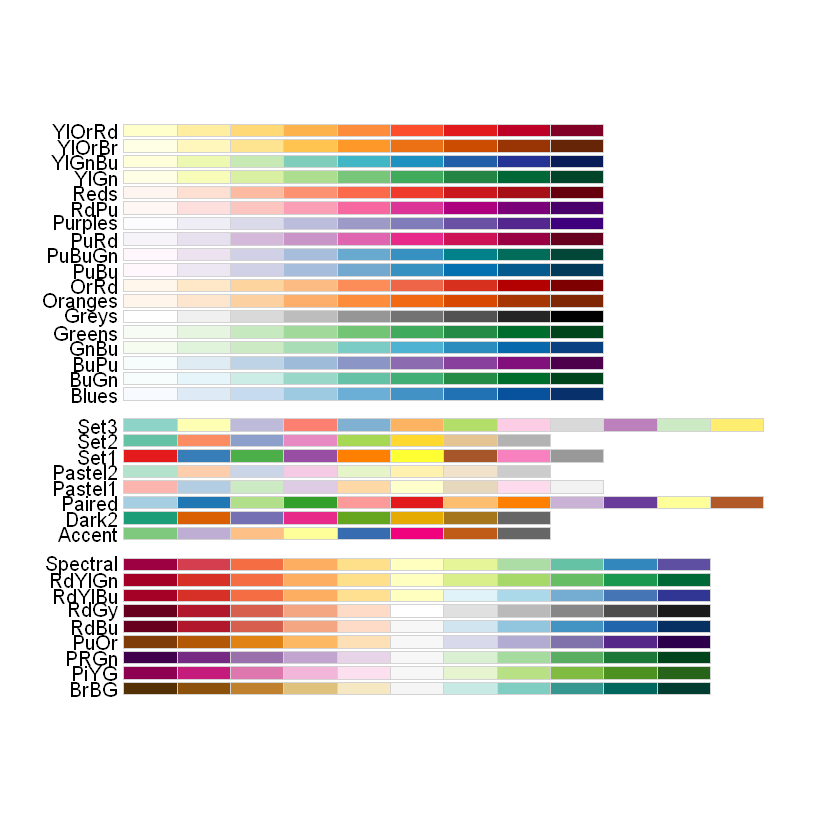

In [136]:









display.brewer.all()

#### gene function

In [ ]:
Sys.which("python")
Sys.setenv(RETICULATE_PYTHON = "/home/wg_looking/anaconda3/bin/python")
library(reticulate)
source_python("/NAS/wg_looking/gRNA_ONT/code/NCBI_gene_summary.py")
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/test_genes.RData")


ENSEMBL_ID_Entrez_ID_all <- read.table("/NAS/wg_looking/gRNA_ONT/database/ENSEMBL_ID_Entrez_ID_all.txt",
                                      header=T)
rownames(ENSEMBL_ID_Entrez_ID_all) <- ENSEMBL_ID_Entrez_ID_all$gene_id


sub <- sub[1:2,]


genes <- setNames(as.character(sub$gene_id), as.character(sub$gene_name))
genes <- sort(genes)
genes <- genes[!duplicated(genes)]
gene_function <- lapply(genes, function(gene_id){
     Entrez_ID = ENSEMBL_ID_Entrez_ID_all[gene_id, "ENTREZID"]
    gf = NCBI_gene_summary(as.character(Entrez_ID))  
    return(gf)
})

pp <- melt(gene_function)
colnames(pp) <- c("function", "gene_name")
pp <- pp[, c("gene_name", "function")]
write.table(pp, "stat/diff_TE_up_exon_gene_function.txt", col.names=T, row.names=F, sep="\t", quote=F)

In [55]:
load("E:/项目/转座子/sgRNA/results/Figure/test_genes.RData")

gostres <- gost(query=unique(genes),
                # custom_bg=totalGenes,
                organism = "hsapiens",
                user_threshold = 0.05,
                correction_method="gSCS")

gostres <- data.frame(gostres$result)
gostres[1:5,"term_name",drop=F]
gostres[gostres$source %in% c("GO:BP","KEGG"), c("p_value", "term_name", "source")]


### 位于i和u上的TE

In [ ]:
## new transcript with TE
trans_TE <- MDAMB231_Diff[[2]]
trans_TE$TE_name <- paste0(paste(trans_TE$TE_chr, trans_TE$TE_start, trans_TE$TE_end, sep="_"), ":", trans_TE$repeat_id)
trans_TE <- trans_TE[trans_TE$classification %in% c("intergenic", "intronic"),]
trans_TE2 <- MCF10A_Diff[[2]]
trans_TE2$TE_name <- paste0(paste(trans_TE2$TE_chr, 
                                  trans_TE2$TE_start, 
                                  trans_TE2$TE_end, sep="_"), ":", trans_TE2$repeat_id)
trans_TE2 <- trans_TE2[trans_TE2$classification %in% c("intergenic", "intronic"),]



length(intersect(trans_TE$TE_name, trans_TE2$TE_name))
length(setdiff(trans_TE$TE_name, trans_TE2$TE_name))
length(setdiff(trans_TE2$TE_name, trans_TE$TE_name))

In [ ]:
Diff <- list()
Diff[["MDAMB231"]] <- MDAMB231_Diff
Diff[["MCF10A"]] <- MCF10A_Diff
res$dif <- "ns"
res$dif[res$log2FoldChange>1 & res$padj<0.05] <- "Up"
res$dif[res$log2FoldChange< -1 & res$padj<0.05] <- "Down"
sub_res <- res[rownames(res) %in% trans_TE$TE_name | rownames(res) %in% trans_TE2$TE_name, ]

sub_res <- res[rownames(res) %in% trans_TE$TE_name & rownames(res) %in% trans_TE2$TE_name, ]
table(sub_res$dif)
sub_res <- res[rownames(res) %in% trans_TE$TE_name & !(rownames(res) %in% trans_TE2$TE_name), ]
table(sub_res$dif)
sub_res <- res[!(rownames(res) %in% trans_TE$TE_name) & (rownames(res) %in% trans_TE2$TE_name), ]
table(sub_res$dif)

In [ ]:
# pie
pp <- data.frame(table(sub_res$dif))

p <- pp %>%
    mutate(Percentage = Freq / sum(Freq)*100)
  
  
plot <- ggplot(p, aes(x="", y=Percentage, fill=Var1))+
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y", start=0) +
    scale_fill_manual(values = c(Down="#327FFF", Up="#FD7E29", ns="#AFAFAF"))+
    geom_text(aes(x = 1.6, label = paste0(Freq, "(",scales::percent(Percentage/100, accuracy = .1), ")")), 
              position = position_stack(vjust = .5)) +
    # facet_wrap(~Method)
    ggtitle("") +
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.border = element_blank(),
      panel.grid=element_blank(),
      axis.ticks = element_blank(),
      plot.title=element_text(size=14, face="bold", hjust=0.5),
      axis.text.x=element_blank()
    ) 


ggsave("stat/MDAMB231_VS_MCF10A_TE_i_u_dif_pie.pdf",
       width = 6, height = 3)



In [ ]:
sub.TE.norlCount <- TE.norlCount[rownames(res)[abs(res$log2FoldChange)>1 & res$padj<0.05], ]
pp <- melt(sub.TE.norlCount)
colnames(pp) <- c("TE_name", "ID", "norlCount")
pp$stat <- "Up"
pp$stat[pp$TE_name %in% rownames(res)[res$log2FoldChange< -1 & res$padj<0.05]] <- "Down"
pp$repeat_id <- tstrsplit(pp$TE_name, ":")[[2]]
pp$sub_repeat <- substring(pp$repeat_id, 1, 4)
pp$sub_repeat[grepl("L1P", pp$sub_repeat)] <- "L1P"
pp$CellLine <- tstrsplit(pp$ID, "_")[[2]]


## violin
p1 <- ggplot(pp, aes(x=sub_repeat, y=log2(norlCount+1), color=CellLine, fill=CellLine)) +
    geom_violin(alpha=0.4) + 
    stat_summary(fun= median, geom = "point",position = position_dodge(width = 0.9),
               shape = 23, size = 2, color = "red") +
    # geom_point(alpha=0.1) +
    # geom_jitter(width = 0.25, alpha=0.1) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    facet_wrap(~stat, nrow = 2) +
    scale_color_manual(values = c("#EF8354", "#4678BA")) +
    scale_fill_manual(values = c("#EF8354", "#4678BA")) +
    ggtitle("")


ggsave(paste0("stat/MDAMB231_vs_MCF10A_TE_repeat_family_normalCount.pdf"),
         width = 10, height = 6)


# bar
pp <- pp[order(pp$TE_name),]
pp2 <- pp[!(duplicated(pp$TE_name)),]
pp2 <- data.frame(table(pp2$stat, pp2$sub_repeat))
colnames(pp2) <- c("stat", "sub_repeat", "Freq")
p2 <- ggplot(pp2, aes(x=sub_repeat, y=Freq,  fill=stat)) +
    geom_bar(stat="identity", position=position_dodge(width=0.9)) + 
    geom_text(aes(label=Freq), position=position_dodge(width=0.9), vjust=-0.25) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    # facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_fill_manual(values = c("#EF8354", "#4678BA")) +
    # ylim(0,3200) +
    ggtitle("the count of differential expression TEs") 
   
  

ggsave(paste0("stat/MDAMB231_vs_MCF10A_TE_i_u_dif_count_bar.pdf"),
         width = 7, height = 4)
    

In [ ]:

TEtype_normalCount <- lapply(c("MDAMB231", "MCF10A"), function(CellLine){
    IDs <- Sample_info$Samples[Sample_info$CellLine %in% CellLine &
                                Sample_info$SeqType %in% c("sgRNA")]
    #
    quant <- TE.norlCount[, IDs]
    quant <- data.frame(TE_name=rownames(quant), quant, normalCount=rowMeans(quant))
    sub.TE <- rownames(res)[grepl(CellLine, res$dif)]
    quant <- quant[sub.TE, ]
    # 
    trans_TE <- Diff[[CellLine]][[2]]
    trans_TE$TE_name <- paste0(paste(trans_TE$TE_chr, trans_TE$TE_start, trans_TE$TE_end, sep="_"), ":", trans_TE$repeat_id)
    trans_TE <- trans_TE[trans_TE$classification %in% c("intergenic", "intronic"),]


    sub.quant <- merge(quant, trans_TE[, c("classification", "repeat_id", "TE_name", "matching_class")], by="TE_name")
    sub.quant <- sub.quant[order(sub.quant$TE_name),]
    sub.quant <- sub.quant[!duplicated(sub.quant),]
    
    #
    sub.quant$sub_repeat <- substring(sub.quant$repeat_id, 1, 4)
    sub.quant$sub_repeat[grepl("L1P", sub.quant$sub_repeat)] <- "L1P"
    #
    sub.quant <- data.frame(sub.quant[, !(colnames(sub.quant) %in% IDs)], 
                                  CellLine=CellLine)
    
    return(sub.quant)
})

pp <- rbindlist(TEtype_normalCount)



In [ ]:
library(patchwork)

pp <- rbindlist(TEtype_normalCount)


p1 <- ggplot(pp, aes(x=sub_repeat, y=log2(normalCount+1), color=matching_class, fill=matching_class)) +
    geom_violin(alpha=0.4) + 
    stat_summary(fun= median, geom = "point",
               shape = 23, size = 2, color = "red") +
    # geom_point(alpha=0.1) +
    # geom_jitter(width = 0.25, alpha=0.1) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    facet_wrap(classification~CellLine, nrow = 2) +
    scale_color_manual(values = c("#EF8354", "#4678BA")) +
    scale_fill_manual(values = c("#EF8354", "#4678BA")) +
    ggtitle("")


ggsave(paste0("stat/MDAMB231_vs_MCF10A_TE_in_i_u_transcripts_repeat_family_normalCount.pdf"),
         width = 10, height = 6)


pp2 <- data.frame(table(pp$CellLine, pp$matching_class, pp$sub_repeat))
colnames(pp2) <- c("CellLine", "matching_class", "sub_repeat", "Freq")
pp2 <- pp2[pp2$Freq>0,] 

p2 <- ggplot(pp2, aes(x=sub_repeat, y=Freq,  fill=matching_class)) +
    geom_bar(stat="identity") + 
    geom_text(aes(label=Freq), position=position_dodge(width=0.9), vjust=-0.25) +
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold")
    ) +
    facet_wrap(~CellLine, nrow = 1, scales="free") +
    scale_fill_manual(values = c("#EF8354", "#4678BA")) +
    ggtitle("") +
    ylim(0,7000)
  


p <- p1 + p2 + plot_layout(ncol = 1, heights = c(1, 1))

ggsave(paste0("stat/MDAMB231_vs_MCF10A_TE_in_i_u_transcripts_repeat_family_normalCount.pdf"),
         width = 10, height = 6)
    

## HCT116 vs NCM460

In [ ]:
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/HCT116_NCM460_diff.Data")
load("stat/MDAMB231_MCF10A_diff.Data")
load("stat/assembly_preData.RData")
load("stat/TE.quantify.count.RData")


# load Sample info
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples

SampleIDs <- Sample_info$Samples[Sample_info$CellLine %in% c("HCT116", "NCM460") &
                                Sample_info$SeqType %in% c("sgRNA")]



In [ ]:
# sgRNA count > 3 at least 3 samples
library(DESeq2)

SampleIDs <- Sample_info$Samples[Sample_info$CellLine %in% c("HCT116", "NCM460") &
                                Sample_info$SeqType %in% c("sgRNA")]
sub.count.tb <- count.tb[, SampleIDs]
sub.count.tb <- sub.count.tb[apply(sub.count.tb, 1, function(x){ (sum(x>=3))>=3 }),]
dim(sub.count.tb) # 75933
sub.count.tb <- round(sub.count.tb)

# run DESeq2
colInfo <- Sample_info[SampleIDs, c("CellLine"), drop=F]
dds <- DESeqDataSetFromMatrix(sub.count.tb, 
                                colInfo, 
                                ~CellLine)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
                )
TE.norlCount <- counts(Object, normalized=T)

res <- results(Object, contrast=c("CellLine", "HCT116", "NCM460"))
# res <- res[complete.cases(res),]
save(TE.norlCount, res, file="stat/HCT116_vs_NCM460_TE_res.RData")

dif_res <- res
dif_res <- res[res$padj<0.05 & abs(res$log2FoldChange)>1, ]
table(dif_res$log2FoldChange>1)


dif_res2 <- dif_res[rownames(dif_res) %in% trans_TE$TE_name |
       rownames(dif_res) %in% trans_TE2$TE_name,]
table(dif_res2$log2FoldChange>1)

In [ ]:
load("stat/TE_location.RData")
load("stat/HCT116_vs_NCM460_TE_res.RData")


out_res <- data.frame(TE.norlCount, res[, c("baseMean", "log2FoldChange", "pvalue", "padj")])
out_res$dif <- "ns"
out_res$dif[res$padj<0.05 & res$log2FoldChange>1] <- "Up"
out_res$dif[res$padj<0.05 & res$log2FoldChange < -1] <- "Down"
table(out_res$dif)
out_res <- out_res[order(out_res$dif, decreasing=T),]
out_res <- data.frame(gene_id=rownames(out_res), out_res)
colnames(out_res)[1] <- "TE_name"

# out_res <- data.frame(out_res, TE_location[rownames(out_res), c("sub_repeat", "exon", "intron", "intergenic",
#                                                                 "gene_id", "gene_name")])
out_res <- merge(out_res, TE_location, by="TE_name")
out_res$gene_id <- as.character(out_res$gene_id)

# out_res <- gene_res[transcript_res$padj<0.05 & abs(transcript_res$log2FoldChange)>2 & transcript_res$baseMean>10, ]
# write.table(out_res, "stat/MDAMB231_vs_MCF10A_differential_genes.txt", row.names = F, col.names = T, quote = F, sep="\t")
write.table(out_res, "stat/HCT116_vs_NCM460_all_TEs.txt", row.names = F, col.names = T, quote = F, sep="\t")




## correlation: CRC and BC

In [ ]:
load("stat/TE.count.DESeq2.Object.RData")
load("stat/MDAMB231_vs_MCF10A_TE_res.RData")
BC_res <- res
load("stat/HCT116_vs_NCM460_TE_res.RData")
CRC_res <- res


TE.norlCount <- counts(Object, normalized=T)
cancer_Up <- intersect(rownames(BC_res)[BC_res$log2FoldChange>1 & BC_res$padj<0.05],
                      rownames(CRC_res)[CRC_res$log2FoldChange>1 & CRC_res$padj<0.05])

cancer_Down <- intersect(rownames(BC_res)[BC_res$log2FoldChange< -1 & BC_res$padj<0.05],
                      rownames(CRC_res)[CRC_res$log2FoldChange< -1 & CRC_res$padj<0.05])



pheatmap(cor(TE.norlCount[cancer_Up, ], method = "spearman"),
         display_numbers=T,
         # annotation_col = colInfo,
         # annotation_row = colInfo,
         # annotation_colors = anno_colors,
         main="Correlation of TE normalized Count ",
         # col=colorRampPalette(rev(brewer.pal(11,"RdYlBu")[3:10]))(21),
         col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(100),
         border="white",
         width=6.5,
         height=6,
         # show_rownames=F,
         # show_colnames=F,
         filename="stat/TE_count_spearman_correlation_cancer_up.pdf")


pheatmap(cor(TE.norlCount[cancer_Down, ], method = "spearman"),
         display_numbers=T,
         # annotation_col = colInfo,
         # annotation_row = colInfo,
         # annotation_colors = anno_colors,
         main="Correlation of TE normalized Count ",
         # col=colorRampPalette(rev(brewer.pal(11,"RdYlBu")[3:10]))(21),
         col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(100),
         border="white",
         width=6.5,
         height=6,
         # show_rownames=F,
         # show_colnames=F,
         filename="stat/TE_count_spearman_correlation_cancer_Down.pdf")


pheatmap(cor(TE.norlCount[c(cancer_Down, cancer_Up), ], method = "spearman"),
         display_numbers=T,
         # annotation_col = colInfo,
         # annotation_row = colInfo,
         # annotation_colors = anno_colors,
         main="Correlation of TE normalized Count ",
         # col=colorRampPalette(rev(brewer.pal(11,"RdYlBu")[3:10]))(21),
         col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(100),
         border="white",
         width=6.5,
         height=6,
         # show_rownames=F,
         # show_colnames=F,
         filename="stat/TE_count_spearman_correlation_cancer.pdf")



## TE expression in i, u and span

In [ ]:
# TE activity
library(bedtoolsr)
library(DESeq2)
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/assembly_preData.RData") # "gtf.tb.list"  "RM.tb.list"   "RM.tb.list2"  "tmap.tb.list"
load("stat/HCT116_NCM460_diff.Data")
load("stat/MDAMB231_MCF10A_diff.Data")
load("stat/hg38.gtf.RData")
load("stat/hg38.gene.transcript.gtf.RData")
load("stat/TE_location.RData")
load("stat/TE.quantify.count.RData")


# load Sample info
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples

SampleIDs <- Sample_info$Samples[Sample_info$CellLine %in% c("MDAMB231", "MCF10A", "HCT116", "NCM460") &
                                Sample_info$SeqType %in% c("sgRNA")]



## activity TE
Diff.list <- list(MDAMB231=MDAMB231_Diff, MCF10A=MCF10A_Diff,
                  HCT116=HCT116_Diff, NCM460=NCM460_Diff)

activity_TE.list <- lapply(names(Diff.list), function(CellLine){
    Diff <- Diff.list[[CellLine]] 
    sub.diff <- Diff[[2]][Diff[[2]]$type %in% c("TES", "TSS"), ]
    # sub.diff <- sub.diff[sub.diff$classification %in% c("intronic", "span_intergenic_and_genic", "intergenic"), ]
    #
    sub <- sub.diff[sub.diff$classification %in% c("intergenic"), ]
    TE <- sub[, c("TE_chr", "TE_start", "TE_end", "TE_name")]
    TE <- TE[order(TE$TE_chr, TE$TE_start),]
    intergenic_bed <- read.table("/NAS/wg_looking/human_ref/gencode.v37.chr_patch_hapl_scaff.annotation.intergenic.bed", 
                         stringsAsFactors = F)
    intergenic_res <- bt.intersect(a=TE, intergenic_bed, wa=T)
    colnames(intergenic_res) <- colnames(TE)
    sub <- sub[sub$TE_name %in% intergenic_res$TE_name, ]
    #
    sub.diff <- rbind(sub.diff[sub.diff$classification %in% c("intronic", "intergenic"), ],
                sub)
    
    TE_name <- data.frame(TE_name=unique(sub.diff$TE_name), CellLine=CellLine)
    
    return(TE_name)

})


activity_TE <- rbindlist(activity_TE.list)
activity_TE <- as.data.frame.matrix(table(activity_TE$TE_name, activity_TE$CellLine))
table(rowSums(activity_TE))



In [ ]:
library(gtools)

TE_expr <- count.tb[rownames(activity_TE), SampleIDs]
dim(TE_expr) # 30579 12
TE_expr <- round(TE_expr)

# run DESeq2
colInfo <- Sample_info[SampleIDs, c("CellLine", "TissueType")]
dds <- DESeqDataSetFromMatrix(TE_expr, 
                                colInfo, 
                                ~CellLine)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
                )
TE.norlCount <- counts(Object, normalized=T)

# combs <- combinations(length(unique(colInfo$CellLine)), 2, unique(colInfo$CellLine))
# combs <- t(data.frame(comb1=c("HCT116","MDAMB231"), 
#                     comb2=c("MCF10A","NCM460"), 
#                     comb3=c("HCT116","NCM460"), 
#                     comb4=c("MDAMB231", "MCF10A")))
combs <- t(data.frame(comb2=c("HCT116","NCM460"), 
                    comb4=c("MDAMB231", "MCF10A")))
dif_TE <- c()
for(i in 1:dim(combs)[1]){
    comb <- combs[i,]
    res <- results(Object, contrast=c("CellLine", comb[1], comb[2]))
    res <- res[complete.cases(res), ]
    dif_res <- res[res$padj<0.05 & abs(res$log2FoldChange)>1, ]
    dif_TE <- c(dif_TE, rownames(dif_res))
}
dif_TE <- unique(dif_TE)
length(dif_TE)


# heatmap plot
rowInfo <- activity_TE[dif_TE, ]
rowInfo <- data.frame(apply(rowInfo, 2, as.character))
rownames(rowInfo) <- dif_TE
colInfo <- Sample_info[Sample_info$Samples %in% SampleIDs, "CellLine", drop=F]
anno_colors <- list(CellLine=c(HCT116="#FC8D62", NCM460="#31A354", MDAMB231="#FFD92F", MCF10A="#43A2CA"),
                   HCT116=c("1"="#FC8D62", "0"="#F0F9E8"),
                   NCM460=c("1"="#31A354", "0"="#F0F9E8"),
                   MDAMB231=c("1"="#FFD92F", "0"="#F0F9E8"),
                   MCF10A=c("1"="#43A2CA", "0"="#F0F9E8"))

pheatmap(TE.norlCount[dif_TE,],
         # display_numbers=T,
         scale="row",
         annotation_col = colInfo,
         annotation_row = rowInfo,
         annotation_colors = anno_colors,
         main="differential TE expression",
         col=colorRampPalette(rev(brewer.pal(11,"RdBu")))(21),
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         border=NA,
         show_rownames=F,
         show_colnames=F,
         # cluster_row=F,
         width=5,
         height=6,
         filename="stat/CRC_BC_TE_dif_heatmap.pdf")







In [ ]:

combs <- t(data.frame(comb2=c("HCT116","NCM460"), 
                    comb4=c("MDAMB231", "MCF10A")))


dif_TE.list <- list()
for(i in 1:dim(combs)[1]){
    comb <- combs[i,]
    n <- paste0(comb[1], "_vs_", comb[2])
    res <- results(Object, contrast=c("CellLine", comb[1], comb[2]))
    res <- res[complete.cases(res), ]
    dif_TE <- rownames(res)[res$padj<0.05 & res$log2FoldChange>1]
    dif_TE.list[[n]] <- dif_TE
}


up <- intersect(dif_TE.list[[1]], dif_TE.list[[2]])
table(TE_location[up, "sub_repeat"])
c <- colSums(TE_location[up, c("intron", "intergenic")])
genomic_location_pct <- c/sum(c)



TE_location[up, ]

In [ ]:
# Tumor vs Normal
load("stat/TE_location.RData")

dds <- DESeqDataSetFromMatrix(TE_expr, 
                                colInfo, 
                                ~TissueType)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
                )

res <- results(Object, contrast=c("TissueType", "Tumor", "Normal"))
res <- res[complete.cases(res), ]
Up <- res[res$padj<0.05 & res$log2FoldChange>1, ]
Up <- data.frame(Up, TE_location[rownames(Up),])
up_pct <- table(Up$sub_repeat)/sum(table(Up$sub_repeat))
bg_pct <- table(TE_location[rownames(activity_TE), "sub_repeat"])/sum(table(TE_location[rownames(activity_TE), "sub_repeat"]))

c <- colSums(Up[, c("intron", "intergenic")])
genomic_location_pct <- c/sum(c)


c <- colSums(TE_location[rownames(activity_TE), c("intron", "intergenic")])
genomic_location_pct <- c/sum(c)



In [ ]:
# MDAMB231 MCF10A HCT116 NCM460

activity_TE[,]







## TE expression in BC and CRC

In [ ]:
# TE activity
library(bedtoolsr)
library(DESeq2)
library(data.table)
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/assembly_preData.RData") # "gtf.tb.list"  "RM.tb.list"   "RM.tb.list2"  "tmap.tb.list"
load("stat/HCT116_NCM460_diff.Data")
load("stat/MDAMB231_MCF10A_diff.Data")
load("stat/hg38.gtf.RData")
load("stat/hg38.gene.transcript.gtf.RData")
load("stat/TE_location.RData")
load("stat/TE.quantify.count.RData")


# load Sample info
Sample_info <- read.table("stat/Sample_info2.txt", header = T, stringsAsFactors = F)
rownames(Sample_info) <- Sample_info$Samples

SampleIDs <- Sample_info$Samples[Sample_info$CellLine %in% c("MDAMB231", "MCF10A", "HCT116", "NCM460") &
                                Sample_info$SeqType %in% c("sgRNA")]



## activity TE
Diff.list <- list(MDAMB231=MDAMB231_Diff, MCF10A=MCF10A_Diff,
                  HCT116=HCT116_Diff, NCM460=NCM460_Diff)

activity_TE.list <- lapply(names(Diff.list), function(CellLine){
    Diff <- Diff.list[[CellLine]] 
    sub.diff <- Diff[[2]][Diff[[2]]$type %in% c("TES", "TSS"), ]
    # sub.diff <- Diff[[2]]
    sub.diff <- sub.diff[!(sub.diff$ref_gene_id %in% "-"), ]
    
    TE_name <- data.frame(TE_name=unique(sub.diff$TE_name), CellLine=CellLine)
    
    return(TE_name)

})


activity_TE <- rbindlist(activity_TE.list)
activity_TE <- as.data.frame.matrix(table(activity_TE$TE_name, activity_TE$CellLine))
table(rowSums(activity_TE))
dim(activity_TE) # 43085


In [ ]:
library(gtools)

TE_expr <- count.tb[, SampleIDs]
TE_expr <- TE_expr[apply(TE_expr, 1, function(x){sum(x>=3)>=3}), ]
dim(TE_expr) # 105771     12
TE_expr <- round(TE_expr)

# run DESeq2
colInfo <- Sample_info[SampleIDs, c("CellLine", "TissueType")]
dds <- DESeqDataSetFromMatrix(TE_expr, 
                                colInfo, 
                                ~CellLine)
Object <- DESeq(dds
                # parallel = T, BPPARAM=MulticoreParam(10)
                )
TE.norlCount <- counts(Object, normalized=TRUE)

# combs <- combinations(length(unique(colInfo$CellLine)), 2, unique(colInfo$CellLine))
# combs <- t(data.frame(comb1=c("HCT116","MDAMB231"), 
#                     comb2=c("MCF10A","NCM460"), 
#                     comb3=c("HCT116","NCM460"), 
#                     comb4=c("MDAMB231", "MCF10A")))
combs <- list(c("HCT116","NCM460"), 
                    c("MDAMB231", "MCF10A"))
res.list <- list()
dif_TE.list <- list()
for(comb in combs){
    print(comb)
    res <- results(Object, contrast=c("CellLine", comb[1], comb[2]))
    res <- res[complete.cases(res), ]
    Up <- rownames(res[res$padj<0.05 & res$log2FoldChange>1, ])
    Down <- rownames(res[res$padj<0.05 & res$log2FoldChange< -1, ])
    n <- paste0(comb[1], "_vs_", comb[2])
    
    dif_TE.list[[n]] <- list(Up=Up, Down=Down)
    res.list[[n]] <- res
}


length(intersect(dif_TE.list[[1]]$Up, dif_TE.list[[2]]$Up))
length(intersect(dif_TE.list[[1]]$Down, dif_TE.list[[2]]$Down))
dif_TE <- unique(unlist(dif_TE.list))
length(dif_TE) # 17108
save(TE.norlCount, res.list, dif_TE.list, file="stat/BC_CRC_TE_count_and_dif.RData")








In [ ]:
library(pheatmap)
setwd("/NAS/wg_looking/gRNA_ONT")
load("stat/BC_CRC_TE_count_and_dif.RData") # TE.norlCount, dif_TE.list
dif_TE <- unique(unlist(dif_TE.list))
length(dif_TE) # 17108



# heatmap plot
rowInfo <- data.frame(TE_name=dif_TE)
rownames(rowInfo) <- dif_TE
# rowInfo <- data.frame(rowInfo, activity_TE[rownames(rowInfo),])
# rowInfo[is.na(rowInfo)] <- 0
rowInfo$HCT116_up <- 0
rowInfo$HCT116_up[rownames(rowInfo) %in% dif_TE.list[["HCT116_vs_NCM460"]][["Up"]]] <- 1
rowInfo$MDAMB231_up <- 0
rowInfo$MDAMB231_up[rownames(rowInfo) %in% dif_TE.list[["MDAMB231_vs_MCF10A"]][["Up"]]] <- 1
rowInfo$MCF10A_up <- 0
rowInfo$MCF10A_up[rownames(rowInfo) %in% dif_TE.list[["MDAMB231_vs_MCF10A"]][["Down"]]] <- 1
rowInfo$NCM460_up <- 0
rowInfo$NCM460_up[rownames(rowInfo) %in% dif_TE.list[["HCT116_vs_NCM460"]][["Down"]]] <- 1
####
rowInfo$log2FC_BC <- res.list[["MDAMB231_vs_MCF10A"]][rownames(rowInfo), "log2FoldChange"]
rowInfo$log2FC_CRC <- res.list[["HCT116_vs_NCM460"]][rownames(rowInfo), "log2FoldChange"]
rowInfo <- rowInfo[,-1]
rowInfo <- rowInfo[order(rowInfo$HCT116_up, 
                         # rowInfo$log2FC_CRC, 
                         rowInfo$MDAMB231_up, 
                         # rowInfo$log2FC_BC, 
                         rowInfo$MCF10A_up, 
                         rowInfo$NCM460_up, 
                         decreasing=T), ]
# rowInfo <- data.frame(apply(rowInfo, 2, as.character))
# rownames(rowInfo) <- dif_TE

colInfo <- Sample_info[Sample_info$Samples %in% SampleIDs, "CellLine", drop=F]

sub.TE.norlCount <- TE.norlCount[rownames(rowInfo),]

k=10
pheatmap.p <- pheatmap(sub.TE.norlCount, scale="row", cutree_rows=k)
hc <- hclust(dist(rowInfo[,5:8], method="binary"), method = "complete")
clusters <- cutree(pheatmap.p$tree_row, k=k)
rowInfo$cluster <- as.character(cluster)
table(rowInfo$cluster)

anno_colors <- list(CellLine=c(HCT116="#FC8D62", NCM460="#31A354", MDAMB231="#FFD92F", MCF10A="#43A2CA"),
                   cluster=setNames(brewer.pal(12, "Paired")[1:k], unique(rowInfo$cluster)))


pheatmap(t(sub.TE.norlCount),
         # display_numbers=T,
         scale="column",
         annotation_col = rowInfo[, 1:4, drop=F],
         annotation_row = colInfo,
         annotation_colors = anno_colors,
         # cutree_cols=10,
         main="differential TE expression",
         col=colorRampPalette(rev(brewer.pal(11,"RdBu")))(21),
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         border=NA,
         show_rownames=F,
         show_colnames=F,
         cluster_col=F,
         # cluster_col=hc,
         # cluster_row=F,
         width=7,
         height=7,
         filename="stat/CRC_BC_TE_dif_heatmap.pdf")



In [ ]:
library(dendsort)
method1 = c("euclidean", "maximum", "manhattan", "canberra", "minkowski", "binary")
method2 = c("ward.D", "ward.D2", "single",  "complete", "average")
method3 = c("average","min")
for(i in method1){
  for(j in method2){
    for(z in method3){
      filename= paste("stat/CRC_BC_TE_dif_heatmap_", i, "_", j, "_",z,".pdf", sep="")
      title = paste("distance:", i, " hclust:",j, " type:",z, sep = "")
      if(file.exists(filename)==FALSE){
          try(
              pheatmap(
                t(sub.TE.norlCount),
                col=colorRampPalette(rev(brewer.pal(11,"RdBu")))(21),
                breaks = c(-4,seq(-3,3,length=20),4),
                legend_breaks = c(-3,-1,1,3),
                filename = filename,
                scale="column",
                main = title,
                width = 7,
                height = 3,
                # clustering_method = "complete",
                border_color=NA,
                # fontsize_col = 0.5,
                # annotation_row = geneCluster,
                # annotation_col = colInfo,
                annotation_row = colInfo,
                annotation_colors = anno_colors,
                annotation_legend = T,
                show_rownames = F,
                show_colnames = F,
                # cluster_rows = F,
                cluster_cols = as.hclust(dendsort(hclust(dist(sub.TE.norlCount, method=i), method = j), type=z))
              ), 
              silent=TRUE)
                  

      
      }
    }
  }
}
##


In [ ]:
# new transcript density
rowInfo <- data.frame(TE_name=dif_TE)
rownames(rowInfo) <- dif_TE
rowInfo <- data.frame(rowInfo, activity_TE[rownames(rowInfo),])
rowInfo[is.na(rowInfo)] <- 0
rowInfo <- data.frame(apply(rowInfo, 2, as.character))
rownames(rowInfo) <- dif_TE


pp <- rowInfo[pheatmap.p$tree_row$order, ]
pp <- rbindlist(list(data.frame(logic=pp$MDAMB231, ID="MDAMB231"),
               data.frame(logic=pp$MCF10A, ID="MCF10A"),
               data.frame(logic=pp$HCT116, ID="HCT116"),
               data.frame(logic=pp$NCM460, ID="NCM460")))
step <- 50
winSet <- rep(1:ceiling(dim(pp)[1]/4/step), each = step)[1:(dim(pp)[1]/4)]
pp$order <- rep(winSet, 4)
# pp.sum <- aggregate(logic~ID+order, data=pp, sum)
pp$logic <- as.numeric(as.character(pp$logic))
# pp$order <- rep(1:(dim(pp)[1]/4), 4)
ppp <- pp[!(pp$logic==0), ]
ppp$ID <- factor(ppp$ID, levels=c("HCT116", "MDAMB231", "MCF10A", "NCM460"))

cols <- c(HCT116="#FC8D62", NCM460="#31A354", MDAMB231="#FFD92F", MCF10A="#43A2CA")
ggplot(ppp, aes(x=order, color=ID)) +
    geom_density() + 
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    scale_color_manual(values = cols) +
    # facet_wrap(~ID, scales="free", ncol=1) +
    # facet_grid(scales="free", rows=vars(ID)) +
    # scale_x_log10() +
    ggtitle("") 
  
ggsave("stat/Fig4.TE_activity_new_transcripts_density.pdf", width=7, height=2)




### cluster TE in oncogenes

In [ ]:
# oncogenes
load("stat/TE_location.RData")
load("stat/hg38.gene.transcript.gtf.RData")
load("stat/BC_CRC_TE_count_and_dif.RData") # TE.norlCount, dif_TE.list
tumor_genes <- read.table("database/NG_tumor_related_genes.txt")
ID.list <- list(BC=c("MDAMB231", "MCF10A"),
                CRC=c("HCT116", "NCM460"))

# background
bg_genes <- unique(TE_location[rownames(TE.norlCount), "gene_name"])
bg_genes <- bg_genes[complete.cases(bg_genes)]
bg_tt <- table(bg_genes %in% tumor_genes$V1)
# dif TE anno
dif_TE <- reshape2::melt(dif_TE.list)
colnames(dif_TE) <- c("TE_name", "dif", "Compare")
dif_TE <- merge(dif_TE, TE_location, by="TE_name")

gene_names <- lapply(dif_TE$gene_name, function(x){strsplit(x, ",")[[1]]})
names(gene_names) <- dif_TE$TE_name
gene_names <- reshape2::melt(gene_names)
colnames(gene_names) <- c("gene_name", "TE_name")
dif_TE <- merge(dif_TE, gene_names, by="TE_name")
dif_TE$Tumor_genes <- 0
dif_TE$Tumor_genes[dif_TE$gene_name.y %in% tumor_genes$V1] <- 1
    

# cluster
k<- 10
clusters <- cutree(pheatmap.p$tree_row, k=k)
test_res <- lapply(1:k, function(cluster){
    cluster_TE <- names(clusters)[clusters %in% cluster]
    a1 <- unique(dif_TE$TE_name[dif_TE$TE_name %in% cluster_TE & dif_TE$Tumor_genes %in% 1])
    a2 <- unique(dif_TE$TE_name[dif_TE$TE_name %in% cluster_TE & dif_TE$Tumor_genes %in% 0])
    # if(a1>0)
    x <- c(length(a1), length(a2), bg_tt["TRUE"], bg_tt["FALSE"])
    x <- matrix(x, ncol = 2)
    pvalue <- chisq.test(x)$p.value # 0.01910379
    ratio= (length(a1)/sum(c(length(a1), length(a2)))) / (bg_tt["TRUE"]/sum(bg_tt))
    log2FC <-  log2(ratio) # 0.822162

    res <- data.frame(cluster=cluster,
                     pvalue=pvalue,
                     log2FC=log2FC)  

})



pp <- rbindlist(test_res)
pp$padj <- p.adjust(pp$pvalue, method = "fdr", n = length(pp$pvalue))
# pp <- pp[order(pp$pvalue, decreasing=TRUE),]
pp <- pp[order(pp$log2FC),]
pp$cluster <- paste0("Cluster", pp$cluster)
pp$cluster <- factor(pp$cluster, levels=pp$cluster)

ggplot(pp, aes(x=cluster, y=log2FC, fill=padj)) +
      geom_bar(stat="identity", width = 0.8) +
      theme_bw() +
      theme(panel.grid = element_blank(),
            plot.title = element_text(hjust = 0, size = 12),
            axis.text.x  = element_text(angle = 0, hjust=0.5, vjust=0.5, 
                                        colour = "black", size = 11),
            axis.text.y  = element_text(colour = "black"),
            # legend.position = c(0.8,0.8),
            strip.background = element_rect(fill="white", colour = "black", size=1) ,
            legend.title = element_text(face="bold")) +
      # geom_text(aes(label=symbol), vjust=0.5, hjust=0,size=4, colour="black") +
      # annotate("text", x=pp$NAME[2], y=-1.5,size=3,
      #          label="nominal P values: \n*P < 0.05 \n**P < 0.005 \n***P < 0.0005 \nNS: not significant") +
      # scale_x_discrete(limits=c(pp$term.name))+
      # scale_fill_manual(values=c("GO:BP"="#4678BA", "KEGG"="#EF8354")) +
      coord_flip() +
      geom_hline(yintercept = 0.3, color="red", linetype="dashed") +
      xlab("") +
      ggtitle("TE related oncogenes")
    # facet_grid(.~module, scales = "free_x", space = "free_x") 


ggsave(paste0("stat/BC_CRC_cluster_TE_oncogenes_chisq_test_bar.pdf"),
       height = 3, width = 6)




##
k <- 10
clusters <- cutree(pheatmap.p$tree_row, k=k)
clusters.tb <- data.frame(TE_name=names(clusters), cluster=clusters)
out_TE <- merge(dif_TE, clusters.tb, by="TE_name")
write.table(out_TE, file="stat/BC_CRC_dif_TE_oncogenes.txt", sep="\t", quote=FALSE, row.names=FALSE, col.names=TRUE)





### upTE in oncogenes

In [ ]:
# oncogenes
load("stat/TE_location.RData")
load("stat/hg38.gene.transcript.gtf.RData")
tumor_genes <- read.table("database/NG_tumor_related_genes.txt")
ID.list <- list(BC=c("MDAMB231", "MCF10A"),
                CRC=c("HCT116", "NCM460"))
gene.Files <- list(BC="stat/MDAMB231_vs_MCF10A_all_genes.txt",
                   CRC="stat/HCT116_vs_NCM460_all_genes.txt")


test_res <- lapply(names(ID.list), function(T){
    file <- gene.Files[[T]]
    gene.tb <- read.table(file, header = TRUE)
    bg <- unique(gene.tb$gene_name)
    bg_tt <- table(bg %in% tumor_genes$V1)
    
    IDs <- ID.list[[T]]
    vs <- paste(IDs[1], IDs[2], sep="_vs_")
    dif_TE <- reshape2::melt(dif_TE.list[[vs]])
    colnames(dif_TE) <- c("TE_name", "dif")
    dif_TE <- merge(dif_TE, TE_location, by="TE_name")

    gene_names <- lapply(dif_TE$gene_name, function(x){strsplit(x, ",")[[1]]})
    names(gene_names) <- dif_TE$TE_name
    gene_names <- reshape2::melt(gene_names)
    colnames(gene_names) <- c("gene_name", "TE_name")
    dif_TE <- merge(dif_TE, gene_names, by="TE_name")
    dif_TE$Tumor_genes <- 0
    dif_TE$Tumor_genes[dif_TE$gene_name.y %in% tumor_genes$V1] <- 1
    
    
    a <- lapply(c("Up", "Down"), function(stat){   
        a1 <- unique(dif_TE$TE_name[dif_TE$dif %in% stat & dif_TE$Tumor_genes %in% 1])
        a2 <- unique(dif_TE$TE_name[dif_TE$dif %in% stat & dif_TE$Tumor_genes %in% 0])
        x <- c(length(a1), length(a2), bg_tt["TRUE"], bg_tt["FALSE"])
        x <- matrix(x, ncol = 2)
        pvalue <- chisq.test(x)$p.value # 0.01910379
        ratio= (length(a1)/sum(c(length(a1), length(a2)))) / (bg_tt["TRUE"]/sum(bg_tt))
        log2FC <-  log2(ratio) # 0.822162

        res <- data.frame(vs=vs,
                          stat=stat,
                         pvalue=pvalue,
                         log2FC=log2FC)
    
    })

    
})






In [ ]:

pp <- rbindlist(lapply(test_res, rbindlist))
pp$padj <- p.adjust(pp$pvalue, method = "fdr", n = length(pp$pvalue))
pp <- pp[order(pp$pvalue, decreasing=TRUE),]
pp$ID <- paste(pp$vs, pp$stat, sep=":")
pp$ID <- factor(pp$ID, levels=pp$ID)

ggplot(pp, aes(x=ID, y=log2FC, fill=pvalue)) +
      geom_bar(stat="identity", width = 0.8) +
      theme_bw() +
      theme(panel.grid = element_blank(),
            plot.title = element_text(hjust = 0, size = 12),
            axis.text.x  = element_text(angle = 0, hjust=0.5, vjust=0.5, 
                                        colour = "black", size = 11),
            axis.text.y  = element_text(colour = "black"),
            # legend.position = c(0.8,0.8),
            strip.background = element_rect(fill="white", colour = "black", size=1) ,
            legend.title = element_text(face="bold")) +
      # geom_text(aes(label=symbol), vjust=0.5, hjust=0,size=4, colour="black") +
      # annotate("text", x=pp$NAME[2], y=-1.5,size=3,
      #          label="nominal P values: \n*P < 0.05 \n**P < 0.005 \n***P < 0.0005 \nNS: not significant") +
      # scale_x_discrete(limits=c(pp$term.name))+
      # scale_fill_manual(values=c("GO:BP"="#4678BA", "KEGG"="#EF8354")) +
      coord_flip() +
      geom_hline(yintercept = 0.3, color="red", linetype="dashed") +
      xlab("") +
      ggtitle("TE related oncogenes")
    # facet_grid(.~module, scales = "free_x", space = "free_x") 


ggsave(paste0("stat/BC_CRC_TE_oncogenes_chisq_test_bar.pdf"),
       height = 3, width = 6)





### (gene log2FC) vs (gene newtrans count)

In [ ]:
library(ggpubr)

## activity TE
load("stat/TE_location.RData")
BC_genes <- read.table("stat/MDAMB231_vs_MCF10A_all_genes.txt", header=T)
CRC_genes <- read.table("stat/HCT116_vs_NCM460_all_genes.txt", header=T)
Diff.list <- list(MDAMB231=MDAMB231_Diff, MCF10A=MCF10A_Diff,
                  HCT116=HCT116_Diff, NCM460=NCM460_Diff)


## for BC
dif_TE <- reshape2::melt(dif_TE.list[["MDAMB231_vs_MCF10A"]])
colnames(dif_TE) <- c("TE_name", "dif")
sub.TE_location <- merge(dif_TE, TE_location[, c("TE_name", "gene_id")], by="TE_name")
relate_genes <- sub.TE_location$gene_id
relate_genes <- lapply(relate_genes, function(x){strsplit(x, ",")[[1]]})
names(relate_genes) <- sub.TE_location$TE_name
TE.genes <- reshape2::melt(relate_genes)
colnames(TE.genes) <- c("gene_id", "TE_name")
TE.genes <- TE.genes[complete.cases(TE.genes), ]
df <- merge(TE.genes, BC_genes[, c("gene_id", "log2FoldChange", "dif")], by="gene_id")
colnames(df)[4] <- "gene_dif"
df <- merge(df, dif_TE, by="TE_name")

nc <- data.frame(table(MDAMB231_Diff[[1]]$ref_gene_id))
rownames(nc) <- nc$Var1
df$MDAMB231_gene_include_newTrans <- nc[as.character(df$gene_id), "Freq"]
df$MDAMB231_gene_include_newTrans[is.na(df$MDAMB231_gene_include_newTrans)] <- 0

nc <- data.frame(table(MCF10A_Diff[[1]]$ref_gene_id))
rownames(nc) <- nc$Var1
df$MCF10A_gene_include_newTrans <- nc[as.character(df$gene_id), "Freq"]
df$MCF10A_gene_include_newTrans[is.na(df$MCF10A_gene_include_newTrans)] <- 0
df$newTrans_count_diff <- df$MDAMB231_gene_include_newTrans-df$MCF10A_gene_include_newTrans
BC_df <- df


## for CRC
dif_TE <- reshape2::melt(dif_TE.list[["HCT116_vs_NCM460"]])
colnames(dif_TE) <- c("TE_name", "dif")
sub.TE_location <- merge(dif_TE, TE_location[, c("TE_name", "gene_id")], by="TE_name")
relate_genes <- sub.TE_location$gene_id
relate_genes <- lapply(relate_genes, function(x){strsplit(x, ",")[[1]]})
names(relate_genes) <- sub.TE_location$TE_name
TE.genes <- reshape2::melt(relate_genes)
colnames(TE.genes) <- c("gene_id", "TE_name")
TE.genes <- TE.genes[complete.cases(TE.genes), ]
df <- merge(TE.genes, CRC_genes[, c("gene_id", "log2FoldChange", "dif")], by="gene_id")
colnames(df)[4] <- "gene_dif"
df <- merge(df, dif_TE, by="TE_name")

nc <- data.frame(table(HCT116_Diff[[1]]$ref_gene_id))
rownames(nc) <- nc$Var1
df$HCT116_gene_include_newTrans <- nc[as.character(df$gene_id), "Freq"]
df$HCT116_gene_include_newTrans[is.na(df$HCT116_gene_include_newTrans)] <- 0

nc <- data.frame(table(NCM460_Diff[[1]]$ref_gene_id))
rownames(nc) <- nc$Var1
df$NCM460_gene_include_newTrans <- nc[as.character(df$gene_id), "Freq"]
df$NCM460_gene_include_newTrans[is.na(df$NCM460_gene_include_newTrans)] <- 0
df$newTrans_count_diff <- df$HCT116_gene_include_newTrans-df$NCM460_gene_include_newTrans
CRC_df <- df

extract_name <- intersect(colnames(BC_df), colnames(CRC_df))
pp <- rbind(BC_df[,extract_name], CRC_df[,extract_name])

cor <- cor(pp$log2FoldChange, pp$newTrans_count_diff, method="spearman") # 0.5686579
# cor <- cor(BC_df$log2FoldChange, BC_df$newTrans_count_diff, method="spearman") # 0.5716111
# cor <- cor(CRC_df$log2FoldChange, CRC_df$newTrans_count_diff, method="spearman") # 0.5584396

ggplot(pp, aes(x=log2FoldChange, y=newTrans_count_diff, shape=dif, color=gene_dif)) +
    geom_point() + 
    theme_bw() +
    theme(
      panel.grid=element_blank(),
      axis.text.x = element_text(angle = 0, color = "black", 
                                 size = 8, hjust = 0.5, vjust=0.5),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    scale_color_manual(values = c(Up="#FC8D62", ns="#D3D3D3", Down="#66C2A5")) +
    # facet_wrap(~ID, scales="free", ncol=1) +
    # facet_grid(scales="free", rows=vars(ID)) +
    # scale_x_log10() +
    # scale_x_continuous(expand = c(0,0), limits=c(-10,10)) +
    # scale_y_continuous(expand = c(0,0)) +
    geom_text(aes(x = -8, y=10, label = paste0("spearman cor: ", round(cor, 3))), color="black") 
    ggtitle("") 
  
ggsave("stat/CRC_TE_genes_logFC_newTrans.pdf", width=6, height=5)


ERROR: Error in parse(text = x, srcfile = src): <text>:17:26: unexpected symbol
16: TE.genes <- reshape2::melt(relate_genes)
17: colnames(TE.genes) <- c("gene_id
                             ^


### 影响基因的TE所位于新转录本上的位置

In [ ]:
sub.BC_df <- BC_df[BC_df$gene_dif %in% c("Up") & BC_df$dif %in% c("Up"), ]
BC_upTE_in_newTrans <- sum(unique(sub.BC_df$TE_name) %in% MDAMB231_Diff[[2]]$TE_name)
BC_upTE_in_TSS_TES <- sum(unique(sub.BC_df$TE_name) %in% MDAMB231_Diff[[2]][MDAMB231_Diff[[2]]$type %in% c("TSS", "TES"), ]$TE_name)
BC_TE_in_TSS_TES <- length(unique(MDAMB231_Diff[[2]][MDAMB231_Diff[[2]]$type %in% c("TSS", "TES"), ]$TE_name))
BC_TE_in_newTrans <- length(unique(MDAMB231_Diff[[2]]$TE_name))


sub.CRC_df <- CRC_df[CRC_df$gene_dif %in% c("Up") & CRC_df$dif %in% c("Up"), ]
CRC_upTE_in_newTrans <- sum(unique(sub.CRC_df$TE_name) %in% HCT116_Diff[[2]]$TE_name)
CRC_upTE_in_TSS_TES <- sum(unique(sub.CRC_df$TE_name) %in% HCT116_Diff[[2]][HCT116_Diff[[2]]$type %in% c("TSS", "TES"), ]$TE_name)
CRC_TE_in_TSS_TES <- length(unique(HCT116_Diff[[2]][HCT116_Diff[[2]]$type %in% c("TSS", "TES"), ]$TE_name))
CRC_TE_in_newTrans <- length(unique(HCT116_Diff[[2]]$TE_name))




In [ ]:
# pie
# here, upTE represent : MDAMB231/HCT116 up in genes and TE, simultaneously
BC <- data.frame(upTE=c(TE_in_newTrans=BC_upTE_in_newTrans-BC_upTE_in_TSS_TES, 
                        TE_in_TSS_TES=BC_upTE_in_TSS_TES),
                 bg=c(TE_in_newTrans=BC_TE_in_newTrans-BC_TE_in_TSS_TES, 
                      TE_in_TSS_TES=BC_TE_in_TSS_TES))
CRC <- data.frame(upTE=c(TE_in_newTrans=CRC_upTE_in_newTrans-CRC_upTE_in_TSS_TES, 
                         TE_in_TSS_TES=CRC_upTE_in_TSS_TES),
                 bg=c(TE_in_newTrans=CRC_TE_in_newTrans-CRC_TE_in_TSS_TES,
                      TE_in_TSS_TES=CRC_TE_in_TSS_TES))
chisq.test(BC)$p.value # 0.00463643
chisq.test(CRC)$p.value # 1.24659e-05


pp <- rbind(data.frame(reshape2::melt(t(BC)), Cancer="BC"),
           data.frame(reshape2::melt(t(CRC)), Cancer="CRC"))
colnames(pp) <- c("stat", "TE_condition", "Count", "Cancer")
p <- ddply(pp, .(Cancer, stat), mutate, Percentage = Count / sum(Count)*100)


plot <- ggplot(p, aes(x="", y=Percentage, fill=TE_condition))+
    geom_bar(width = 1, stat = "identity") +
    coord_polar("y", start=0) +
    scale_fill_manual(values = c("#F4B540", "#BA748A", "#87B07A", "#4678BA", "#FDA56C"))+
    theme_minimal() +
    theme(
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      panel.border = element_blank(),
      panel.grid=element_blank(),
      # axis.ticks = element_blank(),
      plot.title=element_text(size=14, face="bold", hjust=0.5)
    ) +
    theme(axis.text.x=element_blank())+
    # geom_text(aes(x = 1.6, label = scales::percent(Percentage/100, accuracy = .1)), position = position_stack(vjust = .5)) +
    geom_text(aes(x = 1.6, label = paste0(Count, "(",scales::percent(Percentage/100, accuracy = .1), ")")), 
              position = position_stack(vjust = .5)) +
    facet_grid(stat~Cancer) +
    ggtitle("")


ggsave(paste0("stat/BC_CRC_upTE_in_newTrans_pie.pdf"), width = 5, height = 5)


### oncogenes

In [ ]:
load("stat/hg38.gene.transcript.gtf.RData")
tumor_genes <- read.table("database/NG_tumor_related_genes.txt")

### BC
sub.BC_df$TE_in_newTrans <- 0
sub.BC_df$TE_in_TSS_TES <- 0
sub.BC_df$TE_in_newTrans[sub.BC_df$TE_name %in% MDAMB231_Diff[[2]]$TE_name] <- 1
sub.BC_df$TE_in_TSS_TES[sub.BC_df$TE_name %in% MDAMB231_Diff[[2]][MDAMB231_Diff[[2]]$type %in% c("TSS", "TES"), ]$TE_name] <- 1
sub.BC_df$gene_name <- gene_gtf[as.character(sub.BC_df$gene_id), "gene_name"]
sub.BC_df$tumor_genes <- 0
sub.BC_df$tumor_genes[sub.BC_df$gene_name %in% tumor_genes$V1] <- 1



a1 <- unique(sub.BC_df$TE_name[sub.BC_df$TE_in_newTrans==1 & !(sub.BC_df$TE_in_TSS_TES==1) & sub.BC_df$tumor_genes==1])
a2 <- unique(sub.BC_df$TE_name[sub.BC_df$TE_in_newTrans==1 & !(sub.BC_df$TE_in_TSS_TES==1) & sub.BC_df$tumor_genes==0])
b1 <- unique(sub.BC_df$TE_name[(sub.BC_df$TE_in_TSS_TES==1) & sub.BC_df$tumor_genes==1])
b2 <- unique(sub.BC_df$TE_name[(sub.BC_df$TE_in_TSS_TES==1) & sub.BC_df$tumor_genes==0])


x <- matrix(c(length(a1), length(a2), length(b1), length(b2)), ncol = 2)
pvalue <- chisq.test(x)$p.value

### CRC
sub.CRC_df$TE_in_newTrans <- 0
sub.CRC_df$TE_in_TSS_TES <- 0
sub.CRC_df$TE_in_newTrans[sub.CRC_df$TE_name %in% HCT116_Diff[[2]]$TE_name] <- 1
sub.CRC_df$TE_in_TSS_TES[sub.CRC_df$TE_name %in% HCT116_Diff[[2]][HCT116_Diff[[2]]$type %in% c("TSS", "TES"), ]$TE_name] <- 1
sub.CRC_df$gene_name <- gene_gtf[as.character(sub.CRC_df$gene_id), "gene_name"]
sub.CRC_df$tumor_genes <- 0
sub.CRC_df$tumor_genes[sub.CRC_df$gene_name %in% tumor_genes$V1] <- 1



a1 <- unique(sub.CRC_df$TE_name[sub.CRC_df$TE_in_newTrans==1 & !(sub.CRC_df$TE_in_TSS_TES==1) & sub.CRC_df$tumor_genes==1])
a2 <- unique(sub.CRC_df$TE_name[sub.CRC_df$TE_in_newTrans==1 & !(sub.CRC_df$TE_in_TSS_TES==1) & sub.CRC_df$tumor_genes==0])
b1 <- unique(sub.CRC_df$TE_name[(sub.CRC_df$TE_in_TSS_TES==1) & sub.CRC_df$tumor_genes==1])
b2 <- unique(sub.CRC_df$TE_name[(sub.CRC_df$TE_in_TSS_TES==1) & sub.CRC_df$tumor_genes==0])


x <- matrix(c(length(a1), length(a2), length(b1), length(b2)), ncol = 2)
pvalue <- chisq.test(x)$p.value




# new transcripts density

In [ ]:
load("stat/assembly_preData.RData") # "gtf.tb.list"  "RM.tb.list"   "RM.tb.list2"  "tmap.tb.list"
load("stat/HCT116_NCM460_diff.Data")
load("stat/MDAMB231_MCF10A_diff.Data")
load("stat/hg38.gtf.RData")
load("stat/hg38.gene.transcript.gtf.RData")



MDAMB231_Diff[[1]][1,]

new_count.list <- list(MDAMB231=table(MDAMB231_Diff[[1]]$ref_gene_id),
    MCF10A=table(MCF10A_Diff[[1]]$ref_gene_id),
    HCT116=table(HCT116_Diff[[1]]$ref_gene_id.ref),
    NCM460=table(NCM460_Diff[[1]]$ref_gene_id.ref))


new_count.list <- lapply(names(new_count.list), function(id){
    x <- new_count.list[[id]]
    x <- data.frame(x)
    colnames(x) <- c("gene_id", id)
    x <- x[x$gene_id != "-", ]
    
    return(x)

})

pp <- join_all(new_count.list, type="full")
rownames(pp) <- pp$gene_id
pp <- pp[,-1]
pp[is.na(pp)] <- 0
sub.pp <- pp[apply(pp, 1, function(x){any(x>=10)}), ]
rownames(sub.pp) <- gene_gtf[rownames(sub.pp), 'gene_name']



pheatmap(sub.pp,
         # display_numbers=T,
         # scale="row",
         # annotation_col = colInfo,
         # annotation_row = rowInfo,
         # annotation_colors = anno_colors,
         main="new trans count",
         col=colorRampPalette(rev(brewer.pal(11,"RdBu")))(21),
         # col=colorRampPalette(c("#4678BA", "#F7F7F7", "#EF8354"))(11),
         border=NA,
         fontsize_row=1.5,
         # show_rownames=F,
         # show_colnames=F,
         # cluster_row=F,
         width=5,
         height=6,
         filename="stat/new_trans_density_in_known_genes_heatmap.pdf")


# disable

In [ ]:

# sub.count.tb <- count.tb[count.tb$Geneid %in% trans_TE$TE_name | 
#                          count.tb$Geneid %in% trans_TE2$TE_name, ]
# sub.count.tb <- count.tb[, SampleIDs]
# sub.count.tb <- sub.count.tb[apply(sub.count.tb, 1, function(x){ (sum(x>=3))>=3 }),]

# CellLine <- factor(Sample_info[SampleIDs, ]$CellLine)
# design <- model.matrix(~0+CellLine)
# colnames(design) <- levels(CellLine)

# y <- voom(sub.count.tb, design, plot=F)
# fit <- lmFit(y, design)
# contr <- makeContrasts(MDAMB231vsMCF10A=MDAMB231-MCF10A,levels=design)
# fit.contr <- eBayes(contrasts.fit(fit, contr))
# dt <- decideTests(fit.contr)
# summary(dt)
# top <- topTable(fit.contr, number=Inf, sort.by="P")
# top <- top[rownames(top) %in% trans_TE$TE_name | 
#           rownames(top) %in% trans_TE2$TE_name, ]
# Down <- top[top$logFC< -1 & top$adj.P.Val<0.05, ]
# Up <- top[top$logFC> 1 & top$adj.P.Val<0.05, ]
# dim(Down)
# dim(Up)




# ###
# Down_TE <- tstrsplit(rownames(Down), ":")[[2]]
# Down_TE <- substring(Down_TE, 1, 4)
# Down_TE[grepl("L1", Down_TE)] <- substring(Down_TE[grepl("L1", Down_TE)], 1, 3)
# Down_TE[Down_TE %in% "HAL"] <- "HAL1"
# Down_TE[Down_TE %in% "L1H"] <- "L1HS"
# table(Down_TE)


# ###
# Up_TE <- tstrsplit(rownames(Up), ":")[[2]]
# Up_TE <- substring(Up_TE, 1, 4)
# Up_TE[grepl("L1", Up_TE)] <- substring(Up_TE[grepl("L1", Up_TE)], 1, 3)
# Up_TE[Up_TE %in% "HAL"] <- "HAL1"
# Up_TE[Up_TE %in% "L1H"] <- "L1HS"
# table(Up_TE)



In [ ]:
anno.tb <- read.table("/NAS/wg_looking/human_ref/GRCh38.p13.genome.fa.TE.saf")
colnames(anno.tb) <- c("GeneID", "Chr", "Start", "End", "Strand")

fcounts <- lapply(IDs, function(ID){
    bam = file.path(ID, paste0(ID, ".Q7.L300.sort.bam"))
    fc <- featureCounts(bam,

	# annotation
	# annot.inbuilt="hg38",
	annot.ext=anno.tb,
	isGTFAnnotationFile=FALSE,
	GTF.featureType="transcript",
	GTF.attrType="transcript_id",
	chrAliases=NULL,
	
	# level of summarization
	useMetaFeatures=TRUE,
	
	# overlap between reads and features
	allowMultiOverlap=TRUE,
	minOverlap=20,
	largestOverlap=FALSE,
	readExtension5=0,
	readExtension3=0,
	read2pos=NULL,
	
	# multi-mapping reads
	countMultiMappingReads=TRUE,
	fraction=TRUE,
    isLongRead=TRUE,
                    
	# read filtering
	minMQS=0,
	splitOnly=FALSE,
	nonSplitOnly=FALSE,
	primaryOnly=FALSE,
	ignoreDup=FALSE,
	
	# strandness
	strandSpecific=0,
	
	# exon-exon junctions
	juncCounts=FALSE,
	genome=NULL,
	
	# miscellaneous
	nthreads=10,
	maxMOp=10)

    return(fc)

})
